# QUIMB opt test
Created 26/05/2024

Objectives:
* Explore different optomizers.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
from itertools import chain
import re

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [5]:
import numpy as np

import matplotlib.pyplot as plt

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/home/kieranc/Desktop/numerical_spt_classification/code/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/home/kieranc/Desktop/numerical_spt_classification/code/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/home/kieranc/Desktop/numerical_spt_classification/code/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [7]:
DATA_DIR_1 = r"../../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [8]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [9]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

In [10]:
psi = loaded_data_non_triv_proj_rep[0]

In [11]:
from collections import Counter

In [12]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 200})

In [13]:
psi_arrays = list()
psi_arrays.append(psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, psi.L-1):
    psi_arrays.append(psi.get_B(i).to_ndarray())
psi_arrays.append(psi.get_B(psi.L-1)[..., 0].to_ndarray())

In [14]:
q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(
        psi_arrays,
        shape='lpr'
    )
)

# Definitions

## Define tensor network to contract against

In [15]:
np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

In [16]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = quimb_psi.copy()
    q_bottom.reindex(index_mapping, inplace=True)

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    return tnc

In [17]:
symmetry_site_pairs = [
    (i, np_10) for i in range(60, 60+80, 2)
]

problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    60,
    80,
    6
)

## Initial mpos

In [18]:
ml = qtn.MPO_rand(
    6,
    6,
    phys_dim=[4,2],
    normalize=True,
    sites=list(range(54, 60)),
    tags='left_mpo'
)

In [19]:
mr = qtn.MPO_rand(
    6,
    6,
    phys_dim=[4,2],
    normalize=True,
    sites=list(range(140,146)),
    tags='right_mpo'
)

In [20]:
mpo = (ml & mr)

## Optimisation functions

In [21]:
def overlap_loss_function(ml, mr, rdm_tn):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs = abs(c)

    loss = (c_abs - 1)**2

    return loss

In [22]:
total_physical_dim = 2**9

In [23]:
regex_s = r"^I\d+$"
regex_p = re.compile(regex_s)

In [24]:
def relabel_mpo(mpo, k_label, b_label):
    site_locs = [
        int(k[1:]) for k in mpo.tag_map
        if bool(re.search(regex_p, k))
    ]

    k_in_indices = [f'k{i}' for i in site_locs]
    j_in_indices = [f'b{i}' for i in site_locs]

    k_out_indices = [f'{k_label}{i}' for i in site_locs]
    j_out_indices = [f'{b_label}{i}' for i in site_locs]

    mapping = dict(
        chain(
            zip(k_in_indices, k_out_indices),
            zip(j_in_indices, j_out_indices)
        )
    )

    mpo.reindex(mapping, inplace=True)

In [25]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    return n4 - 2*n2 + total_physical_dim

In [26]:
unitarity_tn(ml, total_physical_dim)

510.0084284252709

In [27]:
def overall_loss_function(mpo, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml = qtn.TensorNetwork(
        list(map(mpo.tensor_map.__getitem__, mpo.tag_map['left_mpo']))
    )
    mr = qtn.TensorNetwork(
        list(map(mpo.tensor_map.__getitem__, mpo.tag_map['right_mpo']))
    )
    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = unitarity_tn(ml, total_physical_dimension)
    ur_loss = unitarity_tn(mr, total_physical_dimension)

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

# Optimization runs

## 1

In [28]:
loss_data=list()

In [29]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': problem_rdm,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 50,
        'losses': loss_data
    },
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='L-BFGS-B',               # supplied to scipy.minimize
)

2025-05-26 11:54:42.000666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748274882.018855   19880 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748274882.023779   19880 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748274882.039563   19880 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748274882.039580   19880 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748274882.039582   19880 computation_placer.cc:177] computation placer alr

In [31]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                             | 0/1000 [00:00<?, ?it/s]

+50.000270492527 [best: +50.000270492527] :   0%|         | 1/1000 [00:00<03:23,  4.90it/s]

+530.071478121498 [best: +50.000270492527] :   0%|        | 2/1000 [00:00<03:25,  4.86it/s]

+50.000274034331 [best: +50.000270492527] :   0%|         | 3/1000 [00:00<03:26,  4.83it/s]

+50.000269904614 [best: +50.000269904614] :   0%|         | 4/1000 [00:00<03:20,  4.97it/s]

+50.000269777328 [best: +50.000269777328] :   0%|         | 5/1000 [00:01<03:26,  4.81it/s]

+50.000269137046 [best: +50.000269137046] :   1%|         | 6/1000 [00:01<03:24,  4.87it/s]

+50.000268781185 [best: +50.000268781185] :   1%|         | 7/1000 [00:01<03:21,  4.93it/s]

+50.000268482583 [best: +50.000268482583] :   1%|         | 8/1000 [00:01<03:19,  4.97it/s]

+50.000268120956 [best: +50.000268120956] :   1%|         | 9/1000 [00:01<03:16,  5.05it/s]

+50.000267846423 [best: +50.000267846423] :   1%|        | 10/1000 [00:02<03:11,  5.16it/s]

+50.000267553215 [best: +50.000267553215] :   1%|        | 11/1000 [00:02<03:12,  5.15it/s]

+50.000267080115 [best: +50.000267080115] :   1%|        | 12/1000 [00:02<03:09,  5.20it/s]

+50.000266884048 [best: +50.000266884048] :   1%|        | 13/1000 [00:02<03:06,  5.30it/s]

+50.000266490029 [best: +50.000266490029] :   1%|        | 14/1000 [00:02<03:08,  5.23it/s]

+50.000266261521 [best: +50.000266261521] :   2%|        | 15/1000 [00:02<03:12,  5.12it/s]

+50.000265958184 [best: +50.000265958184] :   2%|▏       | 16/1000 [00:03<03:11,  5.13it/s]

+50.000265428723 [best: +50.000265428723] :   2%|▏       | 17/1000 [00:03<03:09,  5.20it/s]

+50.000266343200 [best: +50.000265428723] :   2%|▏       | 18/1000 [00:03<03:08,  5.21it/s]

+50.000265174369 [best: +50.000265174369] :   2%|▏       | 19/1000 [00:03<03:07,  5.23it/s]

+50.000264580872 [best: +50.000264580872] :   2%|▏       | 20/1000 [00:04<03:18,  4.93it/s]


In [32]:
len(loss_data)

1059

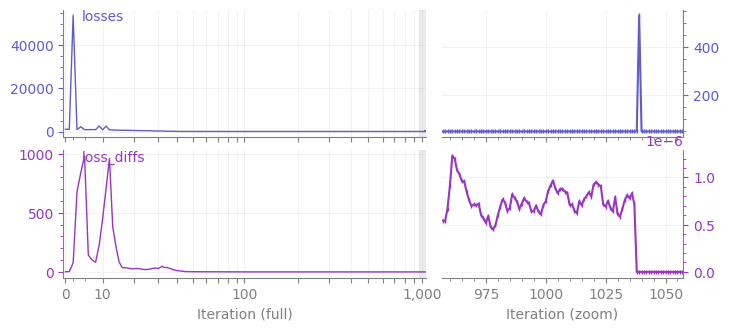

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [33]:
optmzr.plot()

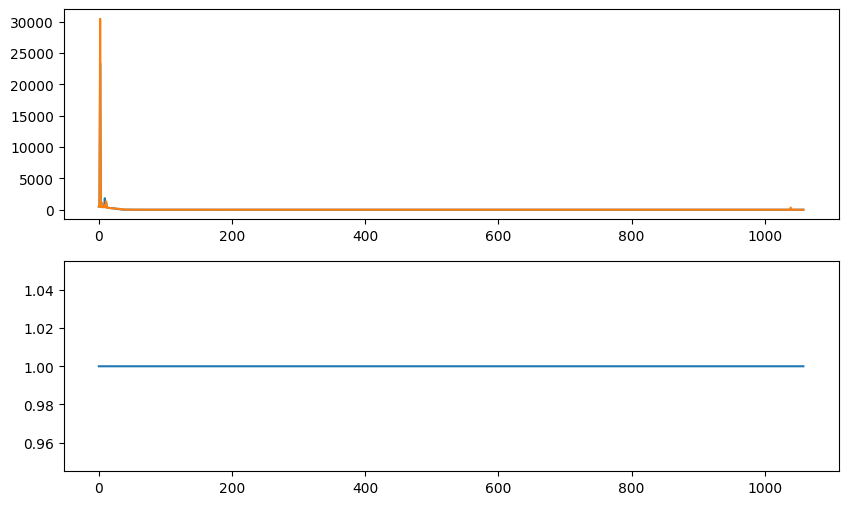

In [36]:
X = np.array(loss_data)

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

plt.show()

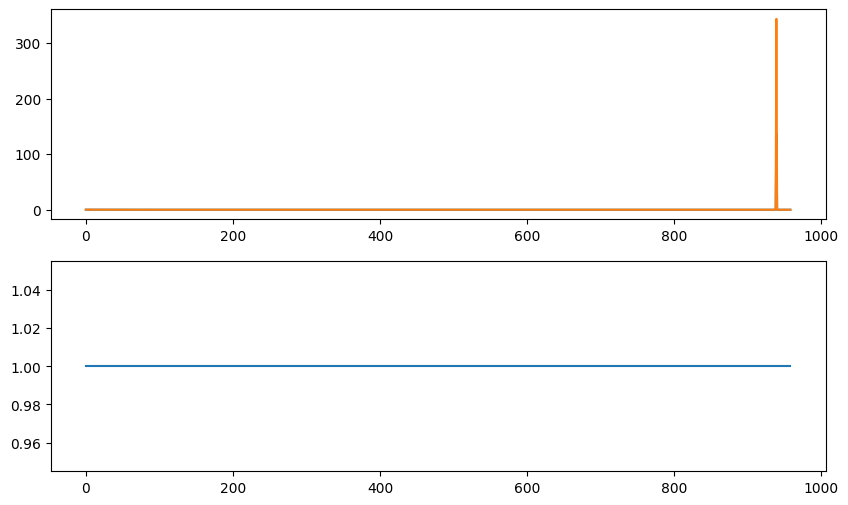

In [37]:
X = np.array(loss_data)[100:]

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

plt.show()

## 2

In [42]:
loss_data=list()

In [43]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': tnc,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 200,
        'losses': loss_data
    },
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='L-BFGS-B',               # supplied to scipy.minimize
)

In [44]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                             | 0/1000 [00:00<?, ?it/s]

+1220.015799785700 [best: +1220.015799785700] :   0%|     | 1/1000 [00:00<03:07,  5.32it/s]

+1195.847987636236 [best: +1195.847987636236] :   0%|     | 2/1000 [00:00<03:02,  5.48it/s]

+73328.839571735531 [best: +1195.847987636236] :   0%|    | 3/1000 [00:00<02:57,  5.61it/s]

+1077.778228667970 [best: +1077.778228667970] :   0%|     | 4/1000 [00:00<02:56,  5.65it/s]

+2845.779206865892 [best: +1077.778228667970] :   0%|     | 5/1000 [00:00<02:55,  5.65it/s]

+1035.330082278414 [best: +1035.330082278414] :   1%|     | 6/1000 [00:01<03:00,  5.51it/s]

+1033.559529409017 [best: +1033.559529409017] :   1%|     | 7/1000 [00:01<03:03,  5.41it/s]

+1023.521653423839 [best: +1023.521653423839] :   1%|     | 8/1000 [00:01<03:05,  5.36it/s]

+709892338715756.250000000000 [best: +1023.521653423839] :   1%| | 9/1000 [00:01<03:05,  5.

+22271508.020210832357 [best: +1023.521653423839] :   1%| | 10/1000 [00:01<03:03,  5.39it/s

+2394.071822856862 [best: +1023.521653423839] :   1%|    | 11/1000 [00:02<03:05,  5.33it/s]

+936.012724470560 [best: +936.012724470560] :   1%|      | 12/1000 [00:02<03:03,  5.39it/s]

+496503.701942994434 [best: +936.012724470560] :   1%|   | 13/1000 [00:02<03:00,  5.48it/s]

+1314.202931441437 [best: +936.012724470560] :   1%|     | 14/1000 [00:02<02:57,  5.56it/s]

+904.922843545976 [best: +904.922843545976] :   2%|      | 15/1000 [00:02<02:56,  5.59it/s]

+869.075041235955 [best: +869.075041235955] :   2%|      | 16/1000 [00:02<02:56,  5.57it/s]

+810.054963248202 [best: +810.054963248202] :   2%|      | 17/1000 [00:03<02:55,  5.61it/s]

+758.733771562420 [best: +758.733771562420] :   2%|      | 18/1000 [00:03<02:57,  5.54it/s]

+725.944450512432 [best: +725.944450512432] :   2%|      | 19/1000 [00:03<02:57,  5.53it/s]

+702.973744585870 [best: +702.973744585870] :   2%|      | 20/1000 [00:03<02:55,  5.59it/s]

+684.322837543365 [best: +684.322837543365] :   2%|▏     | 21/1000 [00:03<02:53,  5.64it/s]

+674.223240222564 [best: +674.223240222564] :   2%|▏     | 22/1000 [00:03<02:53,  5.64it/s]

+667.355359500956 [best: +667.355359500956] :   2%|▏     | 23/1000 [00:04<02:53,  5.64it/s]

+653.691906507056 [best: +653.691906507056] :   2%|▏     | 24/1000 [00:04<02:52,  5.67it/s]

+633.769647732712 [best: +633.769647732712] :   2%|▏     | 25/1000 [00:04<02:51,  5.67it/s]

+609.442728994171 [best: +609.442728994171] :   3%|▏     | 26/1000 [00:04<02:51,  5.68it/s]

+579.624647022710 [best: +579.624647022710] :   3%|▏     | 27/1000 [00:04<02:53,  5.62it/s]

+549.384521081683 [best: +549.384521081683] :   3%|▏     | 28/1000 [00:05<02:54,  5.56it/s]

+527.454004940296 [best: +527.454004940296] :   3%|▏     | 29/1000 [00:05<02:54,  5.57it/s]

+508.745610565140 [best: +508.745610565140] :   3%|▏     | 30/1000 [00:05<02:54,  5.56it/s]

+488.683701638749 [best: +488.683701638749] :   3%|▏     | 31/1000 [00:05<02:53,  5.60it/s]

+534.775874242614 [best: +488.683701638749] :   3%|▏     | 32/1000 [00:05<02:54,  5.56it/s]

+474.306064414432 [best: +474.306064414432] :   3%|▏     | 33/1000 [00:05<02:52,  5.60it/s]

+447.952990614208 [best: +447.952990614208] :   3%|▏     | 34/1000 [00:06<02:52,  5.61it/s]

+423.278577519881 [best: +423.278577519881] :   4%|▏     | 35/1000 [00:06<02:51,  5.63it/s]

+396.653658703625 [best: +396.653658703625] :   4%|▏     | 36/1000 [00:06<02:51,  5.63it/s]

+363.644478851499 [best: +363.644478851499] :   4%|▏     | 37/1000 [00:06<02:51,  5.63it/s]

+342.358309506041 [best: +342.358309506041] :   4%|▏     | 38/1000 [00:06<02:50,  5.66it/s]

+316.630838628949 [best: +316.630838628949] :   4%|▏     | 39/1000 [00:07<02:49,  5.69it/s]

+301.281063560539 [best: +301.281063560539] :   4%|▏     | 40/1000 [00:07<02:48,  5.71it/s]

+281.532084860366 [best: +281.532084860366] :   4%|▏     | 41/1000 [00:07<02:46,  5.74it/s]

+263.472612626545 [best: +263.472612626545] :   4%|▎     | 42/1000 [00:07<02:48,  5.69it/s]

+247.218145313859 [best: +247.218145313859] :   4%|▎     | 43/1000 [00:07<02:49,  5.64it/s]

+238.017210820893 [best: +238.017210820893] :   4%|▎     | 44/1000 [00:07<02:48,  5.68it/s]

+229.779775098278 [best: +229.779775098278] :   4%|▎     | 45/1000 [00:08<02:46,  5.72it/s]

+221.849509731160 [best: +221.849509731160] :   5%|▎     | 46/1000 [00:08<02:46,  5.74it/s]

+218.691781438877 [best: +218.691781438877] :   5%|▎     | 47/1000 [00:08<02:48,  5.67it/s]

+215.076986596218 [best: +215.076986596218] :   5%|▎     | 48/1000 [00:08<02:48,  5.67it/s]

+213.314668211865 [best: +213.314668211865] :   5%|▎     | 49/1000 [00:08<02:47,  5.67it/s]

+211.221267759694 [best: +211.221267759694] :   5%|▎     | 50/1000 [00:08<02:53,  5.47it/s]

+208.543610714209 [best: +208.543610714209] :   5%|▎     | 51/1000 [00:09<03:04,  5.14it/s]

+208.134026715334 [best: +208.134026715334] :   5%|▎     | 52/1000 [00:09<03:04,  5.13it/s]

+206.205998756743 [best: +206.205998756743] :   5%|▎     | 53/1000 [00:09<02:59,  5.27it/s]

+205.922738400200 [best: +205.922738400200] :   5%|▎     | 54/1000 [00:09<02:53,  5.44it/s]

+205.307063368097 [best: +205.307063368097] :   6%|▎     | 55/1000 [00:09<02:52,  5.49it/s]

+204.990104180210 [best: +204.990104180210] :   6%|▎     | 56/1000 [00:10<02:49,  5.57it/s]

+204.484897595949 [best: +204.484897595949] :   6%|▎     | 57/1000 [00:10<02:46,  5.65it/s]

+204.032557801175 [best: +204.032557801175] :   6%|▎     | 58/1000 [00:10<02:46,  5.67it/s]

+203.751364585572 [best: +203.751364585572] :   6%|▎     | 59/1000 [00:10<02:45,  5.67it/s]

+202.989569426839 [best: +202.989569426839] :   6%|▎     | 60/1000 [00:10<02:45,  5.69it/s]

+203.491596378185 [best: +202.989569426839] :   6%|▎     | 61/1000 [00:10<02:45,  5.68it/s]

+202.684087344769 [best: +202.684087344769] :   6%|▎     | 62/1000 [00:11<02:44,  5.70it/s]

+202.405458899896 [best: +202.405458899896] :   6%|▍     | 63/1000 [00:11<02:44,  5.70it/s]

+202.198167913194 [best: +202.198167913194] :   6%|▍     | 64/1000 [00:11<02:46,  5.61it/s]

+201.931562175210 [best: +201.931562175210] :   6%|▍     | 65/1000 [00:11<02:48,  5.54it/s]

+201.844740728462 [best: +201.844740728462] :   7%|▍     | 66/1000 [00:11<02:47,  5.58it/s]

+201.660320930882 [best: +201.660320930882] :   7%|▍     | 67/1000 [00:12<02:47,  5.56it/s]

+201.590048350658 [best: +201.590048350658] :   7%|▍     | 68/1000 [00:12<02:47,  5.56it/s]

+201.494479131168 [best: +201.494479131168] :   7%|▍     | 69/1000 [00:12<02:48,  5.53it/s]

+201.376620495831 [best: +201.376620495831] :   7%|▍     | 70/1000 [00:12<02:49,  5.48it/s]

+201.278919909481 [best: +201.278919909481] :   7%|▍     | 71/1000 [00:12<02:50,  5.46it/s]

+201.224149158208 [best: +201.224149158208] :   7%|▍     | 72/1000 [00:12<02:49,  5.49it/s]

+201.180935339175 [best: +201.180935339175] :   7%|▍     | 73/1000 [00:13<02:48,  5.52it/s]

+201.118404097891 [best: +201.118404097891] :   7%|▍     | 74/1000 [00:13<02:44,  5.62it/s]

+201.012873965706 [best: +201.012873965706] :   8%|▍     | 75/1000 [00:13<02:45,  5.59it/s]

+200.926094634602 [best: +200.926094634602] :   8%|▍     | 76/1000 [00:13<02:45,  5.57it/s]

+200.855415639339 [best: +200.855415639339] :   8%|▍     | 77/1000 [00:13<02:44,  5.62it/s]

+200.806422645554 [best: +200.806422645554] :   8%|▍     | 78/1000 [00:14<02:47,  5.52it/s]

+200.771270635303 [best: +200.771270635303] :   8%|▍     | 79/1000 [00:14<02:48,  5.46it/s]

+200.709863812312 [best: +200.709863812312] :   8%|▍     | 80/1000 [00:14<02:47,  5.49it/s]

+200.662637613740 [best: +200.662637613740] :   8%|▍     | 81/1000 [00:14<02:46,  5.53it/s]

+200.633454592483 [best: +200.633454592483] :   8%|▍     | 82/1000 [00:14<02:45,  5.55it/s]

+200.606885111426 [best: +200.606885111426] :   8%|▍     | 83/1000 [00:14<02:44,  5.59it/s]

+200.578674435821 [best: +200.578674435821] :   8%|▌     | 84/1000 [00:15<02:43,  5.62it/s]

+200.581368577416 [best: +200.578674435821] :   8%|▌     | 85/1000 [00:15<02:44,  5.56it/s]

+200.559975656822 [best: +200.559975656822] :   9%|▌     | 86/1000 [00:15<02:42,  5.63it/s]

+200.538952863120 [best: +200.538952863120] :   9%|▌     | 87/1000 [00:15<02:42,  5.62it/s]

+200.524293434874 [best: +200.524293434874] :   9%|▌     | 88/1000 [00:15<02:43,  5.58it/s]

+200.497905616023 [best: +200.497905616023] :   9%|▌     | 89/1000 [00:15<02:40,  5.66it/s]

+200.471771726546 [best: +200.471771726546] :   9%|▌     | 90/1000 [00:16<02:42,  5.61it/s]

+200.445081737096 [best: +200.445081737096] :   9%|▌     | 91/1000 [00:16<02:39,  5.68it/s]

+200.422811626027 [best: +200.422811626027] :   9%|▌     | 92/1000 [00:16<02:40,  5.66it/s]

+200.397342425708 [best: +200.397342425708] :   9%|▌     | 93/1000 [00:16<02:41,  5.63it/s]

+200.368645158339 [best: +200.368645158339] :   9%|▌     | 94/1000 [00:16<02:47,  5.40it/s]

+200.347468263542 [best: +200.347468263542] :  10%|▌     | 95/1000 [00:17<02:51,  5.29it/s]

+200.329709342481 [best: +200.329709342481] :  10%|▌     | 96/1000 [00:17<02:49,  5.33it/s]

+200.315490470134 [best: +200.315490470134] :  10%|▌     | 97/1000 [00:17<02:47,  5.39it/s]

+200.303334685639 [best: +200.303334685639] :  10%|▌     | 98/1000 [00:17<02:46,  5.43it/s]

+200.292691796708 [best: +200.292691796708] :  10%|▌     | 99/1000 [00:17<02:44,  5.49it/s]

+200.287349133699 [best: +200.287349133699] :  10%|▌    | 100/1000 [00:17<02:41,  5.58it/s]

+200.276703641893 [best: +200.276703641893] :  10%|▌    | 101/1000 [00:18<02:39,  5.64it/s]

+200.269875797137 [best: +200.269875797137] :  10%|▌    | 102/1000 [00:18<02:42,  5.53it/s]

+200.254683960444 [best: +200.254683960444] :  10%|▌    | 103/1000 [00:18<02:43,  5.47it/s]

+200.249575925706 [best: +200.249575925706] :  10%|▌    | 104/1000 [00:18<02:44,  5.45it/s]

+200.241179465822 [best: +200.241179465822] :  10%|▌    | 105/1000 [00:18<02:42,  5.50it/s]

+200.230166896092 [best: +200.230166896092] :  11%|▌    | 106/1000 [00:19<02:40,  5.56it/s]

+200.225438911828 [best: +200.225438911828] :  11%|▌    | 107/1000 [00:19<02:38,  5.64it/s]

+200.213468371924 [best: +200.213468371924] :  11%|▌    | 108/1000 [00:19<03:37,  4.10it/s]

+200.209714911471 [best: +200.209714911471] :  11%|▌    | 109/1000 [00:19<03:19,  4.47it/s]

+200.202356531836 [best: +200.202356531836] :  11%|▌    | 110/1000 [00:19<03:05,  4.79it/s]

+200.207694168455 [best: +200.202356531836] :  11%|▌    | 111/1000 [00:20<02:57,  5.00it/s]

+200.198559829342 [best: +200.198559829342] :  11%|▌    | 112/1000 [00:20<02:55,  5.05it/s]

+200.191671051849 [best: +200.191671051849] :  11%|▌    | 113/1000 [00:20<02:52,  5.13it/s]

+200.185801612062 [best: +200.185801612062] :  11%|▌    | 114/1000 [00:20<02:50,  5.18it/s]

+200.179364991608 [best: +200.179364991608] :  12%|▌    | 115/1000 [00:20<02:49,  5.23it/s]

+200.172748188082 [best: +200.172748188082] :  12%|▌    | 116/1000 [00:21<02:49,  5.23it/s]

+200.168718277520 [best: +200.168718277520] :  12%|▌    | 117/1000 [00:21<02:50,  5.18it/s]

+200.163940577199 [best: +200.163940577199] :  12%|▌    | 118/1000 [00:21<02:47,  5.28it/s]

+200.161109869720 [best: +200.161109869720] :  12%|▌    | 119/1000 [00:21<02:50,  5.18it/s]

+200.157719796195 [best: +200.157719796195] :  12%|▌    | 120/1000 [00:21<02:50,  5.16it/s]

+200.150975387320 [best: +200.150975387320] :  12%|▌    | 121/1000 [00:22<02:50,  5.15it/s]

+200.148236875402 [best: +200.148236875402] :  12%|▌    | 122/1000 [00:22<02:50,  5.15it/s]

+200.142044072859 [best: +200.142044072859] :  12%|▌    | 123/1000 [00:22<02:50,  5.13it/s]

+200.139717086817 [best: +200.139717086817] :  12%|▌    | 124/1000 [00:22<02:50,  5.13it/s]

+200.136152235048 [best: +200.136152235048] :  12%|▋    | 125/1000 [00:22<02:51,  5.10it/s]

+200.131986559536 [best: +200.131986559536] :  13%|▋    | 126/1000 [00:23<02:52,  5.07it/s]

+200.126526898374 [best: +200.126526898374] :  13%|▋    | 127/1000 [00:23<02:49,  5.16it/s]

+200.123959652045 [best: +200.123959652045] :  13%|▋    | 128/1000 [00:23<02:48,  5.16it/s]

+200.121128413372 [best: +200.121128413372] :  13%|▋    | 129/1000 [00:23<02:46,  5.23it/s]

+200.117989230347 [best: +200.117989230347] :  13%|▋    | 130/1000 [00:23<02:46,  5.21it/s]

+200.113620827757 [best: +200.113620827757] :  13%|▋    | 131/1000 [00:24<02:45,  5.25it/s]

+200.111804671782 [best: +200.111804671782] :  13%|▋    | 132/1000 [00:24<02:49,  5.13it/s]

+200.108561671829 [best: +200.108561671829] :  13%|▋    | 133/1000 [00:24<02:43,  5.31it/s]

+200.107024455663 [best: +200.107024455663] :  13%|▋    | 134/1000 [00:24<02:46,  5.20it/s]

+200.104905108580 [best: +200.104905108580] :  14%|▋    | 135/1000 [00:24<02:44,  5.27it/s]

+200.101066714684 [best: +200.101066714684] :  14%|▋    | 136/1000 [00:24<02:41,  5.35it/s]

+200.106470352956 [best: +200.101066714684] :  14%|▋    | 137/1000 [00:25<02:39,  5.41it/s]

+200.099073329729 [best: +200.099073329729] :  14%|▋    | 138/1000 [00:25<02:38,  5.45it/s]

+200.096008835084 [best: +200.096008835084] :  14%|▋    | 139/1000 [00:25<02:38,  5.43it/s]

+200.094462211993 [best: +200.094462211993] :  14%|▋    | 140/1000 [00:25<02:38,  5.41it/s]

+200.092959521218 [best: +200.092959521218] :  14%|▋    | 141/1000 [00:25<02:38,  5.43it/s]

+200.091471558908 [best: +200.091471558908] :  14%|▋    | 142/1000 [00:26<02:38,  5.40it/s]

+200.088049689823 [best: +200.088049689823] :  14%|▋    | 143/1000 [00:26<02:37,  5.45it/s]

+200.084317598396 [best: +200.084317598396] :  14%|▋    | 144/1000 [00:26<02:36,  5.47it/s]

+200.083472456189 [best: +200.083472456189] :  14%|▋    | 145/1000 [00:26<02:35,  5.48it/s]

+200.078879551389 [best: +200.078879551389] :  15%|▋    | 146/1000 [00:26<02:33,  5.57it/s]

+200.077665257282 [best: +200.077665257282] :  15%|▋    | 147/1000 [00:26<02:33,  5.57it/s]

+200.076458579544 [best: +200.076458579544] :  15%|▋    | 148/1000 [00:27<02:35,  5.47it/s]

+200.074750627269 [best: +200.074750627269] :  15%|▋    | 149/1000 [00:27<02:35,  5.48it/s]

+200.073708234960 [best: +200.073708234960] :  15%|▊    | 150/1000 [00:27<02:34,  5.51it/s]

+200.072181688269 [best: +200.072181688269] :  15%|▊    | 151/1000 [00:27<02:33,  5.52it/s]

+200.072864998262 [best: +200.072181688269] :  15%|▊    | 152/1000 [00:27<02:33,  5.54it/s]

+200.071453357145 [best: +200.071453357145] :  15%|▊    | 153/1000 [00:28<02:31,  5.58it/s]

+200.070217428287 [best: +200.070217428287] :  15%|▊    | 154/1000 [00:28<02:32,  5.53it/s]

+200.068509485992 [best: +200.068509485992] :  16%|▊    | 155/1000 [00:28<02:32,  5.53it/s]

+200.067167834812 [best: +200.067167834812] :  16%|▊    | 156/1000 [00:28<02:32,  5.53it/s]

+200.066119004942 [best: +200.066119004942] :  16%|▊    | 157/1000 [00:28<02:31,  5.57it/s]

+200.065320457306 [best: +200.065320457306] :  16%|▊    | 158/1000 [00:28<02:31,  5.57it/s]

+200.063560883377 [best: +200.063560883377] :  16%|▊    | 159/1000 [00:29<02:30,  5.59it/s]

+200.062122596600 [best: +200.062122596600] :  16%|▊    | 160/1000 [00:29<02:29,  5.63it/s]

+200.059597473572 [best: +200.059597473572] :  16%|▊    | 161/1000 [00:29<02:30,  5.57it/s]

+200.059519876067 [best: +200.059519876067] :  16%|▊    | 162/1000 [00:29<02:31,  5.51it/s]

+200.058250081709 [best: +200.058250081709] :  16%|▊    | 163/1000 [00:29<02:31,  5.52it/s]

+200.057014145275 [best: +200.057014145275] :  16%|▊    | 164/1000 [00:30<02:30,  5.54it/s]

+200.055958565624 [best: +200.055958565624] :  16%|▊    | 165/1000 [00:30<02:30,  5.56it/s]

+200.054839304358 [best: +200.054839304358] :  17%|▊    | 166/1000 [00:30<02:29,  5.59it/s]

+200.053949552179 [best: +200.053949552179] :  17%|▊    | 167/1000 [00:30<02:28,  5.61it/s]

+200.052551413416 [best: +200.052551413416] :  17%|▊    | 168/1000 [00:30<02:30,  5.53it/s]

+200.052067180377 [best: +200.052067180377] :  17%|▊    | 169/1000 [00:30<02:32,  5.45it/s]

+200.051504117759 [best: +200.051504117759] :  17%|▊    | 170/1000 [00:31<02:36,  5.31it/s]

+200.050635675874 [best: +200.050635675874] :  17%|▊    | 171/1000 [00:31<02:34,  5.35it/s]

+200.049214017985 [best: +200.049214017985] :  17%|▊    | 172/1000 [00:31<02:32,  5.43it/s]

+200.048237045987 [best: +200.048237045987] :  17%|▊    | 173/1000 [00:31<02:38,  5.22it/s]

+200.047592222920 [best: +200.047592222920] :  17%|▊    | 174/1000 [00:31<02:35,  5.31it/s]

+200.046530541687 [best: +200.046530541687] :  18%|▉    | 175/1000 [00:32<02:31,  5.46it/s]

+200.056301787036 [best: +200.046530541687] :  18%|▉    | 176/1000 [00:32<02:28,  5.56it/s]

+200.045989864355 [best: +200.045989864355] :  18%|▉    | 177/1000 [00:32<02:25,  5.67it/s]

+200.044705733969 [best: +200.044705733969] :  18%|▉    | 178/1000 [00:32<02:24,  5.69it/s]

+200.043896213858 [best: +200.043896213858] :  18%|▉    | 179/1000 [00:32<02:23,  5.71it/s]

+200.042761564483 [best: +200.042761564483] :  18%|▉    | 180/1000 [00:32<02:22,  5.75it/s]

+200.042087892273 [best: +200.042087892273] :  18%|▉    | 181/1000 [00:33<02:23,  5.71it/s]

+200.041366330043 [best: +200.041366330043] :  18%|▉    | 182/1000 [00:33<02:25,  5.62it/s]

+200.040692248491 [best: +200.040692248491] :  18%|▉    | 183/1000 [00:33<02:24,  5.65it/s]

+200.039745631026 [best: +200.039745631026] :  18%|▉    | 184/1000 [00:33<02:24,  5.67it/s]

+200.039268182605 [best: +200.039268182605] :  18%|▉    | 185/1000 [00:33<02:22,  5.70it/s]

+200.038533546125 [best: +200.038533546125] :  19%|▉    | 186/1000 [00:33<02:23,  5.69it/s]

+200.038201163522 [best: +200.038201163522] :  19%|▉    | 187/1000 [00:34<02:22,  5.72it/s]

+200.037772894022 [best: +200.037772894022] :  19%|▉    | 188/1000 [00:34<02:21,  5.74it/s]

+200.037361072752 [best: +200.037361072752] :  19%|▉    | 189/1000 [00:34<02:21,  5.72it/s]

+200.036818564450 [best: +200.036818564450] :  19%|▉    | 190/1000 [00:34<02:21,  5.72it/s]

+200.036268715586 [best: +200.036268715586] :  19%|▉    | 191/1000 [00:34<02:20,  5.75it/s]

+200.035640562381 [best: +200.035640562381] :  19%|▉    | 192/1000 [00:35<02:20,  5.77it/s]

+200.034608723608 [best: +200.034608723608] :  19%|▉    | 193/1000 [00:35<02:20,  5.76it/s]

+200.034965531482 [best: +200.034608723608] :  19%|▉    | 194/1000 [00:35<02:19,  5.76it/s]

+200.034114876868 [best: +200.034114876868] :  20%|▉    | 195/1000 [00:35<02:22,  5.66it/s]

+200.033602725352 [best: +200.033602725352] :  20%|▉    | 196/1000 [00:35<02:26,  5.48it/s]

+200.033135088648 [best: +200.033135088648] :  20%|▉    | 197/1000 [00:35<02:26,  5.47it/s]

+200.032471678724 [best: +200.032471678724] :  20%|▉    | 198/1000 [00:36<02:24,  5.55it/s]

+200.032026294787 [best: +200.032026294787] :  20%|▉    | 199/1000 [00:36<02:23,  5.59it/s]

+200.031390105063 [best: +200.031390105063] :  20%|█    | 200/1000 [00:36<02:23,  5.59it/s]

+200.031035783542 [best: +200.031035783542] :  20%|█    | 201/1000 [00:36<02:21,  5.64it/s]

+200.030739149319 [best: +200.030739149319] :  20%|█    | 202/1000 [00:36<02:25,  5.50it/s]

+200.029969239381 [best: +200.029969239381] :  20%|█    | 203/1000 [00:37<02:28,  5.36it/s]

+200.032642362744 [best: +200.029969239381] :  20%|█    | 204/1000 [00:37<02:33,  5.18it/s]

+200.029713207407 [best: +200.029713207407] :  20%|█    | 205/1000 [00:37<02:32,  5.20it/s]

+200.029275413938 [best: +200.029275413938] :  21%|█    | 206/1000 [00:37<02:30,  5.28it/s]

+200.028951549336 [best: +200.028951549336] :  21%|█    | 207/1000 [00:37<02:32,  5.21it/s]

+200.028594145937 [best: +200.028594145937] :  21%|█    | 208/1000 [00:38<02:33,  5.17it/s]

+200.028292187365 [best: +200.028292187365] :  21%|█    | 209/1000 [00:38<02:34,  5.13it/s]

+200.027963308924 [best: +200.027963308924] :  21%|█    | 210/1000 [00:38<02:34,  5.10it/s]

+200.027627893447 [best: +200.027627893447] :  21%|█    | 211/1000 [00:38<02:30,  5.23it/s]

+200.027423641231 [best: +200.027423641231] :  21%|█    | 212/1000 [00:38<02:33,  5.13it/s]

+200.027156955576 [best: +200.027156955576] :  21%|█    | 213/1000 [00:39<02:38,  4.97it/s]

+200.026527870694 [best: +200.026527870694] :  21%|█    | 214/1000 [00:39<02:37,  5.00it/s]

+200.026315055396 [best: +200.026315055396] :  22%|█    | 215/1000 [00:39<02:34,  5.09it/s]

+200.026011647350 [best: +200.026011647350] :  22%|█    | 216/1000 [00:39<02:31,  5.17it/s]

+200.025604197374 [best: +200.025604197374] :  22%|█    | 217/1000 [00:39<02:28,  5.27it/s]

+200.027626838249 [best: +200.025604197374] :  22%|█    | 218/1000 [00:39<02:28,  5.27it/s]

+200.025434499665 [best: +200.025434499665] :  22%|█    | 219/1000 [00:40<02:25,  5.38it/s]

+200.025059681098 [best: +200.025059681098] :  22%|█    | 220/1000 [00:40<02:22,  5.46it/s]

+200.024858609966 [best: +200.024858609966] :  22%|█    | 221/1000 [00:40<02:25,  5.37it/s]

+200.024573427281 [best: +200.024573427281] :  22%|█    | 222/1000 [00:40<02:33,  5.07it/s]

+200.024346637922 [best: +200.024346637922] :  22%|█    | 223/1000 [00:40<02:33,  5.05it/s]

+200.024049055238 [best: +200.024049055238] :  22%|█    | 224/1000 [00:41<02:31,  5.11it/s]

+200.023659309778 [best: +200.023659309778] :  22%|█▏   | 225/1000 [00:41<02:30,  5.16it/s]

+200.023462303575 [best: +200.023462303575] :  23%|█▏   | 226/1000 [00:41<02:31,  5.10it/s]

+200.023018476069 [best: +200.023018476069] :  23%|█▏   | 227/1000 [00:41<02:32,  5.05it/s]

+200.023362097582 [best: +200.023018476069] :  23%|█▏   | 228/1000 [00:41<02:30,  5.11it/s]

+200.022781894904 [best: +200.022781894904] :  23%|█▏   | 229/1000 [00:42<02:28,  5.21it/s]

+200.022530219526 [best: +200.022530219526] :  23%|█▏   | 230/1000 [00:42<02:25,  5.28it/s]

+200.022241925769 [best: +200.022241925769] :  23%|█▏   | 231/1000 [00:42<02:23,  5.34it/s]

+200.022078878082 [best: +200.022078878082] :  23%|█▏   | 232/1000 [00:42<02:22,  5.38it/s]

+200.021851771068 [best: +200.021851771068] :  23%|█▏   | 233/1000 [00:42<02:22,  5.37it/s]

+200.021566858190 [best: +200.021566858190] :  23%|█▏   | 234/1000 [00:42<02:21,  5.42it/s]

+200.021399163336 [best: +200.021399163336] :  24%|█▏   | 235/1000 [00:43<02:19,  5.50it/s]

+200.021198648699 [best: +200.021198648699] :  24%|█▏   | 236/1000 [00:43<02:18,  5.51it/s]

+200.020799131480 [best: +200.020799131480] :  24%|█▏   | 237/1000 [00:43<02:17,  5.56it/s]

+200.020851388197 [best: +200.020799131480] :  24%|█▏   | 238/1000 [00:43<03:08,  4.04it/s]

+200.020538318762 [best: +200.020538318762] :  24%|█▏   | 239/1000 [00:44<02:51,  4.43it/s]

+200.020282651854 [best: +200.020282651854] :  24%|█▏   | 240/1000 [00:44<02:41,  4.69it/s]

+200.020067134677 [best: +200.020067134677] :  24%|█▏   | 241/1000 [00:44<02:36,  4.86it/s]

+200.019822050222 [best: +200.019822050222] :  24%|█▏   | 242/1000 [00:44<02:33,  4.93it/s]

+200.019606226626 [best: +200.019606226626] :  24%|█▏   | 243/1000 [00:44<02:34,  4.91it/s]

+200.019189335505 [best: +200.019189335505] :  24%|█▏   | 244/1000 [00:45<02:36,  4.84it/s]

+200.019042738641 [best: +200.019042738641] :  24%|█▏   | 245/1000 [00:45<02:37,  4.78it/s]

+200.018798528045 [best: +200.018798528045] :  25%|█▏   | 246/1000 [00:45<02:38,  4.76it/s]

+200.018569658776 [best: +200.018569658776] :  25%|█▏   | 247/1000 [00:45<02:41,  4.66it/s]

+200.018244073033 [best: +200.018244073033] :  25%|█▏   | 248/1000 [00:45<02:42,  4.63it/s]

+200.017995092016 [best: +200.017995092016] :  25%|█▏   | 249/1000 [00:46<02:43,  4.59it/s]

+200.017745440143 [best: +200.017745440143] :  25%|█▎   | 250/1000 [00:46<02:46,  4.49it/s]

+200.017372977319 [best: +200.017372977319] :  25%|█▎   | 251/1000 [00:46<02:48,  4.43it/s]

+200.017341798925 [best: +200.017341798925] :  25%|█▎   | 252/1000 [00:46<02:47,  4.47it/s]

+200.017097195422 [best: +200.017097195422] :  25%|█▎   | 253/1000 [00:47<02:45,  4.52it/s]

+200.016790877539 [best: +200.016790877539] :  25%|█▎   | 254/1000 [00:47<02:43,  4.57it/s]

+200.016581569430 [best: +200.016581569430] :  26%|█▎   | 255/1000 [00:47<02:42,  4.59it/s]

+200.016166452087 [best: +200.016166452087] :  26%|█▎   | 256/1000 [00:47<02:40,  4.65it/s]

+200.016840879566 [best: +200.016166452087] :  26%|█▎   | 257/1000 [00:47<02:37,  4.71it/s]

+200.016019120354 [best: +200.016019120354] :  26%|█▎   | 258/1000 [00:48<02:36,  4.74it/s]

+200.015722835925 [best: +200.015722835925] :  26%|█▎   | 259/1000 [00:48<02:34,  4.81it/s]

+200.015466161334 [best: +200.015466161334] :  26%|█▎   | 260/1000 [00:48<02:30,  4.90it/s]

+200.015018815672 [best: +200.015018815672] :  26%|█▎   | 261/1000 [00:48<02:28,  4.97it/s]

+200.016676136805 [best: +200.015018815672] :  26%|█▎   | 262/1000 [00:48<02:25,  5.05it/s]

+200.014928542361 [best: +200.014928542361] :  26%|█▎   | 263/1000 [00:49<02:23,  5.13it/s]

+200.014704755203 [best: +200.014704755203] :  26%|█▎   | 264/1000 [00:49<02:17,  5.35it/s]

+200.014456295799 [best: +200.014456295799] :  26%|█▎   | 265/1000 [00:49<02:13,  5.52it/s]

+200.014171265205 [best: +200.014171265205] :  27%|█▎   | 266/1000 [00:49<02:14,  5.44it/s]

+200.014007101575 [best: +200.014007101575] :  27%|█▎   | 267/1000 [00:49<02:14,  5.45it/s]

+200.013814632074 [best: +200.013814632074] :  27%|█▎   | 268/1000 [00:50<02:16,  5.36it/s]

+200.013671128241 [best: +200.013671128241] :  27%|█▎   | 269/1000 [00:50<02:18,  5.28it/s]

+200.013356177972 [best: +200.013356177972] :  27%|█▎   | 270/1000 [00:50<02:20,  5.19it/s]

+200.013244812836 [best: +200.013244812836] :  27%|█▎   | 271/1000 [00:50<02:21,  5.17it/s]

+200.013030512735 [best: +200.013030512735] :  27%|█▎   | 272/1000 [00:50<02:19,  5.21it/s]

+200.012859755180 [best: +200.012859755180] :  27%|█▎   | 273/1000 [00:50<02:16,  5.32it/s]

+200.012704389371 [best: +200.012704389371] :  27%|█▎   | 274/1000 [00:51<02:15,  5.36it/s]

+200.012493228008 [best: +200.012493228008] :  28%|█▍   | 275/1000 [00:51<02:14,  5.41it/s]

+200.012251718918 [best: +200.012251718918] :  28%|█▍   | 276/1000 [00:51<02:14,  5.38it/s]

+200.012082355597 [best: +200.012082355597] :  28%|█▍   | 277/1000 [00:51<02:18,  5.20it/s]

+200.011930158848 [best: +200.011930158848] :  28%|█▍   | 278/1000 [00:51<02:21,  5.09it/s]

+200.011818292880 [best: +200.011818292880] :  28%|█▍   | 279/1000 [00:52<02:20,  5.15it/s]

+200.011631725593 [best: +200.011631725593] :  28%|█▍   | 280/1000 [00:52<02:15,  5.31it/s]

+200.011687365007 [best: +200.011631725593] :  28%|█▍   | 281/1000 [00:52<02:12,  5.44it/s]

+200.011530465809 [best: +200.011530465809] :  28%|█▍   | 282/1000 [00:52<02:09,  5.53it/s]

+200.011370656243 [best: +200.011370656243] :  28%|█▍   | 283/1000 [00:52<02:11,  5.44it/s]

+200.011283098490 [best: +200.011283098490] :  28%|█▍   | 284/1000 [00:53<02:09,  5.51it/s]

+200.011127097517 [best: +200.011127097517] :  28%|█▍   | 285/1000 [00:53<02:08,  5.55it/s]

+200.010954943399 [best: +200.010954943399] :  29%|█▍   | 286/1000 [00:53<02:13,  5.36it/s]

+200.011289158588 [best: +200.010954943399] :  29%|█▍   | 287/1000 [00:53<02:15,  5.26it/s]

+200.010897316884 [best: +200.010897316884] :  29%|█▍   | 288/1000 [00:53<02:15,  5.27it/s]

+200.010766683967 [best: +200.010766683967] :  29%|█▍   | 289/1000 [00:53<02:16,  5.20it/s]

+200.010669497853 [best: +200.010669497853] :  29%|█▍   | 290/1000 [00:54<02:13,  5.30it/s]

+200.010497252679 [best: +200.010497252679] :  29%|█▍   | 291/1000 [00:54<02:12,  5.36it/s]

+200.010787371844 [best: +200.010497252679] :  29%|█▍   | 292/1000 [00:54<02:13,  5.30it/s]

+200.010439425464 [best: +200.010439425464] :  29%|█▍   | 293/1000 [00:54<02:14,  5.26it/s]

+200.010338189047 [best: +200.010338189047] :  29%|█▍   | 294/1000 [00:54<02:12,  5.33it/s]

+200.010194732786 [best: +200.010194732786] :  30%|█▍   | 295/1000 [00:55<02:09,  5.46it/s]

+200.010061340994 [best: +200.010061340994] :  30%|█▍   | 296/1000 [00:55<02:08,  5.46it/s]

+200.009984209033 [best: +200.009984209033] :  30%|█▍   | 297/1000 [00:55<02:15,  5.18it/s]

+200.009845698580 [best: +200.009845698580] :  30%|█▍   | 298/1000 [00:55<02:21,  4.95it/s]

+200.009783104448 [best: +200.009783104448] :  30%|█▍   | 299/1000 [00:55<02:17,  5.09it/s]

+200.009677827664 [best: +200.009677827664] :  30%|█▌   | 300/1000 [00:56<02:20,  4.98it/s]

+200.009568452827 [best: +200.009568452827] :  30%|█▌   | 301/1000 [00:56<02:26,  4.77it/s]

+200.009453653529 [best: +200.009453653529] :  30%|█▌   | 302/1000 [00:56<02:28,  4.69it/s]

+200.009384530363 [best: +200.009384530363] :  30%|█▌   | 303/1000 [00:56<02:25,  4.79it/s]

+200.009277031114 [best: +200.009277031114] :  30%|█▌   | 304/1000 [00:56<02:26,  4.75it/s]

+200.009182051090 [best: +200.009182051090] :  30%|█▌   | 305/1000 [00:57<02:22,  4.86it/s]

+200.009244041864 [best: +200.009182051090] :  31%|█▌   | 306/1000 [00:57<02:23,  4.82it/s]

+200.009116833640 [best: +200.009116833640] :  31%|█▌   | 307/1000 [00:57<02:24,  4.81it/s]

+200.009046538830 [best: +200.009046538830] :  31%|█▌   | 308/1000 [00:57<02:21,  4.91it/s]

+200.008990650756 [best: +200.008990650756] :  31%|█▌   | 309/1000 [00:57<02:18,  5.00it/s]

+200.008947122157 [best: +200.008947122157] :  31%|█▌   | 310/1000 [00:58<02:12,  5.20it/s]

+200.008839787154 [best: +200.008839787154] :  31%|█▌   | 311/1000 [00:58<02:07,  5.42it/s]

+200.008760932717 [best: +200.008760932717] :  31%|█▌   | 312/1000 [00:58<02:09,  5.32it/s]

+200.008690650635 [best: +200.008690650635] :  31%|█▌   | 313/1000 [00:58<02:14,  5.10it/s]

+200.008627612332 [best: +200.008627612332] :  31%|█▌   | 314/1000 [00:58<02:12,  5.17it/s]

+200.008571283077 [best: +200.008571283077] :  32%|█▌   | 315/1000 [00:59<02:16,  5.02it/s]

+200.008407397556 [best: +200.008407397556] :  32%|█▌   | 316/1000 [00:59<02:18,  4.93it/s]

+200.008915769816 [best: +200.008407397556] :  32%|█▌   | 317/1000 [00:59<02:19,  4.91it/s]

+200.008362402464 [best: +200.008362402464] :  32%|█▌   | 318/1000 [00:59<02:17,  4.97it/s]

+200.008282430727 [best: +200.008282430727] :  32%|█▌   | 319/1000 [00:59<02:18,  4.93it/s]

+200.008217747957 [best: +200.008217747957] :  32%|█▌   | 320/1000 [01:00<02:20,  4.83it/s]

+200.008138689571 [best: +200.008138689571] :  32%|█▌   | 321/1000 [01:00<02:23,  4.74it/s]

+200.008073237964 [best: +200.008073237964] :  32%|█▌   | 322/1000 [01:00<02:19,  4.87it/s]

+200.007989449112 [best: +200.007989449112] :  32%|█▌   | 323/1000 [01:00<02:15,  5.00it/s]

+200.007939746423 [best: +200.007939746423] :  32%|█▌   | 324/1000 [01:00<02:10,  5.16it/s]

+200.007849359638 [best: +200.007849359638] :  32%|█▋   | 325/1000 [01:01<02:11,  5.12it/s]

+200.007782130626 [best: +200.007782130626] :  33%|█▋   | 326/1000 [01:01<02:07,  5.29it/s]

+200.007725140500 [best: +200.007725140500] :  33%|█▋   | 327/1000 [01:01<02:11,  5.11it/s]

+200.007674940736 [best: +200.007674940736] :  33%|█▋   | 328/1000 [01:01<02:09,  5.20it/s]

+200.007621799703 [best: +200.007621799703] :  33%|█▋   | 329/1000 [01:01<02:07,  5.27it/s]

+200.007584828816 [best: +200.007584828816] :  33%|█▋   | 330/1000 [01:02<02:10,  5.15it/s]

+200.007452378363 [best: +200.007452378363] :  33%|█▋   | 331/1000 [01:02<02:10,  5.13it/s]

+200.007672318668 [best: +200.007452378363] :  33%|█▋   | 332/1000 [01:02<02:10,  5.13it/s]

+200.007406755804 [best: +200.007406755804] :  33%|█▋   | 333/1000 [01:02<02:06,  5.25it/s]

+200.007336118399 [best: +200.007336118399] :  33%|█▋   | 334/1000 [01:02<02:05,  5.31it/s]

+200.007255040585 [best: +200.007255040585] :  34%|█▋   | 335/1000 [01:03<02:04,  5.35it/s]

+200.007173575006 [best: +200.007173575006] :  34%|█▋   | 336/1000 [01:03<02:02,  5.44it/s]

+200.007155379057 [best: +200.007155379057] :  34%|█▋   | 337/1000 [01:03<02:00,  5.50it/s]

+200.007039777134 [best: +200.007039777134] :  34%|█▋   | 338/1000 [01:03<02:07,  5.21it/s]

+200.006992302241 [best: +200.006992302241] :  34%|█▋   | 339/1000 [01:03<02:11,  5.04it/s]

+200.006952948762 [best: +200.006952948762] :  34%|█▋   | 340/1000 [01:03<02:09,  5.10it/s]

+200.006890966176 [best: +200.006890966176] :  34%|█▋   | 341/1000 [01:04<02:08,  5.11it/s]

+200.007266538688 [best: +200.006890966176] :  34%|█▋   | 342/1000 [01:04<02:17,  4.78it/s]

+200.006846909866 [best: +200.006846909866] :  34%|█▋   | 343/1000 [01:04<02:19,  4.70it/s]

+200.006733879683 [best: +200.006733879683] :  34%|█▋   | 344/1000 [01:04<02:14,  4.89it/s]

+200.006645595052 [best: +200.006645595052] :  34%|█▋   | 345/1000 [01:05<02:13,  4.91it/s]

+200.006578604153 [best: +200.006578604153] :  35%|█▋   | 346/1000 [01:05<02:14,  4.86it/s]

+200.006524630930 [best: +200.006524630930] :  35%|█▋   | 347/1000 [01:05<02:14,  4.87it/s]

+200.006516005559 [best: +200.006516005559] :  35%|█▋   | 348/1000 [01:05<02:11,  4.94it/s]

+200.006420888680 [best: +200.006420888680] :  35%|█▋   | 349/1000 [01:05<02:11,  4.95it/s]

+200.006390357982 [best: +200.006390357982] :  35%|█▊   | 350/1000 [01:06<02:07,  5.08it/s]

+200.006348507337 [best: +200.006348507337] :  35%|█▊   | 351/1000 [01:06<02:05,  5.16it/s]

+200.006287269466 [best: +200.006287269466] :  35%|█▊   | 352/1000 [01:06<02:03,  5.25it/s]

+200.006208905221 [best: +200.006208905221] :  35%|█▊   | 353/1000 [01:06<02:04,  5.21it/s]

+200.006104622362 [best: +200.006104622362] :  35%|█▊   | 354/1000 [01:06<02:00,  5.37it/s]

+200.006066596754 [best: +200.006066596754] :  36%|█▊   | 355/1000 [01:06<02:00,  5.36it/s]

+200.006003381397 [best: +200.006003381397] :  36%|█▊   | 356/1000 [01:07<02:02,  5.27it/s]

+200.005972450441 [best: +200.005972450441] :  36%|█▊   | 357/1000 [01:07<01:58,  5.42it/s]

+200.005923642346 [best: +200.005923642346] :  36%|█▊   | 358/1000 [01:07<01:58,  5.40it/s]

+200.005893852484 [best: +200.005893852484] :  36%|█▊   | 359/1000 [01:07<01:59,  5.37it/s]

+200.005854962433 [best: +200.005854962433] :  36%|█▊   | 360/1000 [01:07<02:02,  5.22it/s]

+200.005960960617 [best: +200.005854962433] :  36%|█▊   | 361/1000 [01:08<01:58,  5.39it/s]

+200.005830692088 [best: +200.005830692088] :  36%|█▊   | 362/1000 [01:08<01:58,  5.38it/s]

+200.005776470379 [best: +200.005776470379] :  36%|█▊   | 363/1000 [01:08<02:01,  5.24it/s]

+200.005733797583 [best: +200.005733797583] :  36%|█▊   | 364/1000 [01:08<02:03,  5.15it/s]

+200.005672729179 [best: +200.005672729179] :  36%|█▊   | 365/1000 [01:08<02:07,  4.97it/s]

+200.005636029690 [best: +200.005636029690] :  37%|█▊   | 366/1000 [01:09<02:05,  5.06it/s]

+200.005591710950 [best: +200.005591710950] :  37%|█▊   | 367/1000 [01:09<02:04,  5.07it/s]

+200.005559833495 [best: +200.005559833495] :  37%|█▊   | 368/1000 [01:09<02:00,  5.26it/s]

+200.005500110812 [best: +200.005500110812] :  37%|█▊   | 369/1000 [01:09<01:57,  5.36it/s]

+200.005467780137 [best: +200.005467780137] :  37%|█▊   | 370/1000 [01:09<01:56,  5.41it/s]

+200.005417980122 [best: +200.005417980122] :  37%|█▊   | 371/1000 [01:09<01:57,  5.36it/s]

+200.005378239924 [best: +200.005378239924] :  37%|█▊   | 372/1000 [01:10<01:58,  5.29it/s]

+200.005345664014 [best: +200.005345664014] :  37%|█▊   | 373/1000 [01:10<01:57,  5.35it/s]

+200.005290126837 [best: +200.005290126837] :  37%|█▊   | 374/1000 [01:10<01:57,  5.31it/s]

+200.005590532883 [best: +200.005290126837] :  38%|█▉   | 375/1000 [01:10<01:58,  5.28it/s]

+200.005263975184 [best: +200.005263975184] :  38%|█▉   | 376/1000 [01:10<01:59,  5.23it/s]

+200.005190717561 [best: +200.005190717561] :  38%|█▉   | 377/1000 [01:11<01:58,  5.27it/s]

+200.005130190924 [best: +200.005130190924] :  38%|█▉   | 378/1000 [01:11<01:58,  5.27it/s]

+200.005079874809 [best: +200.005079874809] :  38%|█▉   | 379/1000 [01:11<01:57,  5.29it/s]

+200.005037537880 [best: +200.005037537880] :  38%|█▉   | 380/1000 [01:11<01:59,  5.21it/s]

+200.004993352619 [best: +200.004993352619] :  38%|█▉   | 381/1000 [01:11<01:56,  5.31it/s]

+200.004947293458 [best: +200.004947293458] :  38%|█▉   | 382/1000 [01:12<01:58,  5.21it/s]

+200.004891582370 [best: +200.004891582370] :  38%|█▉   | 383/1000 [01:12<02:00,  5.14it/s]

+200.004842421781 [best: +200.004842421781] :  38%|█▉   | 384/1000 [01:12<01:57,  5.25it/s]

+200.004793563128 [best: +200.004793563128] :  38%|█▉   | 385/1000 [01:12<01:56,  5.30it/s]

+200.004755842240 [best: +200.004755842240] :  39%|█▉   | 386/1000 [01:12<01:54,  5.37it/s]

+200.004699753205 [best: +200.004699753205] :  39%|█▉   | 387/1000 [01:13<01:57,  5.23it/s]

+200.004664379119 [best: +200.004664379119] :  39%|█▉   | 388/1000 [01:13<01:55,  5.30it/s]

+200.004618204122 [best: +200.004618204122] :  39%|█▉   | 389/1000 [01:13<01:56,  5.25it/s]

+200.004562716458 [best: +200.004562716458] :  39%|█▉   | 390/1000 [01:13<01:54,  5.32it/s]

+200.004580010241 [best: +200.004562716458] :  39%|█▉   | 391/1000 [01:13<01:54,  5.33it/s]

+200.004525922777 [best: +200.004525922777] :  39%|█▉   | 392/1000 [01:14<02:38,  3.84it/s]

+200.004481778438 [best: +200.004481778438] :  39%|█▉   | 393/1000 [01:14<02:26,  4.14it/s]

+200.004443268806 [best: +200.004443268806] :  39%|█▉   | 394/1000 [01:14<02:20,  4.31it/s]

+200.004382308989 [best: +200.004382308989] :  40%|█▉   | 395/1000 [01:14<02:14,  4.50it/s]

+200.004336480736 [best: +200.004336480736] :  40%|█▉   | 396/1000 [01:15<02:06,  4.77it/s]

+200.004286956866 [best: +200.004286956866] :  40%|█▉   | 397/1000 [01:15<01:59,  5.05it/s]

+200.004264115344 [best: +200.004264115344] :  40%|█▉   | 398/1000 [01:15<01:55,  5.21it/s]

+200.004229401780 [best: +200.004229401780] :  40%|█▉   | 399/1000 [01:15<01:54,  5.25it/s]

+200.004289602629 [best: +200.004229401780] :  40%|██   | 400/1000 [01:15<01:52,  5.32it/s]

+200.004217753827 [best: +200.004217753827] :  40%|██   | 401/1000 [01:15<01:51,  5.37it/s]

+200.004194363776 [best: +200.004194363776] :  40%|██   | 402/1000 [01:16<01:53,  5.27it/s]

+200.004162745250 [best: +200.004162745250] :  40%|██   | 403/1000 [01:16<01:53,  5.27it/s]

+200.004128260677 [best: +200.004128260677] :  40%|██   | 404/1000 [01:16<01:52,  5.30it/s]

+200.004112887544 [best: +200.004112887544] :  40%|██   | 405/1000 [01:16<01:52,  5.27it/s]

+200.004076069046 [best: +200.004076069046] :  41%|██   | 406/1000 [01:16<01:50,  5.37it/s]

+200.004055788680 [best: +200.004055788680] :  41%|██   | 407/1000 [01:17<01:49,  5.43it/s]

+200.004023931974 [best: +200.004023931974] :  41%|██   | 408/1000 [01:17<01:49,  5.40it/s]

+200.003975719608 [best: +200.003975719608] :  41%|██   | 409/1000 [01:17<01:52,  5.27it/s]

+200.003959163075 [best: +200.003959163075] :  41%|██   | 410/1000 [01:17<01:52,  5.23it/s]

+200.003878343231 [best: +200.003878343231] :  41%|██   | 411/1000 [01:17<01:50,  5.32it/s]

+200.003853182943 [best: +200.003853182943] :  41%|██   | 412/1000 [01:18<01:55,  5.09it/s]

+200.003823759023 [best: +200.003823759023] :  41%|██   | 413/1000 [01:18<01:55,  5.10it/s]

+200.003872764340 [best: +200.003823759023] :  41%|██   | 414/1000 [01:18<01:55,  5.06it/s]

+200.003812458097 [best: +200.003812458097] :  42%|██   | 415/1000 [01:18<01:55,  5.08it/s]

+200.003791592093 [best: +200.003791592093] :  42%|██   | 416/1000 [01:18<01:58,  4.95it/s]

+200.003755330408 [best: +200.003755330408] :  42%|██   | 417/1000 [01:19<01:56,  4.99it/s]

+200.003726241656 [best: +200.003726241656] :  42%|██   | 418/1000 [01:19<01:55,  5.02it/s]

+200.003703505082 [best: +200.003703505082] :  42%|██   | 419/1000 [01:19<01:54,  5.07it/s]

+200.003679176174 [best: +200.003679176174] :  42%|██   | 420/1000 [01:19<01:52,  5.17it/s]

+200.003650843162 [best: +200.003650843162] :  42%|██   | 421/1000 [01:19<01:49,  5.30it/s]

+200.003614541403 [best: +200.003614541403] :  42%|██   | 422/1000 [01:19<01:46,  5.43it/s]

+200.003589641277 [best: +200.003589641277] :  42%|██   | 423/1000 [01:20<01:45,  5.47it/s]

+200.003566598575 [best: +200.003566598575] :  42%|██   | 424/1000 [01:20<01:44,  5.50it/s]

+200.003554399471 [best: +200.003554399471] :  42%|██▏  | 425/1000 [01:20<01:47,  5.36it/s]

+200.003537459916 [best: +200.003537459916] :  43%|██▏  | 426/1000 [01:20<01:48,  5.29it/s]

+200.003515245687 [best: +200.003515245687] :  43%|██▏  | 427/1000 [01:20<01:54,  4.98it/s]

+200.003488400718 [best: +200.003488400718] :  43%|██▏  | 428/1000 [01:21<01:58,  4.84it/s]

+200.003467330556 [best: +200.003467330556] :  43%|██▏  | 429/1000 [01:21<01:57,  4.87it/s]

+200.003432204880 [best: +200.003432204880] :  43%|██▏  | 430/1000 [01:21<01:52,  5.05it/s]

+200.003414346306 [best: +200.003414346306] :  43%|██▏  | 431/1000 [01:21<01:48,  5.24it/s]

+200.003384461391 [best: +200.003384461391] :  43%|██▏  | 432/1000 [01:21<01:51,  5.11it/s]

+200.003362596683 [best: +200.003362596683] :  43%|██▏  | 433/1000 [01:22<01:49,  5.17it/s]

+200.003344146493 [best: +200.003344146493] :  43%|██▏  | 434/1000 [01:22<01:47,  5.27it/s]

+200.003301976059 [best: +200.003301976059] :  44%|██▏  | 435/1000 [01:22<01:44,  5.39it/s]

+200.003386454714 [best: +200.003301976059] :  44%|██▏  | 436/1000 [01:22<01:46,  5.31it/s]

+200.003284304531 [best: +200.003284304531] :  44%|██▏  | 437/1000 [01:22<01:48,  5.20it/s]

+200.003241527306 [best: +200.003241527306] :  44%|██▏  | 438/1000 [01:23<01:47,  5.22it/s]

+200.003208206065 [best: +200.003208206065] :  44%|██▏  | 439/1000 [01:23<01:47,  5.20it/s]

+200.003166179883 [best: +200.003166179883] :  44%|██▏  | 440/1000 [01:23<01:46,  5.28it/s]

+200.003172368210 [best: +200.003166179883] :  44%|██▏  | 441/1000 [01:23<01:43,  5.39it/s]

+200.003149269438 [best: +200.003149269438] :  44%|██▏  | 442/1000 [01:23<01:42,  5.47it/s]

+200.003128565827 [best: +200.003128565827] :  44%|██▏  | 443/1000 [01:23<01:40,  5.55it/s]

+200.003100647485 [best: +200.003100647485] :  44%|██▏  | 444/1000 [01:24<01:41,  5.48it/s]

+200.003073592060 [best: +200.003073592060] :  44%|██▏  | 445/1000 [01:24<01:40,  5.51it/s]

+200.003027913429 [best: +200.003027913429] :  45%|██▏  | 446/1000 [01:24<01:42,  5.39it/s]

+200.003086948996 [best: +200.003027913429] :  45%|██▏  | 447/1000 [01:24<01:44,  5.31it/s]

+200.003007943940 [best: +200.003007943940] :  45%|██▏  | 448/1000 [01:24<01:45,  5.25it/s]

+200.002979199281 [best: +200.002979199281] :  45%|██▏  | 449/1000 [01:25<01:43,  5.30it/s]

+200.002957944261 [best: +200.002957944261] :  45%|██▎  | 450/1000 [01:25<01:43,  5.31it/s]

+200.002928098164 [best: +200.002928098164] :  45%|██▎  | 451/1000 [01:25<01:43,  5.33it/s]

+200.002964307055 [best: +200.002928098164] :  45%|██▎  | 452/1000 [01:25<01:42,  5.32it/s]

+200.002909766304 [best: +200.002909766304] :  45%|██▎  | 453/1000 [01:25<01:42,  5.34it/s]

+200.002885738223 [best: +200.002885738223] :  45%|██▎  | 454/1000 [01:26<01:46,  5.15it/s]

+200.002855850241 [best: +200.002855850241] :  46%|██▎  | 455/1000 [01:26<01:42,  5.30it/s]

+200.002838917421 [best: +200.002838917421] :  46%|██▎  | 456/1000 [01:26<01:40,  5.44it/s]

+200.002805599496 [best: +200.002805599496] :  46%|██▎  | 457/1000 [01:26<01:41,  5.32it/s]

+200.002828396721 [best: +200.002805599496] :  46%|██▎  | 458/1000 [01:26<01:44,  5.19it/s]

+200.002789486508 [best: +200.002789486508] :  46%|██▎  | 459/1000 [01:26<01:47,  5.02it/s]

+200.002776247315 [best: +200.002776247315] :  46%|██▎  | 460/1000 [01:27<01:48,  4.98it/s]

+200.002763223461 [best: +200.002763223461] :  46%|██▎  | 461/1000 [01:27<01:46,  5.06it/s]

+200.002751413287 [best: +200.002751413287] :  46%|██▎  | 462/1000 [01:27<01:43,  5.18it/s]

+200.002734621823 [best: +200.002734621823] :  46%|██▎  | 463/1000 [01:27<01:43,  5.20it/s]

+200.002708943577 [best: +200.002708943577] :  46%|██▎  | 464/1000 [01:27<01:42,  5.23it/s]

+200.002697886924 [best: +200.002697886924] :  46%|██▎  | 465/1000 [01:28<01:42,  5.22it/s]

+200.002677468505 [best: +200.002677468505] :  47%|██▎  | 466/1000 [01:28<01:42,  5.22it/s]

+200.002656991850 [best: +200.002656991850] :  47%|██▎  | 467/1000 [01:28<01:39,  5.36it/s]

+200.002636570313 [best: +200.002636570313] :  47%|██▎  | 468/1000 [01:28<01:37,  5.46it/s]

+200.002619066177 [best: +200.002619066177] :  47%|██▎  | 469/1000 [01:28<01:38,  5.42it/s]

+200.002603052403 [best: +200.002603052403] :  47%|██▎  | 470/1000 [01:29<01:37,  5.44it/s]

+200.002589656816 [best: +200.002589656816] :  47%|██▎  | 471/1000 [01:29<01:37,  5.43it/s]

+200.002662272357 [best: +200.002589656816] :  47%|██▎  | 472/1000 [01:29<01:35,  5.51it/s]

+200.002578237531 [best: +200.002578237531] :  47%|██▎  | 473/1000 [01:29<01:36,  5.47it/s]

+200.002549710149 [best: +200.002549710149] :  47%|██▎  | 474/1000 [01:29<01:39,  5.31it/s]

+200.002535723297 [best: +200.002535723297] :  48%|██▍  | 475/1000 [01:30<01:41,  5.17it/s]

+200.002515878886 [best: +200.002515878886] :  48%|██▍  | 476/1000 [01:30<01:39,  5.28it/s]

+200.002505935043 [best: +200.002505935043] :  48%|██▍  | 477/1000 [01:30<01:37,  5.36it/s]

+200.002491387757 [best: +200.002491387757] :  48%|██▍  | 478/1000 [01:30<01:35,  5.44it/s]

+200.002478660277 [best: +200.002478660277] :  48%|██▍  | 479/1000 [01:30<01:38,  5.31it/s]

+200.002466354212 [best: +200.002466354212] :  48%|██▍  | 480/1000 [01:30<01:36,  5.37it/s]

+200.002444510633 [best: +200.002444510633] :  48%|██▍  | 481/1000 [01:31<01:36,  5.39it/s]

+200.002494414299 [best: +200.002444510633] :  48%|██▍  | 482/1000 [01:31<01:39,  5.21it/s]

+200.002437683379 [best: +200.002437683379] :  48%|██▍  | 483/1000 [01:31<01:40,  5.16it/s]

+200.002423231361 [best: +200.002423231361] :  48%|██▍  | 484/1000 [01:31<01:40,  5.15it/s]

+200.002412774805 [best: +200.002412774805] :  48%|██▍  | 485/1000 [01:31<01:37,  5.26it/s]

+200.002393769870 [best: +200.002393769870] :  49%|██▍  | 486/1000 [01:32<01:35,  5.39it/s]

+200.002429123260 [best: +200.002393769870] :  49%|██▍  | 487/1000 [01:32<01:34,  5.40it/s]

+200.002387650074 [best: +200.002387650074] :  49%|██▍  | 488/1000 [01:32<01:33,  5.46it/s]

+200.002378093493 [best: +200.002378093493] :  49%|██▍  | 489/1000 [01:32<01:32,  5.51it/s]

+200.002365553881 [best: +200.002365553881] :  49%|██▍  | 490/1000 [01:32<01:31,  5.59it/s]

+200.002351292265 [best: +200.002351292265] :  49%|██▍  | 491/1000 [01:32<01:31,  5.55it/s]

+200.002329568235 [best: +200.002329568235] :  49%|██▍  | 492/1000 [01:33<01:32,  5.50it/s]

+200.002342615733 [best: +200.002329568235] :  49%|██▍  | 493/1000 [01:33<01:32,  5.45it/s]

+200.002318391825 [best: +200.002318391825] :  49%|██▍  | 494/1000 [01:33<01:32,  5.46it/s]

+200.002299549465 [best: +200.002299549465] :  50%|██▍  | 495/1000 [01:33<01:31,  5.53it/s]

+200.002282611476 [best: +200.002282611476] :  50%|██▍  | 496/1000 [01:33<01:30,  5.58it/s]

+200.002261667013 [best: +200.002261667013] :  50%|██▍  | 497/1000 [01:34<01:30,  5.58it/s]

+200.002249755486 [best: +200.002249755486] :  50%|██▍  | 498/1000 [01:34<01:30,  5.56it/s]

+200.002231906923 [best: +200.002231906923] :  50%|██▍  | 499/1000 [01:34<01:32,  5.43it/s]

+200.002219196528 [best: +200.002219196528] :  50%|██▌  | 500/1000 [01:34<01:33,  5.32it/s]

+200.002209321028 [best: +200.002209321028] :  50%|██▌  | 501/1000 [01:34<01:34,  5.26it/s]

+200.002220467413 [best: +200.002209321028] :  50%|██▌  | 502/1000 [01:34<01:34,  5.30it/s]

+200.002199802762 [best: +200.002199802762] :  50%|██▌  | 503/1000 [01:35<01:31,  5.44it/s]

+200.002182939789 [best: +200.002182939789] :  50%|██▌  | 504/1000 [01:35<01:29,  5.53it/s]

+200.002171127061 [best: +200.002171127061] :  50%|██▌  | 505/1000 [01:35<01:28,  5.56it/s]

+200.002159786665 [best: +200.002159786665] :  51%|██▌  | 506/1000 [01:35<01:28,  5.60it/s]

+200.002145767686 [best: +200.002145767686] :  51%|██▌  | 507/1000 [01:35<01:29,  5.50it/s]

+200.002148872354 [best: +200.002145767686] :  51%|██▌  | 508/1000 [01:36<01:30,  5.44it/s]

+200.002136210211 [best: +200.002136210211] :  51%|██▌  | 509/1000 [01:36<01:32,  5.29it/s]

+200.002121368134 [best: +200.002121368134] :  51%|██▌  | 510/1000 [01:36<01:31,  5.33it/s]

+200.002110559175 [best: +200.002110559175] :  51%|██▌  | 511/1000 [01:36<01:30,  5.39it/s]

+200.002101108673 [best: +200.002101108673] :  51%|██▌  | 512/1000 [01:36<01:28,  5.50it/s]

+200.002085047023 [best: +200.002085047023] :  51%|██▌  | 513/1000 [01:36<01:27,  5.57it/s]

+200.002067362544 [best: +200.002067362544] :  51%|██▌  | 514/1000 [01:37<01:27,  5.58it/s]

+200.002054441385 [best: +200.002054441385] :  52%|██▌  | 515/1000 [01:37<01:29,  5.41it/s]

+200.002042075721 [best: +200.002042075721] :  52%|██▌  | 516/1000 [01:37<01:32,  5.26it/s]

+200.002035507537 [best: +200.002035507537] :  52%|██▌  | 517/1000 [01:37<01:29,  5.40it/s]

+200.002029012110 [best: +200.002029012110] :  52%|██▌  | 518/1000 [01:37<01:28,  5.47it/s]

+200.002015906731 [best: +200.002015906731] :  52%|██▌  | 519/1000 [01:38<01:26,  5.56it/s]

+200.002000372544 [best: +200.002000372544] :  52%|██▌  | 520/1000 [01:38<01:26,  5.56it/s]

+200.001988791042 [best: +200.001988791042] :  52%|██▌  | 521/1000 [01:38<01:31,  5.24it/s]

+200.001982235371 [best: +200.001982235371] :  52%|██▌  | 522/1000 [01:38<01:31,  5.24it/s]

+200.001972458751 [best: +200.001972458751] :  52%|██▌  | 523/1000 [01:38<01:29,  5.34it/s]

+200.001960062079 [best: +200.001960062079] :  52%|██▌  | 524/1000 [01:39<01:27,  5.46it/s]

+200.001949550660 [best: +200.001949550660] :  52%|██▋  | 525/1000 [01:39<02:03,  3.84it/s]

+200.001937704225 [best: +200.001937704225] :  53%|██▋  | 526/1000 [01:39<01:54,  4.16it/s]

+200.001925584118 [best: +200.001925584118] :  53%|██▋  | 527/1000 [01:39<01:47,  4.39it/s]

+200.001925707707 [best: +200.001925584118] :  53%|██▋  | 528/1000 [01:40<01:46,  4.44it/s]

+200.001918037815 [best: +200.001918037815] :  53%|██▋  | 529/1000 [01:40<01:41,  4.66it/s]

+200.001905890321 [best: +200.001905890321] :  53%|██▋  | 530/1000 [01:40<01:38,  4.77it/s]

+200.001898107540 [best: +200.001898107540] :  53%|██▋  | 531/1000 [01:40<01:34,  4.95it/s]

+200.001886506931 [best: +200.001886506931] :  53%|██▋  | 532/1000 [01:40<01:32,  5.04it/s]

+200.001903426843 [best: +200.001886506931] :  53%|██▋  | 533/1000 [01:41<01:31,  5.08it/s]

+200.001880078346 [best: +200.001880078346] :  53%|██▋  | 534/1000 [01:41<01:29,  5.19it/s]

+200.001870402559 [best: +200.001870402559] :  54%|██▋  | 535/1000 [01:41<01:26,  5.37it/s]

+200.001859512088 [best: +200.001859512088] :  54%|██▋  | 536/1000 [01:41<01:26,  5.37it/s]

+200.001852270362 [best: +200.001852270362] :  54%|██▋  | 537/1000 [01:41<01:24,  5.47it/s]

+200.001840365086 [best: +200.001840365086] :  54%|██▋  | 538/1000 [01:41<01:22,  5.57it/s]

+200.001838278680 [best: +200.001838278680] :  54%|██▋  | 539/1000 [01:42<01:22,  5.62it/s]

+200.001826159876 [best: +200.001826159876] :  54%|██▋  | 540/1000 [01:42<01:21,  5.63it/s]

+200.001822185725 [best: +200.001822185725] :  54%|██▋  | 541/1000 [01:42<01:22,  5.55it/s]

+200.001817182101 [best: +200.001817182101] :  54%|██▋  | 542/1000 [01:42<01:22,  5.53it/s]

+200.001807851230 [best: +200.001807851230] :  54%|██▋  | 543/1000 [01:42<01:25,  5.37it/s]

+200.001799550268 [best: +200.001799550268] :  54%|██▋  | 544/1000 [01:43<01:28,  5.13it/s]

+200.001785511912 [best: +200.001785511912] :  55%|██▋  | 545/1000 [01:43<01:28,  5.16it/s]

+200.001778596409 [best: +200.001778596409] :  55%|██▋  | 546/1000 [01:43<01:26,  5.22it/s]

+200.001767788651 [best: +200.001767788651] :  55%|██▋  | 547/1000 [01:43<01:24,  5.34it/s]

+200.001778147387 [best: +200.001767788651] :  55%|██▋  | 548/1000 [01:43<01:25,  5.26it/s]

+200.001763504119 [best: +200.001763504119] :  55%|██▋  | 549/1000 [01:44<01:26,  5.24it/s]

+200.001755475431 [best: +200.001755475431] :  55%|██▊  | 550/1000 [01:44<01:27,  5.12it/s]

+200.001743300263 [best: +200.001743300263] :  55%|██▊  | 551/1000 [01:44<01:27,  5.14it/s]

+200.001732324008 [best: +200.001732324008] :  55%|██▊  | 552/1000 [01:44<01:26,  5.18it/s]

+200.001724097047 [best: +200.001724097047] :  55%|██▊  | 553/1000 [01:44<01:25,  5.25it/s]

+200.001713709616 [best: +200.001713709616] :  55%|██▊  | 554/1000 [01:44<01:26,  5.16it/s]

+200.001706024422 [best: +200.001706024422] :  56%|██▊  | 555/1000 [01:45<01:23,  5.31it/s]

+200.001690614247 [best: +200.001690614247] :  56%|██▊  | 556/1000 [01:45<01:21,  5.43it/s]

+200.001678161636 [best: +200.001678161636] :  56%|██▊  | 557/1000 [01:45<01:20,  5.50it/s]

+200.001693090594 [best: +200.001678161636] :  56%|██▊  | 558/1000 [01:45<01:21,  5.45it/s]

+200.001672096112 [best: +200.001672096112] :  56%|██▊  | 559/1000 [01:45<01:21,  5.42it/s]

+200.001660109462 [best: +200.001660109462] :  56%|██▊  | 560/1000 [01:46<01:22,  5.34it/s]

+200.001653135378 [best: +200.001653135378] :  56%|██▊  | 561/1000 [01:46<01:21,  5.38it/s]

+200.001642246784 [best: +200.001642246784] :  56%|██▊  | 562/1000 [01:46<01:21,  5.40it/s]

+200.001637981362 [best: +200.001637981362] :  56%|██▊  | 563/1000 [01:46<01:21,  5.37it/s]

+200.001627180186 [best: +200.001627180186] :  56%|██▊  | 564/1000 [01:46<01:21,  5.36it/s]

+200.001620458815 [best: +200.001620458815] :  56%|██▊  | 565/1000 [01:47<01:22,  5.24it/s]

+200.001614719882 [best: +200.001614719882] :  57%|██▊  | 566/1000 [01:47<01:20,  5.42it/s]

+200.001603345107 [best: +200.001603345107] :  57%|██▊  | 567/1000 [01:47<01:18,  5.49it/s]

+200.001667862154 [best: +200.001603345107] :  57%|██▊  | 568/1000 [01:47<01:19,  5.46it/s]

+200.001599035711 [best: +200.001599035711] :  57%|██▊  | 569/1000 [01:47<01:20,  5.32it/s]

+200.001588481311 [best: +200.001588481311] :  57%|██▊  | 570/1000 [01:47<01:21,  5.25it/s]

+200.001581077893 [best: +200.001581077893] :  57%|██▊  | 571/1000 [01:48<01:19,  5.42it/s]

+200.001571191433 [best: +200.001571191433] :  57%|██▊  | 572/1000 [01:48<01:18,  5.48it/s]

+200.001564480085 [best: +200.001564480085] :  57%|██▊  | 573/1000 [01:48<01:16,  5.56it/s]

+200.001560513741 [best: +200.001560513741] :  57%|██▊  | 574/1000 [01:48<01:17,  5.47it/s]

+200.001554451408 [best: +200.001554451408] :  57%|██▉  | 575/1000 [01:48<01:17,  5.50it/s]

+200.001549973435 [best: +200.001549973435] :  58%|██▉  | 576/1000 [01:49<01:16,  5.55it/s]

+200.001540239756 [best: +200.001540239756] :  58%|██▉  | 577/1000 [01:49<01:17,  5.49it/s]

+200.001546395580 [best: +200.001540239756] :  58%|██▉  | 578/1000 [01:49<01:17,  5.42it/s]

+200.001535503746 [best: +200.001535503746] :  58%|██▉  | 579/1000 [01:49<01:16,  5.50it/s]

+200.001529418871 [best: +200.001529418871] :  58%|██▉  | 580/1000 [01:49<01:17,  5.41it/s]

+200.001523021012 [best: +200.001523021012] :  58%|██▉  | 581/1000 [01:49<01:19,  5.26it/s]

+200.001517702608 [best: +200.001517702608] :  58%|██▉  | 582/1000 [01:50<01:17,  5.38it/s]

+200.001509433398 [best: +200.001509433398] :  58%|██▉  | 583/1000 [01:50<01:17,  5.40it/s]

+200.001499834828 [best: +200.001499834828] :  58%|██▉  | 584/1000 [01:50<01:17,  5.36it/s]

+200.001493765950 [best: +200.001493765950] :  58%|██▉  | 585/1000 [01:50<01:17,  5.36it/s]

+200.001486964884 [best: +200.001486964884] :  59%|██▉  | 586/1000 [01:50<01:16,  5.40it/s]

+200.001478613298 [best: +200.001478613298] :  59%|██▉  | 587/1000 [01:51<01:16,  5.40it/s]

+200.001465274288 [best: +200.001465274288] :  59%|██▉  | 588/1000 [01:51<01:16,  5.39it/s]

+200.001457377770 [best: +200.001457377770] :  59%|██▉  | 589/1000 [01:51<01:16,  5.37it/s]

+200.001451315403 [best: +200.001451315403] :  59%|██▉  | 590/1000 [01:51<01:17,  5.30it/s]

+200.001440190990 [best: +200.001440190990] :  59%|██▉  | 591/1000 [01:51<01:18,  5.23it/s]

+200.001432708220 [best: +200.001432708220] :  59%|██▉  | 592/1000 [01:52<01:17,  5.27it/s]

+200.001427396849 [best: +200.001427396849] :  59%|██▉  | 593/1000 [01:52<01:17,  5.24it/s]

+200.001420744110 [best: +200.001420744110] :  59%|██▉  | 594/1000 [01:52<01:16,  5.33it/s]

+200.001412329412 [best: +200.001412329412] :  60%|██▉  | 595/1000 [01:52<01:16,  5.32it/s]

+200.001398465030 [best: +200.001398465030] :  60%|██▉  | 596/1000 [01:52<01:14,  5.45it/s]

+200.001399452434 [best: +200.001398465030] :  60%|██▉  | 597/1000 [01:52<01:12,  5.53it/s]

+200.001390792665 [best: +200.001390792665] :  60%|██▉  | 598/1000 [01:53<01:11,  5.59it/s]

+200.001383382064 [best: +200.001383382064] :  60%|██▉  | 599/1000 [01:53<01:11,  5.57it/s]

+200.001377357518 [best: +200.001377357518] :  60%|███  | 600/1000 [01:53<01:12,  5.55it/s]

+200.001373979814 [best: +200.001373979814] :  60%|███  | 601/1000 [01:53<01:12,  5.52it/s]

+200.001366925709 [best: +200.001366925709] :  60%|███  | 602/1000 [01:53<01:12,  5.47it/s]

+200.001359098642 [best: +200.001359098642] :  60%|███  | 603/1000 [01:54<01:12,  5.48it/s]

+200.001354592058 [best: +200.001354592058] :  60%|███  | 604/1000 [01:54<01:12,  5.48it/s]

+200.001346767470 [best: +200.001346767470] :  60%|███  | 605/1000 [01:54<01:12,  5.45it/s]

+200.001342673872 [best: +200.001342673872] :  61%|███  | 606/1000 [01:54<01:13,  5.35it/s]

+200.001335510139 [best: +200.001335510139] :  61%|███  | 607/1000 [01:54<01:13,  5.33it/s]

+200.001332536313 [best: +200.001332536313] :  61%|███  | 608/1000 [01:54<01:13,  5.34it/s]

+200.001328584430 [best: +200.001328584430] :  61%|███  | 609/1000 [01:55<01:11,  5.44it/s]

+200.001319740174 [best: +200.001319740174] :  61%|███  | 610/1000 [01:55<01:10,  5.50it/s]

+200.001320362944 [best: +200.001319740174] :  61%|███  | 611/1000 [01:55<01:10,  5.53it/s]

+200.001313986512 [best: +200.001313986512] :  61%|███  | 612/1000 [01:55<01:09,  5.57it/s]

+200.001305631313 [best: +200.001305631313] :  61%|███  | 613/1000 [01:55<01:09,  5.58it/s]

+200.001300062223 [best: +200.001300062223] :  61%|███  | 614/1000 [01:56<01:09,  5.59it/s]

+200.001294327737 [best: +200.001294327737] :  62%|███  | 615/1000 [01:56<01:09,  5.56it/s]

+200.001288661652 [best: +200.001288661652] :  62%|███  | 616/1000 [01:56<01:08,  5.61it/s]

+200.001282209149 [best: +200.001282209149] :  62%|███  | 617/1000 [01:56<01:09,  5.51it/s]

+200.001275478615 [best: +200.001275478615] :  62%|███  | 618/1000 [01:56<01:08,  5.56it/s]

+200.001270649320 [best: +200.001270649320] :  62%|███  | 619/1000 [01:56<01:08,  5.56it/s]

+200.001260958598 [best: +200.001260958598] :  62%|███  | 620/1000 [01:57<01:07,  5.60it/s]

+200.001262104245 [best: +200.001260958598] :  62%|███  | 621/1000 [01:57<01:07,  5.65it/s]

+200.001255495851 [best: +200.001255495851] :  62%|███  | 622/1000 [01:57<01:06,  5.68it/s]

+200.001249537396 [best: +200.001249537396] :  62%|███  | 623/1000 [01:57<01:07,  5.60it/s]

+200.001241922081 [best: +200.001241922081] :  62%|███  | 624/1000 [01:57<01:09,  5.42it/s]

+200.001235783610 [best: +200.001235783610] :  62%|███▏ | 625/1000 [01:58<01:10,  5.33it/s]

+200.001226482627 [best: +200.001226482627] :  63%|███▏ | 626/1000 [01:58<01:10,  5.33it/s]

+200.001240242800 [best: +200.001226482627] :  63%|███▏ | 627/1000 [01:58<01:09,  5.33it/s]

+200.001223132281 [best: +200.001223132281] :  63%|███▏ | 628/1000 [01:58<01:08,  5.42it/s]

+200.001217274247 [best: +200.001217274247] :  63%|███▏ | 629/1000 [01:58<01:07,  5.48it/s]

+200.001211705549 [best: +200.001211705549] :  63%|███▏ | 630/1000 [01:58<01:07,  5.49it/s]

+200.001207536906 [best: +200.001207536906] :  63%|███▏ | 631/1000 [01:59<01:08,  5.42it/s]

+200.001200387199 [best: +200.001200387199] :  63%|███▏ | 632/1000 [01:59<01:08,  5.36it/s]

+200.001197217397 [best: +200.001197217397] :  63%|███▏ | 633/1000 [01:59<01:12,  5.04it/s]

+200.001191058943 [best: +200.001191058943] :  63%|███▏ | 634/1000 [01:59<01:13,  4.98it/s]

+200.001186556164 [best: +200.001186556164] :  64%|███▏ | 635/1000 [01:59<01:11,  5.11it/s]

+200.001181203463 [best: +200.001181203463] :  64%|███▏ | 636/1000 [02:00<01:10,  5.20it/s]

+200.001175496149 [best: +200.001175496149] :  64%|███▏ | 637/1000 [02:00<01:09,  5.21it/s]

+200.001167149894 [best: +200.001167149894] :  64%|███▏ | 638/1000 [02:00<01:10,  5.12it/s]

+200.001171832722 [best: +200.001167149894] :  64%|███▏ | 639/1000 [02:00<01:10,  5.13it/s]

+200.001161549170 [best: +200.001161549170] :  64%|███▏ | 640/1000 [02:00<01:07,  5.36it/s]

+200.001152062944 [best: +200.001152062944] :  64%|███▏ | 641/1000 [02:01<01:08,  5.23it/s]

+200.001147703010 [best: +200.001147703010] :  64%|███▏ | 642/1000 [02:01<01:08,  5.19it/s]

+200.001140923937 [best: +200.001140923937] :  64%|███▏ | 643/1000 [02:01<01:07,  5.26it/s]

+200.001135608057 [best: +200.001135608057] :  64%|███▏ | 644/1000 [02:01<01:07,  5.27it/s]

+200.001130250222 [best: +200.001130250222] :  64%|███▏ | 645/1000 [02:01<01:06,  5.32it/s]

+200.001120714861 [best: +200.001120714861] :  65%|███▏ | 646/1000 [02:02<01:06,  5.33it/s]

+200.001127308484 [best: +200.001120714861] :  65%|███▏ | 647/1000 [02:02<01:06,  5.34it/s]

+200.001117600693 [best: +200.001117600693] :  65%|███▏ | 648/1000 [02:02<01:05,  5.38it/s]

+200.001114721242 [best: +200.001114721242] :  65%|███▏ | 649/1000 [02:02<01:04,  5.42it/s]

+200.001108661124 [best: +200.001108661124] :  65%|███▎ | 650/1000 [02:02<01:03,  5.54it/s]

+200.001102757446 [best: +200.001102757446] :  65%|███▎ | 651/1000 [02:02<01:03,  5.50it/s]

+200.001096976810 [best: +200.001096976810] :  65%|███▎ | 652/1000 [02:03<01:03,  5.44it/s]

+200.001092794088 [best: +200.001092794088] :  65%|███▎ | 653/1000 [02:03<01:04,  5.39it/s]

+200.001087852376 [best: +200.001087852376] :  65%|███▎ | 654/1000 [02:03<01:03,  5.45it/s]

+200.001085604746 [best: +200.001085604746] :  66%|███▎ | 655/1000 [02:03<01:02,  5.51it/s]

+200.001080410205 [best: +200.001080410205] :  66%|███▎ | 656/1000 [02:03<01:01,  5.56it/s]

+200.001075472382 [best: +200.001075472382] :  66%|███▎ | 657/1000 [02:04<01:01,  5.56it/s]

+200.001071995271 [best: +200.001071995271] :  66%|███▎ | 658/1000 [02:04<01:01,  5.59it/s]

+200.001064613468 [best: +200.001064613468] :  66%|███▎ | 659/1000 [02:04<01:00,  5.62it/s]

+200.001073867895 [best: +200.001064613468] :  66%|███▎ | 660/1000 [02:04<01:00,  5.65it/s]

+200.001060765141 [best: +200.001060765141] :  66%|███▎ | 661/1000 [02:04<01:24,  4.01it/s]

+200.001053256532 [best: +200.001053256532] :  66%|███▎ | 662/1000 [02:05<01:17,  4.34it/s]

+200.001049267209 [best: +200.001049267209] :  66%|███▎ | 663/1000 [02:05<01:13,  4.58it/s]

+200.001043172417 [best: +200.001043172417] :  66%|███▎ | 664/1000 [02:05<01:09,  4.80it/s]

+200.001038315621 [best: +200.001038315621] :  66%|███▎ | 665/1000 [02:05<01:06,  5.01it/s]

+200.001034515980 [best: +200.001034515980] :  67%|███▎ | 666/1000 [02:05<01:04,  5.18it/s]

+200.001028851474 [best: +200.001028851474] :  67%|███▎ | 667/1000 [02:06<01:02,  5.31it/s]

+200.001023793960 [best: +200.001023793960] :  67%|███▎ | 668/1000 [02:06<01:00,  5.47it/s]

+200.001016524010 [best: +200.001016524010] :  67%|███▎ | 669/1000 [02:06<00:59,  5.57it/s]

+200.001015290781 [best: +200.001015290781] :  67%|███▎ | 670/1000 [02:06<00:59,  5.54it/s]

+200.001008257663 [best: +200.001008257663] :  67%|███▎ | 671/1000 [02:06<00:58,  5.60it/s]

+200.001006105386 [best: +200.001006105386] :  67%|███▎ | 672/1000 [02:06<00:58,  5.63it/s]

+200.001002335887 [best: +200.001002335887] :  67%|███▎ | 673/1000 [02:07<00:58,  5.60it/s]

+200.000998435051 [best: +200.000998435051] :  67%|███▎ | 674/1000 [02:07<00:58,  5.58it/s]

+200.000992426380 [best: +200.000992426380] :  68%|███▍ | 675/1000 [02:07<00:57,  5.62it/s]

+200.000987290507 [best: +200.000987290507] :  68%|███▍ | 676/1000 [02:07<00:58,  5.54it/s]

+200.000984176525 [best: +200.000984176525] :  68%|███▍ | 677/1000 [02:07<00:57,  5.59it/s]

+200.000977826196 [best: +200.000977826196] :  68%|███▍ | 678/1000 [02:08<00:58,  5.50it/s]

+200.000976494353 [best: +200.000976494353] :  68%|███▍ | 679/1000 [02:08<00:59,  5.41it/s]

+200.000968179881 [best: +200.000968179881] :  68%|███▍ | 680/1000 [02:08<01:00,  5.33it/s]

+200.000966139937 [best: +200.000966139937] :  68%|███▍ | 681/1000 [02:08<01:00,  5.27it/s]

+200.000962538247 [best: +200.000962538247] :  68%|███▍ | 682/1000 [02:08<01:00,  5.29it/s]

+200.000965950599 [best: +200.000962538247] :  68%|███▍ | 683/1000 [02:08<00:58,  5.38it/s]

+200.000960089740 [best: +200.000960089740] :  68%|███▍ | 684/1000 [02:09<00:58,  5.38it/s]

+200.000955797914 [best: +200.000955797914] :  68%|███▍ | 685/1000 [02:09<00:58,  5.39it/s]

+200.000951105412 [best: +200.000951105412] :  69%|███▍ | 686/1000 [02:09<00:58,  5.40it/s]

+200.000946913864 [best: +200.000946913864] :  69%|███▍ | 687/1000 [02:09<00:57,  5.42it/s]

+200.000943209008 [best: +200.000943209008] :  69%|███▍ | 688/1000 [02:09<00:57,  5.47it/s]

+200.000940654410 [best: +200.000940654410] :  69%|███▍ | 689/1000 [02:10<00:56,  5.51it/s]

+200.000938443024 [best: +200.000938443024] :  69%|███▍ | 690/1000 [02:10<00:55,  5.61it/s]

+200.000936420022 [best: +200.000936420022] :  69%|███▍ | 691/1000 [02:10<00:54,  5.65it/s]

+200.000934601289 [best: +200.000934601289] :  69%|███▍ | 692/1000 [02:10<00:55,  5.52it/s]

+200.000930016001 [best: +200.000930016001] :  69%|███▍ | 693/1000 [02:10<00:56,  5.47it/s]

+200.000925641060 [best: +200.000925641060] :  69%|███▍ | 694/1000 [02:10<00:56,  5.42it/s]

+200.000922440215 [best: +200.000922440215] :  70%|███▍ | 695/1000 [02:11<00:56,  5.41it/s]

+200.000919325542 [best: +200.000919325542] :  70%|███▍ | 696/1000 [02:11<00:56,  5.42it/s]

+200.000916898062 [best: +200.000916898062] :  70%|███▍ | 697/1000 [02:11<00:55,  5.47it/s]

+200.000910568380 [best: +200.000910568380] :  70%|███▍ | 698/1000 [02:11<00:55,  5.49it/s]

+200.000906417786 [best: +200.000906417786] :  70%|███▍ | 699/1000 [02:11<00:54,  5.53it/s]

+200.000903718483 [best: +200.000903718483] :  70%|███▌ | 700/1000 [02:12<00:55,  5.39it/s]

+200.000901344085 [best: +200.000901344085] :  70%|███▌ | 701/1000 [02:12<00:55,  5.43it/s]

+200.000898865499 [best: +200.000898865499] :  70%|███▌ | 702/1000 [02:12<00:55,  5.34it/s]

+200.000893666286 [best: +200.000893666286] :  70%|███▌ | 703/1000 [02:12<00:55,  5.39it/s]

+200.000893906070 [best: +200.000893666286] :  70%|███▌ | 704/1000 [02:12<00:54,  5.45it/s]

+200.000890764661 [best: +200.000890764661] :  70%|███▌ | 705/1000 [02:12<00:53,  5.50it/s]

+200.000887070800 [best: +200.000887070800] :  71%|███▌ | 706/1000 [02:13<00:52,  5.56it/s]

+200.000883985787 [best: +200.000883985787] :  71%|███▌ | 707/1000 [02:13<00:52,  5.58it/s]

+200.000880658437 [best: +200.000880658437] :  71%|███▌ | 708/1000 [02:13<00:52,  5.59it/s]

+200.000876240079 [best: +200.000876240079] :  71%|███▌ | 709/1000 [02:13<00:52,  5.56it/s]

+200.000870492122 [best: +200.000870492122] :  71%|███▌ | 710/1000 [02:13<00:53,  5.44it/s]

+200.000866543825 [best: +200.000866543825] :  71%|███▌ | 711/1000 [02:14<00:53,  5.39it/s]

+200.000861915188 [best: +200.000861915188] :  71%|███▌ | 712/1000 [02:14<00:53,  5.36it/s]

+200.000857799755 [best: +200.000857799755] :  71%|███▌ | 713/1000 [02:14<00:53,  5.35it/s]

+200.000852797856 [best: +200.000852797856] :  71%|███▌ | 714/1000 [02:14<00:52,  5.40it/s]

+200.000849705514 [best: +200.000849705514] :  72%|███▌ | 715/1000 [02:14<00:52,  5.43it/s]

+200.000843931151 [best: +200.000843931151] :  72%|███▌ | 716/1000 [02:15<00:52,  5.38it/s]

+200.000840998466 [best: +200.000840998466] :  72%|███▌ | 717/1000 [02:15<00:51,  5.45it/s]

+200.000837724822 [best: +200.000837724822] :  72%|███▌ | 718/1000 [02:15<00:53,  5.31it/s]

+200.000834211458 [best: +200.000834211458] :  72%|███▌ | 719/1000 [02:15<00:53,  5.27it/s]

+200.000831167054 [best: +200.000831167054] :  72%|███▌ | 720/1000 [02:15<00:53,  5.24it/s]

+200.000826002092 [best: +200.000826002092] :  72%|███▌ | 721/1000 [02:15<00:52,  5.33it/s]

+200.000823394114 [best: +200.000823394114] :  72%|███▌ | 722/1000 [02:16<00:51,  5.39it/s]

+200.000820395744 [best: +200.000820395744] :  72%|███▌ | 723/1000 [02:16<00:50,  5.46it/s]

+200.000817072926 [best: +200.000817072926] :  72%|███▌ | 724/1000 [02:16<00:50,  5.49it/s]

+200.000814757404 [best: +200.000814757404] :  72%|███▋ | 725/1000 [02:16<00:49,  5.56it/s]

+200.000809748852 [best: +200.000809748852] :  73%|███▋ | 726/1000 [02:16<00:49,  5.49it/s]

+200.000821399832 [best: +200.000809748852] :  73%|███▋ | 727/1000 [02:17<00:50,  5.38it/s]

+200.000807829597 [best: +200.000807829597] :  73%|███▋ | 728/1000 [02:17<00:51,  5.33it/s]

+200.000804851173 [best: +200.000804851173] :  73%|███▋ | 729/1000 [02:17<00:51,  5.31it/s]

+200.000801720061 [best: +200.000801720061] :  73%|███▋ | 730/1000 [02:17<00:50,  5.32it/s]

+200.000798073119 [best: +200.000798073119] :  73%|███▋ | 731/1000 [02:17<00:50,  5.31it/s]

+200.000794972718 [best: +200.000794972718] :  73%|███▋ | 732/1000 [02:17<00:50,  5.36it/s]

+200.000789948532 [best: +200.000789948532] :  73%|███▋ | 733/1000 [02:18<00:49,  5.37it/s]

+200.000786481250 [best: +200.000786481250] :  73%|███▋ | 734/1000 [02:18<00:49,  5.35it/s]

+200.000784011337 [best: +200.000784011337] :  74%|███▋ | 735/1000 [02:18<00:48,  5.42it/s]

+200.000779606438 [best: +200.000779606438] :  74%|███▋ | 736/1000 [02:18<00:48,  5.40it/s]

+200.000782448464 [best: +200.000779606438] :  74%|███▋ | 737/1000 [02:18<00:48,  5.41it/s]

+200.000777426218 [best: +200.000777426218] :  74%|███▋ | 738/1000 [02:19<00:49,  5.33it/s]

+200.000773239770 [best: +200.000773239770] :  74%|███▋ | 739/1000 [02:19<00:49,  5.30it/s]

+200.000770179521 [best: +200.000770179521] :  74%|███▋ | 740/1000 [02:19<00:48,  5.35it/s]

+200.000765750503 [best: +200.000765750503] :  74%|███▋ | 741/1000 [02:19<00:48,  5.36it/s]

+200.000760716805 [best: +200.000760716805] :  74%|███▋ | 742/1000 [02:19<00:47,  5.41it/s]

+200.000768982501 [best: +200.000760716805] :  74%|███▋ | 743/1000 [02:20<00:46,  5.47it/s]

+200.000758402284 [best: +200.000758402284] :  74%|███▋ | 744/1000 [02:20<00:46,  5.46it/s]

+200.000754727439 [best: +200.000754727439] :  74%|███▋ | 745/1000 [02:20<00:46,  5.46it/s]

+200.000751974576 [best: +200.000751974576] :  75%|███▋ | 746/1000 [02:20<00:47,  5.37it/s]

+200.000748202334 [best: +200.000748202334] :  75%|███▋ | 747/1000 [02:20<00:47,  5.37it/s]

+200.000745440516 [best: +200.000745440516] :  75%|███▋ | 748/1000 [02:20<00:46,  5.36it/s]

+200.000742249580 [best: +200.000742249580] :  75%|███▋ | 749/1000 [02:21<00:45,  5.46it/s]

+200.000738880374 [best: +200.000738880374] :  75%|███▊ | 750/1000 [02:21<00:45,  5.54it/s]

+200.000736491489 [best: +200.000736491489] :  75%|███▊ | 751/1000 [02:21<00:44,  5.56it/s]

+200.000729636962 [best: +200.000729636962] :  75%|███▊ | 752/1000 [02:21<00:45,  5.49it/s]

+200.000723401114 [best: +200.000723401114] :  75%|███▊ | 753/1000 [02:21<00:45,  5.46it/s]

+200.000720053616 [best: +200.000720053616] :  75%|███▊ | 754/1000 [02:22<00:44,  5.49it/s]

+200.000716260162 [best: +200.000716260162] :  76%|███▊ | 755/1000 [02:22<00:46,  5.27it/s]

+200.000712899789 [best: +200.000712899789] :  76%|███▊ | 756/1000 [02:22<00:49,  4.95it/s]

+200.000713240011 [best: +200.000712899789] :  76%|███▊ | 757/1000 [02:22<00:49,  4.94it/s]

+200.000709397305 [best: +200.000709397305] :  76%|███▊ | 758/1000 [02:22<00:49,  4.87it/s]

+200.000703630675 [best: +200.000703630675] :  76%|███▊ | 759/1000 [02:23<00:47,  5.06it/s]

+200.000699526896 [best: +200.000699526896] :  76%|███▊ | 760/1000 [02:23<00:46,  5.19it/s]

+200.000696255132 [best: +200.000696255132] :  76%|███▊ | 761/1000 [02:23<00:45,  5.20it/s]

+200.000699154639 [best: +200.000696255132] :  76%|███▊ | 762/1000 [02:23<00:46,  5.16it/s]

+200.000694769779 [best: +200.000694769779] :  76%|███▊ | 763/1000 [02:23<00:45,  5.20it/s]

+200.000692276276 [best: +200.000692276276] :  76%|███▊ | 764/1000 [02:24<00:44,  5.29it/s]

+200.000689086546 [best: +200.000689086546] :  76%|███▊ | 765/1000 [02:24<00:44,  5.33it/s]

+200.000686154496 [best: +200.000686154496] :  77%|███▊ | 766/1000 [02:24<00:43,  5.41it/s]

+200.000683398529 [best: +200.000683398529] :  77%|███▊ | 767/1000 [02:24<00:43,  5.30it/s]

+200.000681165047 [best: +200.000681165047] :  77%|███▊ | 768/1000 [02:24<00:43,  5.32it/s]

+200.000678842471 [best: +200.000678842471] :  77%|███▊ | 769/1000 [02:24<00:44,  5.21it/s]

+200.000676452597 [best: +200.000676452597] :  77%|███▊ | 770/1000 [02:25<00:43,  5.25it/s]

+200.000674182390 [best: +200.000674182390] :  77%|███▊ | 771/1000 [02:25<00:42,  5.38it/s]

+200.000668330898 [best: +200.000668330898] :  77%|███▊ | 772/1000 [02:25<00:42,  5.37it/s]

+200.000672564306 [best: +200.000668330898] :  77%|███▊ | 773/1000 [02:25<00:42,  5.34it/s]

+200.000665428127 [best: +200.000665428127] :  77%|███▊ | 774/1000 [02:25<00:43,  5.16it/s]

+200.000661338189 [best: +200.000661338189] :  78%|███▉ | 775/1000 [02:26<00:43,  5.20it/s]

+200.000657414984 [best: +200.000657414984] :  78%|███▉ | 776/1000 [02:26<00:42,  5.23it/s]

+200.000653195886 [best: +200.000653195886] :  78%|███▉ | 777/1000 [02:26<00:42,  5.28it/s]

+200.000650249752 [best: +200.000650249752] :  78%|███▉ | 778/1000 [02:26<00:41,  5.30it/s]

+200.000646737446 [best: +200.000646737446] :  78%|███▉ | 779/1000 [02:26<00:42,  5.23it/s]

+200.000645021623 [best: +200.000645021623] :  78%|███▉ | 780/1000 [02:27<00:57,  3.85it/s]

+200.000641442558 [best: +200.000641442558] :  78%|███▉ | 781/1000 [02:27<00:51,  4.27it/s]

+200.000636809872 [best: +200.000636809872] :  78%|███▉ | 782/1000 [02:27<00:48,  4.50it/s]

+200.000634787501 [best: +200.000634787501] :  78%|███▉ | 783/1000 [02:27<00:46,  4.65it/s]

+200.000632301604 [best: +200.000632301604] :  78%|███▉ | 784/1000 [02:28<00:44,  4.86it/s]

+200.000630991040 [best: +200.000630991040] :  78%|███▉ | 785/1000 [02:28<00:43,  4.99it/s]

+200.000628262890 [best: +200.000628262890] :  79%|███▉ | 786/1000 [02:28<00:42,  5.08it/s]

+200.000631843922 [best: +200.000628262890] :  79%|███▉ | 787/1000 [02:28<00:41,  5.15it/s]

+200.000626123743 [best: +200.000626123743] :  79%|███▉ | 788/1000 [02:28<00:41,  5.10it/s]

+200.000623131387 [best: +200.000623131387] :  79%|███▉ | 789/1000 [02:28<00:40,  5.19it/s]

+200.000620146083 [best: +200.000620146083] :  79%|███▉ | 790/1000 [02:29<00:39,  5.27it/s]

+200.000617968311 [best: +200.000617968311] :  79%|███▉ | 791/1000 [02:29<00:39,  5.27it/s]

+200.000618401370 [best: +200.000617968311] :  79%|███▉ | 792/1000 [02:29<00:40,  5.20it/s]

+200.000616028438 [best: +200.000616028438] :  79%|███▉ | 793/1000 [02:29<00:41,  5.02it/s]

+200.000612658541 [best: +200.000612658541] :  79%|███▉ | 794/1000 [02:29<00:42,  4.82it/s]

+200.000610400713 [best: +200.000610400713] :  80%|███▉ | 795/1000 [02:30<00:40,  5.02it/s]

+200.000607092036 [best: +200.000607092036] :  80%|███▉ | 796/1000 [02:30<00:40,  5.08it/s]

+200.000602752149 [best: +200.000602752149] :  80%|███▉ | 797/1000 [02:30<00:38,  5.23it/s]

+200.000599071164 [best: +200.000599071164] :  80%|███▉ | 798/1000 [02:30<00:39,  5.16it/s]

+200.000594735780 [best: +200.000594735780] :  80%|███▉ | 799/1000 [02:30<00:39,  5.14it/s]

+200.000592587795 [best: +200.000592587795] :  80%|████ | 800/1000 [02:31<00:38,  5.13it/s]

+200.000591332535 [best: +200.000591332535] :  80%|████ | 801/1000 [02:31<00:38,  5.17it/s]

+200.000588453517 [best: +200.000588453517] :  80%|████ | 802/1000 [02:31<00:37,  5.27it/s]

+200.000584454467 [best: +200.000584454467] :  80%|████ | 803/1000 [02:31<00:36,  5.34it/s]

+200.000581362565 [best: +200.000581362565] :  80%|████ | 804/1000 [02:31<00:36,  5.39it/s]

+200.000579181119 [best: +200.000579181119] :  80%|████ | 805/1000 [02:32<00:35,  5.47it/s]

+200.000576946992 [best: +200.000576946992] :  81%|████ | 806/1000 [02:32<00:35,  5.43it/s]

+200.000575651424 [best: +200.000575651424] :  81%|████ | 807/1000 [02:32<00:35,  5.41it/s]

+200.000570812956 [best: +200.000570812956] :  81%|████ | 808/1000 [02:32<00:35,  5.46it/s]

+200.000566484638 [best: +200.000566484638] :  81%|████ | 809/1000 [02:32<00:35,  5.45it/s]

+200.000566213495 [best: +200.000566213495] :  81%|████ | 810/1000 [02:32<00:35,  5.41it/s]

+200.000563864861 [best: +200.000563864861] :  81%|████ | 811/1000 [02:33<00:34,  5.40it/s]

+200.000560042254 [best: +200.000560042254] :  81%|████ | 812/1000 [02:33<00:35,  5.32it/s]

+200.000557786903 [best: +200.000557786903] :  81%|████ | 813/1000 [02:33<00:34,  5.36it/s]

+200.000555616466 [best: +200.000555616466] :  81%|████ | 814/1000 [02:33<00:34,  5.45it/s]

+200.000552009205 [best: +200.000552009205] :  82%|████ | 815/1000 [02:33<00:33,  5.49it/s]

+200.000549294952 [best: +200.000549294952] :  82%|████ | 816/1000 [02:34<00:33,  5.50it/s]

+200.000546939788 [best: +200.000546939788] :  82%|████ | 817/1000 [02:34<00:33,  5.45it/s]

+200.000545396403 [best: +200.000545396403] :  82%|████ | 818/1000 [02:34<00:33,  5.51it/s]

+200.000542786858 [best: +200.000542786858] :  82%|████ | 819/1000 [02:34<00:32,  5.51it/s]

+200.000539097857 [best: +200.000539097857] :  82%|████ | 820/1000 [02:34<00:32,  5.52it/s]

+200.000536566415 [best: +200.000536566415] :  82%|████ | 821/1000 [02:34<00:32,  5.44it/s]

+200.000534902173 [best: +200.000534902173] :  82%|████ | 822/1000 [02:35<00:32,  5.45it/s]

+200.000533281275 [best: +200.000533281275] :  82%|████ | 823/1000 [02:35<00:32,  5.47it/s]

+200.000532111697 [best: +200.000532111697] :  82%|████ | 824/1000 [02:35<00:32,  5.46it/s]

+200.000530500943 [best: +200.000530500943] :  82%|████▏| 825/1000 [02:35<00:32,  5.44it/s]

+200.000529804377 [best: +200.000529804377] :  83%|████▏| 826/1000 [02:35<00:31,  5.45it/s]

+200.000528160513 [best: +200.000528160513] :  83%|████▏| 827/1000 [02:36<00:32,  5.38it/s]

+200.000525565004 [best: +200.000525565004] :  83%|████▏| 828/1000 [02:36<00:32,  5.23it/s]

+200.000526531594 [best: +200.000525565004] :  83%|████▏| 829/1000 [02:36<00:32,  5.21it/s]

+200.000524075362 [best: +200.000524075362] :  83%|████▏| 830/1000 [02:36<00:32,  5.21it/s]

+200.000522380329 [best: +200.000522380329] :  83%|████▏| 831/1000 [02:36<00:32,  5.15it/s]

+200.000520715433 [best: +200.000520715433] :  83%|████▏| 832/1000 [02:37<00:32,  5.25it/s]

+200.000519351223 [best: +200.000519351223] :  83%|████▏| 833/1000 [02:37<00:31,  5.33it/s]

+200.000517414823 [best: +200.000517414823] :  83%|████▏| 834/1000 [02:37<00:31,  5.30it/s]

+200.000514986154 [best: +200.000514986154] :  84%|████▏| 835/1000 [02:37<00:31,  5.23it/s]

+200.000513680953 [best: +200.000513680953] :  84%|████▏| 836/1000 [02:37<00:31,  5.27it/s]

+200.000511058028 [best: +200.000511058028] :  84%|████▏| 837/1000 [02:38<00:31,  5.23it/s]

+200.000508767227 [best: +200.000508767227] :  84%|████▏| 838/1000 [02:38<00:30,  5.24it/s]

+200.000507401128 [best: +200.000507401128] :  84%|████▏| 839/1000 [02:38<00:30,  5.32it/s]

+200.000504228332 [best: +200.000504228332] :  84%|████▏| 840/1000 [02:38<00:30,  5.31it/s]

+200.000502758150 [best: +200.000502758150] :  84%|████▏| 841/1000 [02:38<00:30,  5.25it/s]

+200.000501000784 [best: +200.000501000784] :  84%|████▏| 842/1000 [02:38<00:30,  5.26it/s]

+200.000498567347 [best: +200.000498567347] :  84%|████▏| 843/1000 [02:39<00:30,  5.23it/s]

+200.000495286375 [best: +200.000495286375] :  84%|████▏| 844/1000 [02:39<00:29,  5.26it/s]

+200.000492389131 [best: +200.000492389131] :  84%|████▏| 845/1000 [02:39<00:29,  5.25it/s]

+200.000490712311 [best: +200.000490712311] :  85%|████▏| 846/1000 [02:39<00:29,  5.26it/s]

+200.000489030650 [best: +200.000489030650] :  85%|████▏| 847/1000 [02:39<00:28,  5.30it/s]

+200.000490293782 [best: +200.000489030650] :  85%|████▏| 848/1000 [02:40<00:28,  5.34it/s]

+200.000488331231 [best: +200.000488331231] :  85%|████▏| 849/1000 [02:40<00:27,  5.39it/s]

+200.000487184151 [best: +200.000487184151] :  85%|████▎| 850/1000 [02:40<00:27,  5.45it/s]

+200.000484278622 [best: +200.000484278622] :  85%|████▎| 851/1000 [02:40<00:27,  5.33it/s]

+200.000482731417 [best: +200.000482731417] :  85%|████▎| 852/1000 [02:40<00:28,  5.27it/s]

+200.000479731844 [best: +200.000479731844] :  85%|████▎| 853/1000 [02:41<00:28,  5.23it/s]

+200.000480071245 [best: +200.000479731844] :  85%|████▎| 854/1000 [02:41<00:27,  5.30it/s]

+200.000477914412 [best: +200.000477914412] :  86%|████▎| 855/1000 [02:41<00:27,  5.35it/s]

+200.000475571068 [best: +200.000475571068] :  86%|████▎| 856/1000 [02:41<00:26,  5.41it/s]

+200.000473680418 [best: +200.000473680418] :  86%|████▎| 857/1000 [02:41<00:26,  5.47it/s]

+200.000472456832 [best: +200.000472456832] :  86%|████▎| 858/1000 [02:41<00:26,  5.34it/s]

+200.000469654673 [best: +200.000469654673] :  86%|████▎| 859/1000 [02:42<00:26,  5.38it/s]

+200.000475955868 [best: +200.000469654673] :  86%|████▎| 860/1000 [02:42<00:25,  5.45it/s]

+200.000468745880 [best: +200.000468745880] :  86%|████▎| 861/1000 [02:42<00:25,  5.51it/s]

+200.000466615802 [best: +200.000466615802] :  86%|████▎| 862/1000 [02:42<00:24,  5.58it/s]

+200.000464542944 [best: +200.000464542944] :  86%|████▎| 863/1000 [02:42<00:24,  5.57it/s]

+200.000461835615 [best: +200.000461835615] :  86%|████▎| 864/1000 [02:43<00:24,  5.52it/s]

+200.000462114410 [best: +200.000461835615] :  86%|████▎| 865/1000 [02:43<00:24,  5.43it/s]

+200.000460452741 [best: +200.000460452741] :  87%|████▎| 866/1000 [02:43<00:24,  5.44it/s]

+200.000459566604 [best: +200.000459566604] :  87%|████▎| 867/1000 [02:43<00:24,  5.37it/s]

+200.000457960885 [best: +200.000457960885] :  87%|████▎| 868/1000 [02:43<00:24,  5.37it/s]

+200.000456467484 [best: +200.000456467484] :  87%|████▎| 869/1000 [02:43<00:24,  5.43it/s]

+200.000453614815 [best: +200.000453614815] :  87%|████▎| 870/1000 [02:44<00:23,  5.51it/s]

+200.000459618998 [best: +200.000453614815] :  87%|████▎| 871/1000 [02:44<00:23,  5.50it/s]

+200.000452468845 [best: +200.000452468845] :  87%|████▎| 872/1000 [02:44<00:23,  5.50it/s]

+200.000450808750 [best: +200.000450808750] :  87%|████▎| 873/1000 [02:44<00:23,  5.50it/s]

+200.000449510302 [best: +200.000449510302] :  87%|████▎| 874/1000 [02:44<00:23,  5.40it/s]

+200.000447645253 [best: +200.000447645253] :  88%|████▍| 875/1000 [02:45<00:23,  5.30it/s]

+200.000445901678 [best: +200.000445901678] :  88%|████▍| 876/1000 [02:45<00:23,  5.27it/s]

+200.000443854393 [best: +200.000443854393] :  88%|████▍| 877/1000 [02:45<00:23,  5.30it/s]

+200.000442909485 [best: +200.000442909485] :  88%|████▍| 878/1000 [02:45<00:23,  5.28it/s]

+200.000441858894 [best: +200.000441858894] :  88%|████▍| 879/1000 [02:45<00:22,  5.31it/s]

+200.000440775879 [best: +200.000440775879] :  88%|████▍| 880/1000 [02:45<00:22,  5.42it/s]

+200.000439580432 [best: +200.000439580432] :  88%|████▍| 881/1000 [02:46<00:21,  5.46it/s]

+200.000437733372 [best: +200.000437733372] :  88%|████▍| 882/1000 [02:46<00:21,  5.49it/s]

+200.000435999898 [best: +200.000435999898] :  88%|████▍| 883/1000 [02:46<00:21,  5.52it/s]

+200.000440289011 [best: +200.000435999898] :  88%|████▍| 884/1000 [02:46<00:20,  5.56it/s]

+200.000434925684 [best: +200.000434925684] :  88%|████▍| 885/1000 [02:46<00:20,  5.49it/s]

+200.000433190368 [best: +200.000433190368] :  89%|████▍| 886/1000 [02:47<00:21,  5.38it/s]

+200.000432327731 [best: +200.000432327731] :  89%|████▍| 887/1000 [02:47<00:20,  5.44it/s]

+200.000430759718 [best: +200.000430759718] :  89%|████▍| 888/1000 [02:47<00:21,  5.31it/s]

+200.000428132174 [best: +200.000428132174] :  89%|████▍| 889/1000 [02:47<00:20,  5.34it/s]

+200.000436584218 [best: +200.000428132174] :  89%|████▍| 890/1000 [02:47<00:20,  5.33it/s]

+200.000427324033 [best: +200.000427324033] :  89%|████▍| 891/1000 [02:48<00:20,  5.31it/s]

+200.000424762680 [best: +200.000424762680] :  89%|████▍| 892/1000 [02:48<00:20,  5.30it/s]

+200.000423098911 [best: +200.000423098911] :  89%|████▍| 893/1000 [02:48<00:20,  5.31it/s]

+200.000422068414 [best: +200.000422068414] :  89%|████▍| 894/1000 [02:48<00:20,  5.29it/s]

+200.000420573716 [best: +200.000420573716] :  90%|████▍| 895/1000 [02:48<00:20,  5.25it/s]

+200.000419774575 [best: +200.000419774575] :  90%|████▍| 896/1000 [02:48<00:19,  5.28it/s]

+200.000418739814 [best: +200.000418739814] :  90%|████▍| 897/1000 [02:49<00:19,  5.31it/s]

+200.000417687600 [best: +200.000417687600] :  90%|████▍| 898/1000 [02:49<00:19,  5.29it/s]

+200.000416508505 [best: +200.000416508505] :  90%|████▍| 899/1000 [02:49<00:18,  5.32it/s]

+200.000415418320 [best: +200.000415418320] :  90%|████▌| 900/1000 [02:49<00:18,  5.28it/s]

+200.000414476512 [best: +200.000414476512] :  90%|████▌| 901/1000 [02:49<00:18,  5.27it/s]

+200.000413117962 [best: +200.000413117962] :  90%|████▌| 902/1000 [02:50<00:18,  5.28it/s]

+200.000412005407 [best: +200.000412005407] :  90%|████▌| 903/1000 [02:50<00:18,  5.36it/s]

+200.000411269417 [best: +200.000411269417] :  90%|████▌| 904/1000 [02:50<00:18,  5.31it/s]

+200.000410628259 [best: +200.000410628259] :  90%|████▌| 905/1000 [02:50<00:18,  5.27it/s]

+200.000409890321 [best: +200.000409890321] :  91%|████▌| 906/1000 [02:50<00:17,  5.31it/s]

+200.000408443707 [best: +200.000408443707] :  91%|████▌| 907/1000 [02:51<00:17,  5.31it/s]

+200.000407680825 [best: +200.000407680825] :  91%|████▌| 908/1000 [02:51<00:16,  5.42it/s]

+200.000406010415 [best: +200.000406010415] :  91%|████▌| 909/1000 [02:51<00:16,  5.36it/s]

+200.000411253131 [best: +200.000406010415] :  91%|████▌| 910/1000 [02:51<00:17,  5.22it/s]

+200.000405622331 [best: +200.000405622331] :  91%|████▌| 911/1000 [02:51<00:16,  5.30it/s]


In [45]:
len(loss_data)

911

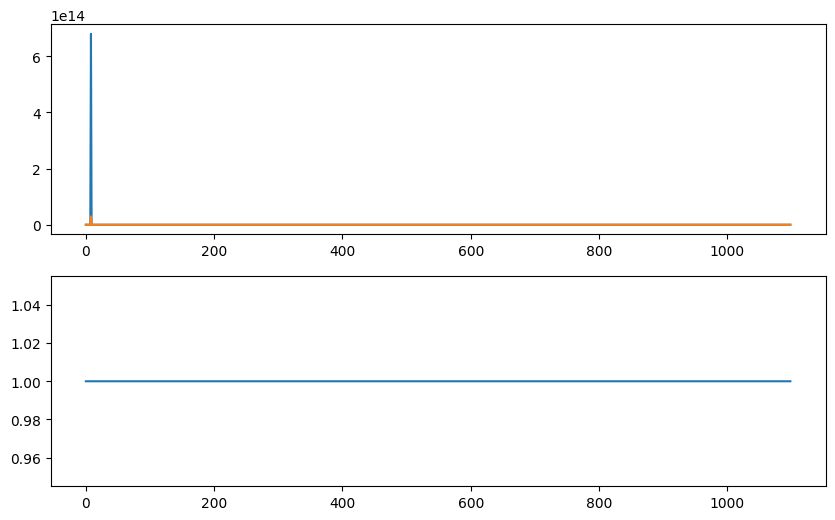

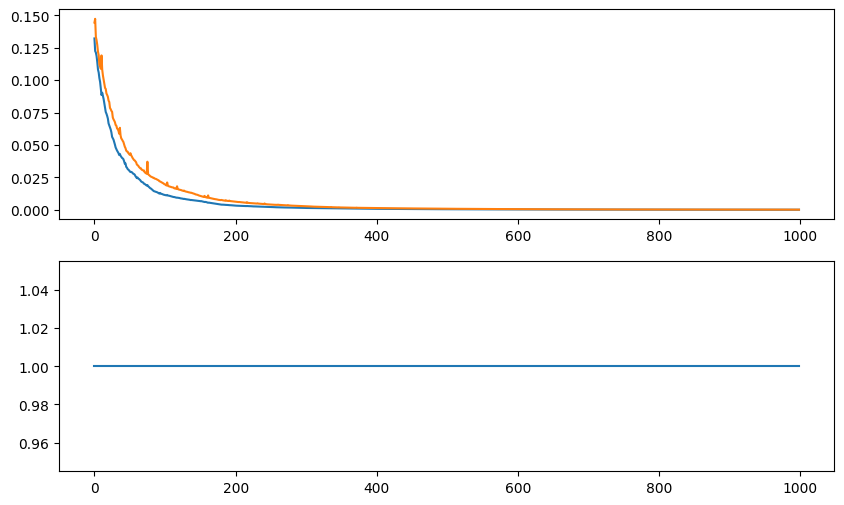

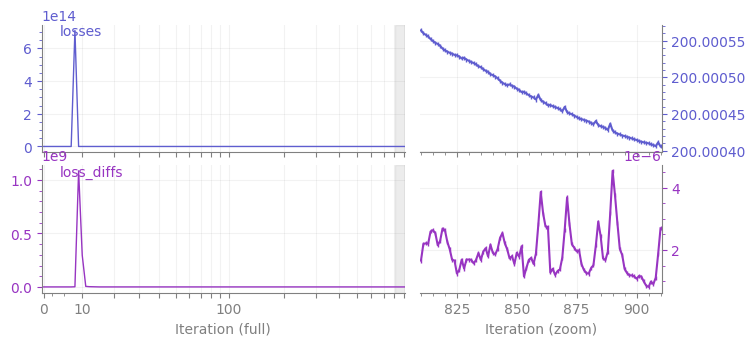

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [46]:
optmzr.plot()

In [47]:
X = np.array(loss_data)

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

In [48]:
X = np.array(loss_data)[100:]

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

## 3

In [49]:
loss_data=list()

In [50]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': tnc,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 500,
        'losses': loss_data
    },
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='L-BFGS-B',               # supplied to scipy.minimize
)

In [51]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                             | 0/1000 [00:00<?, ?it/s]

+1520.015799785700 [best: +1520.015799785700] :   0%|     | 1/1000 [00:00<03:08,  5.29it/s]

+1495.847987636236 [best: +1495.847987636236] :   0%|     | 2/1000 [00:00<03:07,  5.33it/s]

+73628.839571735531 [best: +1495.847987636236] :   0%|    | 3/1000 [00:00<03:02,  5.47it/s]

+1377.778228667970 [best: +1377.778228667970] :   0%|     | 4/1000 [00:00<03:02,  5.47it/s]

+3145.779206865892 [best: +1377.778228667970] :   0%|     | 5/1000 [00:00<03:01,  5.49it/s]

+1335.330082278414 [best: +1335.330082278414] :   1%|     | 6/1000 [00:01<03:01,  5.47it/s]

+1333.559529409017 [best: +1333.559529409017] :   1%|     | 7/1000 [00:01<03:04,  5.38it/s]

+1323.521653423839 [best: +1323.521653423839] :   1%|     | 8/1000 [00:01<03:03,  5.41it/s]

+709892338716056.250000000000 [best: +1323.521653423839] :   1%| | 9/1000 [00:01<03:02,  5.

+22271808.020210832357 [best: +1323.521653423839] :   1%| | 10/1000 [00:01<03:01,  5.45it/s

+2694.071822856862 [best: +1323.521653423839] :   1%|    | 11/1000 [00:02<03:00,  5.47it/s]

+1236.012724470560 [best: +1236.012724470560] :   1%|    | 12/1000 [00:02<03:02,  5.42it/s]

+496803.701942994434 [best: +1236.012724470560] :   1%|  | 13/1000 [00:02<03:05,  5.33it/s]

+1614.202931441437 [best: +1236.012724470560] :   1%|    | 14/1000 [00:02<03:05,  5.32it/s]

+1204.922843545976 [best: +1204.922843545976] :   2%|    | 15/1000 [00:02<03:13,  5.09it/s]

+1169.075041235955 [best: +1169.075041235955] :   2%|    | 16/1000 [00:03<03:22,  4.87it/s]

+1110.054963248202 [best: +1110.054963248202] :   2%|    | 17/1000 [00:03<03:14,  5.06it/s]

+1058.733771562420 [best: +1058.733771562420] :   2%|    | 18/1000 [00:03<03:08,  5.21it/s]

+1025.944450512432 [best: +1025.944450512432] :   2%|    | 19/1000 [00:03<03:07,  5.24it/s]

+1002.973744585870 [best: +1002.973744585870] :   2%|    | 20/1000 [00:03<03:05,  5.28it/s]

+984.322837543365 [best: +984.322837543365] :   2%|▏     | 21/1000 [00:03<03:07,  5.23it/s]

+974.223240222564 [best: +974.223240222564] :   2%|▏     | 22/1000 [00:04<03:05,  5.28it/s]

+967.355359500956 [best: +967.355359500956] :   2%|▏     | 23/1000 [00:04<03:03,  5.34it/s]

+953.691906507056 [best: +953.691906507056] :   2%|▏     | 24/1000 [00:04<03:00,  5.41it/s]

+933.769647732712 [best: +933.769647732712] :   2%|▏     | 25/1000 [00:04<02:58,  5.46it/s]

+909.442728994171 [best: +909.442728994171] :   3%|▏     | 26/1000 [00:04<02:57,  5.49it/s]

+879.624647022710 [best: +879.624647022710] :   3%|▏     | 27/1000 [00:05<02:59,  5.41it/s]

+849.384521081683 [best: +849.384521081683] :   3%|▏     | 28/1000 [00:05<03:01,  5.36it/s]

+827.454004940296 [best: +827.454004940296] :   3%|▏     | 29/1000 [00:05<02:58,  5.45it/s]

+808.745610565140 [best: +808.745610565140] :   3%|▏     | 30/1000 [00:05<02:57,  5.47it/s]

+788.683701638749 [best: +788.683701638749] :   3%|▏     | 31/1000 [00:05<02:54,  5.54it/s]

+834.775874242614 [best: +788.683701638749] :   3%|▏     | 32/1000 [00:05<02:54,  5.55it/s]

+774.306064414432 [best: +774.306064414432] :   3%|▏     | 33/1000 [00:06<02:54,  5.53it/s]

+747.952990614207 [best: +747.952990614207] :   3%|▏     | 34/1000 [00:06<02:55,  5.50it/s]

+723.278577519881 [best: +723.278577519881] :   4%|▏     | 35/1000 [00:06<02:54,  5.53it/s]

+696.653658703624 [best: +696.653658703624] :   4%|▏     | 36/1000 [00:06<02:52,  5.58it/s]

+663.644478851498 [best: +663.644478851498] :   4%|▏     | 37/1000 [00:06<02:54,  5.51it/s]

+642.358309506040 [best: +642.358309506040] :   4%|▏     | 38/1000 [00:07<02:57,  5.41it/s]

+616.630838628948 [best: +616.630838628948] :   4%|▏     | 39/1000 [00:07<02:56,  5.44it/s]

+601.281063560540 [best: +601.281063560540] :   4%|▏     | 40/1000 [00:07<02:54,  5.51it/s]

+581.532084860368 [best: +581.532084860368] :   4%|▏     | 41/1000 [00:07<02:55,  5.47it/s]

+563.472612626546 [best: +563.472612626546] :   4%|▎     | 42/1000 [00:07<02:53,  5.52it/s]

+547.218145313859 [best: +547.218145313859] :   4%|▎     | 43/1000 [00:07<02:51,  5.57it/s]

+538.017210820894 [best: +538.017210820894] :   4%|▎     | 44/1000 [00:08<02:51,  5.57it/s]

+529.779775098279 [best: +529.779775098279] :   4%|▎     | 45/1000 [00:08<02:51,  5.56it/s]

+521.849509731160 [best: +521.849509731160] :   5%|▎     | 46/1000 [00:08<02:51,  5.58it/s]

+518.691781438877 [best: +518.691781438877] :   5%|▎     | 47/1000 [00:08<02:51,  5.56it/s]

+515.076986596218 [best: +515.076986596218] :   5%|▎     | 48/1000 [00:08<02:52,  5.53it/s]

+513.314668211865 [best: +513.314668211865] :   5%|▎     | 49/1000 [00:09<02:54,  5.47it/s]

+511.221267759696 [best: +511.221267759696] :   5%|▎     | 50/1000 [00:09<02:54,  5.44it/s]

+508.543610714209 [best: +508.543610714209] :   5%|▎     | 51/1000 [00:09<02:55,  5.42it/s]

+508.134026715332 [best: +508.134026715332] :   5%|▎     | 52/1000 [00:09<02:52,  5.49it/s]

+506.205998756744 [best: +506.205998756744] :   5%|▎     | 53/1000 [00:09<02:50,  5.54it/s]

+505.922738400200 [best: +505.922738400200] :   5%|▎     | 54/1000 [00:09<02:50,  5.53it/s]

+505.307063368098 [best: +505.307063368098] :   6%|▎     | 55/1000 [00:10<02:51,  5.49it/s]

+504.990104180210 [best: +504.990104180210] :   6%|▎     | 56/1000 [00:10<02:49,  5.56it/s]

+504.484897595951 [best: +504.484897595951] :   6%|▎     | 57/1000 [00:10<02:47,  5.62it/s]

+504.032557801178 [best: +504.032557801178] :   6%|▎     | 58/1000 [00:10<02:47,  5.61it/s]

+503.751364585574 [best: +503.751364585574] :   6%|▎     | 59/1000 [00:10<02:46,  5.65it/s]

+502.989569426844 [best: +502.989569426844] :   6%|▎     | 60/1000 [00:11<02:45,  5.69it/s]

+503.491596378190 [best: +502.989569426844] :   6%|▎     | 61/1000 [00:11<02:44,  5.69it/s]

+502.684087344774 [best: +502.684087344774] :   6%|▎     | 62/1000 [00:11<02:45,  5.66it/s]

+502.405458899899 [best: +502.405458899899] :   6%|▍     | 63/1000 [00:11<02:48,  5.57it/s]

+502.198167913195 [best: +502.198167913195] :   6%|▍     | 64/1000 [00:11<02:48,  5.56it/s]

+501.931562175212 [best: +501.931562175212] :   6%|▍     | 65/1000 [00:11<02:48,  5.56it/s]

+501.844740728463 [best: +501.844740728463] :   7%|▍     | 66/1000 [00:12<02:48,  5.55it/s]

+501.660320930882 [best: +501.660320930882] :   7%|▍     | 67/1000 [00:12<02:46,  5.59it/s]

+501.590048350657 [best: +501.590048350657] :   7%|▍     | 68/1000 [00:12<02:46,  5.60it/s]

+501.494479131169 [best: +501.494479131169] :   7%|▍     | 69/1000 [00:12<02:46,  5.59it/s]

+501.376620495833 [best: +501.376620495833] :   7%|▍     | 70/1000 [00:12<02:45,  5.62it/s]

+501.278919909481 [best: +501.278919909481] :   7%|▍     | 71/1000 [00:12<02:47,  5.56it/s]

+501.224149158208 [best: +501.224149158208] :   7%|▍     | 72/1000 [00:13<02:48,  5.52it/s]

+501.180935339175 [best: +501.180935339175] :   7%|▍     | 73/1000 [00:13<02:48,  5.49it/s]

+501.118404097892 [best: +501.118404097892] :   7%|▍     | 74/1000 [00:13<02:46,  5.56it/s]

+501.012873965707 [best: +501.012873965707] :   8%|▍     | 75/1000 [00:13<02:46,  5.57it/s]

+500.926094634604 [best: +500.926094634604] :   8%|▍     | 76/1000 [00:13<02:45,  5.58it/s]

+500.855415639340 [best: +500.855415639340] :   8%|▍     | 77/1000 [00:14<02:45,  5.57it/s]

+500.806422645556 [best: +500.806422645556] :   8%|▍     | 78/1000 [00:14<02:45,  5.56it/s]

+500.771270635303 [best: +500.771270635303] :   8%|▍     | 79/1000 [00:14<02:44,  5.59it/s]

+500.709863812319 [best: +500.709863812319] :   8%|▍     | 80/1000 [00:14<02:49,  5.42it/s]

+500.662637613727 [best: +500.662637613727] :   8%|▍     | 81/1000 [00:14<02:48,  5.44it/s]

+500.633454592486 [best: +500.633454592486] :   8%|▍     | 82/1000 [00:14<02:46,  5.50it/s]

+500.606885111414 [best: +500.606885111414] :   8%|▍     | 83/1000 [00:15<02:45,  5.53it/s]

+500.578674435809 [best: +500.578674435809] :   8%|▌     | 84/1000 [00:15<02:44,  5.57it/s]

+500.581368577247 [best: +500.578674435809] :   8%|▌     | 85/1000 [00:15<02:44,  5.57it/s]

+500.559975656784 [best: +500.559975656784] :   9%|▌     | 86/1000 [00:15<02:42,  5.62it/s]

+500.538952863100 [best: +500.538952863100] :   9%|▌     | 87/1000 [00:15<02:42,  5.63it/s]

+500.524293434853 [best: +500.524293434853] :   9%|▌     | 88/1000 [00:16<02:43,  5.59it/s]

+500.497905616007 [best: +500.497905616007] :   9%|▌     | 89/1000 [00:16<02:41,  5.63it/s]

+500.471771726546 [best: +500.471771726546] :   9%|▌     | 90/1000 [00:16<02:41,  5.63it/s]

+500.445081737065 [best: +500.445081737065] :   9%|▌     | 91/1000 [00:16<02:43,  5.57it/s]

+500.422811626052 [best: +500.422811626052] :   9%|▌     | 92/1000 [00:16<02:44,  5.51it/s]

+500.397342425702 [best: +500.397342425702] :   9%|▌     | 93/1000 [00:16<02:44,  5.50it/s]

+500.368645158432 [best: +500.368645158432] :   9%|▌     | 94/1000 [00:17<02:42,  5.56it/s]

+500.347468263607 [best: +500.347468263607] :  10%|▌     | 95/1000 [00:17<02:43,  5.55it/s]

+500.329709342675 [best: +500.329709342675] :  10%|▌     | 96/1000 [00:17<02:43,  5.53it/s]

+500.315490470232 [best: +500.315490470232] :  10%|▌     | 97/1000 [00:17<02:46,  5.43it/s]

+500.303334685948 [best: +500.303334685948] :  10%|▌     | 98/1000 [00:17<02:48,  5.36it/s]

+500.292691796737 [best: +500.292691796737] :  10%|▌     | 99/1000 [00:18<02:47,  5.37it/s]

+500.287349133905 [best: +500.287349133905] :  10%|▌    | 100/1000 [00:18<02:45,  5.44it/s]

+500.276703642534 [best: +500.276703642534] :  10%|▌    | 101/1000 [00:18<02:43,  5.50it/s]

+500.269875797227 [best: +500.269875797227] :  10%|▌    | 102/1000 [00:18<02:43,  5.50it/s]

+500.254683960772 [best: +500.254683960772] :  10%|▌    | 103/1000 [00:18<02:42,  5.51it/s]

+500.249575925989 [best: +500.249575925989] :  10%|▌    | 104/1000 [00:18<02:42,  5.53it/s]

+500.241179466428 [best: +500.241179466428] :  10%|▌    | 105/1000 [00:19<02:43,  5.49it/s]

+500.230166896691 [best: +500.230166896691] :  11%|▌    | 106/1000 [00:19<02:42,  5.49it/s]

+500.225438913402 [best: +500.225438913402] :  11%|▌    | 107/1000 [00:19<02:43,  5.46it/s]

+500.213468372502 [best: +500.213468372502] :  11%|▌    | 108/1000 [00:19<02:41,  5.52it/s]

+500.209714912248 [best: +500.209714912248] :  11%|▌    | 109/1000 [00:19<02:42,  5.48it/s]

+500.202356532565 [best: +500.202356532565] :  11%|▌    | 110/1000 [00:20<02:42,  5.46it/s]

+500.207694168818 [best: +500.202356532565] :  11%|▌    | 111/1000 [00:20<02:40,  5.54it/s]

+500.198559830123 [best: +500.198559830123] :  11%|▌    | 112/1000 [00:20<02:40,  5.54it/s]

+500.191671052604 [best: +500.191671052604] :  11%|▌    | 113/1000 [00:20<02:41,  5.48it/s]

+500.185801612591 [best: +500.185801612591] :  11%|▌    | 114/1000 [00:20<02:42,  5.46it/s]

+500.179364992060 [best: +500.179364992060] :  12%|▌    | 115/1000 [00:20<02:43,  5.42it/s]

+500.172748188359 [best: +500.172748188359] :  12%|▌    | 116/1000 [00:21<02:41,  5.47it/s]

+500.168718278539 [best: +500.168718278539] :  12%|▌    | 117/1000 [00:21<02:40,  5.49it/s]

+500.163940577459 [best: +500.163940577459] :  12%|▌    | 118/1000 [00:21<02:40,  5.51it/s]

+500.161109870323 [best: +500.161109870323] :  12%|▌    | 119/1000 [00:21<02:40,  5.50it/s]

+500.157719796738 [best: +500.157719796738] :  12%|▌    | 120/1000 [00:21<02:41,  5.43it/s]

+500.150975388331 [best: +500.150975388331] :  12%|▌    | 121/1000 [00:22<02:41,  5.44it/s]

+500.148236876634 [best: +500.148236876634] :  12%|▌    | 122/1000 [00:22<02:38,  5.54it/s]

+500.142044073621 [best: +500.142044073621] :  12%|▌    | 123/1000 [00:22<02:40,  5.48it/s]

+500.139717087594 [best: +500.139717087594] :  12%|▌    | 124/1000 [00:22<02:39,  5.50it/s]

+500.136152235722 [best: +500.136152235722] :  12%|▋    | 125/1000 [00:22<02:38,  5.52it/s]

+500.131986562568 [best: +500.131986562568] :  13%|▋    | 126/1000 [00:22<02:39,  5.46it/s]

+500.126526900349 [best: +500.126526900349] :  13%|▋    | 127/1000 [00:23<02:38,  5.49it/s]

+500.123959653941 [best: +500.123959653941] :  13%|▋    | 128/1000 [00:23<02:38,  5.52it/s]

+500.121128416354 [best: +500.121128416354] :  13%|▋    | 129/1000 [00:23<02:36,  5.56it/s]

+500.117989232347 [best: +500.117989232347] :  13%|▋    | 130/1000 [00:23<02:38,  5.50it/s]

+500.113620823155 [best: +500.113620823155] :  13%|▋    | 131/1000 [00:23<02:39,  5.44it/s]

+500.111804691089 [best: +500.111804691089] :  13%|▋    | 132/1000 [00:24<02:37,  5.52it/s]

+500.108561669518 [best: +500.108561669518] :  13%|▋    | 133/1000 [00:24<02:38,  5.46it/s]

+500.107024460368 [best: +500.107024460368] :  13%|▋    | 134/1000 [00:24<02:38,  5.47it/s]

+500.104905110192 [best: +500.104905110192] :  14%|▋    | 135/1000 [00:24<02:37,  5.49it/s]

+500.101066727600 [best: +500.101066727600] :  14%|▋    | 136/1000 [00:24<02:36,  5.52it/s]

+500.106470330644 [best: +500.101066727600] :  14%|▋    | 137/1000 [00:24<02:37,  5.49it/s]

+500.099073342737 [best: +500.099073342737] :  14%|▋    | 138/1000 [00:25<02:35,  5.54it/s]

+500.096008843372 [best: +500.096008843372] :  14%|▋    | 139/1000 [00:25<02:34,  5.58it/s]

+500.094462220523 [best: +500.094462220523] :  14%|▋    | 140/1000 [00:25<02:34,  5.57it/s]

+500.092959529076 [best: +500.092959529076] :  14%|▋    | 141/1000 [00:25<02:38,  5.41it/s]

+500.091471565198 [best: +500.091471565198] :  14%|▋    | 142/1000 [00:25<02:38,  5.43it/s]

+500.088049702419 [best: +500.088049702419] :  14%|▋    | 143/1000 [00:26<02:38,  5.40it/s]

+500.084317609105 [best: +500.084317609105] :  14%|▋    | 144/1000 [00:26<03:38,  3.92it/s]

+500.083472027117 [best: +500.083472027117] :  14%|▋    | 145/1000 [00:26<03:19,  4.29it/s]

+500.078879516547 [best: +500.078879516547] :  15%|▋    | 146/1000 [00:26<03:06,  4.59it/s]

+500.077665195543 [best: +500.077665195543] :  15%|▋    | 147/1000 [00:27<02:54,  4.87it/s]

+500.076458351125 [best: +500.076458351125] :  15%|▋    | 148/1000 [00:27<02:48,  5.05it/s]

+500.074750428393 [best: +500.074750428393] :  15%|▋    | 149/1000 [00:27<02:47,  5.08it/s]

+500.073707941711 [best: +500.073707941711] :  15%|▊    | 150/1000 [00:27<02:43,  5.20it/s]

+500.072181261560 [best: +500.072181261560] :  15%|▊    | 151/1000 [00:27<02:40,  5.29it/s]

+500.072865433831 [best: +500.072181261560] :  15%|▊    | 152/1000 [00:27<02:38,  5.35it/s]

+500.071452918568 [best: +500.071452918568] :  15%|▊    | 153/1000 [00:28<02:36,  5.43it/s]

+500.070217093278 [best: +500.070217093278] :  15%|▊    | 154/1000 [00:28<02:34,  5.48it/s]

+500.068509244210 [best: +500.068509244210] :  16%|▊    | 155/1000 [00:28<02:33,  5.49it/s]

+500.067167647280 [best: +500.067167647280] :  16%|▊    | 156/1000 [00:28<02:35,  5.44it/s]

+500.066118805748 [best: +500.066118805748] :  16%|▊    | 157/1000 [00:28<02:35,  5.44it/s]

+500.065320206396 [best: +500.065320206396] :  16%|▊    | 158/1000 [00:29<02:33,  5.47it/s]

+500.063560705287 [best: +500.063560705287] :  16%|▊    | 159/1000 [00:29<02:33,  5.47it/s]

+500.062122534668 [best: +500.062122534668] :  16%|▊    | 160/1000 [00:29<02:31,  5.54it/s]

+500.059597166690 [best: +500.059597166690] :  16%|▊    | 161/1000 [00:29<02:32,  5.52it/s]

+500.059521447440 [best: +500.059521447440] :  16%|▊    | 162/1000 [00:29<02:33,  5.46it/s]

+500.058249992260 [best: +500.058249992260] :  16%|▊    | 163/1000 [00:29<02:32,  5.48it/s]

+500.057013849287 [best: +500.057013849287] :  16%|▊    | 164/1000 [00:30<02:33,  5.46it/s]

+500.055958318361 [best: +500.055958318361] :  16%|▊    | 165/1000 [00:30<02:33,  5.45it/s]

+500.054839026205 [best: +500.054839026205] :  17%|▊    | 166/1000 [00:30<02:31,  5.50it/s]

+500.053949023110 [best: +500.053949023110] :  17%|▊    | 167/1000 [00:30<02:30,  5.54it/s]

+500.052551354726 [best: +500.052551354726] :  17%|▊    | 168/1000 [00:30<02:29,  5.58it/s]

+500.052067001055 [best: +500.052067001055] :  17%|▊    | 169/1000 [00:31<02:30,  5.53it/s]

+500.051503963718 [best: +500.051503963718] :  17%|▊    | 170/1000 [00:31<02:29,  5.54it/s]

+500.050635675006 [best: +500.050635675006] :  17%|▊    | 171/1000 [00:31<02:29,  5.53it/s]

+500.049213722396 [best: +500.049213722396] :  17%|▊    | 172/1000 [00:31<02:30,  5.51it/s]

+500.048237036787 [best: +500.048237036787] :  17%|▊    | 173/1000 [00:31<02:28,  5.55it/s]

+500.047592270996 [best: +500.047592270996] :  17%|▊    | 174/1000 [00:31<02:32,  5.40it/s]

+500.046530910751 [best: +500.046530910751] :  18%|▉    | 175/1000 [00:32<02:34,  5.33it/s]

+500.056291618580 [best: +500.046530910751] :  18%|▉    | 176/1000 [00:32<02:35,  5.30it/s]

+500.045989982415 [best: +500.045989982415] :  18%|▉    | 177/1000 [00:32<02:33,  5.37it/s]

+500.044706191818 [best: +500.044706191818] :  18%|▉    | 178/1000 [00:32<02:33,  5.36it/s]

+500.043897077183 [best: +500.043897077183] :  18%|▉    | 179/1000 [00:32<02:33,  5.36it/s]

+500.042762879177 [best: +500.042762879177] :  18%|▉    | 180/1000 [00:33<02:31,  5.41it/s]

+500.042089411039 [best: +500.042089411039] :  18%|▉    | 181/1000 [00:33<02:31,  5.42it/s]

+500.041367275089 [best: +500.041367275089] :  18%|▉    | 182/1000 [00:33<02:30,  5.43it/s]

+500.040692785113 [best: +500.040692785113] :  18%|▉    | 183/1000 [00:33<02:29,  5.47it/s]

+500.039747514147 [best: +500.039747514147] :  18%|▉    | 184/1000 [00:33<02:29,  5.47it/s]

+500.039266948976 [best: +500.039266948976] :  18%|▉    | 185/1000 [00:33<02:28,  5.47it/s]

+500.038533849501 [best: +500.038533849501] :  19%|▉    | 186/1000 [00:34<02:27,  5.51it/s]

+500.038200871418 [best: +500.038200871418] :  19%|▉    | 187/1000 [00:34<02:26,  5.55it/s]

+500.037773087221 [best: +500.037773087221] :  19%|▉    | 188/1000 [00:34<02:26,  5.53it/s]

+500.037361116316 [best: +500.037361116316] :  19%|▉    | 189/1000 [00:34<02:29,  5.43it/s]

+500.036818511221 [best: +500.036818511221] :  19%|▉    | 190/1000 [00:34<02:32,  5.30it/s]

+500.036268728001 [best: +500.036268728001] :  19%|▉    | 191/1000 [00:35<02:30,  5.39it/s]

+500.035641367276 [best: +500.035641367276] :  19%|▉    | 192/1000 [00:35<02:28,  5.44it/s]

+500.034610930152 [best: +500.034610930152] :  19%|▉    | 193/1000 [00:35<02:26,  5.50it/s]

+500.034966609419 [best: +500.034610930152] :  19%|▉    | 194/1000 [00:35<02:26,  5.49it/s]

+500.034117705122 [best: +500.034117705122] :  20%|▉    | 195/1000 [00:35<02:25,  5.54it/s]

+500.033606268756 [best: +500.033606268756] :  20%|▉    | 196/1000 [00:35<02:24,  5.55it/s]

+500.033138291507 [best: +500.033138291507] :  20%|▉    | 197/1000 [00:36<02:25,  5.51it/s]

+500.032476063507 [best: +500.032476063507] :  20%|▉    | 198/1000 [00:36<02:25,  5.51it/s]

+500.032024896475 [best: +500.032024896475] :  20%|▉    | 199/1000 [00:36<02:26,  5.48it/s]

+500.031393910961 [best: +500.031393910961] :  20%|█    | 200/1000 [00:36<02:25,  5.52it/s]

+500.031037245250 [best: +500.031037245250] :  20%|█    | 201/1000 [00:36<02:25,  5.48it/s]

+500.030740828962 [best: +500.030740828962] :  20%|█    | 202/1000 [00:37<02:25,  5.47it/s]

+500.029964368597 [best: +500.029964368597] :  20%|█    | 203/1000 [00:37<02:25,  5.48it/s]

+500.032535892342 [best: +500.029964368597] :  20%|█    | 204/1000 [00:37<02:23,  5.53it/s]

+500.029704251163 [best: +500.029704251163] :  20%|█    | 205/1000 [00:37<02:23,  5.52it/s]

+500.029272391987 [best: +500.029272391987] :  21%|█    | 206/1000 [00:37<02:25,  5.45it/s]

+500.028951088450 [best: +500.028951088450] :  21%|█    | 207/1000 [00:38<02:24,  5.50it/s]

+500.028599984408 [best: +500.028599984408] :  21%|█    | 208/1000 [00:38<02:23,  5.50it/s]

+500.028292836399 [best: +500.028292836399] :  21%|█    | 209/1000 [00:38<02:21,  5.59it/s]

+500.027960533991 [best: +500.027960533991] :  21%|█    | 210/1000 [00:38<02:22,  5.55it/s]

+500.027624464441 [best: +500.027624464441] :  21%|█    | 211/1000 [00:38<02:21,  5.57it/s]

+500.027418785866 [best: +500.027418785866] :  21%|█    | 212/1000 [00:38<02:21,  5.58it/s]

+500.027168652828 [best: +500.027168652828] :  21%|█    | 213/1000 [00:39<02:22,  5.54it/s]

+500.026529526261 [best: +500.026529526261] :  21%|█    | 214/1000 [00:39<02:22,  5.50it/s]

+500.026317657047 [best: +500.026317657047] :  22%|█    | 215/1000 [00:39<02:22,  5.50it/s]

+500.026019455965 [best: +500.026019455965] :  22%|█    | 216/1000 [00:39<02:21,  5.56it/s]

+500.025614100114 [best: +500.025614100114] :  22%|█    | 217/1000 [00:39<02:22,  5.51it/s]

+500.027617420353 [best: +500.025614100114] :  22%|█    | 218/1000 [00:39<02:20,  5.56it/s]

+500.025446288429 [best: +500.025446288429] :  22%|█    | 219/1000 [00:40<02:20,  5.54it/s]

+500.025059881580 [best: +500.025059881580] :  22%|█    | 220/1000 [00:40<02:19,  5.57it/s]

+500.024851644915 [best: +500.024851644915] :  22%|█    | 221/1000 [00:40<02:20,  5.55it/s]

+500.024559022712 [best: +500.024559022712] :  22%|█    | 222/1000 [00:40<02:21,  5.48it/s]

+500.024328701694 [best: +500.024328701694] :  22%|█    | 223/1000 [00:40<02:20,  5.53it/s]

+500.024040426579 [best: +500.024040426579] :  22%|█    | 224/1000 [00:41<02:21,  5.48it/s]

+500.023638273222 [best: +500.023638273222] :  22%|█▏   | 225/1000 [00:41<02:19,  5.57it/s]

+500.023434420717 [best: +500.023434420717] :  23%|█▏   | 226/1000 [00:41<02:20,  5.52it/s]

+500.022974896802 [best: +500.022974896802] :  23%|█▏   | 227/1000 [00:41<02:19,  5.52it/s]

+500.023129319336 [best: +500.022974896802] :  23%|█▏   | 228/1000 [00:41<02:20,  5.50it/s]

+500.022720407555 [best: +500.022720407555] :  23%|█▏   | 229/1000 [00:41<02:21,  5.47it/s]

+500.022490849115 [best: +500.022490849115] :  23%|█▏   | 230/1000 [00:42<02:21,  5.45it/s]

+500.022205073213 [best: +500.022205073213] :  23%|█▏   | 231/1000 [00:42<02:19,  5.51it/s]

+500.022042852036 [best: +500.022042852036] :  23%|█▏   | 232/1000 [00:42<02:24,  5.31it/s]

+500.021759890473 [best: +500.021759890473] :  23%|█▏   | 233/1000 [00:42<02:22,  5.40it/s]

+500.021484459297 [best: +500.021484459297] :  23%|█▏   | 234/1000 [00:42<02:20,  5.44it/s]

+500.021321063884 [best: +500.021321063884] :  24%|█▏   | 235/1000 [00:43<02:20,  5.45it/s]

+500.021048387977 [best: +500.021048387977] :  24%|█▏   | 236/1000 [00:43<02:20,  5.44it/s]

+500.020591859033 [best: +500.020591859033] :  24%|█▏   | 237/1000 [00:43<02:19,  5.47it/s]

+500.021841126813 [best: +500.020591859033] :  24%|█▏   | 238/1000 [00:43<02:18,  5.51it/s]

+500.020444748984 [best: +500.020444748984] :  24%|█▏   | 239/1000 [00:43<02:18,  5.49it/s]

+500.020097233327 [best: +500.020097233327] :  24%|█▏   | 240/1000 [00:44<02:18,  5.49it/s]

+500.019840058120 [best: +500.019840058120] :  24%|█▏   | 241/1000 [00:44<02:19,  5.44it/s]

+500.019504345701 [best: +500.019504345701] :  24%|█▏   | 242/1000 [00:44<02:18,  5.48it/s]

+500.019221703699 [best: +500.019221703699] :  24%|█▏   | 243/1000 [00:44<02:16,  5.53it/s]

+500.019002726013 [best: +500.019002726013] :  24%|█▏   | 244/1000 [00:44<02:16,  5.53it/s]

+500.018786468932 [best: +500.018786468932] :  24%|█▏   | 245/1000 [00:44<02:16,  5.55it/s]

+500.018569134965 [best: +500.018569134965] :  25%|█▏   | 246/1000 [00:45<02:15,  5.56it/s]

+500.018257660468 [best: +500.018257660468] :  25%|█▏   | 247/1000 [00:45<02:15,  5.56it/s]

+500.017934117158 [best: +500.017934117158] :  25%|█▏   | 248/1000 [00:45<02:14,  5.58it/s]

+500.017644511819 [best: +500.017644511819] :  25%|█▏   | 249/1000 [00:45<02:14,  5.59it/s]

+500.017316302516 [best: +500.017316302516] :  25%|█▎   | 250/1000 [00:45<02:16,  5.51it/s]

+500.016925937762 [best: +500.016925937762] :  25%|█▎   | 251/1000 [00:45<02:14,  5.55it/s]

+500.016512738161 [best: +500.016512738161] :  25%|█▎   | 252/1000 [00:46<02:14,  5.58it/s]

+500.016306989457 [best: +500.016306989457] :  25%|█▎   | 253/1000 [00:46<02:13,  5.58it/s]

+500.015914443450 [best: +500.015914443450] :  25%|█▎   | 254/1000 [00:46<02:13,  5.61it/s]

+500.015558120014 [best: +500.015558120014] :  26%|█▎   | 255/1000 [00:46<02:13,  5.60it/s]

+500.015256208740 [best: +500.015256208740] :  26%|█▎   | 256/1000 [00:46<02:13,  5.58it/s]

+500.014975165204 [best: +500.014975165204] :  26%|█▎   | 257/1000 [00:47<02:13,  5.57it/s]

+500.014766945945 [best: +500.014766945945] :  26%|█▎   | 258/1000 [00:47<02:12,  5.59it/s]

+500.014577120116 [best: +500.014577120116] :  26%|█▎   | 259/1000 [00:47<02:12,  5.59it/s]

+500.014307629138 [best: +500.014307629138] :  26%|█▎   | 260/1000 [00:47<02:12,  5.57it/s]

+500.014130764364 [best: +500.014130764364] :  26%|█▎   | 261/1000 [00:47<02:15,  5.45it/s]

+500.013941597433 [best: +500.013941597433] :  26%|█▎   | 262/1000 [00:47<02:15,  5.44it/s]

+500.013887417667 [best: +500.013887417667] :  26%|█▎   | 263/1000 [00:48<02:12,  5.55it/s]

+500.013740977675 [best: +500.013740977675] :  26%|█▎   | 264/1000 [00:48<02:13,  5.52it/s]

+500.013635757306 [best: +500.013635757306] :  26%|█▎   | 265/1000 [00:48<02:12,  5.55it/s]

+500.013522742930 [best: +500.013522742930] :  27%|█▎   | 266/1000 [00:48<02:16,  5.38it/s]

+500.013288670468 [best: +500.013288670468] :  27%|█▎   | 267/1000 [00:48<02:18,  5.31it/s]

+500.012974060069 [best: +500.012974060069] :  27%|█▎   | 268/1000 [00:49<02:15,  5.41it/s]

+500.012805950550 [best: +500.012805950550] :  27%|█▎   | 269/1000 [00:49<02:13,  5.48it/s]

+500.012564166273 [best: +500.012564166273] :  27%|█▎   | 270/1000 [00:49<02:11,  5.55it/s]

+500.012446728207 [best: +500.012446728207] :  27%|█▎   | 271/1000 [00:49<02:12,  5.51it/s]

+500.012265096097 [best: +500.012265096097] :  27%|█▎   | 272/1000 [00:49<02:12,  5.49it/s]

+500.012100691085 [best: +500.012100691085] :  27%|█▎   | 273/1000 [00:49<02:13,  5.45it/s]

+500.011892591945 [best: +500.011892591945] :  27%|█▎   | 274/1000 [00:50<02:15,  5.36it/s]

+500.011730865509 [best: +500.011730865509] :  28%|█▍   | 275/1000 [00:50<02:14,  5.40it/s]

+500.011605693956 [best: +500.011605693956] :  28%|█▍   | 276/1000 [00:50<02:14,  5.37it/s]

+500.011788788524 [best: +500.011605693956] :  28%|█▍   | 277/1000 [00:50<02:15,  5.32it/s]

+500.011507071587 [best: +500.011507071587] :  28%|█▍   | 278/1000 [00:50<02:14,  5.36it/s]

+500.011324495491 [best: +500.011324495491] :  28%|█▍   | 279/1000 [00:51<02:12,  5.43it/s]

+500.011195922585 [best: +500.011195922585] :  28%|█▍   | 280/1000 [00:51<02:13,  5.39it/s]

+500.011057984443 [best: +500.011057984443] :  28%|█▍   | 281/1000 [00:51<02:17,  5.22it/s]

+500.010893657800 [best: +500.010893657800] :  28%|█▍   | 282/1000 [00:51<02:20,  5.10it/s]

+500.010769487913 [best: +500.010769487913] :  28%|█▍   | 283/1000 [00:51<02:26,  4.91it/s]

+500.010568100616 [best: +500.010568100616] :  28%|█▍   | 284/1000 [00:52<02:26,  4.90it/s]

+500.010476518818 [best: +500.010476518818] :  28%|█▍   | 285/1000 [00:52<02:22,  5.02it/s]

+500.010363678676 [best: +500.010363678676] :  29%|█▍   | 286/1000 [00:52<02:19,  5.12it/s]

+500.010353071836 [best: +500.010353071836] :  29%|█▍   | 287/1000 [00:52<02:18,  5.15it/s]

+500.010286888593 [best: +500.010286888593] :  29%|█▍   | 288/1000 [00:52<02:19,  5.10it/s]

+500.010165749499 [best: +500.010165749499] :  29%|█▍   | 289/1000 [00:53<02:19,  5.10it/s]

+500.010020511904 [best: +500.010020511904] :  29%|█▍   | 290/1000 [00:53<02:21,  5.02it/s]

+500.009920232858 [best: +500.009920232858] :  29%|█▍   | 291/1000 [00:53<02:21,  5.02it/s]

+500.009805520638 [best: +500.009805520638] :  29%|█▍   | 292/1000 [00:53<02:16,  5.19it/s]

+500.009698746509 [best: +500.009698746509] :  29%|█▍   | 293/1000 [00:53<02:13,  5.30it/s]

+500.009593715589 [best: +500.009593715589] :  29%|█▍   | 294/1000 [00:54<02:11,  5.38it/s]

+500.009475348560 [best: +500.009475348560] :  30%|█▍   | 295/1000 [00:54<02:13,  5.26it/s]

+500.009326376923 [best: +500.009326376923] :  30%|█▍   | 296/1000 [00:54<02:16,  5.17it/s]

+500.009347055802 [best: +500.009326376923] :  30%|█▍   | 297/1000 [00:54<03:10,  3.69it/s]

+500.009256918018 [best: +500.009256918018] :  30%|█▍   | 298/1000 [00:55<02:54,  4.03it/s]

+500.009162497829 [best: +500.009162497829] :  30%|█▍   | 299/1000 [00:55<02:39,  4.40it/s]

+500.009082064524 [best: +500.009082064524] :  30%|█▌   | 300/1000 [00:55<02:29,  4.68it/s]

+500.008977075726 [best: +500.008977075726] :  30%|█▌   | 301/1000 [00:55<02:29,  4.67it/s]

+500.008907136303 [best: +500.008907136303] :  30%|█▌   | 302/1000 [00:55<02:24,  4.84it/s]

+500.008805775142 [best: +500.008805775142] :  30%|█▌   | 303/1000 [00:56<02:21,  4.92it/s]

+500.008754853945 [best: +500.008754853945] :  30%|█▌   | 304/1000 [00:56<02:19,  5.00it/s]

+500.008687500075 [best: +500.008687500075] :  30%|█▌   | 305/1000 [00:56<02:17,  5.07it/s]

+500.008627025192 [best: +500.008627025192] :  31%|█▌   | 306/1000 [00:56<02:16,  5.08it/s]

+500.008570150464 [best: +500.008570150464] :  31%|█▌   | 307/1000 [00:56<02:15,  5.10it/s]

+500.008480692467 [best: +500.008480692467] :  31%|█▌   | 308/1000 [00:57<02:19,  4.97it/s]

+500.008403766347 [best: +500.008403766347] :  31%|█▌   | 309/1000 [00:57<02:14,  5.12it/s]

+500.008259659700 [best: +500.008259659700] :  31%|█▌   | 310/1000 [00:57<02:13,  5.18it/s]

+500.008230825947 [best: +500.008230825947] :  31%|█▌   | 311/1000 [00:57<02:15,  5.08it/s]

+500.008082972459 [best: +500.008082972459] :  31%|█▌   | 312/1000 [00:57<02:16,  5.04it/s]

+500.008036229199 [best: +500.008036229199] :  31%|█▌   | 313/1000 [00:57<02:14,  5.10it/s]

+500.007940085868 [best: +500.007940085868] :  31%|█▌   | 314/1000 [00:58<02:12,  5.17it/s]

+500.007904463761 [best: +500.007904463761] :  32%|█▌   | 315/1000 [00:58<02:12,  5.19it/s]

+500.007782089549 [best: +500.007782089549] :  32%|█▌   | 316/1000 [00:58<02:11,  5.21it/s]

+500.007732806698 [best: +500.007732806698] :  32%|█▌   | 317/1000 [00:58<02:08,  5.30it/s]

+500.007662274895 [best: +500.007662274895] :  32%|█▌   | 318/1000 [00:58<02:16,  5.00it/s]

+500.007626868256 [best: +500.007626868256] :  32%|█▌   | 319/1000 [00:59<02:26,  4.64it/s]

+500.007521221324 [best: +500.007521221324] :  32%|█▌   | 320/1000 [00:59<02:26,  4.64it/s]

+500.007474236397 [best: +500.007474236397] :  32%|█▌   | 321/1000 [00:59<02:21,  4.80it/s]

+500.007385385073 [best: +500.007385385073] :  32%|█▌   | 322/1000 [00:59<02:18,  4.88it/s]

+500.007423661970 [best: +500.007385385073] :  32%|█▌   | 323/1000 [01:00<02:15,  4.99it/s]

+500.007333204561 [best: +500.007333204561] :  32%|█▌   | 324/1000 [01:00<02:13,  5.06it/s]

+500.007244891806 [best: +500.007244891806] :  32%|█▋   | 325/1000 [01:00<02:10,  5.16it/s]

+500.007160829805 [best: +500.007160829805] :  33%|█▋   | 326/1000 [01:00<02:07,  5.27it/s]

+500.007080472497 [best: +500.007080472497] :  33%|█▋   | 327/1000 [01:00<02:06,  5.32it/s]

+500.007007520617 [best: +500.007007520617] :  33%|█▋   | 328/1000 [01:00<02:06,  5.29it/s]

+500.006916304111 [best: +500.006916304111] :  33%|█▋   | 329/1000 [01:01<02:07,  5.25it/s]

+500.006859358566 [best: +500.006859358566] :  33%|█▋   | 330/1000 [01:01<02:05,  5.32it/s]

+500.006801240943 [best: +500.006801240943] :  33%|█▋   | 331/1000 [01:01<02:04,  5.37it/s]

+500.006698571031 [best: +500.006698571031] :  33%|█▋   | 332/1000 [01:01<02:03,  5.39it/s]

+500.006620620421 [best: +500.006620620421] :  33%|█▋   | 333/1000 [01:01<02:02,  5.45it/s]

+500.006836964165 [best: +500.006620620421] :  33%|█▋   | 334/1000 [01:02<02:01,  5.46it/s]

+500.006571681191 [best: +500.006571681191] :  34%|█▋   | 335/1000 [01:02<02:05,  5.29it/s]

+500.006475999907 [best: +500.006475999907] :  34%|█▋   | 336/1000 [01:02<02:09,  5.12it/s]

+500.006415277355 [best: +500.006415277355] :  34%|█▋   | 337/1000 [01:02<02:07,  5.22it/s]

+500.006336132926 [best: +500.006336132926] :  34%|█▋   | 338/1000 [01:02<02:08,  5.14it/s]

+500.006314504606 [best: +500.006314504606] :  34%|█▋   | 339/1000 [01:03<02:07,  5.20it/s]

+500.006253758285 [best: +500.006253758285] :  34%|█▋   | 340/1000 [01:03<02:06,  5.20it/s]

+500.006225052981 [best: +500.006225052981] :  34%|█▋   | 341/1000 [01:03<02:05,  5.24it/s]

+500.006191412471 [best: +500.006191412471] :  34%|█▋   | 342/1000 [01:03<02:07,  5.16it/s]

+500.006133477516 [best: +500.006133477516] :  34%|█▋   | 343/1000 [01:03<02:07,  5.16it/s]

+500.006137763222 [best: +500.006133477516] :  34%|█▋   | 344/1000 [01:04<02:07,  5.16it/s]

+500.006094658880 [best: +500.006094658880] :  34%|█▋   | 345/1000 [01:04<02:07,  5.12it/s]

+500.006024516244 [best: +500.006024516244] :  35%|█▋   | 346/1000 [01:04<02:07,  5.15it/s]

+500.005984549996 [best: +500.005984549996] :  35%|█▋   | 347/1000 [01:04<02:07,  5.14it/s]

+500.005935372014 [best: +500.005935372014] :  35%|█▋   | 348/1000 [01:04<02:08,  5.09it/s]

+500.005881801820 [best: +500.005881801820] :  35%|█▋   | 349/1000 [01:04<02:06,  5.15it/s]

+500.005869037993 [best: +500.005869037993] :  35%|█▊   | 350/1000 [01:05<02:08,  5.06it/s]

+500.005783215333 [best: +500.005783215333] :  35%|█▊   | 351/1000 [01:05<02:13,  4.85it/s]

+500.005755029881 [best: +500.005755029881] :  35%|█▊   | 352/1000 [01:05<02:09,  5.01it/s]

+500.005724915388 [best: +500.005724915388] :  35%|█▊   | 353/1000 [01:05<02:05,  5.16it/s]

+500.005682919911 [best: +500.005682919911] :  35%|█▊   | 354/1000 [01:05<02:02,  5.26it/s]

+500.005669941300 [best: +500.005669941300] :  36%|█▊   | 355/1000 [01:06<02:04,  5.20it/s]

+500.005587194689 [best: +500.005587194689] :  36%|█▊   | 356/1000 [01:06<02:02,  5.24it/s]

+500.005564377492 [best: +500.005564377492] :  36%|█▊   | 357/1000 [01:06<02:04,  5.15it/s]

+500.005533237518 [best: +500.005533237518] :  36%|█▊   | 358/1000 [01:06<02:03,  5.18it/s]

+500.005498535643 [best: +500.005498535643] :  36%|█▊   | 359/1000 [01:06<02:03,  5.20it/s]

+500.005448105698 [best: +500.005448105698] :  36%|█▊   | 360/1000 [01:07<02:01,  5.26it/s]

+500.005408391522 [best: +500.005408391522] :  36%|█▊   | 361/1000 [01:07<02:00,  5.29it/s]

+500.005382951676 [best: +500.005382951676] :  36%|█▊   | 362/1000 [01:07<02:01,  5.26it/s]

+500.005343259215 [best: +500.005343259215] :  36%|█▊   | 363/1000 [01:07<02:03,  5.16it/s]

+500.005310887872 [best: +500.005310887872] :  36%|█▊   | 364/1000 [01:07<02:04,  5.11it/s]

+500.005246818238 [best: +500.005246818238] :  36%|█▊   | 365/1000 [01:08<02:04,  5.10it/s]

+500.005359618862 [best: +500.005246818238] :  37%|█▊   | 366/1000 [01:08<02:03,  5.14it/s]

+500.005224385509 [best: +500.005224385509] :  37%|█▊   | 367/1000 [01:08<02:01,  5.19it/s]

+500.005174878052 [best: +500.005174878052] :  37%|█▊   | 368/1000 [01:08<02:00,  5.23it/s]

+500.005129475744 [best: +500.005129475744] :  37%|█▊   | 369/1000 [01:08<02:01,  5.18it/s]

+500.005081325028 [best: +500.005081325028] :  37%|█▊   | 370/1000 [01:09<01:59,  5.28it/s]

+500.005040981393 [best: +500.005040981393] :  37%|█▊   | 371/1000 [01:09<01:58,  5.30it/s]

+500.004998158016 [best: +500.004998158016] :  37%|█▊   | 372/1000 [01:09<01:57,  5.36it/s]

+500.004966045852 [best: +500.004966045852] :  37%|█▊   | 373/1000 [01:09<01:56,  5.39it/s]

+500.004953596340 [best: +500.004953596340] :  37%|█▊   | 374/1000 [01:09<01:57,  5.32it/s]

+500.004879834524 [best: +500.004879834524] :  38%|█▉   | 375/1000 [01:09<02:01,  5.14it/s]

+500.004859567675 [best: +500.004859567675] :  38%|█▉   | 376/1000 [01:10<02:02,  5.10it/s]

+500.004835085400 [best: +500.004835085400] :  38%|█▉   | 377/1000 [01:10<02:01,  5.11it/s]

+500.004787991825 [best: +500.004787991825] :  38%|█▉   | 378/1000 [01:10<01:59,  5.22it/s]

+500.004866719459 [best: +500.004787991825] :  38%|█▉   | 379/1000 [01:10<01:58,  5.25it/s]

+500.004757240410 [best: +500.004757240410] :  38%|█▉   | 380/1000 [01:10<02:00,  5.14it/s]

+500.004690602929 [best: +500.004690602929] :  38%|█▉   | 381/1000 [01:11<02:00,  5.12it/s]

+500.004647771754 [best: +500.004647771754] :  38%|█▉   | 382/1000 [01:11<02:00,  5.11it/s]

+500.004594510567 [best: +500.004594510567] :  38%|█▉   | 383/1000 [01:11<02:01,  5.09it/s]

+500.004549682567 [best: +500.004549682567] :  38%|█▉   | 384/1000 [01:11<02:03,  5.00it/s]

+500.004504557996 [best: +500.004504557996] :  38%|█▉   | 385/1000 [01:11<02:04,  4.94it/s]

+500.004465200497 [best: +500.004465200497] :  39%|█▉   | 386/1000 [01:12<02:01,  5.06it/s]

+500.004439383437 [best: +500.004439383437] :  39%|█▉   | 387/1000 [01:12<02:01,  5.06it/s]

+500.004408469883 [best: +500.004408469883] :  39%|█▉   | 388/1000 [01:12<02:00,  5.07it/s]

+500.004368042164 [best: +500.004368042164] :  39%|█▉   | 389/1000 [01:12<01:59,  5.11it/s]

+500.004327729381 [best: +500.004327729381] :  39%|█▉   | 390/1000 [01:12<02:02,  4.97it/s]

+500.004294813695 [best: +500.004294813695] :  39%|█▉   | 391/1000 [01:13<02:02,  4.99it/s]

+500.004258158314 [best: +500.004258158314] :  39%|█▉   | 392/1000 [01:13<02:00,  5.03it/s]

+500.004210836747 [best: +500.004210836747] :  39%|█▉   | 393/1000 [01:13<02:01,  5.01it/s]

+500.004160231591 [best: +500.004160231591] :  39%|█▉   | 394/1000 [01:13<01:58,  5.12it/s]

+500.004121429812 [best: +500.004121429812] :  40%|█▉   | 395/1000 [01:13<01:54,  5.28it/s]

+500.004097912113 [best: +500.004097912113] :  40%|█▉   | 396/1000 [01:14<01:52,  5.35it/s]

+500.004080289000 [best: +500.004080289000] :  40%|█▉   | 397/1000 [01:14<01:55,  5.23it/s]

+500.004063294543 [best: +500.004063294543] :  40%|█▉   | 398/1000 [01:14<01:56,  5.19it/s]

+500.004035074311 [best: +500.004035074311] :  40%|█▉   | 399/1000 [01:14<01:55,  5.20it/s]

+500.004002626817 [best: +500.004002626817] :  40%|██   | 400/1000 [01:14<01:56,  5.15it/s]

+500.004042180111 [best: +500.004002626817] :  40%|██   | 401/1000 [01:15<01:56,  5.13it/s]

+500.003987850457 [best: +500.003987850457] :  40%|██   | 402/1000 [01:15<01:56,  5.13it/s]

+500.003965305291 [best: +500.003965305291] :  40%|██   | 403/1000 [01:15<01:56,  5.14it/s]

+500.003942194755 [best: +500.003942194755] :  40%|██   | 404/1000 [01:15<01:53,  5.23it/s]

+500.003899801492 [best: +500.003899801492] :  40%|██   | 405/1000 [01:15<01:53,  5.22it/s]

+500.003854808927 [best: +500.003854808927] :  41%|██   | 406/1000 [01:16<01:55,  5.15it/s]

+500.003898308027 [best: +500.003854808927] :  41%|██   | 407/1000 [01:16<01:58,  4.99it/s]

+500.003834345439 [best: +500.003834345439] :  41%|██   | 408/1000 [01:16<01:58,  5.01it/s]

+500.003807121504 [best: +500.003807121504] :  41%|██   | 409/1000 [01:16<01:59,  4.93it/s]

+500.003785297393 [best: +500.003785297393] :  41%|██   | 410/1000 [01:16<01:58,  4.97it/s]

+500.003756914242 [best: +500.003756914242] :  41%|██   | 411/1000 [01:17<01:54,  5.12it/s]

+500.003724639374 [best: +500.003724639374] :  41%|██   | 412/1000 [01:17<01:54,  5.12it/s]

+500.003702332131 [best: +500.003702332131] :  41%|██   | 413/1000 [01:17<01:57,  4.99it/s]

+500.003666981471 [best: +500.003666981471] :  41%|██   | 414/1000 [01:17<01:56,  5.01it/s]

+500.003653013266 [best: +500.003653013266] :  42%|██   | 415/1000 [01:17<01:54,  5.10it/s]

+500.003617342686 [best: +500.003617342686] :  42%|██   | 416/1000 [01:18<01:52,  5.17it/s]

+500.003584564693 [best: +500.003584564693] :  42%|██   | 417/1000 [01:18<01:53,  5.15it/s]

+500.003629625509 [best: +500.003584564693] :  42%|██   | 418/1000 [01:18<01:50,  5.25it/s]

+500.003567293210 [best: +500.003567293210] :  42%|██   | 419/1000 [01:18<01:48,  5.37it/s]

+500.003548734182 [best: +500.003548734182] :  42%|██   | 420/1000 [01:18<01:50,  5.27it/s]

+500.003532904975 [best: +500.003532904975] :  42%|██   | 421/1000 [01:18<01:56,  4.99it/s]

+500.003509669573 [best: +500.003509669573] :  42%|██   | 422/1000 [01:19<01:57,  4.92it/s]

+500.003476673073 [best: +500.003476673073] :  42%|██   | 423/1000 [01:19<01:58,  4.87it/s]

+500.003463310292 [best: +500.003463310292] :  42%|██   | 424/1000 [01:19<01:58,  4.86it/s]

+500.003434474206 [best: +500.003434474206] :  42%|██▏  | 425/1000 [01:19<01:53,  5.07it/s]

+500.003424680909 [best: +500.003424680909] :  43%|██▏  | 426/1000 [01:19<01:53,  5.08it/s]

+500.003405700615 [best: +500.003405700615] :  43%|██▏  | 427/1000 [01:20<01:54,  5.01it/s]

+500.003382886474 [best: +500.003382886474] :  43%|██▏  | 428/1000 [01:20<01:52,  5.08it/s]

+500.003356665516 [best: +500.003356665516] :  43%|██▏  | 429/1000 [01:20<01:55,  4.95it/s]

+500.003329465164 [best: +500.003329465164] :  43%|██▏  | 430/1000 [01:20<01:53,  5.02it/s]

+500.003302877785 [best: +500.003302877785] :  43%|██▏  | 431/1000 [01:21<01:55,  4.94it/s]

+500.003316029249 [best: +500.003302877785] :  43%|██▏  | 432/1000 [01:21<02:38,  3.57it/s]

+500.003282909365 [best: +500.003282909365] :  43%|██▏  | 433/1000 [01:21<02:23,  3.96it/s]

+500.003261299683 [best: +500.003261299683] :  43%|██▏  | 434/1000 [01:21<02:13,  4.23it/s]

+500.003228233496 [best: +500.003228233496] :  44%|██▏  | 435/1000 [01:22<02:07,  4.42it/s]

+500.003210188966 [best: +500.003210188966] :  44%|██▏  | 436/1000 [01:22<02:00,  4.68it/s]

+500.003186431968 [best: +500.003186431968] :  44%|██▏  | 437/1000 [01:22<01:59,  4.72it/s]

+500.003147642540 [best: +500.003147642540] :  44%|██▏  | 438/1000 [01:22<01:59,  4.71it/s]

+500.003132553983 [best: +500.003132553983] :  44%|██▏  | 439/1000 [01:22<01:57,  4.77it/s]

+500.003103906117 [best: +500.003103906117] :  44%|██▏  | 440/1000 [01:23<01:53,  4.92it/s]

+500.003071567907 [best: +500.003071567907] :  44%|██▏  | 441/1000 [01:23<01:49,  5.09it/s]

+500.003067887285 [best: +500.003067887285] :  44%|██▏  | 442/1000 [01:23<01:47,  5.21it/s]

+500.003048007640 [best: +500.003048007640] :  44%|██▏  | 443/1000 [01:23<01:43,  5.36it/s]

+500.003027207913 [best: +500.003027207913] :  44%|██▏  | 444/1000 [01:23<01:45,  5.26it/s]

+500.003011186820 [best: +500.003011186820] :  44%|██▏  | 445/1000 [01:23<01:46,  5.22it/s]

+500.002983388442 [best: +500.002983388442] :  45%|██▏  | 446/1000 [01:24<01:49,  5.08it/s]

+500.002934135581 [best: +500.002934135581] :  45%|██▏  | 447/1000 [01:24<01:51,  4.98it/s]

+500.003375711208 [best: +500.002934135581] :  45%|██▏  | 448/1000 [01:24<01:49,  5.06it/s]

+500.002924511723 [best: +500.002924511723] :  45%|██▏  | 449/1000 [01:24<01:46,  5.15it/s]

+500.002894246080 [best: +500.002894246080] :  45%|██▎  | 450/1000 [01:24<01:45,  5.20it/s]

+500.002874499517 [best: +500.002874499517] :  45%|██▎  | 451/1000 [01:25<01:44,  5.25it/s]

+500.002860712561 [best: +500.002860712561] :  45%|██▎  | 452/1000 [01:25<01:42,  5.33it/s]

+500.002837753353 [best: +500.002837753353] :  45%|██▎  | 453/1000 [01:25<01:42,  5.33it/s]

+500.002828843666 [best: +500.002828843666] :  45%|██▎  | 454/1000 [01:25<01:43,  5.27it/s]

+500.002817903074 [best: +500.002817903074] :  46%|██▎  | 455/1000 [01:25<01:47,  5.05it/s]

+500.002803370539 [best: +500.002803370539] :  46%|██▎  | 456/1000 [01:26<01:53,  4.79it/s]

+500.002861692040 [best: +500.002803370539] :  46%|██▎  | 457/1000 [01:26<01:54,  4.76it/s]

+500.002793065412 [best: +500.002793065412] :  46%|██▎  | 458/1000 [01:26<01:54,  4.72it/s]

+500.002777774473 [best: +500.002777774473] :  46%|██▎  | 459/1000 [01:26<01:50,  4.88it/s]

+500.002762059934 [best: +500.002762059934] :  46%|██▎  | 460/1000 [01:26<01:50,  4.87it/s]

+500.002749536136 [best: +500.002749536136] :  46%|██▎  | 461/1000 [01:27<01:50,  4.87it/s]

+500.002722738138 [best: +500.002722738138] :  46%|██▎  | 462/1000 [01:27<01:50,  4.89it/s]

+500.002773682165 [best: +500.002722738138] :  46%|██▎  | 463/1000 [01:27<01:48,  4.97it/s]

+500.002711356060 [best: +500.002711356060] :  46%|██▎  | 464/1000 [01:27<01:45,  5.08it/s]

+500.002693695414 [best: +500.002693695414] :  46%|██▎  | 465/1000 [01:27<01:42,  5.21it/s]

+500.002681170385 [best: +500.002681170385] :  47%|██▎  | 466/1000 [01:28<01:40,  5.30it/s]

+500.002665468778 [best: +500.002665468778] :  47%|██▎  | 467/1000 [01:28<01:40,  5.30it/s]

+500.002646531108 [best: +500.002646531108] :  47%|██▎  | 468/1000 [01:28<01:38,  5.39it/s]

+500.002628144121 [best: +500.002628144121] :  47%|██▎  | 469/1000 [01:28<01:40,  5.26it/s]

+500.002619117329 [best: +500.002619117329] :  47%|██▎  | 470/1000 [01:28<01:40,  5.25it/s]

+500.002609166686 [best: +500.002609166686] :  47%|██▎  | 471/1000 [01:29<01:41,  5.21it/s]

+500.002629080009 [best: +500.002609166686] :  47%|██▎  | 472/1000 [01:29<01:42,  5.16it/s]

+500.002604702630 [best: +500.002604702630] :  47%|██▎  | 473/1000 [01:29<01:41,  5.21it/s]

+500.002596446680 [best: +500.002596446680] :  47%|██▎  | 474/1000 [01:29<01:38,  5.33it/s]

+500.002573273922 [best: +500.002573273922] :  48%|██▍  | 475/1000 [01:29<01:38,  5.31it/s]

+500.002558238863 [best: +500.002558238863] :  48%|██▍  | 476/1000 [01:30<01:40,  5.21it/s]

+500.002553223829 [best: +500.002553223829] :  48%|██▍  | 477/1000 [01:30<01:38,  5.29it/s]

+500.002534925471 [best: +500.002534925471] :  48%|██▍  | 478/1000 [01:30<01:37,  5.35it/s]

+500.002526708370 [best: +500.002526708370] :  48%|██▍  | 479/1000 [01:30<01:37,  5.36it/s]

+500.002511284055 [best: +500.002511284055] :  48%|██▍  | 480/1000 [01:30<01:36,  5.39it/s]

+500.002493399682 [best: +500.002493399682] :  48%|██▍  | 481/1000 [01:30<01:37,  5.34it/s]

+500.002589626567 [best: +500.002493399682] :  48%|██▍  | 482/1000 [01:31<01:39,  5.19it/s]

+500.002485458731 [best: +500.002485458731] :  48%|██▍  | 483/1000 [01:31<01:40,  5.16it/s]

+500.002467624081 [best: +500.002467624081] :  48%|██▍  | 484/1000 [01:31<01:41,  5.09it/s]

+500.002456193750 [best: +500.002456193750] :  48%|██▍  | 485/1000 [01:31<01:39,  5.16it/s]

+500.002430141047 [best: +500.002430141047] :  49%|██▍  | 486/1000 [01:31<01:37,  5.27it/s]

+500.002438112772 [best: +500.002430141047] :  49%|██▍  | 487/1000 [01:32<01:36,  5.34it/s]

+500.002422665493 [best: +500.002422665493] :  49%|██▍  | 488/1000 [01:32<01:34,  5.39it/s]

+500.002410680237 [best: +500.002410680237] :  49%|██▍  | 489/1000 [01:32<01:34,  5.43it/s]

+500.002396412968 [best: +500.002396412968] :  49%|██▍  | 490/1000 [01:32<01:35,  5.33it/s]

+500.002377081151 [best: +500.002377081151] :  49%|██▍  | 491/1000 [01:32<01:35,  5.31it/s]

+500.002427978419 [best: +500.002377081151] :  49%|██▍  | 492/1000 [01:33<01:34,  5.37it/s]

+500.002368704874 [best: +500.002368704874] :  49%|██▍  | 493/1000 [01:33<01:34,  5.34it/s]

+500.002350839374 [best: +500.002350839374] :  49%|██▍  | 494/1000 [01:33<01:35,  5.29it/s]

+500.002333509653 [best: +500.002333509653] :  50%|██▍  | 495/1000 [01:33<01:33,  5.42it/s]

+500.002319456218 [best: +500.002319456218] :  50%|██▍  | 496/1000 [01:33<01:31,  5.48it/s]

+500.002303685457 [best: +500.002303685457] :  50%|██▍  | 497/1000 [01:33<01:30,  5.57it/s]

+500.002323199315 [best: +500.002303685457] :  50%|██▍  | 498/1000 [01:34<01:31,  5.50it/s]

+500.002295641295 [best: +500.002295641295] :  50%|██▍  | 499/1000 [01:34<01:30,  5.51it/s]

+500.002283056321 [best: +500.002283056321] :  50%|██▌  | 500/1000 [01:34<01:29,  5.58it/s]

+500.002270741011 [best: +500.002270741011] :  50%|██▌  | 501/1000 [01:34<01:31,  5.48it/s]

+500.002258982079 [best: +500.002258982079] :  50%|██▌  | 502/1000 [01:34<01:30,  5.49it/s]

+500.002247603198 [best: +500.002247603198] :  50%|██▌  | 503/1000 [01:35<01:30,  5.48it/s]

+500.002231866645 [best: +500.002231866645] :  50%|██▌  | 504/1000 [01:35<01:31,  5.42it/s]

+500.002214546788 [best: +500.002214546788] :  50%|██▌  | 505/1000 [01:35<01:32,  5.38it/s]

+500.002206841540 [best: +500.002206841540] :  51%|██▌  | 506/1000 [01:35<01:32,  5.36it/s]

+500.002199215104 [best: +500.002199215104] :  51%|██▌  | 507/1000 [01:35<01:32,  5.33it/s]

+500.002180528302 [best: +500.002180528302] :  51%|██▌  | 508/1000 [01:36<01:35,  5.16it/s]

+500.002168445495 [best: +500.002168445495] :  51%|██▌  | 509/1000 [01:36<01:34,  5.22it/s]

+500.002160175083 [best: +500.002160175083] :  51%|██▌  | 510/1000 [01:36<01:31,  5.33it/s]

+500.002147029907 [best: +500.002147029907] :  51%|██▌  | 511/1000 [01:36<01:34,  5.16it/s]

+500.002132436118 [best: +500.002132436118] :  51%|██▌  | 512/1000 [01:36<01:32,  5.28it/s]

+500.002111156062 [best: +500.002111156062] :  51%|██▌  | 513/1000 [01:36<01:31,  5.32it/s]

+500.002103542568 [best: +500.002103542568] :  51%|██▌  | 514/1000 [01:37<01:31,  5.30it/s]

+500.002090786052 [best: +500.002090786052] :  52%|██▌  | 515/1000 [01:37<01:32,  5.26it/s]

+500.002099174138 [best: +500.002090786052] :  52%|██▌  | 516/1000 [01:37<01:33,  5.20it/s]

+500.002086495433 [best: +500.002086495433] :  52%|██▌  | 517/1000 [01:37<01:31,  5.27it/s]

+500.002080417596 [best: +500.002080417596] :  52%|██▌  | 518/1000 [01:37<01:33,  5.16it/s]

+500.002068876791 [best: +500.002068876791] :  52%|██▌  | 519/1000 [01:38<01:32,  5.20it/s]

+500.002052698074 [best: +500.002052698074] :  52%|██▌  | 520/1000 [01:38<01:30,  5.28it/s]

+500.002050649210 [best: +500.002050649210] :  52%|██▌  | 521/1000 [01:38<01:29,  5.33it/s]

+500.002029676229 [best: +500.002029676229] :  52%|██▌  | 522/1000 [01:38<01:31,  5.22it/s]

+500.002023637385 [best: +500.002023637385] :  52%|██▌  | 523/1000 [01:38<01:30,  5.28it/s]

+500.002017061602 [best: +500.002017061602] :  52%|██▌  | 524/1000 [01:39<01:32,  5.13it/s]

+500.002006430497 [best: +500.002006430497] :  52%|██▋  | 525/1000 [01:39<01:37,  4.90it/s]

+500.002009869189 [best: +500.002006430497] :  53%|██▋  | 526/1000 [01:39<01:36,  4.89it/s]

+500.001997161794 [best: +500.001997161794] :  53%|██▋  | 527/1000 [01:39<01:35,  4.97it/s]

+500.001980002619 [best: +500.001980002619] :  53%|██▋  | 528/1000 [01:39<01:32,  5.08it/s]

+500.001970076800 [best: +500.001970076800] :  53%|██▋  | 529/1000 [01:40<01:31,  5.17it/s]

+500.001958278029 [best: +500.001958278029] :  53%|██▋  | 530/1000 [01:40<01:32,  5.08it/s]

+500.001963429387 [best: +500.001958278029] :  53%|██▋  | 531/1000 [01:40<01:33,  5.01it/s]

+500.001952436174 [best: +500.001952436174] :  53%|██▋  | 532/1000 [01:40<01:33,  5.02it/s]

+500.001944497510 [best: +500.001944497510] :  53%|██▋  | 533/1000 [01:40<01:31,  5.10it/s]

+500.001933113027 [best: +500.001933113027] :  53%|██▋  | 534/1000 [01:41<01:30,  5.18it/s]

+500.001925916725 [best: +500.001925916725] :  54%|██▋  | 535/1000 [01:41<01:29,  5.19it/s]

+500.001914200565 [best: +500.001914200565] :  54%|██▋  | 536/1000 [01:41<01:29,  5.17it/s]

+500.001905138780 [best: +500.001905138780] :  54%|██▋  | 537/1000 [01:41<01:29,  5.20it/s]

+500.001897805044 [best: +500.001897805044] :  54%|██▋  | 538/1000 [01:41<01:26,  5.32it/s]

+500.001892058620 [best: +500.001892058620] :  54%|██▋  | 539/1000 [01:42<01:27,  5.29it/s]

+500.001885420446 [best: +500.001885420446] :  54%|██▋  | 540/1000 [01:42<01:27,  5.26it/s]

+500.001869843725 [best: +500.001869843725] :  54%|██▋  | 541/1000 [01:42<01:28,  5.16it/s]

+500.001869934017 [best: +500.001869843725] :  54%|██▋  | 542/1000 [01:42<01:30,  5.05it/s]

+500.001861680688 [best: +500.001861680688] :  54%|██▋  | 543/1000 [01:42<01:31,  4.99it/s]

+500.001855739279 [best: +500.001855739279] :  54%|██▋  | 544/1000 [01:43<01:31,  4.99it/s]

+500.001847283030 [best: +500.001847283030] :  55%|██▋  | 545/1000 [01:43<01:28,  5.12it/s]

+500.001838006878 [best: +500.001838006878] :  55%|██▋  | 546/1000 [01:43<01:26,  5.27it/s]

+500.001826119857 [best: +500.001826119857] :  55%|██▋  | 547/1000 [01:43<01:26,  5.25it/s]

+500.001815300754 [best: +500.001815300754] :  55%|██▋  | 548/1000 [01:43<01:24,  5.32it/s]

+500.001806288412 [best: +500.001806288412] :  55%|██▋  | 549/1000 [01:43<01:23,  5.42it/s]

+500.001800180884 [best: +500.001800180884] :  55%|██▊  | 550/1000 [01:44<01:25,  5.27it/s]

+500.001793081471 [best: +500.001793081471] :  55%|██▊  | 551/1000 [01:44<01:26,  5.22it/s]

+500.001782940939 [best: +500.001782940939] :  55%|██▊  | 552/1000 [01:44<01:25,  5.27it/s]

+500.001778360344 [best: +500.001778360344] :  55%|██▊  | 553/1000 [01:44<01:23,  5.34it/s]

+500.001763724070 [best: +500.001763724070] :  55%|██▊  | 554/1000 [01:44<01:22,  5.38it/s]

+500.001803176525 [best: +500.001763724070] :  56%|██▊  | 555/1000 [01:45<01:23,  5.32it/s]

+500.001759309533 [best: +500.001759309533] :  56%|██▊  | 556/1000 [01:45<01:23,  5.30it/s]

+500.001750871214 [best: +500.001750871214] :  56%|██▊  | 557/1000 [01:45<01:25,  5.19it/s]

+500.001744059442 [best: +500.001744059442] :  56%|██▊  | 558/1000 [01:45<01:25,  5.18it/s]

+500.001729641455 [best: +500.001729641455] :  56%|██▊  | 559/1000 [01:45<01:25,  5.15it/s]

+500.001726339815 [best: +500.001726339815] :  56%|██▊  | 560/1000 [01:46<01:26,  5.09it/s]

+500.001715032038 [best: +500.001715032038] :  56%|██▊  | 561/1000 [01:46<01:25,  5.14it/s]

+500.001709632082 [best: +500.001709632082] :  56%|██▊  | 562/1000 [01:46<01:24,  5.20it/s]

+500.001701606843 [best: +500.001701606843] :  56%|██▊  | 563/1000 [01:46<01:22,  5.29it/s]

+500.001690727539 [best: +500.001690727539] :  56%|██▊  | 564/1000 [01:46<01:21,  5.35it/s]

+500.001683271604 [best: +500.001683271604] :  56%|██▊  | 565/1000 [01:47<01:23,  5.21it/s]

+500.001677524979 [best: +500.001677524979] :  57%|██▊  | 566/1000 [01:47<01:23,  5.17it/s]

+500.001672718026 [best: +500.001672718026] :  57%|██▊  | 567/1000 [01:47<01:24,  5.13it/s]

+500.001666080549 [best: +500.001666080549] :  57%|██▊  | 568/1000 [01:47<01:23,  5.14it/s]

+500.001676851386 [best: +500.001666080549] :  57%|██▊  | 569/1000 [01:47<01:23,  5.15it/s]

+500.001661197374 [best: +500.001661197374] :  57%|██▊  | 570/1000 [01:47<01:24,  5.09it/s]

+500.001652819143 [best: +500.001652819143] :  57%|██▊  | 571/1000 [01:48<01:24,  5.10it/s]

+500.001645495111 [best: +500.001645495111] :  57%|██▊  | 572/1000 [01:48<01:23,  5.14it/s]

+500.001638986502 [best: +500.001638986502] :  57%|██▊  | 573/1000 [01:48<01:23,  5.11it/s]

+500.001630010300 [best: +500.001630010300] :  57%|██▊  | 574/1000 [01:48<01:23,  5.11it/s]

+500.001629216883 [best: +500.001629216883] :  57%|██▉  | 575/1000 [01:48<01:23,  5.08it/s]

+500.001624355602 [best: +500.001624355602] :  58%|██▉  | 576/1000 [01:49<01:21,  5.18it/s]

+500.001616474678 [best: +500.001616474678] :  58%|██▉  | 577/1000 [01:49<01:20,  5.25it/s]

+500.001609887067 [best: +500.001609887067] :  58%|██▉  | 578/1000 [01:49<01:19,  5.32it/s]

+500.001600585949 [best: +500.001600585949] :  58%|██▉  | 579/1000 [01:49<01:19,  5.31it/s]

+500.001616779967 [best: +500.001600585949] :  58%|██▉  | 580/1000 [01:49<01:20,  5.22it/s]

+500.001596174881 [best: +500.001596174881] :  58%|██▉  | 581/1000 [01:50<01:20,  5.22it/s]

+500.001589694462 [best: +500.001589694462] :  58%|██▉  | 582/1000 [01:50<01:18,  5.30it/s]

+500.001580619086 [best: +500.001580619086] :  58%|██▉  | 583/1000 [01:50<01:19,  5.23it/s]

+500.001571667508 [best: +500.001571667508] :  58%|██▉  | 584/1000 [01:50<01:19,  5.21it/s]

+500.001576492739 [best: +500.001571667508] :  58%|██▉  | 585/1000 [01:50<01:20,  5.18it/s]

+500.001564920172 [best: +500.001564920172] :  59%|██▉  | 586/1000 [01:51<01:20,  5.17it/s]

+500.001555133005 [best: +500.001555133005] :  59%|██▉  | 587/1000 [01:51<01:21,  5.07it/s]

+500.001544581385 [best: +500.001544581385] :  59%|██▉  | 588/1000 [01:51<01:19,  5.17it/s]

+500.001536995594 [best: +500.001536995594] :  59%|██▉  | 589/1000 [01:51<01:20,  5.10it/s]

+500.001524311284 [best: +500.001524311284] :  59%|██▉  | 590/1000 [01:51<01:20,  5.10it/s]

+500.001552863468 [best: +500.001524311284] :  59%|██▉  | 591/1000 [01:52<01:50,  3.69it/s]

+500.001519807323 [best: +500.001519807323] :  59%|██▉  | 592/1000 [01:52<01:40,  4.06it/s]

+500.001510472223 [best: +500.001510472223] :  59%|██▉  | 593/1000 [01:52<01:35,  4.26it/s]

+500.001501469461 [best: +500.001501469461] :  59%|██▉  | 594/1000 [01:52<01:31,  4.44it/s]

+500.001487719193 [best: +500.001487719193] :  60%|██▉  | 595/1000 [01:53<01:28,  4.60it/s]

+500.001475077310 [best: +500.001475077310] :  60%|██▉  | 596/1000 [01:53<01:23,  4.81it/s]

+500.001465819174 [best: +500.001465819174] :  60%|██▉  | 597/1000 [01:53<01:20,  4.99it/s]

+500.001454060006 [best: +500.001454060006] :  60%|██▉  | 598/1000 [01:53<01:19,  5.09it/s]

+500.001443935342 [best: +500.001443935342] :  60%|██▉  | 599/1000 [01:53<01:17,  5.14it/s]

+500.001429843989 [best: +500.001429843989] :  60%|███  | 600/1000 [01:54<01:17,  5.19it/s]

+500.001410515640 [best: +500.001410515640] :  60%|███  | 601/1000 [01:54<01:15,  5.27it/s]

+500.001398162743 [best: +500.001398162743] :  60%|███  | 602/1000 [01:54<01:14,  5.32it/s]

+500.001385848814 [best: +500.001385848814] :  60%|███  | 603/1000 [01:54<01:16,  5.21it/s]

+500.001379529399 [best: +500.001379529399] :  60%|███  | 604/1000 [01:54<01:17,  5.14it/s]

+500.001370964275 [best: +500.001370964275] :  60%|███  | 605/1000 [01:54<01:16,  5.16it/s]

+500.001365628305 [best: +500.001365628305] :  61%|███  | 606/1000 [01:55<01:14,  5.25it/s]

+500.001359351049 [best: +500.001359351049] :  61%|███  | 607/1000 [01:55<01:13,  5.36it/s]

+500.001359546203 [best: +500.001359351049] :  61%|███  | 608/1000 [01:55<01:12,  5.37it/s]

+500.001354764618 [best: +500.001354764618] :  61%|███  | 609/1000 [01:55<01:12,  5.39it/s]

+500.001347155002 [best: +500.001347155002] :  61%|███  | 610/1000 [01:55<01:12,  5.37it/s]

+500.001341549704 [best: +500.001341549704] :  61%|███  | 611/1000 [01:56<01:10,  5.48it/s]

+500.001334161424 [best: +500.001334161424] :  61%|███  | 612/1000 [01:56<01:12,  5.39it/s]

+500.001331491695 [best: +500.001331491695] :  61%|███  | 613/1000 [01:56<01:11,  5.42it/s]

+500.001319234888 [best: +500.001319234888] :  61%|███  | 614/1000 [01:56<01:11,  5.41it/s]

+500.001312404570 [best: +500.001312404570] :  62%|███  | 615/1000 [01:56<01:15,  5.11it/s]

+500.001306472906 [best: +500.001306472906] :  62%|███  | 616/1000 [01:57<01:19,  4.85it/s]

+500.001297955104 [best: +500.001297955104] :  62%|███  | 617/1000 [01:57<01:18,  4.86it/s]

+500.001300791151 [best: +500.001297955104] :  62%|███  | 618/1000 [01:57<01:15,  5.06it/s]

+500.001290960233 [best: +500.001290960233] :  62%|███  | 619/1000 [01:57<01:13,  5.18it/s]

+500.001279273255 [best: +500.001279273255] :  62%|███  | 620/1000 [01:57<01:11,  5.30it/s]

+500.001273671233 [best: +500.001273671233] :  62%|███  | 621/1000 [01:58<01:11,  5.27it/s]

+500.001261417426 [best: +500.001261417426] :  62%|███  | 622/1000 [01:58<01:10,  5.34it/s]

+500.001289287939 [best: +500.001261417426] :  62%|███  | 623/1000 [01:58<01:10,  5.32it/s]

+500.001257773155 [best: +500.001257773155] :  62%|███  | 624/1000 [01:58<01:10,  5.34it/s]

+500.001251617240 [best: +500.001251617240] :  62%|███▏ | 625/1000 [01:58<01:09,  5.39it/s]

+500.001243819785 [best: +500.001243819785] :  63%|███▏ | 626/1000 [01:58<01:09,  5.40it/s]

+500.001235402755 [best: +500.001235402755] :  63%|███▏ | 627/1000 [01:59<01:10,  5.32it/s]

+500.001225631330 [best: +500.001225631330] :  63%|███▏ | 628/1000 [01:59<01:11,  5.17it/s]

+500.001223293645 [best: +500.001223293645] :  63%|███▏ | 629/1000 [01:59<01:13,  5.05it/s]

+500.001211471981 [best: +500.001211471981] :  63%|███▏ | 630/1000 [01:59<01:12,  5.10it/s]

+500.001206661211 [best: +500.001206661211] :  63%|███▏ | 631/1000 [01:59<01:11,  5.19it/s]

+500.001201064487 [best: +500.001201064487] :  63%|███▏ | 632/1000 [02:00<01:10,  5.22it/s]

+500.001191696731 [best: +500.001191696731] :  63%|███▏ | 633/1000 [02:00<01:09,  5.27it/s]

+500.001211487578 [best: +500.001191696731] :  63%|███▏ | 634/1000 [02:00<01:10,  5.20it/s]

+500.001187246254 [best: +500.001187246254] :  64%|███▏ | 635/1000 [02:00<01:11,  5.13it/s]

+500.001176455101 [best: +500.001176455101] :  64%|███▏ | 636/1000 [02:00<01:09,  5.24it/s]

+500.001170085643 [best: +500.001170085643] :  64%|███▏ | 637/1000 [02:01<01:09,  5.26it/s]

+500.001163180314 [best: +500.001163180314] :  64%|███▏ | 638/1000 [02:01<01:07,  5.33it/s]

+500.001160748127 [best: +500.001160748127] :  64%|███▏ | 639/1000 [02:01<01:07,  5.36it/s]

+500.001155636534 [best: +500.001155636534] :  64%|███▏ | 640/1000 [02:01<01:06,  5.41it/s]

+500.001152049655 [best: +500.001152049655] :  64%|███▏ | 641/1000 [02:01<01:07,  5.29it/s]

+500.001148215483 [best: +500.001148215483] :  64%|███▏ | 642/1000 [02:02<01:09,  5.16it/s]

+500.001141353214 [best: +500.001141353214] :  64%|███▏ | 643/1000 [02:02<01:08,  5.22it/s]

+500.001138539450 [best: +500.001138539450] :  64%|███▏ | 644/1000 [02:02<01:07,  5.28it/s]

+500.001128471239 [best: +500.001128471239] :  64%|███▏ | 645/1000 [02:02<01:06,  5.32it/s]

+500.001126259593 [best: +500.001126259593] :  65%|███▏ | 646/1000 [02:02<01:09,  5.11it/s]

+500.001121861822 [best: +500.001121861822] :  65%|███▏ | 647/1000 [02:03<01:11,  4.91it/s]

+500.001113594171 [best: +500.001113594171] :  65%|███▏ | 648/1000 [02:03<01:11,  4.89it/s]

+500.001123339794 [best: +500.001113594171] :  65%|███▏ | 649/1000 [02:03<01:09,  5.06it/s]

+500.001110140129 [best: +500.001110140129] :  65%|███▎ | 650/1000 [02:03<01:07,  5.16it/s]

+500.001104302822 [best: +500.001104302822] :  65%|███▎ | 651/1000 [02:03<01:07,  5.14it/s]

+500.001099783481 [best: +500.001099783481] :  65%|███▎ | 652/1000 [02:03<01:08,  5.10it/s]

+500.001093556472 [best: +500.001093556472] :  65%|███▎ | 653/1000 [02:04<01:08,  5.06it/s]

+500.001086855962 [best: +500.001086855962] :  65%|███▎ | 654/1000 [02:04<01:07,  5.11it/s]

+500.001082074089 [best: +500.001082074089] :  66%|███▎ | 655/1000 [02:04<01:08,  5.04it/s]

+500.001076226019 [best: +500.001076226019] :  66%|███▎ | 656/1000 [02:04<01:07,  5.12it/s]

+500.001072327135 [best: +500.001072327135] :  66%|███▎ | 657/1000 [02:04<01:05,  5.22it/s]

+500.001069067182 [best: +500.001069067182] :  66%|███▎ | 658/1000 [02:05<01:05,  5.20it/s]

+500.001060333043 [best: +500.001060333043] :  66%|███▎ | 659/1000 [02:05<01:06,  5.12it/s]

+500.001063074678 [best: +500.001060333043] :  66%|███▎ | 660/1000 [02:05<01:06,  5.15it/s]

+500.001055504867 [best: +500.001055504867] :  66%|███▎ | 661/1000 [02:05<01:04,  5.27it/s]

+500.001050909425 [best: +500.001050909425] :  66%|███▎ | 662/1000 [02:05<01:04,  5.23it/s]

+500.001046426401 [best: +500.001046426401] :  66%|███▎ | 663/1000 [02:06<01:04,  5.21it/s]

+500.001041606975 [best: +500.001041606975] :  66%|███▎ | 664/1000 [02:06<01:04,  5.23it/s]

+500.001035437319 [best: +500.001035437319] :  66%|███▎ | 665/1000 [02:06<01:05,  5.09it/s]

+500.001029438400 [best: +500.001029438400] :  67%|███▎ | 666/1000 [02:06<01:06,  4.99it/s]

+500.001022727367 [best: +500.001022727367] :  67%|███▎ | 667/1000 [02:06<01:07,  4.96it/s]

+500.001016067623 [best: +500.001016067623] :  67%|███▎ | 668/1000 [02:07<01:08,  4.87it/s]

+500.001041247248 [best: +500.001016067623] :  67%|███▎ | 669/1000 [02:07<01:07,  4.92it/s]

+500.001013534097 [best: +500.001013534097] :  67%|███▎ | 670/1000 [02:07<01:04,  5.11it/s]

+500.001008494150 [best: +500.001008494150] :  67%|███▎ | 671/1000 [02:07<01:03,  5.19it/s]

+500.001001637464 [best: +500.001001637464] :  67%|███▎ | 672/1000 [02:07<01:03,  5.17it/s]

+500.000997861986 [best: +500.000997861986] :  67%|███▎ | 673/1000 [02:08<01:03,  5.16it/s]

+500.000990845726 [best: +500.000990845726] :  67%|███▎ | 674/1000 [02:08<01:04,  5.09it/s]

+500.000995504298 [best: +500.000990845726] :  68%|███▍ | 675/1000 [02:08<01:03,  5.10it/s]

+500.000987675966 [best: +500.000987675966] :  68%|███▍ | 676/1000 [02:08<01:02,  5.19it/s]

+500.000981159735 [best: +500.000981159735] :  68%|███▍ | 677/1000 [02:08<01:01,  5.29it/s]

+500.000975892107 [best: +500.000975892107] :  68%|███▍ | 678/1000 [02:09<01:00,  5.30it/s]

+500.000970902690 [best: +500.000970902690] :  68%|███▍ | 679/1000 [02:09<01:00,  5.33it/s]

+500.000967168257 [best: +500.000967168257] :  68%|███▍ | 680/1000 [02:09<00:59,  5.36it/s]

+500.000963337091 [best: +500.000963337091] :  68%|███▍ | 681/1000 [02:09<00:59,  5.37it/s]

+500.000958330864 [best: +500.000958330864] :  68%|███▍ | 682/1000 [02:09<01:00,  5.22it/s]

+500.000954465475 [best: +500.000954465475] :  68%|███▍ | 683/1000 [02:10<01:02,  5.09it/s]

+500.000971935799 [best: +500.000954465475] :  68%|███▍ | 684/1000 [02:10<01:02,  5.03it/s]

+500.000952201635 [best: +500.000952201635] :  68%|███▍ | 685/1000 [02:10<01:01,  5.16it/s]

+500.000946525998 [best: +500.000946525998] :  69%|███▍ | 686/1000 [02:10<00:59,  5.29it/s]

+500.000942978582 [best: +500.000942978582] :  69%|███▍ | 687/1000 [02:10<00:57,  5.40it/s]

+500.000938338063 [best: +500.000938338063] :  69%|███▍ | 688/1000 [02:10<00:57,  5.43it/s]

+500.000934001006 [best: +500.000934001006] :  69%|███▍ | 689/1000 [02:11<00:58,  5.34it/s]

+500.000938213271 [best: +500.000934001006] :  69%|███▍ | 690/1000 [02:11<00:57,  5.36it/s]

+500.000931006185 [best: +500.000931006185] :  69%|███▍ | 691/1000 [02:11<00:58,  5.29it/s]

+500.000926735635 [best: +500.000926735635] :  69%|███▍ | 692/1000 [02:11<01:00,  5.13it/s]

+500.000923714925 [best: +500.000923714925] :  69%|███▍ | 693/1000 [02:11<00:59,  5.17it/s]

+500.000920554164 [best: +500.000920554164] :  69%|███▍ | 694/1000 [02:12<00:59,  5.16it/s]

+500.000917283478 [best: +500.000917283478] :  70%|███▍ | 695/1000 [02:12<00:59,  5.15it/s]

+500.000913869281 [best: +500.000913869281] :  70%|███▍ | 696/1000 [02:12<00:59,  5.15it/s]

+500.000909148789 [best: +500.000909148789] :  70%|███▍ | 697/1000 [02:12<00:57,  5.23it/s]

+500.000906508431 [best: +500.000906508431] :  70%|███▍ | 698/1000 [02:12<00:58,  5.21it/s]

+500.000904143066 [best: +500.000904143066] :  70%|███▍ | 699/1000 [02:13<00:58,  5.15it/s]

+500.000898337336 [best: +500.000898337336] :  70%|███▌ | 700/1000 [02:13<00:58,  5.14it/s]

+500.000896767604 [best: +500.000896767604] :  70%|███▌ | 701/1000 [02:13<00:57,  5.16it/s]

+500.000894591793 [best: +500.000894591793] :  70%|███▌ | 702/1000 [02:13<00:56,  5.23it/s]

+500.000888917555 [best: +500.000888917555] :  70%|███▌ | 703/1000 [02:13<00:57,  5.18it/s]

+500.000893922548 [best: +500.000888917555] :  70%|███▌ | 704/1000 [02:14<00:56,  5.20it/s]

+500.000885891368 [best: +500.000885891368] :  70%|███▌ | 705/1000 [02:14<00:58,  5.02it/s]

+500.000880597216 [best: +500.000880597216] :  71%|███▌ | 706/1000 [02:14<00:58,  5.02it/s]

+500.000877244391 [best: +500.000877244391] :  71%|███▌ | 707/1000 [02:14<00:58,  5.02it/s]

+500.000873022266 [best: +500.000873022266] :  71%|███▌ | 708/1000 [02:14<00:57,  5.09it/s]

+500.000868465298 [best: +500.000868465298] :  71%|███▌ | 709/1000 [02:15<00:55,  5.22it/s]

+500.000864271550 [best: +500.000864271550] :  71%|███▌ | 710/1000 [02:15<00:54,  5.29it/s]

+500.000859204130 [best: +500.000859204130] :  71%|███▌ | 711/1000 [02:15<00:54,  5.30it/s]

+500.000853453527 [best: +500.000853453527] :  71%|███▌ | 712/1000 [02:15<00:54,  5.32it/s]

+500.000850166204 [best: +500.000850166204] :  71%|███▌ | 713/1000 [02:15<00:54,  5.31it/s]

+500.000846926344 [best: +500.000846926344] :  71%|███▌ | 714/1000 [02:15<00:54,  5.20it/s]

+500.000845524710 [best: +500.000845524710] :  72%|███▌ | 715/1000 [02:16<00:57,  4.92it/s]

+500.000842090275 [best: +500.000842090275] :  72%|███▌ | 716/1000 [02:16<00:57,  4.92it/s]

+500.000837019841 [best: +500.000837019841] :  72%|███▌ | 717/1000 [02:16<00:57,  4.96it/s]

+500.000832683007 [best: +500.000832683007] :  72%|███▌ | 718/1000 [02:16<00:55,  5.12it/s]

+500.000829809888 [best: +500.000829809888] :  72%|███▌ | 719/1000 [02:16<00:54,  5.17it/s]

+500.000825971456 [best: +500.000825971456] :  72%|███▌ | 720/1000 [02:17<00:53,  5.28it/s]

+500.000822770913 [best: +500.000822770913] :  72%|███▌ | 721/1000 [02:17<00:52,  5.28it/s]

+500.000820984114 [best: +500.000820984114] :  72%|███▌ | 722/1000 [02:17<00:53,  5.23it/s]

+500.000812814977 [best: +500.000812814977] :  72%|███▌ | 723/1000 [02:17<00:54,  5.12it/s]

+500.000810528603 [best: +500.000810528603] :  72%|███▌ | 724/1000 [02:17<00:54,  5.08it/s]

+500.000807210259 [best: +500.000807210259] :  72%|███▋ | 725/1000 [02:18<00:54,  5.04it/s]

+500.000803903843 [best: +500.000803903843] :  73%|███▋ | 726/1000 [02:18<00:54,  5.07it/s]

+500.000799539163 [best: +500.000799539163] :  73%|███▋ | 727/1000 [02:18<00:53,  5.10it/s]

+500.000795877166 [best: +500.000795877166] :  73%|███▋ | 728/1000 [02:18<00:52,  5.21it/s]

+500.000793006204 [best: +500.000793006204] :  73%|███▋ | 729/1000 [02:18<00:51,  5.25it/s]

+500.000789558721 [best: +500.000789558721] :  73%|███▋ | 730/1000 [02:19<00:51,  5.27it/s]

+500.000787614347 [best: +500.000787614347] :  73%|███▋ | 731/1000 [02:19<00:50,  5.35it/s]

+500.000783845291 [best: +500.000783845291] :  73%|███▋ | 732/1000 [02:19<00:51,  5.17it/s]

+500.000782070442 [best: +500.000782070442] :  73%|███▋ | 733/1000 [02:19<00:51,  5.16it/s]

+500.000779562507 [best: +500.000779562507] :  73%|███▋ | 734/1000 [02:19<00:53,  4.97it/s]

+500.000779325126 [best: +500.000779325126] :  74%|███▋ | 735/1000 [02:20<00:53,  5.00it/s]

+500.000778025829 [best: +500.000778025829] :  74%|███▋ | 736/1000 [02:20<00:52,  5.02it/s]

+500.000775870735 [best: +500.000775870735] :  74%|███▋ | 737/1000 [02:20<00:52,  5.05it/s]

+500.000773213770 [best: +500.000773213770] :  74%|███▋ | 738/1000 [02:20<00:51,  5.14it/s]

+500.000769575267 [best: +500.000769575267] :  74%|███▋ | 739/1000 [02:20<00:50,  5.13it/s]

+500.000773153153 [best: +500.000769575267] :  74%|███▋ | 740/1000 [02:21<00:50,  5.18it/s]

+500.000767464019 [best: +500.000767464019] :  74%|███▋ | 741/1000 [02:21<00:49,  5.23it/s]

+500.000763969054 [best: +500.000763969054] :  74%|███▋ | 742/1000 [02:21<01:09,  3.70it/s]

+500.000760381589 [best: +500.000760381589] :  74%|███▋ | 743/1000 [02:21<01:05,  3.93it/s]

+500.000757020186 [best: +500.000757020186] :  74%|███▋ | 744/1000 [02:22<00:59,  4.29it/s]

+500.000751148991 [best: +500.000751148991] :  74%|███▋ | 745/1000 [02:22<00:56,  4.55it/s]

+500.000742379712 [best: +500.000742379712] :  75%|███▋ | 746/1000 [02:22<00:52,  4.84it/s]

+500.000750662288 [best: +500.000742379712] :  75%|███▋ | 747/1000 [02:22<00:50,  5.04it/s]

+500.000737752692 [best: +500.000737752692] :  75%|███▋ | 748/1000 [02:22<00:49,  5.08it/s]

+500.000731740062 [best: +500.000731740062] :  75%|███▋ | 749/1000 [02:23<00:49,  5.04it/s]

+500.000728466552 [best: +500.000728466552] :  75%|███▊ | 750/1000 [02:23<00:49,  5.00it/s]

+500.000725515912 [best: +500.000725515912] :  75%|███▊ | 751/1000 [02:23<00:49,  5.00it/s]

+500.000721478225 [best: +500.000721478225] :  75%|███▊ | 752/1000 [02:23<00:48,  5.09it/s]

+500.000717062358 [best: +500.000717062358] :  75%|███▊ | 753/1000 [02:23<00:47,  5.18it/s]

+500.000713653362 [best: +500.000713653362] :  75%|███▊ | 754/1000 [02:23<00:46,  5.25it/s]

+500.000713179384 [best: +500.000713179384] :  76%|███▊ | 755/1000 [02:24<00:46,  5.24it/s]


In [52]:
len(loss_data)

755

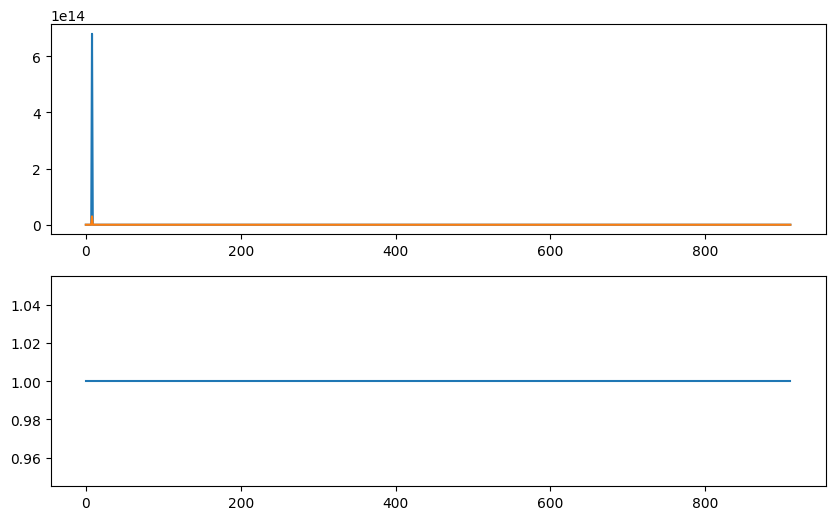

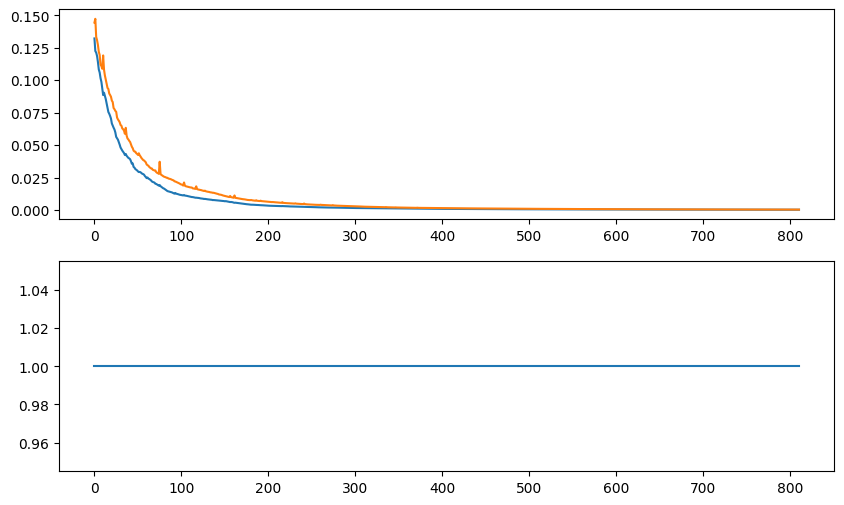

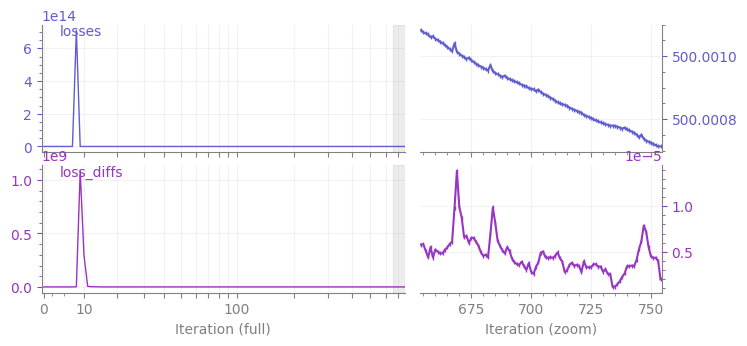

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [53]:
optmzr.plot()

In [54]:
X = np.array(loss_data)

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

In [55]:
X = np.array(loss_data)[100:]

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

## 4

In [56]:
loss_data=list()

In [57]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': tnc,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 5000,
        'losses': loss_data
    },
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='L-BFGS-B',               # supplied to scipy.minimize
)

In [58]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                             | 0/1000 [00:00<?, ?it/s]

+6020.015799785700 [best: +6020.015799785700] :   0%|     | 1/1000 [00:00<03:29,  4.76it/s]

+5995.847987636236 [best: +5995.847987636236] :   0%|     | 2/1000 [00:00<03:19,  5.00it/s]

+78128.839571735531 [best: +5995.847987636236] :   0%|    | 3/1000 [00:00<03:12,  5.17it/s]

+5877.778228667970 [best: +5877.778228667970] :   0%|     | 4/1000 [00:00<03:06,  5.33it/s]

+7645.779206865892 [best: +5877.778228667970] :   0%|     | 5/1000 [00:00<03:07,  5.30it/s]

+5835.330082278414 [best: +5835.330082278414] :   1%|     | 6/1000 [00:01<03:12,  5.17it/s]

+5833.559529409017 [best: +5833.559529409017] :   1%|     | 7/1000 [00:01<03:14,  5.10it/s]

+5823.521653423822 [best: +5823.521653423822] :   1%|     | 8/1000 [00:01<03:16,  5.06it/s]

+709892338738221.500000000000 [best: +5823.521653423822] :   1%| | 9/1000 [00:01<03:16,  5.

+22276308.020560283214 [best: +5823.521653423822] :   1%| | 10/1000 [00:01<03:13,  5.13it/s

+7194.071822870828 [best: +5823.521653423822] :   1%|    | 11/1000 [00:02<03:16,  5.02it/s]

+5736.012724470535 [best: +5736.012724470535] :   1%|    | 12/1000 [00:02<03:15,  5.04it/s]

+501303.701931601041 [best: +5736.012724470535] :   1%|  | 13/1000 [00:02<03:13,  5.10it/s]

+6114.202931435404 [best: +5736.012724470535] :   1%|    | 14/1000 [00:02<03:17,  4.99it/s]

+5704.922843545973 [best: +5704.922843545973] :   2%|    | 15/1000 [00:02<03:15,  5.04it/s]

+5669.075041235924 [best: +5669.075041235924] :   2%|    | 16/1000 [00:03<03:17,  4.98it/s]

+5610.054963248169 [best: +5610.054963248169] :   2%|    | 17/1000 [00:03<03:17,  4.98it/s]

+5558.733771562456 [best: +5558.733771562456] :   2%|    | 18/1000 [00:03<03:20,  4.91it/s]

+5525.944450512173 [best: +5525.944450512173] :   2%|    | 19/1000 [00:03<03:15,  5.01it/s]

+5502.973744585850 [best: +5502.973744585850] :   2%|    | 20/1000 [00:03<03:14,  5.05it/s]

+5484.322837543246 [best: +5484.322837543246] :   2%|    | 21/1000 [00:04<03:14,  5.03it/s]

+5474.223240223225 [best: +5474.223240223225] :   2%|    | 22/1000 [00:04<03:10,  5.12it/s]

+5467.355359500909 [best: +5467.355359500909] :   2%|    | 23/1000 [00:04<03:10,  5.12it/s]

+5453.691906506953 [best: +5453.691906506953] :   2%|    | 24/1000 [00:04<03:17,  4.94it/s]

+5433.769647733031 [best: +5433.769647733031] :   2%|    | 25/1000 [00:04<03:11,  5.09it/s]

+5409.442728994273 [best: +5409.442728994273] :   3%|    | 26/1000 [00:05<03:07,  5.18it/s]

+5379.624647020933 [best: +5379.624647020933] :   3%|    | 27/1000 [00:05<03:03,  5.31it/s]

+5349.384521077043 [best: +5349.384521077043] :   3%|    | 28/1000 [00:05<03:02,  5.33it/s]

+5327.454004932855 [best: +5327.454004932855] :   3%|    | 29/1000 [00:05<03:09,  5.11it/s]

+5308.745610556194 [best: +5308.745610556194] :   3%|    | 30/1000 [00:05<03:13,  5.01it/s]

+5288.683701602878 [best: +5288.683701602878] :   3%|    | 31/1000 [00:06<03:09,  5.10it/s]

+5334.775874420922 [best: +5288.683701602878] :   3%|▏   | 32/1000 [00:06<03:07,  5.17it/s]

+5274.306064391789 [best: +5274.306064391789] :   3%|▏   | 33/1000 [00:06<03:09,  5.10it/s]

+5247.952990538932 [best: +5247.952990538932] :   3%|▏   | 34/1000 [00:06<03:11,  5.04it/s]

+5223.278577463440 [best: +5223.278577463440] :   4%|▏   | 35/1000 [00:06<03:11,  5.05it/s]

+5196.653658781092 [best: +5196.653658781092] :   4%|▏   | 36/1000 [00:07<03:11,  5.04it/s]

+5163.644479284891 [best: +5163.644479284891] :   4%|▏   | 37/1000 [00:07<03:10,  5.05it/s]

+5142.358309445691 [best: +5142.358309445691] :   4%|▏   | 38/1000 [00:07<03:08,  5.11it/s]

+5116.630839028333 [best: +5116.630839028333] :   4%|▏   | 39/1000 [00:07<03:08,  5.11it/s]

+5101.281063177081 [best: +5101.281063177081] :   4%|▏   | 40/1000 [00:07<03:08,  5.10it/s]

+5081.532084578617 [best: +5081.532084578617] :   4%|▏   | 41/1000 [00:08<03:05,  5.16it/s]

+5063.472612381158 [best: +5063.472612381158] :   4%|▏   | 42/1000 [00:08<03:06,  5.14it/s]

+5047.218145408294 [best: +5047.218145408294] :   4%|▏   | 43/1000 [00:08<03:04,  5.20it/s]

+5038.017210963445 [best: +5038.017210963445] :   4%|▏   | 44/1000 [00:08<03:00,  5.30it/s]

+5029.779774749211 [best: +5029.779774749211] :   4%|▏   | 45/1000 [00:08<03:00,  5.29it/s]

+5021.849509972788 [best: +5021.849509972788] :   5%|▏   | 46/1000 [00:09<03:01,  5.26it/s]

+5018.691781970092 [best: +5018.691781970092] :   5%|▏   | 47/1000 [00:09<02:59,  5.31it/s]

+5015.076986366143 [best: +5015.076986366143] :   5%|▏   | 48/1000 [00:09<02:59,  5.29it/s]

+5013.314668183633 [best: +5013.314668183633] :   5%|▏   | 49/1000 [00:09<03:00,  5.27it/s]

+5011.221267196470 [best: +5011.221267196470] :   5%|▏   | 50/1000 [00:09<02:59,  5.28it/s]

+5008.543609979840 [best: +5008.543609979840] :   5%|▏   | 51/1000 [00:09<03:00,  5.25it/s]

+5008.134028434342 [best: +5008.134028434342] :   5%|▏   | 52/1000 [00:10<03:00,  5.24it/s]

+5006.205998406512 [best: +5006.205998406512] :   5%|▏   | 53/1000 [00:10<03:00,  5.25it/s]

+5005.922738197453 [best: +5005.922738197453] :   5%|▏   | 54/1000 [00:10<03:01,  5.21it/s]

+5005.307063165222 [best: +5005.307063165222] :   6%|▏   | 55/1000 [00:10<03:02,  5.18it/s]

+5004.990103218839 [best: +5004.990103218839] :   6%|▏   | 56/1000 [00:10<03:00,  5.22it/s]

+5004.484896927823 [best: +5004.484896927823] :   6%|▏   | 57/1000 [00:11<02:58,  5.27it/s]

+5004.032556249894 [best: +5004.032556249894] :   6%|▏   | 58/1000 [00:11<02:57,  5.31it/s]

+5003.751363323709 [best: +5003.751363323709] :   6%|▏   | 59/1000 [00:11<02:55,  5.35it/s]

+5002.989566888674 [best: +5002.989566888674] :   6%|▏   | 60/1000 [00:11<03:02,  5.16it/s]

+5003.491592654325 [best: +5002.989566888674] :   6%|▏   | 61/1000 [00:11<02:56,  5.31it/s]

+5002.684084838592 [best: +5002.684084838592] :   6%|▏   | 62/1000 [00:12<02:56,  5.30it/s]

+5002.405457568307 [best: +5002.405457568307] :   6%|▎   | 63/1000 [00:12<02:56,  5.31it/s]

+5002.198166711679 [best: +5002.198166711679] :   6%|▎   | 64/1000 [00:12<02:55,  5.35it/s]

+5001.931561464472 [best: +5001.931561464472] :   6%|▎   | 65/1000 [00:12<02:53,  5.39it/s]

+5001.844739697199 [best: +5001.844739697199] :   7%|▎   | 66/1000 [00:12<02:53,  5.37it/s]

+5001.660320294103 [best: +5001.660320294103] :   7%|▎   | 67/1000 [00:12<02:56,  5.28it/s]

+5001.590047727947 [best: +5001.590047727947] :   7%|▎   | 68/1000 [00:13<02:58,  5.22it/s]

+5001.494478580782 [best: +5001.494478580782] :   7%|▎   | 69/1000 [00:13<03:02,  5.11it/s]

+5001.376620202437 [best: +5001.376620202437] :   7%|▎   | 70/1000 [00:13<03:06,  4.99it/s]

+5001.278919190676 [best: +5001.278919190676] :   7%|▎   | 71/1000 [00:13<03:06,  4.98it/s]

+5001.224148772399 [best: +5001.224148772399] :   7%|▎   | 72/1000 [00:13<03:08,  4.92it/s]

+5001.180934601354 [best: +5001.180934601354] :   7%|▎   | 73/1000 [00:14<03:05,  4.99it/s]

+5001.118403326295 [best: +5001.118403326295] :   7%|▎   | 74/1000 [00:14<03:00,  5.13it/s]

+5001.012873579745 [best: +5001.012873579745] :   8%|▎   | 75/1000 [00:14<02:57,  5.21it/s]

+5000.926092415198 [best: +5000.926092415198] :   8%|▎   | 76/1000 [00:14<02:55,  5.27it/s]

+5000.855414633888 [best: +5000.855414633888] :   8%|▎   | 77/1000 [00:14<02:57,  5.20it/s]

+5000.806421237060 [best: +5000.806421237060] :   8%|▎   | 78/1000 [00:15<02:54,  5.27it/s]

+5000.771270452926 [best: +5000.771270452926] :   8%|▎   | 79/1000 [00:15<02:54,  5.29it/s]

+5000.709857206777 [best: +5000.709857206777] :   8%|▎   | 80/1000 [00:15<02:53,  5.30it/s]

+5000.662648098817 [best: +5000.662648098817] :   8%|▎   | 81/1000 [00:15<02:50,  5.40it/s]

+5000.633453023130 [best: +5000.633453023130] :   8%|▎   | 82/1000 [00:15<02:50,  5.38it/s]

+5000.606896610660 [best: +5000.606896610660] :   8%|▎   | 83/1000 [00:16<02:52,  5.33it/s]

+5000.578685741894 [best: +5000.578685741894] :   8%|▎   | 84/1000 [00:16<02:53,  5.29it/s]

+5000.581520519582 [best: +5000.578685741894] :   8%|▎   | 85/1000 [00:16<02:52,  5.30it/s]

+5000.560010256739 [best: +5000.560010256739] :   9%|▎   | 86/1000 [00:16<02:49,  5.38it/s]

+5000.538971769014 [best: +5000.538971769014] :   9%|▎   | 87/1000 [00:16<02:48,  5.41it/s]

+5000.524313551467 [best: +5000.524313551467] :   9%|▎   | 88/1000 [00:16<02:47,  5.45it/s]

+5000.497920528828 [best: +5000.497920528828] :   9%|▎   | 89/1000 [00:17<02:47,  5.43it/s]

+5000.471775009463 [best: +5000.471775009463] :   9%|▎   | 90/1000 [00:17<02:47,  5.44it/s]

+5000.445111003592 [best: +5000.445111003592] :   9%|▎   | 91/1000 [00:17<02:48,  5.40it/s]

+5000.422792737269 [best: +5000.422792737269] :   9%|▎   | 92/1000 [00:17<02:50,  5.31it/s]

+5000.397350801205 [best: +5000.397350801205] :   9%|▎   | 93/1000 [00:17<02:50,  5.33it/s]

+5000.368571352112 [best: +5000.368571352112] :   9%|▍   | 94/1000 [00:18<02:52,  5.26it/s]

+5000.347415679763 [best: +5000.347415679763] :  10%|▍   | 95/1000 [00:18<02:54,  5.18it/s]

+5000.329548974163 [best: +5000.329548974163] :  10%|▍   | 96/1000 [00:18<02:52,  5.23it/s]

+5000.315410211741 [best: +5000.315410211741] :  10%|▍   | 97/1000 [00:18<02:50,  5.29it/s]

+5000.303099802884 [best: +5000.303099802884] :  10%|▍   | 98/1000 [00:18<02:49,  5.32it/s]

+5000.292668622409 [best: +5000.292668622409] :  10%|▍   | 99/1000 [00:19<02:52,  5.22it/s]

+5000.287176064894 [best: +5000.287176064894] :  10%|▎  | 100/1000 [00:19<02:50,  5.27it/s]

+5000.276152598767 [best: +5000.276152598767] :  10%|▎  | 101/1000 [00:19<02:54,  5.14it/s]

+5000.270139294144 [best: +5000.270139294144] :  10%|▎  | 102/1000 [00:19<02:57,  5.07it/s]

+5000.254568056922 [best: +5000.254568056922] :  10%|▎  | 103/1000 [00:19<03:01,  4.95it/s]

+5000.249560590632 [best: +5000.249560590632] :  10%|▎  | 104/1000 [00:20<02:58,  5.02it/s]

+5000.240886001397 [best: +5000.240886001397] :  10%|▎  | 105/1000 [00:20<02:55,  5.10it/s]

+5000.229978527558 [best: +5000.229978527558] :  11%|▎  | 106/1000 [00:20<03:59,  3.73it/s]

+5000.224039865257 [best: +5000.224039865257] :  11%|▎  | 107/1000 [00:20<03:41,  4.03it/s]

+5000.213280439135 [best: +5000.213280439135] :  11%|▎  | 108/1000 [00:21<03:31,  4.23it/s]

+5000.209201519407 [best: +5000.209201519407] :  11%|▎  | 109/1000 [00:21<03:20,  4.45it/s]

+5000.201957773372 [best: +5000.201957773372] :  11%|▎  | 110/1000 [00:21<03:10,  4.68it/s]

+5000.207406505054 [best: +5000.201957773372] :  11%|▎  | 111/1000 [00:21<03:03,  4.85it/s]

+5000.198069090005 [best: +5000.198069090005] :  11%|▎  | 112/1000 [00:21<02:58,  4.97it/s]

+5000.191194873159 [best: +5000.191194873159] :  11%|▎  | 113/1000 [00:22<02:56,  5.01it/s]

+5000.185568978765 [best: +5000.185568978765] :  11%|▎  | 114/1000 [00:22<02:57,  5.00it/s]

+5000.179230628454 [best: +5000.179230628454] :  12%|▎  | 115/1000 [00:22<02:57,  4.99it/s]

+5000.172615118936 [best: +5000.172615118936] :  12%|▎  | 116/1000 [00:22<02:59,  4.94it/s]

+5000.168300338076 [best: +5000.168300338076] :  12%|▎  | 117/1000 [00:22<02:56,  4.99it/s]

+5000.163843404278 [best: +5000.163843404278] :  12%|▎  | 118/1000 [00:23<02:51,  5.14it/s]

+5000.160847473734 [best: +5000.160847473734] :  12%|▎  | 119/1000 [00:23<02:53,  5.08it/s]

+5000.157469040290 [best: +5000.157469040290] :  12%|▎  | 120/1000 [00:23<02:51,  5.15it/s]

+5000.150272232233 [best: +5000.150272232233] :  12%|▎  | 121/1000 [00:23<02:48,  5.21it/s]

+5000.149451950833 [best: +5000.149451950833] :  12%|▎  | 122/1000 [00:23<02:46,  5.28it/s]

+5000.145596828076 [best: +5000.145596828076] :  12%|▎  | 123/1000 [00:24<02:45,  5.29it/s]

+5000.141602794462 [best: +5000.141602794462] :  12%|▎  | 124/1000 [00:24<02:47,  5.22it/s]

+5000.137693244789 [best: +5000.137693244789] :  12%|▍  | 125/1000 [00:24<02:50,  5.12it/s]

+5000.134530631080 [best: +5000.134530631080] :  13%|▍  | 126/1000 [00:24<02:48,  5.17it/s]

+5000.129940281387 [best: +5000.129940281387] :  13%|▍  | 127/1000 [00:24<02:45,  5.28it/s]

+5000.124309959790 [best: +5000.124309959790] :  13%|▍  | 128/1000 [00:24<02:42,  5.36it/s]

+5000.121313765285 [best: +5000.121313765285] :  13%|▍  | 129/1000 [00:25<02:38,  5.51it/s]

+5000.117815395834 [best: +5000.117815395834] :  13%|▍  | 130/1000 [00:25<02:40,  5.43it/s]

+5000.116198610170 [best: +5000.116198610170] :  13%|▍  | 131/1000 [00:25<02:37,  5.50it/s]

+5000.112789421669 [best: +5000.112789421669] :  13%|▍  | 132/1000 [00:25<02:40,  5.42it/s]

+5000.110889309712 [best: +5000.110889309712] :  13%|▍  | 133/1000 [00:25<02:39,  5.42it/s]

+5000.109538237977 [best: +5000.109538237977] :  13%|▍  | 134/1000 [00:26<02:39,  5.43it/s]

+5000.106677406666 [best: +5000.106677406666] :  14%|▍  | 135/1000 [00:26<02:41,  5.35it/s]

+5000.116754139075 [best: +5000.106677406666] :  14%|▍  | 136/1000 [00:26<02:44,  5.26it/s]

+5000.105197130134 [best: +5000.105197130134] :  14%|▍  | 137/1000 [00:26<02:44,  5.26it/s]

+5000.101939700653 [best: +5000.101939700653] :  14%|▍  | 138/1000 [00:26<02:45,  5.21it/s]

+5000.099093527981 [best: +5000.099093527981] :  14%|▍  | 139/1000 [00:27<02:42,  5.29it/s]

+5000.096838165042 [best: +5000.096838165042] :  14%|▍  | 140/1000 [00:27<02:46,  5.18it/s]

+5000.094705780847 [best: +5000.094705780847] :  14%|▍  | 141/1000 [00:27<02:44,  5.23it/s]

+5000.093308413405 [best: +5000.093308413405] :  14%|▍  | 142/1000 [00:27<02:44,  5.20it/s]

+5000.090802309484 [best: +5000.090802309484] :  14%|▍  | 143/1000 [00:27<02:46,  5.14it/s]

+5000.088763865984 [best: +5000.088763865984] :  14%|▍  | 144/1000 [00:27<02:47,  5.12it/s]

+5000.085723120850 [best: +5000.085723120850] :  14%|▍  | 145/1000 [00:28<02:43,  5.23it/s]

+5000.083181947925 [best: +5000.083181947925] :  15%|▍  | 146/1000 [00:28<02:40,  5.31it/s]

+5000.081576949596 [best: +5000.081576949596] :  15%|▍  | 147/1000 [00:28<02:40,  5.33it/s]

+5000.079895375793 [best: +5000.079895375793] :  15%|▍  | 148/1000 [00:28<02:38,  5.36it/s]

+5000.078560942307 [best: +5000.078560942307] :  15%|▍  | 149/1000 [00:28<02:41,  5.25it/s]

+5000.076610591850 [best: +5000.076610591850] :  15%|▍  | 150/1000 [00:29<03:02,  4.65it/s]

+5000.075175991151 [best: +5000.075175991151] :  15%|▍  | 151/1000 [00:29<03:05,  4.58it/s]

+5000.078649710446 [best: +5000.075175991151] :  15%|▍  | 152/1000 [00:29<02:56,  4.80it/s]

+5000.074239903830 [best: +5000.074239903830] :  15%|▍  | 153/1000 [00:29<02:53,  4.88it/s]

+5000.072921671179 [best: +5000.072921671179] :  15%|▍  | 154/1000 [00:29<02:48,  5.02it/s]

+5000.071075500951 [best: +5000.071075500951] :  16%|▍  | 155/1000 [00:30<02:47,  5.04it/s]

+5000.069778430615 [best: +5000.069778430615] :  16%|▍  | 156/1000 [00:30<02:46,  5.07it/s]

+5000.068345184366 [best: +5000.068345184366] :  16%|▍  | 157/1000 [00:30<02:41,  5.21it/s]

+5000.067198641476 [best: +5000.067198641476] :  16%|▍  | 158/1000 [00:30<02:40,  5.24it/s]

+5000.065373731001 [best: +5000.065373731001] :  16%|▍  | 159/1000 [00:30<02:38,  5.31it/s]

+5000.064026223490 [best: +5000.064026223490] :  16%|▍  | 160/1000 [00:31<02:37,  5.32it/s]

+5000.062340678497 [best: +5000.062340678497] :  16%|▍  | 161/1000 [00:31<02:37,  5.31it/s]

+5000.060678832106 [best: +5000.060678832106] :  16%|▍  | 162/1000 [00:31<02:40,  5.21it/s]

+5000.058902348605 [best: +5000.058902348605] :  16%|▍  | 163/1000 [00:31<02:42,  5.15it/s]

+5000.057545069237 [best: +5000.057545069237] :  16%|▍  | 164/1000 [00:31<02:42,  5.13it/s]

+5000.056001902011 [best: +5000.056001902011] :  16%|▍  | 165/1000 [00:32<02:41,  5.17it/s]

+5000.054887419936 [best: +5000.054887419936] :  17%|▍  | 166/1000 [00:32<02:44,  5.08it/s]

+5000.055264565027 [best: +5000.054887419936] :  17%|▌  | 167/1000 [00:32<02:44,  5.06it/s]

+5000.053995115864 [best: +5000.053995115864] :  17%|▌  | 168/1000 [00:32<02:47,  4.98it/s]

+5000.052784335847 [best: +5000.052784335847] :  17%|▌  | 169/1000 [00:32<02:50,  4.87it/s]

+5000.051875171121 [best: +5000.051875171121] :  17%|▌  | 170/1000 [00:33<02:49,  4.89it/s]

+5000.051124696051 [best: +5000.051124696051] :  17%|▌  | 171/1000 [00:33<02:50,  4.88it/s]

+5000.050544914817 [best: +5000.050544914817] :  17%|▌  | 172/1000 [00:33<02:50,  4.86it/s]

+5000.049574490157 [best: +5000.049574490157] :  17%|▌  | 173/1000 [00:33<02:49,  4.88it/s]

+5000.048786309879 [best: +5000.048786309879] :  17%|▌  | 174/1000 [00:33<02:48,  4.89it/s]

+5000.048422869155 [best: +5000.048422869155] :  18%|▌  | 175/1000 [00:34<02:47,  4.93it/s]

+5000.046976330676 [best: +5000.046976330676] :  18%|▌  | 176/1000 [00:34<02:46,  4.96it/s]

+5000.046613103829 [best: +5000.046613103829] :  18%|▌  | 177/1000 [00:34<02:42,  5.06it/s]

+5000.045875536216 [best: +5000.045875536216] :  18%|▌  | 178/1000 [00:34<02:42,  5.07it/s]

+5000.044747604938 [best: +5000.044747604938] :  18%|▌  | 179/1000 [00:34<02:37,  5.20it/s]

+5000.044279951261 [best: +5000.044279951261] :  18%|▌  | 180/1000 [00:35<02:37,  5.20it/s]

+5000.042897135399 [best: +5000.042897135399] :  18%|▌  | 181/1000 [00:35<02:37,  5.19it/s]

+5000.042376447841 [best: +5000.042376447841] :  18%|▌  | 182/1000 [00:35<02:45,  4.95it/s]

+5000.041611121178 [best: +5000.041611121178] :  18%|▌  | 183/1000 [00:35<02:50,  4.80it/s]

+5000.041036471825 [best: +5000.041036471825] :  18%|▌  | 184/1000 [00:35<02:49,  4.81it/s]

+5000.040246372976 [best: +5000.040246372976] :  18%|▌  | 185/1000 [00:36<02:44,  4.94it/s]

+5000.039635854619 [best: +5000.039635854619] :  19%|▌  | 186/1000 [00:36<02:42,  5.01it/s]

+5000.038987938578 [best: +5000.038987938578] :  19%|▌  | 187/1000 [00:36<02:40,  5.07it/s]

+5000.037597744742 [best: +5000.037597744742] :  19%|▌  | 188/1000 [00:36<02:36,  5.19it/s]

+5000.040682334880 [best: +5000.037597744742] :  19%|▌  | 189/1000 [00:36<02:39,  5.09it/s]

+5000.037271044704 [best: +5000.037271044704] :  19%|▌  | 190/1000 [00:37<02:40,  5.06it/s]

+5000.036477736255 [best: +5000.036477736255] :  19%|▌  | 191/1000 [00:37<02:37,  5.13it/s]

+5000.035819860000 [best: +5000.035819860000] :  19%|▌  | 192/1000 [00:37<02:37,  5.11it/s]

+5000.035020568132 [best: +5000.035020568132] :  19%|▌  | 193/1000 [00:37<02:37,  5.13it/s]

+5000.034572179612 [best: +5000.034572179612] :  19%|▌  | 194/1000 [00:37<02:39,  5.07it/s]

+5000.034124615880 [best: +5000.034124615880] :  20%|▌  | 195/1000 [00:38<02:38,  5.09it/s]

+5000.033615538626 [best: +5000.033615538626] :  20%|▌  | 196/1000 [00:38<02:37,  5.11it/s]

+5000.033092291431 [best: +5000.033092291431] :  20%|▌  | 197/1000 [00:38<02:38,  5.06it/s]

+5000.033831296730 [best: +5000.033092291431] :  20%|▌  | 198/1000 [00:38<02:36,  5.14it/s]

+5000.032821946008 [best: +5000.032821946008] :  20%|▌  | 199/1000 [00:38<02:34,  5.17it/s]

+5000.032268665139 [best: +5000.032268665139] :  20%|▌  | 200/1000 [00:39<02:33,  5.20it/s]

+5000.031791671371 [best: +5000.031791671371] :  20%|▌  | 201/1000 [00:39<02:34,  5.18it/s]

+5000.031195886939 [best: +5000.031195886939] :  20%|▌  | 202/1000 [00:39<02:33,  5.21it/s]

+5000.030535682551 [best: +5000.030535682551] :  20%|▌  | 203/1000 [00:39<02:30,  5.29it/s]

+5000.031645873950 [best: +5000.030535682551] :  20%|▌  | 204/1000 [00:39<02:28,  5.35it/s]

+5000.030199792481 [best: +5000.030199792481] :  20%|▌  | 205/1000 [00:39<02:29,  5.32it/s]

+5000.029530332247 [best: +5000.029530332247] :  21%|▌  | 206/1000 [00:40<02:33,  5.16it/s]

+5000.028867623492 [best: +5000.028867623492] :  21%|▌  | 207/1000 [00:40<02:37,  5.04it/s]

+5000.028184263121 [best: +5000.028184263121] :  21%|▌  | 208/1000 [00:40<02:34,  5.14it/s]

+5000.027646923594 [best: +5000.027646923594] :  21%|▋  | 209/1000 [00:40<02:31,  5.21it/s]

+5000.027131449645 [best: +5000.027131449645] :  21%|▋  | 210/1000 [00:40<02:31,  5.22it/s]

+5000.026730858499 [best: +5000.026730858499] :  21%|▋  | 211/1000 [00:41<02:32,  5.18it/s]

+5000.026190375670 [best: +5000.026190375670] :  21%|▋  | 212/1000 [00:41<02:33,  5.13it/s]

+5000.025766669651 [best: +5000.025766669651] :  21%|▋  | 213/1000 [00:41<02:34,  5.10it/s]

+5000.025464916298 [best: +5000.025464916298] :  21%|▋  | 214/1000 [00:41<02:31,  5.18it/s]

+5000.024977388192 [best: +5000.024977388192] :  22%|▋  | 215/1000 [00:41<02:30,  5.20it/s]

+5000.024777478248 [best: +5000.024777478248] :  22%|▋  | 216/1000 [00:42<02:34,  5.06it/s]

+5000.024449300493 [best: +5000.024449300493] :  22%|▋  | 217/1000 [00:42<02:36,  5.01it/s]

+5000.023890975082 [best: +5000.023890975082] :  22%|▋  | 218/1000 [00:42<02:33,  5.10it/s]

+5000.023507286588 [best: +5000.023507286588] :  22%|▋  | 219/1000 [00:42<02:33,  5.10it/s]

+5000.023159354528 [best: +5000.023159354528] :  22%|▋  | 220/1000 [00:42<02:37,  4.96it/s]

+5000.022935762417 [best: +5000.022935762417] :  22%|▋  | 221/1000 [00:43<02:34,  5.04it/s]

+5000.022648791836 [best: +5000.022648791836] :  22%|▋  | 222/1000 [00:43<02:35,  5.01it/s]

+5000.022504421054 [best: +5000.022504421054] :  22%|▋  | 223/1000 [00:43<02:35,  5.01it/s]

+5000.021940468620 [best: +5000.021940468620] :  22%|▋  | 224/1000 [00:43<02:34,  5.03it/s]

+5000.021777374023 [best: +5000.021777374023] :  22%|▋  | 225/1000 [00:43<02:31,  5.11it/s]

+5000.021591090670 [best: +5000.021591090670] :  23%|▋  | 226/1000 [00:44<02:28,  5.21it/s]

+5000.021311302408 [best: +5000.021311302408] :  23%|▋  | 227/1000 [00:44<02:26,  5.27it/s]

+5000.021165083072 [best: +5000.021165083072] :  23%|▋  | 228/1000 [00:44<02:29,  5.15it/s]

+5000.020688235960 [best: +5000.020688235960] :  23%|▋  | 229/1000 [00:44<02:28,  5.18it/s]

+5000.020540191708 [best: +5000.020540191708] :  23%|▋  | 230/1000 [00:44<02:25,  5.30it/s]

+5000.020175492948 [best: +5000.020175492948] :  23%|▋  | 231/1000 [00:45<02:24,  5.30it/s]

+5000.019843448122 [best: +5000.019843448122] :  23%|▋  | 232/1000 [00:45<02:23,  5.34it/s]

+5000.019393100404 [best: +5000.019393100404] :  23%|▋  | 233/1000 [00:45<02:22,  5.37it/s]

+5000.019208599384 [best: +5000.019208599384] :  23%|▋  | 234/1000 [00:45<02:28,  5.17it/s]

+5000.019031732691 [best: +5000.019031732691] :  24%|▋  | 235/1000 [00:45<02:30,  5.09it/s]

+5000.018824232938 [best: +5000.018824232938] :  24%|▋  | 236/1000 [00:46<02:28,  5.13it/s]

+5000.018490772598 [best: +5000.018490772598] :  24%|▋  | 237/1000 [00:46<02:28,  5.16it/s]

+5000.018428681560 [best: +5000.018428681560] :  24%|▋  | 238/1000 [00:46<02:27,  5.18it/s]

+5000.018110039729 [best: +5000.018110039729] :  24%|▋  | 239/1000 [00:46<02:27,  5.14it/s]

+5000.017973634305 [best: +5000.017973634305] :  24%|▋  | 240/1000 [00:46<02:23,  5.28it/s]

+5000.017736989582 [best: +5000.017736989582] :  24%|▋  | 241/1000 [00:46<02:25,  5.23it/s]

+5000.017733343293 [best: +5000.017733343293] :  24%|▋  | 242/1000 [00:47<02:25,  5.20it/s]

+5000.017597851544 [best: +5000.017597851544] :  24%|▋  | 243/1000 [00:47<02:25,  5.20it/s]

+5000.017390189843 [best: +5000.017390189843] :  24%|▋  | 244/1000 [00:47<02:28,  5.09it/s]

+5000.017183959921 [best: +5000.017183959921] :  24%|▋  | 245/1000 [00:47<02:28,  5.10it/s]

+5000.016953950558 [best: +5000.016953950558] :  25%|▋  | 246/1000 [00:47<02:26,  5.14it/s]

+5000.016646569323 [best: +5000.016646569323] :  25%|▋  | 247/1000 [00:48<02:24,  5.20it/s]

+5000.016628827575 [best: +5000.016628827575] :  25%|▋  | 248/1000 [00:48<02:26,  5.14it/s]

+5000.016466255318 [best: +5000.016466255318] :  25%|▋  | 249/1000 [00:48<02:26,  5.14it/s]

+5000.016138533163 [best: +5000.016138533163] :  25%|▊  | 250/1000 [00:48<02:28,  5.05it/s]

+5000.015925866259 [best: +5000.015925866259] :  25%|▊  | 251/1000 [00:48<02:32,  4.90it/s]

+5000.015681997244 [best: +5000.015681997244] :  25%|▊  | 252/1000 [00:49<02:29,  5.01it/s]

+5000.015551865196 [best: +5000.015551865196] :  25%|▊  | 253/1000 [00:49<02:27,  5.07it/s]

+5000.015290268409 [best: +5000.015290268409] :  25%|▊  | 254/1000 [00:49<02:27,  5.05it/s]

+5000.015102831305 [best: +5000.015102831305] :  26%|▊  | 255/1000 [00:49<02:25,  5.12it/s]

+5000.014887655641 [best: +5000.014887655641] :  26%|▊  | 256/1000 [00:49<02:20,  5.28it/s]

+5000.014602844954 [best: +5000.014602844954] :  26%|▊  | 257/1000 [00:50<02:19,  5.31it/s]

+5000.014974343671 [best: +5000.014602844954] :  26%|▊  | 258/1000 [00:50<02:21,  5.24it/s]

+5000.014427797125 [best: +5000.014427797125] :  26%|▊  | 259/1000 [00:50<02:21,  5.25it/s]

+5000.014227624395 [best: +5000.014227624395] :  26%|▊  | 260/1000 [00:50<02:21,  5.22it/s]

+5000.014105139900 [best: +5000.014105139900] :  26%|▊  | 261/1000 [00:50<02:21,  5.23it/s]

+5000.013990582676 [best: +5000.013990582676] :  26%|▊  | 262/1000 [00:51<02:21,  5.23it/s]

+5000.013727109631 [best: +5000.013727109631] :  26%|▊  | 263/1000 [00:51<02:18,  5.34it/s]

+5000.013445914222 [best: +5000.013445914222] :  26%|▊  | 264/1000 [00:51<02:19,  5.26it/s]

+5000.013212857126 [best: +5000.013212857126] :  26%|▊  | 265/1000 [00:51<03:31,  3.47it/s]

+5000.013026584354 [best: +5000.013026584354] :  27%|▊  | 266/1000 [00:52<03:09,  3.86it/s]

+5000.012888442170 [best: +5000.012888442170] :  27%|▊  | 267/1000 [00:52<02:53,  4.22it/s]

+5000.012648169729 [best: +5000.012648169729] :  27%|▊  | 268/1000 [00:52<02:41,  4.52it/s]

+5000.012370223361 [best: +5000.012370223361] :  27%|▊  | 269/1000 [00:52<02:32,  4.78it/s]

+5000.012273824481 [best: +5000.012273824481] :  27%|▊  | 270/1000 [00:52<02:27,  4.94it/s]

+5000.012105997622 [best: +5000.012105997622] :  27%|▊  | 271/1000 [00:53<02:25,  5.00it/s]

+5000.012960992241 [best: +5000.012105997622] :  27%|▊  | 272/1000 [00:53<02:27,  4.94it/s]

+5000.012036249182 [best: +5000.012036249182] :  27%|▊  | 273/1000 [00:53<02:24,  5.02it/s]

+5000.011888490533 [best: +5000.011888490533] :  27%|▊  | 274/1000 [00:53<02:22,  5.11it/s]

+5000.011595969246 [best: +5000.011595969246] :  28%|▊  | 275/1000 [00:53<02:19,  5.18it/s]

+5000.011381523380 [best: +5000.011381523380] :  28%|▊  | 276/1000 [00:54<02:18,  5.24it/s]

+5000.011199146972 [best: +5000.011199146972] :  28%|▊  | 277/1000 [00:54<02:18,  5.23it/s]

+5000.011003672415 [best: +5000.011003672415] :  28%|▊  | 278/1000 [00:54<02:15,  5.34it/s]

+5000.010834300126 [best: +5000.010834300126] :  28%|▊  | 279/1000 [00:54<02:12,  5.43it/s]

+5000.010551259820 [best: +5000.010551259820] :  28%|▊  | 280/1000 [00:54<02:13,  5.38it/s]

+5000.010378606733 [best: +5000.010378606733] :  28%|▊  | 281/1000 [00:54<02:13,  5.40it/s]

+5000.010167446130 [best: +5000.010167446130] :  28%|▊  | 282/1000 [00:55<02:12,  5.42it/s]

+5000.010639270127 [best: +5000.010167446130] :  28%|▊  | 283/1000 [00:55<02:13,  5.36it/s]

+5000.010090457975 [best: +5000.010090457975] :  28%|▊  | 284/1000 [00:55<02:14,  5.31it/s]

+5000.009933341385 [best: +5000.009933341385] :  28%|▊  | 285/1000 [00:55<02:16,  5.23it/s]

+5000.009830603378 [best: +5000.009830603378] :  29%|▊  | 286/1000 [00:55<02:14,  5.31it/s]

+5000.009718117013 [best: +5000.009718117013] :  29%|▊  | 287/1000 [00:56<02:14,  5.32it/s]

+5000.009569086249 [best: +5000.009569086249] :  29%|▊  | 288/1000 [00:56<02:14,  5.30it/s]

+5000.009515786977 [best: +5000.009515786977] :  29%|▊  | 289/1000 [00:56<02:13,  5.33it/s]

+5000.009442647926 [best: +5000.009442647926] :  29%|▊  | 290/1000 [00:56<02:16,  5.20it/s]

+5000.009302426652 [best: +5000.009302426652] :  29%|▊  | 291/1000 [00:56<02:16,  5.20it/s]

+5000.009320177354 [best: +5000.009302426652] :  29%|▉  | 292/1000 [00:57<02:14,  5.27it/s]

+5000.009214834228 [best: +5000.009214834228] :  29%|▉  | 293/1000 [00:57<02:14,  5.25it/s]

+5000.009056171644 [best: +5000.009056171644] :  29%|▉  | 294/1000 [00:57<02:14,  5.26it/s]

+5000.008950340954 [best: +5000.008950340954] :  30%|▉  | 295/1000 [00:57<02:13,  5.29it/s]

+5000.008819253466 [best: +5000.008819253466] :  30%|▉  | 296/1000 [00:57<02:13,  5.27it/s]

+5000.008677763737 [best: +5000.008677763737] :  30%|▉  | 297/1000 [00:57<02:11,  5.33it/s]

+5000.008704391730 [best: +5000.008677763737] :  30%|▉  | 298/1000 [00:58<02:11,  5.34it/s]

+5000.008575306225 [best: +5000.008575306225] :  30%|▉  | 299/1000 [00:58<02:11,  5.33it/s]

+5000.008420797320 [best: +5000.008420797320] :  30%|▉  | 300/1000 [00:58<02:13,  5.25it/s]

+5000.008298794010 [best: +5000.008298794010] :  30%|▉  | 301/1000 [00:58<02:13,  5.22it/s]

+5000.008229061487 [best: +5000.008229061487] :  30%|▉  | 302/1000 [00:58<02:13,  5.23it/s]

+5000.008146709859 [best: +5000.008146709859] :  30%|▉  | 303/1000 [00:59<02:11,  5.29it/s]

+5000.008060387559 [best: +5000.008060387559] :  30%|▉  | 304/1000 [00:59<02:11,  5.28it/s]

+5000.007967844139 [best: +5000.007967844139] :  30%|▉  | 305/1000 [00:59<02:10,  5.32it/s]

+5000.007873226381 [best: +5000.007873226381] :  31%|▉  | 306/1000 [00:59<02:09,  5.35it/s]

+5000.007888898829 [best: +5000.007873226381] :  31%|▉  | 307/1000 [00:59<02:08,  5.39it/s]

+5000.007814917250 [best: +5000.007814917250] :  31%|▉  | 308/1000 [01:00<02:06,  5.45it/s]

+5000.007758177674 [best: +5000.007758177674] :  31%|▉  | 309/1000 [01:00<02:07,  5.40it/s]

+5000.007710760131 [best: +5000.007710760131] :  31%|▉  | 310/1000 [01:00<02:08,  5.38it/s]

+5000.007648399882 [best: +5000.007648399882] :  31%|▉  | 311/1000 [01:00<02:07,  5.41it/s]

+5000.007533916609 [best: +5000.007533916609] :  31%|▉  | 312/1000 [01:00<02:07,  5.39it/s]

+5000.007650317487 [best: +5000.007533916609] :  31%|▉  | 313/1000 [01:00<02:07,  5.39it/s]

+5000.007478262955 [best: +5000.007478262955] :  31%|▉  | 314/1000 [01:01<02:08,  5.36it/s]

+5000.007411507830 [best: +5000.007411507830] :  32%|▉  | 315/1000 [01:01<02:07,  5.35it/s]

+5000.007356857609 [best: +5000.007356857609] :  32%|▉  | 316/1000 [01:01<02:07,  5.38it/s]

+5000.007300899167 [best: +5000.007300899167] :  32%|▉  | 317/1000 [01:01<02:07,  5.34it/s]

+5000.007290612770 [best: +5000.007290612770] :  32%|▉  | 318/1000 [01:01<02:12,  5.13it/s]


In [59]:
len(loss_data)

318

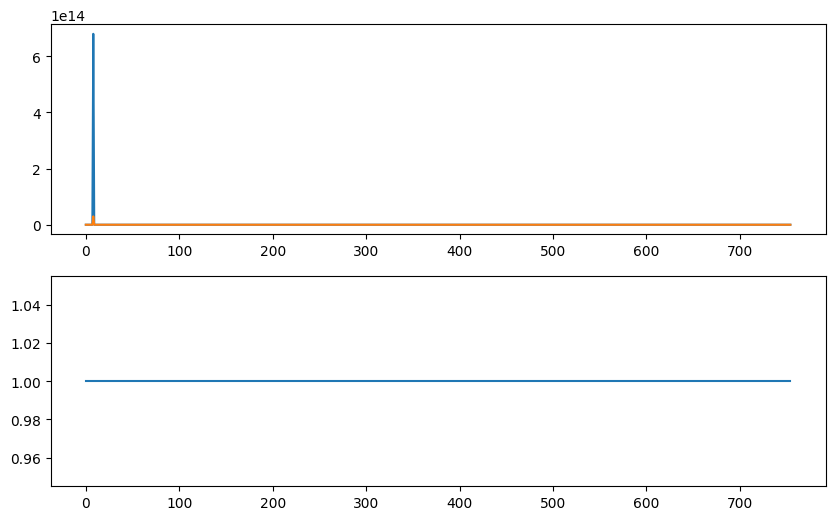

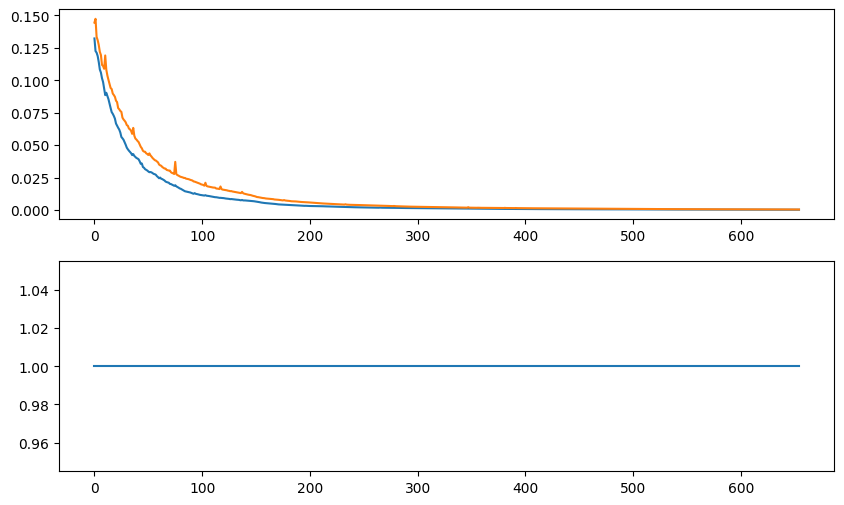

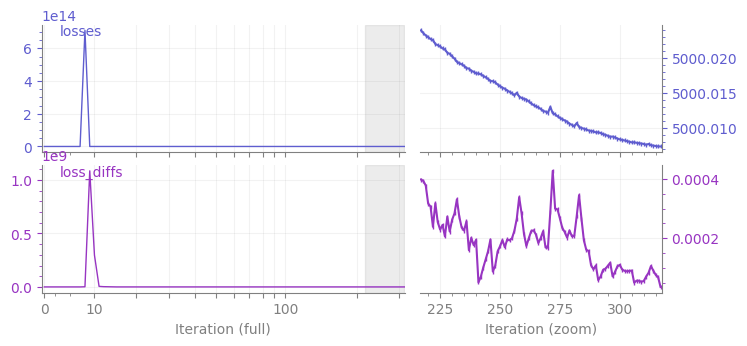

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [60]:
optmzr.plot()

In [61]:
X = np.array(loss_data)

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

In [62]:
X = np.array(loss_data)[100:]

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

## 5

In [63]:
loss_data=list()

In [64]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': tnc,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 1,
        'overlap_cost_coefficient': 5000,
        'losses': loss_data
    },
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',               # supplied to scipy.minimize
)

In [65]:
mpo_opt = optmzr.optimize(10000)

  0%|                                                            | 0/10000 [00:00<?, ?it/s]

+6020.015799785700 [best: +6020.015799785700] :   0%|    | 1/10000 [00:00<34:58,  4.76it/s]

+6019.732477768147 [best: +6019.732477768147] :   0%|    | 2/10000 [00:00<33:44,  4.94it/s]

+6019.429347931748 [best: +6019.429347931748] :   0%|    | 3/10000 [00:00<33:20,  5.00it/s]

+6019.104833511021 [best: +6019.104833511021] :   0%|    | 4/10000 [00:00<33:17,  5.00it/s]

+6018.757209508580 [best: +6018.757209508580] :   0%|    | 5/10000 [00:00<32:50,  5.07it/s]

+6018.384589291243 [best: +6018.384589291243] :   0%|    | 6/10000 [00:01<34:09,  4.88it/s]

+6017.984907680310 [best: +6017.984907680310] :   0%|    | 7/10000 [00:01<35:23,  4.71it/s]

+6017.555903357509 [best: +6017.555903357509] :   0%|    | 8/10000 [00:01<34:35,  4.81it/s]

+6017.095099119957 [best: +6017.095099119957] :   0%|    | 9/10000 [00:01<34:06,  4.88it/s]

+6016.599780201683 [best: +6016.599780201683] :   0%|   | 10/10000 [00:02<33:00,  5.04it/s]

+6016.066969837062 [best: +6016.066969837062] :   0%|   | 11/10000 [00:02<32:22,  5.14it/s]

+6015.493401780030 [best: +6015.493401780030] :   0%|   | 12/10000 [00:02<32:26,  5.13it/s]

+6014.875491538389 [best: +6014.875491538389] :   0%|   | 13/10000 [00:02<32:17,  5.15it/s]

+6014.209308298749 [best: +6014.209308298749] :   0%|   | 14/10000 [00:02<32:24,  5.14it/s]

+6013.490548358891 [best: +6013.490548358891] :   0%|   | 15/10000 [00:02<32:17,  5.15it/s]

+6012.714507428034 [best: +6012.714507428034] :   0%|   | 16/10000 [00:03<32:54,  5.06it/s]

+6011.876047616991 [best: +6011.876047616991] :   0%|   | 17/10000 [00:03<33:27,  4.97it/s]

+6010.969559065206 [best: +6010.969559065206] :   0%|   | 18/10000 [00:03<33:23,  4.98it/s]

+6009.988918000006 [best: +6009.988918000006] :   0%|   | 19/10000 [00:03<32:32,  5.11it/s]

+6008.927441849866 [best: +6008.927441849866] :   0%|   | 20/10000 [00:03<31:41,  5.25it/s]

+6007.777842404607 [best: +6007.777842404607] :   0%|   | 21/10000 [00:04<31:15,  5.32it/s]

+6006.532178278527 [best: +6006.532178278527] :   0%|   | 22/10000 [00:04<31:07,  5.34it/s]

+6005.181806517460 [best: +6005.181806517460] :   0%|   | 23/10000 [00:04<31:03,  5.36it/s]

+6003.717332086464 [best: +6003.717332086464] :   0%|   | 24/10000 [00:04<31:04,  5.35it/s]

+6002.128554952557 [best: +6002.128554952557] :   0%|   | 25/10000 [00:04<31:26,  5.29it/s]

+6000.404416360132 [best: +6000.404416360132] :   0%|   | 26/10000 [00:05<31:35,  5.26it/s]

+5998.532947339208 [best: +5998.532947339208] :   0%|   | 27/10000 [00:05<31:31,  5.27it/s]

+5996.501222629732 [best: +5996.501222629732] :   0%|   | 28/10000 [00:05<32:02,  5.19it/s]

+5994.295323330969 [best: +5994.295323330969] :   0%|   | 29/10000 [00:05<31:15,  5.32it/s]

+5991.900314160513 [best: +5991.900314160513] :   0%|   | 30/10000 [00:05<31:17,  5.31it/s]

+5989.300244330525 [best: +5989.300244330525] :   0%|   | 31/10000 [00:06<31:24,  5.29it/s]

+5986.478175173042 [best: +5986.478175173042] :   0%|   | 32/10000 [00:06<31:43,  5.24it/s]

+5983.416231337085 [best: +5983.416231337085] :   0%|   | 33/10000 [00:06<31:19,  5.30it/s]

+5980.095682547048 [best: +5980.095682547048] :   0%|   | 34/10000 [00:06<31:59,  5.19it/s]

+5976.497070644710 [best: +5976.497070644710] :   0%|   | 35/10000 [00:06<31:38,  5.25it/s]

+5972.600396687746 [best: +5972.600396687746] :   0%|   | 36/10000 [00:06<31:07,  5.33it/s]

+5968.385385447804 [best: +5968.385385447804] :   0%|   | 37/10000 [00:07<30:36,  5.42it/s]

+5963.831850313427 [best: +5963.831850313427] :   0%|   | 38/10000 [00:07<30:37,  5.42it/s]

+5958.920188540566 [best: +5958.920188540566] :   0%|   | 39/10000 [00:07<30:19,  5.47it/s]

+5953.632038592592 [best: +5953.632038592592] :   0%|   | 40/10000 [00:07<30:10,  5.50it/s]

+5947.951120534837 [best: +5947.951120534837] :   0%|   | 41/10000 [00:07<29:53,  5.55it/s]

+5941.864271116396 [best: +5941.864271116396] :   0%|   | 42/10000 [00:08<30:33,  5.43it/s]

+5935.362691722537 [best: +5935.362691722537] :   0%|   | 43/10000 [00:08<30:58,  5.36it/s]

+5928.443435552105 [best: +5928.443435552105] :   0%|   | 44/10000 [00:08<30:58,  5.36it/s]

+5921.111191946689 [best: +5921.111191946689] :   0%|   | 45/10000 [00:08<30:29,  5.44it/s]

+5913.380450740806 [best: +5913.380450740806] :   0%|   | 46/10000 [00:08<30:21,  5.46it/s]

+5905.277955782926 [best: +5905.277955782926] :   0%|   | 47/10000 [00:09<30:44,  5.39it/s]

+5896.845034343211 [best: +5896.845034343211] :   0%|   | 48/10000 [00:09<31:29,  5.27it/s]

+5888.139270862948 [best: +5888.139270862948] :   0%|   | 49/10000 [00:09<31:25,  5.28it/s]

+5879.235076547287 [best: +5879.235076547287] :   0%|   | 50/10000 [00:09<31:01,  5.34it/s]

+5870.222479773997 [best: +5870.222479773997] :   1%|   | 51/10000 [00:09<31:14,  5.31it/s]

+5861.203365601120 [best: +5861.203365601120] :   1%|   | 52/10000 [00:09<31:38,  5.24it/s]

+5852.284898958132 [best: +5852.284898958132] :   1%|   | 53/10000 [00:10<32:27,  5.11it/s]

+5843.569379039285 [best: +5843.569379039285] :   1%|   | 54/10000 [00:10<32:24,  5.11it/s]

+5835.139524254467 [best: +5835.139524254467] :   1%|   | 55/10000 [00:10<32:44,  5.06it/s]

+5827.040876387449 [best: +5827.040876387449] :   1%|   | 56/10000 [00:10<32:25,  5.11it/s]

+5819.267079820645 [best: +5819.267079820645] :   1%|   | 57/10000 [00:10<30:56,  5.35it/s]

+5811.756209213086 [best: +5811.756209213086] :   1%|   | 58/10000 [00:11<30:08,  5.50it/s]

+5804.402721173308 [best: +5804.402721173308] :   1%|   | 59/10000 [00:11<31:00,  5.34it/s]

+5797.082073300442 [best: +5797.082073300442] :   1%|   | 60/10000 [00:11<29:44,  5.57it/s]

+5789.679625940731 [best: +5789.679625940731] :   1%|   | 61/10000 [00:11<29:56,  5.53it/s]

+5782.114172925840 [best: +5782.114172925840] :   1%|   | 62/10000 [00:11<29:46,  5.56it/s]

+5774.349430958261 [best: +5774.349430958261] :   1%|   | 63/10000 [00:11<29:16,  5.66it/s]

+5766.392372624113 [best: +5766.392372624113] :   1%|   | 64/10000 [00:12<29:04,  5.70it/s]

+5758.282344856611 [best: +5758.282344856611] :   1%|   | 65/10000 [00:12<29:06,  5.69it/s]

+5750.076863800879 [best: +5750.076863800879] :   1%|   | 66/10000 [00:12<29:43,  5.57it/s]

+5741.838653133649 [best: +5741.838653133649] :   1%|   | 67/10000 [00:12<29:45,  5.56it/s]

+5733.625905196184 [best: +5733.625905196184] :   1%|   | 68/10000 [00:12<29:28,  5.62it/s]

+5725.486225456966 [best: +5725.486225456966] :   1%|   | 69/10000 [00:13<29:19,  5.64it/s]

+5717.454094504212 [best: +5717.454094504212] :   1%|   | 70/10000 [00:13<28:59,  5.71it/s]

+5709.551179597091 [best: +5709.551179597091] :   1%|   | 71/10000 [00:13<29:16,  5.65it/s]

+5701.788518308278 [best: +5701.788518308278] :   1%|   | 72/10000 [00:13<29:19,  5.64it/s]

+5694.169575330987 [best: +5694.169575330987] :   1%|   | 73/10000 [00:13<29:13,  5.66it/s]

+5686.693379939821 [best: +5686.693379939821] :   1%|   | 74/10000 [00:13<29:46,  5.56it/s]

+5679.357232122677 [best: +5679.357232122677] :   1%|   | 75/10000 [00:14<30:17,  5.46it/s]

+5672.158706433758 [best: +5672.158706433758] :   1%|   | 76/10000 [00:14<30:28,  5.43it/s]

+5665.096880269159 [best: +5665.096880269159] :   1%|   | 77/10000 [00:14<30:09,  5.48it/s]

+5658.172849399443 [best: +5658.172849399443] :   1%|   | 78/10000 [00:14<29:42,  5.57it/s]

+5651.389609932612 [best: +5651.389609932612] :   1%|   | 79/10000 [00:14<29:32,  5.60it/s]

+5644.751386962729 [best: +5644.751386962729] :   1%|   | 80/10000 [00:15<29:32,  5.60it/s]

+5638.262586087697 [best: +5638.262586087697] :   1%|   | 81/10000 [00:15<29:36,  5.58it/s]

+5631.926619085056 [best: +5631.926619085056] :   1%|   | 82/10000 [00:15<42:34,  3.88it/s]

+5625.744849078746 [best: +5625.744849078746] :   1%|   | 83/10000 [00:15<38:12,  4.33it/s]

+5619.715856601590 [best: +5619.715856601590] :   1%|   | 84/10000 [00:15<35:42,  4.63it/s]

+5613.835169336314 [best: +5613.835169336314] :   1%|   | 85/10000 [00:16<33:52,  4.88it/s]

+5608.095520952711 [best: +5608.095520952711] :   1%|   | 86/10000 [00:16<32:27,  5.09it/s]

+5602.487601087922 [best: +5602.487601087922] :   1%|   | 87/10000 [00:16<31:09,  5.30it/s]

+5597.001144526153 [best: +5597.001144526153] :   1%|   | 88/10000 [00:16<31:08,  5.31it/s]

+5591.626122363909 [best: +5591.626122363909] :   1%|   | 89/10000 [00:16<30:28,  5.42it/s]

+5586.353778743274 [best: +5586.353778743274] :   1%|   | 90/10000 [00:17<29:53,  5.53it/s]

+5581.177313185935 [best: +5581.177313185935] :   1%|   | 91/10000 [00:17<29:35,  5.58it/s]

+5576.092116676502 [best: +5576.092116676502] :   1%|   | 92/10000 [00:17<29:37,  5.57it/s]

+5571.095587677513 [best: +5571.095587677513] :   1%|   | 93/10000 [00:17<30:40,  5.38it/s]

+5566.186645369311 [best: +5566.186645369311] :   1%|   | 94/10000 [00:17<31:13,  5.29it/s]

+5561.365102451530 [best: +5561.365102451530] :   1%|   | 95/10000 [00:17<30:34,  5.40it/s]

+5556.631057438839 [best: +5556.631057438839] :   1%|   | 96/10000 [00:18<31:00,  5.32it/s]

+5551.984427270339 [best: +5551.984427270339] :   1%|   | 97/10000 [00:18<31:08,  5.30it/s]

+5547.424682064390 [best: +5547.424682064390] :   1%|   | 98/10000 [00:18<31:52,  5.18it/s]

+5542.950782730042 [best: +5542.950782730042] :   1%|   | 99/10000 [00:18<32:59,  5.00it/s]

+5538.561273393497 [best: +5538.561273393497] :   1%|  | 100/10000 [00:18<32:42,  5.05it/s]

+5534.254452990084 [best: +5534.254452990084] :   1%|  | 101/10000 [00:19<31:30,  5.24it/s]

+5530.028546465223 [best: +5530.028546465223] :   1%|  | 102/10000 [00:19<31:04,  5.31it/s]

+5525.881812976143 [best: +5525.881812976143] :   1%|  | 103/10000 [00:19<30:59,  5.32it/s]

+5521.812559261749 [best: +5521.812559261749] :   1%|  | 104/10000 [00:19<30:15,  5.45it/s]

+5517.819061401531 [best: +5517.819061401531] :   1%|  | 105/10000 [00:19<29:51,  5.52it/s]

+5513.899427898687 [best: +5513.899427898687] :   1%|  | 106/10000 [00:20<29:30,  5.59it/s]

+5510.051454198290 [best: +5510.051454198290] :   1%|  | 107/10000 [00:20<29:15,  5.64it/s]

+5506.272520036950 [best: +5506.272520036950] :   1%|  | 108/10000 [00:20<29:04,  5.67it/s]

+5502.559567234567 [best: +5502.559567234567] :   1%|  | 109/10000 [00:20<29:41,  5.55it/s]

+5498.909171297954 [best: +5498.909171297954] :   1%|  | 110/10000 [00:20<29:39,  5.56it/s]

+5495.317692855037 [best: +5495.317692855037] :   1%|  | 111/10000 [00:20<29:36,  5.57it/s]

+5491.781472645860 [best: +5491.781472645860] :   1%|  | 112/10000 [00:21<29:22,  5.61it/s]

+5488.297023117768 [best: +5488.297023117768] :   1%|  | 113/10000 [00:21<29:16,  5.63it/s]

+5484.861173393439 [best: +5484.861173393439] :   1%|  | 114/10000 [00:21<29:18,  5.62it/s]

+5481.471140566746 [best: +5481.471140566746] :   1%|  | 115/10000 [00:21<29:46,  5.53it/s]

+5478.124523023227 [best: +5478.124523023227] :   1%|  | 116/10000 [00:21<30:51,  5.34it/s]

+5474.819233094679 [best: +5474.819233094679] :   1%|  | 117/10000 [00:22<31:10,  5.28it/s]

+5471.553400146950 [best: +5471.553400146950] :   1%|  | 118/10000 [00:22<30:49,  5.34it/s]

+5468.325277696065 [best: +5468.325277696065] :   1%|  | 119/10000 [00:22<30:25,  5.41it/s]

+5465.133179984517 [best: +5465.133179984517] :   1%|  | 120/10000 [00:22<29:56,  5.50it/s]

+5461.975458683552 [best: +5461.975458683552] :   1%|  | 121/10000 [00:22<29:39,  5.55it/s]

+5458.850514692496 [best: +5458.850514692496] :   1%|  | 122/10000 [00:22<29:36,  5.56it/s]

+5455.756828560552 [best: +5455.756828560552] :   1%|  | 123/10000 [00:23<31:03,  5.30it/s]

+5452.692988919962 [best: +5452.692988919962] :   1%|  | 124/10000 [00:23<32:45,  5.03it/s]

+5449.657701762788 [best: +5449.657701762788] :   1%|  | 125/10000 [00:23<33:11,  4.96it/s]

+5446.649772224847 [best: +5446.649772224847] :   1%|  | 126/10000 [00:23<33:00,  4.99it/s]

+5443.668061142126 [best: +5443.668061142126] :   1%|  | 127/10000 [00:23<32:29,  5.06it/s]

+5440.711427295968 [best: +5440.711427295968] :   1%|  | 128/10000 [00:24<31:33,  5.21it/s]

+5437.778670319207 [best: +5437.778670319207] :   1%|  | 129/10000 [00:24<30:46,  5.35it/s]

+5434.868487854143 [best: +5434.868487854143] :   1%|  | 130/10000 [00:24<30:05,  5.47it/s]

+5431.979454793415 [best: +5431.979454793415] :   1%|  | 131/10000 [00:24<29:35,  5.56it/s]

+5429.110024739041 [best: +5429.110024739041] :   1%|  | 132/10000 [00:24<29:09,  5.64it/s]

+5426.258547060536 [best: +5426.258547060536] :   1%|  | 133/10000 [00:25<28:53,  5.69it/s]

+5423.423289383828 [best: +5423.423289383828] :   1%|  | 134/10000 [00:25<28:43,  5.73it/s]

+5420.602455879502 [best: +5420.602455879502] :   1%|  | 135/10000 [00:25<28:31,  5.76it/s]

+5417.794195629761 [best: +5417.794195629761] :   1%|  | 136/10000 [00:25<28:31,  5.76it/s]

+5414.996600748439 [best: +5414.996600748439] :   1%|  | 137/10000 [00:25<28:45,  5.72it/s]

+5412.207698577929 [best: +5412.207698577929] :   1%|  | 138/10000 [00:25<28:40,  5.73it/s]

+5409.425444519346 [best: +5409.425444519346] :   1%|  | 139/10000 [00:26<28:30,  5.77it/s]

+5406.647721339542 [best: +5406.647721339542] :   1%|  | 140/10000 [00:26<28:38,  5.74it/s]

+5403.872347822728 [best: +5403.872347822728] :   1%|  | 141/10000 [00:26<28:29,  5.77it/s]

+5401.097095867739 [best: +5401.097095867739] :   1%|  | 142/10000 [00:26<28:16,  5.81it/s]

+5398.319712158017 [best: +5398.319712158017] :   1%|  | 143/10000 [00:26<28:56,  5.68it/s]

+5395.537939410142 [best: +5395.537939410142] :   1%|  | 144/10000 [00:26<28:36,  5.74it/s]

+5392.749533127293 [best: +5392.749533127293] :   1%|  | 145/10000 [00:27<28:20,  5.79it/s]

+5389.952272104493 [best: +5389.952272104493] :   1%|  | 146/10000 [00:27<28:11,  5.83it/s]

+5387.143963539881 [best: +5387.143963539881] :   1%|  | 147/10000 [00:27<28:26,  5.77it/s]

+5384.322445424041 [best: +5384.322445424041] :   1%|  | 148/10000 [00:27<28:26,  5.77it/s]

+5381.485589301153 [best: +5381.485589301153] :   1%|  | 149/10000 [00:27<28:45,  5.71it/s]

+5378.631305581868 [best: +5378.631305581868] :   2%|  | 150/10000 [00:27<28:45,  5.71it/s]

+5375.757551959284 [best: +5375.757551959284] :   2%|  | 151/10000 [00:28<28:38,  5.73it/s]

+5372.862343978355 [best: +5372.862343978355] :   2%|  | 152/10000 [00:28<28:37,  5.73it/s]

+5369.943766093952 [best: +5369.943766093952] :   2%|  | 153/10000 [00:28<28:48,  5.70it/s]

+5366.999981817674 [best: +5366.999981817674] :   2%|  | 154/10000 [00:28<28:31,  5.75it/s]

+5364.029242497358 [best: +5364.029242497358] :   2%|  | 155/10000 [00:28<28:30,  5.75it/s]

+5361.029895309378 [best: +5361.029895309378] :   2%|  | 156/10000 [00:29<28:32,  5.75it/s]

+5358.000391626776 [best: +5358.000391626776] :   2%|  | 157/10000 [00:29<28:27,  5.76it/s]

+5354.939296816970 [best: +5354.939296816970] :   2%|  | 158/10000 [00:29<28:28,  5.76it/s]

+5351.845301866290 [best: +5351.845301866290] :   2%|  | 159/10000 [00:29<28:32,  5.75it/s]

+5348.717236423941 [best: +5348.717236423941] :   2%|  | 160/10000 [00:29<28:33,  5.74it/s]

+5345.554082312341 [best: +5345.554082312341] :   2%|  | 161/10000 [00:29<28:42,  5.71it/s]

+5342.354986460258 [best: +5342.354986460258] :   2%|  | 162/10000 [00:30<28:30,  5.75it/s]

+5339.119272484964 [best: +5339.119272484964] :   2%|  | 163/10000 [00:30<28:36,  5.73it/s]

+5335.846450485854 [best: +5335.846450485854] :   2%|  | 164/10000 [00:30<28:24,  5.77it/s]

+5332.536224717717 [best: +5332.536224717717] :   2%|  | 165/10000 [00:30<28:26,  5.76it/s]

+5329.188498571697 [best: +5329.188498571697] :   2%|  | 166/10000 [00:30<28:29,  5.75it/s]

+5325.803375839581 [best: +5325.803375839581] :   2%|  | 167/10000 [00:30<28:30,  5.75it/s]

+5322.381156870408 [best: +5322.381156870408] :   2%|  | 168/10000 [00:31<28:35,  5.73it/s]

+5318.922328231673 [best: +5318.922328231673] :   2%|  | 169/10000 [00:31<28:23,  5.77it/s]

+5315.427544966367 [best: +5315.427544966367] :   2%|  | 170/10000 [00:31<28:22,  5.77it/s]

+5311.897605367008 [best: +5311.897605367008] :   2%|  | 171/10000 [00:31<28:17,  5.79it/s]

+5308.333419094460 [best: +5308.333419094460] :   2%|  | 172/10000 [00:31<28:19,  5.78it/s]

+5304.735970180743 [best: +5304.735970180743] :   2%|  | 173/10000 [00:31<28:20,  5.78it/s]

+5301.106276823737 [best: +5301.106276823737] :   2%|  | 174/10000 [00:32<28:35,  5.73it/s]

+5297.445349911618 [best: +5297.445349911618] :   2%|  | 175/10000 [00:32<28:28,  5.75it/s]

+5293.754152002769 [best: +5293.754152002769] :   2%|  | 176/10000 [00:32<28:29,  5.75it/s]

+5290.033558148528 [best: +5290.033558148528] :   2%|  | 177/10000 [00:32<28:34,  5.73it/s]

+5286.284319583729 [best: +5286.284319583729] :   2%|  | 178/10000 [00:32<28:38,  5.71it/s]

+5282.507031024343 [best: +5282.507031024343] :   2%|  | 179/10000 [00:33<28:33,  5.73it/s]

+5278.702102208335 [best: +5278.702102208335] :   2%|  | 180/10000 [00:33<28:43,  5.70it/s]

+5274.869734477647 [best: +5274.869734477647] :   2%|  | 181/10000 [00:33<28:47,  5.68it/s]

+5271.009903639592 [best: +5271.009903639592] :   2%|  | 182/10000 [00:33<28:37,  5.72it/s]

+5267.122350979687 [best: +5267.122350979687] :   2%|  | 183/10000 [00:33<28:43,  5.70it/s]

+5263.206584937052 [best: +5263.206584937052] :   2%|  | 184/10000 [00:33<28:43,  5.69it/s]

+5259.261896328313 [best: +5259.261896328313] :   2%|  | 185/10000 [00:34<28:44,  5.69it/s]

+5255.287389828070 [best: +5255.287389828070] :   2%|  | 186/10000 [00:34<28:30,  5.74it/s]

+5251.282033492196 [best: +5251.282033492196] :   2%|  | 187/10000 [00:34<28:28,  5.74it/s]

+5247.244726476626 [best: +5247.244726476626] :   2%|  | 188/10000 [00:34<28:34,  5.72it/s]

+5243.174383074729 [best: +5243.174383074729] :   2%|  | 189/10000 [00:34<29:34,  5.53it/s]

+5239.070029294818 [best: +5239.070029294818] :   2%|  | 190/10000 [00:34<29:06,  5.62it/s]

+5234.930906953436 [best: +5234.930906953436] :   2%|  | 191/10000 [00:35<29:09,  5.61it/s]

+5230.756579959446 [best: +5230.756579959446] :   2%|  | 192/10000 [00:35<28:54,  5.65it/s]

+5226.547038021218 [best: +5226.547038021218] :   2%|  | 193/10000 [00:35<29:56,  5.46it/s]

+5222.302794019338 [best: +5222.302794019338] :   2%|  | 194/10000 [00:35<29:55,  5.46it/s]

+5218.024972250907 [best: +5218.024972250907] :   2%|  | 195/10000 [00:35<29:49,  5.48it/s]

+5213.715385313243 [best: +5213.715385313243] :   2%|  | 196/10000 [00:36<29:51,  5.47it/s]

+5209.376597452093 [best: +5209.376597452093] :   2%|  | 197/10000 [00:36<29:34,  5.52it/s]

+5205.011971854335 [best: +5205.011971854335] :   2%|  | 198/10000 [00:36<29:37,  5.51it/s]

+5200.625698804142 [best: +5200.625698804142] :   2%|  | 199/10000 [00:36<29:02,  5.63it/s]

+5196.222801029397 [best: +5196.222801029397] :   2%|  | 200/10000 [00:36<28:38,  5.70it/s]

+5191.809112114353 [best: +5191.809112114353] :   2%|  | 201/10000 [00:36<28:43,  5.69it/s]

+5187.391223738740 [best: +5187.391223738740] :   2%|  | 202/10000 [00:37<28:30,  5.73it/s]

+5182.976397953339 [best: +5182.976397953339] :   2%|  | 203/10000 [00:37<28:14,  5.78it/s]

+5178.572441944990 [best: +5178.572441944990] :   2%|  | 204/10000 [00:37<28:17,  5.77it/s]

+5174.187544918392 [best: +5174.187544918392] :   2%|  | 205/10000 [00:37<28:28,  5.73it/s]

+5169.830079789213 [best: +5169.830079789213] :   2%|  | 206/10000 [00:37<28:25,  5.74it/s]

+5165.508376088822 [best: +5165.508376088822] :   2%|  | 207/10000 [00:37<28:25,  5.74it/s]

+5161.230474381817 [best: +5161.230474381817] :   2%|  | 208/10000 [00:38<28:22,  5.75it/s]

+5157.003876036544 [best: +5157.003876036544] :   2%|  | 209/10000 [00:38<28:29,  5.73it/s]

+5152.835304782989 [best: +5152.835304782989] :   2%|  | 210/10000 [00:38<28:48,  5.66it/s]

+5148.730497614444 [best: +5148.730497614444] :   2%|  | 211/10000 [00:38<28:50,  5.66it/s]

+5144.694041843545 [best: +5144.694041843545] :   2%|  | 212/10000 [00:38<28:44,  5.68it/s]

+5140.729272328673 [best: +5140.729272328673] :   2%|  | 213/10000 [00:39<28:39,  5.69it/s]

+5136.838238158567 [best: +5136.838238158567] :   2%|  | 214/10000 [00:39<28:32,  5.71it/s]

+5133.021741883205 [best: +5133.021741883205] :   2%|  | 215/10000 [00:39<28:27,  5.73it/s]

+5129.279447499021 [best: +5129.279447499021] :   2%|  | 216/10000 [00:39<28:24,  5.74it/s]

+5125.610046843412 [best: +5125.610046843412] :   2%|  | 217/10000 [00:39<28:16,  5.77it/s]

+5122.011468849190 [best: +5122.011468849190] :   2%|  | 218/10000 [00:39<28:27,  5.73it/s]

+5118.481113050284 [best: +5118.481113050284] :   2%|  | 219/10000 [00:40<28:27,  5.73it/s]

+5115.016088190146 [best: +5115.016088190146] :   2%|  | 220/10000 [00:40<28:27,  5.73it/s]

+5111.613438641842 [best: +5111.613438641842] :   2%|  | 221/10000 [00:40<28:25,  5.73it/s]

+5108.270345053292 [best: +5108.270345053292] :   2%|  | 222/10000 [00:40<28:35,  5.70it/s]

+5104.984290370852 [best: +5104.984290370852] :   2%|  | 223/10000 [00:40<28:52,  5.64it/s]

+5101.753187285058 [best: +5101.753187285058] :   2%|  | 224/10000 [00:40<28:41,  5.68it/s]

+5098.575467384322 [best: +5098.575467384322] :   2%|  | 225/10000 [00:41<28:34,  5.70it/s]

+5095.450135295838 [best: +5095.450135295838] :   2%|  | 226/10000 [00:41<28:37,  5.69it/s]

+5092.376792527444 [best: +5092.376792527444] :   2%|  | 227/10000 [00:41<28:28,  5.72it/s]

+5089.355635645470 [best: +5089.355635645470] :   2%|  | 228/10000 [00:41<28:27,  5.72it/s]

+5086.387432246642 [best: +5086.387432246642] :   2%|  | 229/10000 [00:41<28:12,  5.77it/s]

+5083.473476606347 [best: +5083.473476606347] :   2%|  | 230/10000 [00:42<28:10,  5.78it/s]

+5080.615525695237 [best: +5080.615525695237] :   2%|  | 231/10000 [00:42<28:19,  5.75it/s]

+5077.815716059513 [best: +5077.815716059513] :   2%|  | 232/10000 [00:42<28:20,  5.75it/s]

+5075.076463069875 [best: +5075.076463069875] :   2%|  | 233/10000 [00:42<28:25,  5.73it/s]

+5072.400346007245 [best: +5072.400346007245] :   2%|  | 234/10000 [00:42<28:29,  5.71it/s]

+5069.789984765890 [best: +5069.789984765890] :   2%|  | 235/10000 [00:42<28:19,  5.75it/s]

+5067.247915899325 [best: +5067.247915899325] :   2%|  | 236/10000 [00:43<28:18,  5.75it/s]

+5064.776476722173 [best: +5064.776476722173] :   2%|  | 237/10000 [00:43<28:35,  5.69it/s]

+5062.377705895719 [best: +5062.377705895719] :   2%|  | 238/10000 [00:43<28:16,  5.76it/s]

+5060.053267352700 [best: +5060.053267352700] :   2%|  | 239/10000 [00:43<28:22,  5.73it/s]

+5057.804401797018 [best: +5057.804401797018] :   2%|  | 240/10000 [00:43<28:36,  5.69it/s]

+5055.631906770102 [best: +5055.631906770102] :   2%|  | 241/10000 [00:43<28:42,  5.67it/s]

+5053.536142944089 [best: +5053.536142944089] :   2%|  | 242/10000 [00:44<28:41,  5.67it/s]

+5051.517061453071 [best: +5051.517061453071] :   2%|  | 243/10000 [00:44<28:24,  5.72it/s]

+5049.574245205832 [best: +5049.574245205832] :   2%|  | 244/10000 [00:44<28:29,  5.71it/s]

+5047.706956546447 [best: +5047.706956546447] :   2%|  | 245/10000 [00:44<28:15,  5.75it/s]

+5045.914184375238 [best: +5045.914184375238] :   2%|  | 246/10000 [00:44<28:19,  5.74it/s]

+5044.194685652102 [best: +5044.194685652102] :   2%|  | 247/10000 [00:44<28:26,  5.71it/s]

+5042.547018601304 [best: +5042.547018601304] :   2%|  | 248/10000 [00:45<28:20,  5.73it/s]

+5040.969567364480 [best: +5040.969567364480] :   2%|  | 249/10000 [00:45<40:14,  4.04it/s]

+5039.460559811475 [best: +5039.460559811475] :   2%|  | 250/10000 [00:45<36:38,  4.43it/s]

+5038.018081385868 [best: +5038.018081385868] :   3%|  | 251/10000 [00:45<34:09,  4.76it/s]

+5036.640088117870 [best: +5036.640088117870] :   3%|  | 252/10000 [00:46<32:31,  5.00it/s]

+5035.324421381093 [best: +5035.324421381093] :   3%|  | 253/10000 [00:46<31:15,  5.20it/s]

+5034.068825875876 [best: +5034.068825875876] :   3%|  | 254/10000 [00:46<30:17,  5.36it/s]

+5032.870971059465 [best: +5032.870971059465] :   3%|  | 255/10000 [00:46<29:39,  5.48it/s]

+5031.728475170813 [best: +5031.728475170813] :   3%|  | 256/10000 [00:46<29:14,  5.55it/s]

+5030.638930358278 [best: +5030.638930358278] :   3%|  | 257/10000 [00:46<29:13,  5.56it/s]

+5029.599927280584 [best: +5029.599927280584] :   3%|  | 258/10000 [00:47<29:02,  5.59it/s]

+5028.609077817409 [best: +5028.609077817409] :   3%|  | 259/10000 [00:47<28:42,  5.65it/s]

+5027.664035002383 [best: +5027.664035002383] :   3%|  | 260/10000 [00:47<28:33,  5.68it/s]

+5026.762509781054 [best: +5026.762509781054] :   3%|  | 261/10000 [00:47<28:22,  5.72it/s]

+5025.902284567607 [best: +5025.902284567607] :   3%|  | 262/10000 [00:47<28:31,  5.69it/s]

+5025.081223780796 [best: +5025.081223780796] :   3%|  | 263/10000 [00:48<28:33,  5.68it/s]

+5024.297281604497 [best: +5024.297281604497] :   3%|  | 264/10000 [00:48<28:29,  5.70it/s]

+5023.548507197747 [best: +5023.548507197747] :   3%|  | 265/10000 [00:48<28:38,  5.66it/s]

+5022.833047534504 [best: +5022.833047534504] :   3%|  | 266/10000 [00:48<28:20,  5.72it/s]

+5022.149148034131 [best: +5022.149148034131] :   3%|  | 267/10000 [00:48<29:04,  5.58it/s]

+5021.495151177140 [best: +5021.495151177140] :   3%|  | 268/10000 [00:48<28:41,  5.65it/s]

+5020.869493386830 [best: +5020.869493386830] :   3%|  | 269/10000 [00:49<28:37,  5.67it/s]

+5020.270700569398 [best: +5020.270700569398] :   3%|  | 270/10000 [00:49<28:23,  5.71it/s]

+5019.697382799362 [best: +5019.697382799362] :   3%|  | 271/10000 [00:49<28:46,  5.63it/s]

+5019.148228672936 [best: +5019.148228672936] :   3%|  | 272/10000 [00:49<28:41,  5.65it/s]

+5018.621999808215 [best: +5018.621999808215] :   3%|  | 273/10000 [00:49<28:33,  5.68it/s]

+5018.117525854568 [best: +5018.117525854568] :   3%|  | 274/10000 [00:49<28:34,  5.67it/s]

+5017.633700213739 [best: +5017.633700213739] :   3%|  | 275/10000 [00:50<28:35,  5.67it/s]

+5017.169476509317 [best: +5017.169476509317] :   3%|  | 276/10000 [00:50<28:32,  5.68it/s]

+5016.723865702710 [best: +5016.723865702710] :   3%|  | 277/10000 [00:50<28:22,  5.71it/s]

+5016.295933663892 [best: +5016.295933663892] :   3%|  | 278/10000 [00:50<28:29,  5.69it/s]

+5015.884798972561 [best: +5015.884798972561] :   3%|  | 279/10000 [00:50<28:29,  5.69it/s]

+5015.489630746300 [best: +5015.489630746300] :   3%|  | 280/10000 [00:51<28:39,  5.65it/s]

+5015.109646353162 [best: +5015.109646353162] :   3%|  | 281/10000 [00:51<28:30,  5.68it/s]

+5014.744108945440 [best: +5014.744108945440] :   3%|  | 282/10000 [00:51<28:38,  5.65it/s]

+5014.392324826023 [best: +5014.392324826023] :   3%|  | 283/10000 [00:51<28:24,  5.70it/s]

+5014.053640710985 [best: +5014.053640710985] :   3%|  | 284/10000 [00:51<28:10,  5.75it/s]

+5013.727440974803 [best: +5013.727440974803] :   3%|  | 285/10000 [00:51<28:13,  5.74it/s]

+5013.413144962207 [best: +5013.413144962207] :   3%|  | 286/10000 [00:52<28:20,  5.71it/s]

+5013.110204433527 [best: +5013.110204433527] :   3%|  | 287/10000 [00:52<28:04,  5.77it/s]

+5012.818101188765 [best: +5012.818101188765] :   3%|  | 288/10000 [00:52<28:00,  5.78it/s]

+5012.536344895665 [best: +5012.536344895665] :   3%|  | 289/10000 [00:52<28:06,  5.76it/s]

+5012.264471130169 [best: +5012.264471130169] :   3%|  | 290/10000 [00:52<28:09,  5.75it/s]

+5012.002039623803 [best: +5012.002039623803] :   3%|  | 291/10000 [00:52<27:55,  5.80it/s]

+5011.748632701644 [best: +5011.748632701644] :   3%|  | 292/10000 [00:53<27:53,  5.80it/s]

+5011.503853887421 [best: +5011.503853887421] :   3%|  | 293/10000 [00:53<27:55,  5.79it/s]

+5011.267326649357 [best: +5011.267326649357] :   3%|  | 294/10000 [00:53<27:50,  5.81it/s]

+5011.038693261290 [best: +5011.038693261290] :   3%|  | 295/10000 [00:53<28:01,  5.77it/s]

+5010.817613757030 [best: +5010.817613757030] :   3%|  | 296/10000 [00:53<27:56,  5.79it/s]

+5010.603764960551 [best: +5010.603764960551] :   3%|  | 297/10000 [00:53<28:00,  5.78it/s]

+5010.396839579437 [best: +5010.396839579437] :   3%|  | 298/10000 [00:54<27:58,  5.78it/s]

+5010.196545353327 [best: +5010.196545353327] :   3%|  | 299/10000 [00:54<28:02,  5.76it/s]

+5010.002604252151 [best: +5010.002604252151] :   3%|  | 300/10000 [00:54<28:04,  5.76it/s]

+5009.814751720596 [best: +5009.814751720596] :   3%|  | 301/10000 [00:54<28:10,  5.74it/s]

+5009.632735965396 [best: +5009.632735965396] :   3%|  | 302/10000 [00:54<28:08,  5.74it/s]

+5009.456317281825 [best: +5009.456317281825] :   3%|  | 303/10000 [00:55<28:10,  5.73it/s]

+5009.285267416001 [best: +5009.285267416001] :   3%|  | 304/10000 [00:55<28:06,  5.75it/s]

+5009.119368960761 [best: +5009.119368960761] :   3%|  | 305/10000 [00:55<28:15,  5.72it/s]

+5008.958414784527 [best: +5008.958414784527] :   3%|  | 306/10000 [00:55<28:13,  5.72it/s]

+5008.802207493687 [best: +5008.802207493687] :   3%|  | 307/10000 [00:55<28:13,  5.72it/s]

+5008.650558928945 [best: +5008.650558928945] :   3%|  | 308/10000 [00:55<28:16,  5.71it/s]

+5008.503289694746 [best: +5008.503289694746] :   3%|  | 309/10000 [00:56<28:16,  5.71it/s]

+5008.360228718826 [best: +5008.360228718826] :   3%|  | 310/10000 [00:56<28:17,  5.71it/s]

+5008.221212837271 [best: +5008.221212837271] :   3%|  | 311/10000 [00:56<28:17,  5.71it/s]

+5008.086086399660 [best: +5008.086086399660] :   3%|  | 312/10000 [00:56<28:17,  5.71it/s]

+5007.954700889224 [best: +5007.954700889224] :   3%|  | 313/10000 [00:56<28:06,  5.74it/s]

+5007.826914554487 [best: +5007.826914554487] :   3%|  | 314/10000 [00:56<28:13,  5.72it/s]

+5007.702592051156 [best: +5007.702592051156] :   3%|  | 315/10000 [00:57<28:51,  5.59it/s]

+5007.581604095566 [best: +5007.581604095566] :   3%|  | 316/10000 [00:57<28:35,  5.65it/s]

+5007.463827133271 [best: +5007.463827133271] :   3%|  | 317/10000 [00:57<28:17,  5.71it/s]

+5007.349143027462 [best: +5007.349143027462] :   3%|  | 318/10000 [00:57<28:14,  5.71it/s]

+5007.237438771561 [best: +5007.237438771561] :   3%|  | 319/10000 [00:57<28:07,  5.74it/s]

+5007.128606228540 [best: +5007.128606228540] :   3%|  | 320/10000 [00:57<28:06,  5.74it/s]

+5007.022541896821 [best: +5007.022541896821] :   3%|  | 321/10000 [00:58<27:58,  5.77it/s]

+5006.919146699800 [best: +5006.919146699800] :   3%|  | 322/10000 [00:58<28:15,  5.71it/s]

+5006.818325794012 [best: +5006.818325794012] :   3%|  | 323/10000 [00:58<28:05,  5.74it/s]

+5006.719988389998 [best: +5006.719988389998] :   3%|  | 324/10000 [00:58<27:58,  5.77it/s]

+5006.624047580325 [best: +5006.624047580325] :   3%|  | 325/10000 [00:58<28:12,  5.71it/s]

+5006.530420170663 [best: +5006.530420170663] :   3%|  | 326/10000 [00:59<28:07,  5.73it/s]

+5006.439026511867 [best: +5006.439026511867] :   3%|  | 327/10000 [00:59<28:36,  5.64it/s]

+5006.349790333085 [best: +5006.349790333085] :   3%|  | 328/10000 [00:59<28:22,  5.68it/s]

+5006.262638577546 [best: +5006.262638577546] :   3%|  | 329/10000 [00:59<28:20,  5.69it/s]

+5006.177501243426 [best: +5006.177501243426] :   3%|  | 330/10000 [00:59<28:06,  5.73it/s]

+5006.094311232291 [best: +5006.094311232291] :   3%|  | 331/10000 [00:59<27:48,  5.79it/s]

+5006.013004206813 [best: +5006.013004206813] :   3%|  | 332/10000 [01:00<28:08,  5.73it/s]

+5005.933518458693 [best: +5005.933518458693] :   3%|  | 333/10000 [01:00<28:06,  5.73it/s]

+5005.855794786701 [best: +5005.855794786701] :   3%|  | 334/10000 [01:00<28:03,  5.74it/s]

+5005.779776384039 [best: +5005.779776384039] :   3%|  | 335/10000 [01:00<27:57,  5.76it/s]

+5005.705408733806 [best: +5005.705408733806] :   3%|  | 336/10000 [01:00<28:06,  5.73it/s]

+5005.632639511121 [best: +5005.632639511121] :   3%|  | 337/10000 [01:00<28:16,  5.70it/s]

+5005.561418490496 [best: +5005.561418490496] :   3%|  | 338/10000 [01:01<28:21,  5.68it/s]

+5005.491697457270 [best: +5005.491697457270] :   3%|  | 339/10000 [01:01<28:19,  5.68it/s]

+5005.423430122173 [best: +5005.423430122173] :   3%|  | 340/10000 [01:01<28:22,  5.68it/s]

+5005.356572038443 [best: +5005.356572038443] :   3%|  | 341/10000 [01:01<28:21,  5.68it/s]

+5005.291080521166 [best: +5005.291080521166] :   3%|  | 342/10000 [01:01<28:11,  5.71it/s]

+5005.226914568820 [best: +5005.226914568820] :   3%|  | 343/10000 [01:02<28:12,  5.71it/s]

+5005.164034787118 [best: +5005.164034787118] :   3%|  | 344/10000 [01:02<28:12,  5.70it/s]

+5005.102403315464 [best: +5005.102403315464] :   3%|  | 345/10000 [01:02<28:19,  5.68it/s]

+5005.041983756326 [best: +5005.041983756326] :   3%|  | 346/10000 [01:02<28:31,  5.64it/s]

+5004.982741107839 [best: +5004.982741107839] :   3%|  | 347/10000 [01:02<28:30,  5.64it/s]

+5004.924641699852 [best: +5004.924641699852] :   3%|  | 348/10000 [01:02<28:18,  5.68it/s]

+5004.867653133459 [best: +5004.867653133459] :   3%|  | 349/10000 [01:03<28:17,  5.68it/s]

+5004.811744223928 [best: +5004.811744223928] :   4%|  | 350/10000 [01:03<28:29,  5.64it/s]

+5004.756884946816 [best: +5004.756884946816] :   4%|  | 351/10000 [01:03<28:17,  5.68it/s]

+5004.703046386943 [best: +5004.703046386943] :   4%|  | 352/10000 [01:03<28:13,  5.70it/s]

+5004.650200689940 [best: +5004.650200689940] :   4%|  | 353/10000 [01:03<28:19,  5.68it/s]

+5004.598321016074 [best: +5004.598321016074] :   4%|  | 354/10000 [01:03<28:10,  5.70it/s]

+5004.547381496134 [best: +5004.547381496134] :   4%|  | 355/10000 [01:04<28:01,  5.74it/s]

+5004.497357189253 [best: +5004.497357189253] :   4%|  | 356/10000 [01:04<28:08,  5.71it/s]

+5004.448224042578 [best: +5004.448224042578] :   4%|  | 357/10000 [01:04<27:53,  5.76it/s]

+5004.399958852739 [best: +5004.399958852739] :   4%|  | 358/10000 [01:04<28:06,  5.72it/s]

+5004.352539229104 [best: +5004.352539229104] :   4%|  | 359/10000 [01:04<28:13,  5.69it/s]

+5004.305943558737 [best: +5004.305943558737] :   4%|  | 360/10000 [01:04<28:12,  5.70it/s]

+5004.260150973022 [best: +5004.260150973022] :   4%|  | 361/10000 [01:05<28:17,  5.68it/s]

+5004.215141315872 [best: +5004.215141315872] :   4%|  | 362/10000 [01:05<28:18,  5.67it/s]

+5004.170895113438 [best: +5004.170895113438] :   4%|  | 363/10000 [01:05<28:13,  5.69it/s]

+5004.127393545274 [best: +5004.127393545274] :   4%|  | 364/10000 [01:05<28:58,  5.54it/s]

+5004.084618416852 [best: +5004.084618416852] :   4%|  | 365/10000 [01:05<28:52,  5.56it/s]

+5004.042552133406 [best: +5004.042552133406] :   4%|  | 366/10000 [01:06<28:38,  5.60it/s]

+5004.001177675000 [best: +5004.001177675000] :   4%|  | 367/10000 [01:06<28:25,  5.65it/s]

+5003.960478572807 [best: +5003.960478572807] :   4%|  | 368/10000 [01:06<28:33,  5.62it/s]

+5003.920438886545 [best: +5003.920438886545] :   4%|  | 369/10000 [01:06<28:18,  5.67it/s]

+5003.881043182990 [best: +5003.881043182990] :   4%|  | 370/10000 [01:06<28:12,  5.69it/s]

+5003.842276515560 [best: +5003.842276515560] :   4%|  | 371/10000 [01:06<28:28,  5.64it/s]

+5003.804124404882 [best: +5003.804124404882] :   4%|  | 372/10000 [01:07<28:10,  5.70it/s]

+5003.766572820311 [best: +5003.766572820311] :   4%|  | 373/10000 [01:07<28:05,  5.71it/s]

+5003.729608162355 [best: +5003.729608162355] :   4%|  | 374/10000 [01:07<28:07,  5.71it/s]

+5003.693217245896 [best: +5003.693217245896] :   4%|  | 375/10000 [01:07<28:10,  5.69it/s]

+5003.657387284213 [best: +5003.657387284213] :   4%|  | 376/10000 [01:07<28:04,  5.71it/s]

+5003.622105873719 [best: +5003.622105873719] :   4%|  | 377/10000 [01:08<28:02,  5.72it/s]

+5003.587360979365 [best: +5003.587360979365] :   4%|  | 378/10000 [01:08<27:55,  5.74it/s]

+5003.553140920695 [best: +5003.553140920695] :   4%|  | 379/10000 [01:08<27:55,  5.74it/s]

+5003.519434358507 [best: +5003.519434358507] :   4%|  | 380/10000 [01:08<27:58,  5.73it/s]

+5003.486230282123 [best: +5003.486230282123] :   4%|  | 381/10000 [01:08<27:53,  5.75it/s]

+5003.453517997224 [best: +5003.453517997224] :   4%|  | 382/10000 [01:08<27:58,  5.73it/s]

+5003.421287114264 [best: +5003.421287114264] :   4%|  | 383/10000 [01:09<27:51,  5.75it/s]

+5003.389527537421 [best: +5003.389527537421] :   4%|  | 384/10000 [01:09<27:53,  5.75it/s]

+5003.358229454056 [best: +5003.358229454056] :   4%|  | 385/10000 [01:09<27:43,  5.78it/s]

+5003.327383324669 [best: +5003.327383324669] :   4%|  | 386/10000 [01:09<27:52,  5.75it/s]

+5003.296979873286 [best: +5003.296979873286] :   4%|  | 387/10000 [01:09<27:55,  5.74it/s]

+5003.267010078261 [best: +5003.267010078261] :   4%|  | 388/10000 [01:09<28:14,  5.67it/s]

+5003.237465163471 [best: +5003.237465163471] :   4%|  | 389/10000 [01:10<28:26,  5.63it/s]

+5003.208336589842 [best: +5003.208336589842] :   4%|  | 390/10000 [01:10<28:21,  5.65it/s]

+5003.179616047236 [best: +5003.179616047236] :   4%|  | 391/10000 [01:10<28:09,  5.69it/s]

+5003.151295446663 [best: +5003.151295446663] :   4%|  | 392/10000 [01:10<28:06,  5.70it/s]

+5003.123366912801 [best: +5003.123366912801] :   4%|  | 393/10000 [01:10<28:04,  5.70it/s]

+5003.095822776831 [best: +5003.095822776831] :   4%|  | 394/10000 [01:10<28:07,  5.69it/s]

+5003.068655569578 [best: +5003.068655569578] :   4%|  | 395/10000 [01:11<28:09,  5.69it/s]

+5003.041858014930 [best: +5003.041858014930] :   4%|  | 396/10000 [01:11<28:06,  5.69it/s]

+5003.015423023528 [best: +5003.015423023528] :   4%|  | 397/10000 [01:11<28:08,  5.69it/s]

+5002.989343686718 [best: +5002.989343686718] :   4%|  | 398/10000 [01:11<28:04,  5.70it/s]

+5002.963613270740 [best: +5002.963613270740] :   4%|  | 399/10000 [01:11<27:50,  5.75it/s]

+5002.938225211145 [best: +5002.938225211145] :   4%|  | 400/10000 [01:12<27:59,  5.72it/s]

+5002.913173107426 [best: +5002.913173107426] :   4%|  | 401/10000 [01:12<27:59,  5.72it/s]

+5002.888450717855 [best: +5002.888450717855] :   4%|  | 402/10000 [01:12<27:53,  5.73it/s]

+5002.864051954519 [best: +5002.864051954519] :   4%|  | 403/10000 [01:12<27:42,  5.77it/s]

+5002.839970878537 [best: +5002.839970878537] :   4%|  | 404/10000 [01:12<27:48,  5.75it/s]

+5002.816201695468 [best: +5002.816201695468] :   4%|  | 405/10000 [01:13<39:30,  4.05it/s]

+5002.792738750874 [best: +5002.792738750874] :   4%|  | 406/10000 [01:13<35:55,  4.45it/s]

+5002.769576526069 [best: +5002.769576526069] :   4%|  | 407/10000 [01:13<33:37,  4.76it/s]

+5002.746709634010 [best: +5002.746709634010] :   4%|  | 408/10000 [01:13<31:52,  5.01it/s]

+5002.724132815343 [best: +5002.724132815343] :   4%|  | 409/10000 [01:13<31:25,  5.09it/s]

+5002.701840934596 [best: +5002.701840934596] :   4%|  | 410/10000 [01:14<30:17,  5.28it/s]

+5002.679828976509 [best: +5002.679828976509] :   4%|  | 411/10000 [01:14<29:38,  5.39it/s]

+5002.658092042491 [best: +5002.658092042491] :   4%|  | 412/10000 [01:14<29:18,  5.45it/s]

+5002.636625347212 [best: +5002.636625347212] :   4%|  | 413/10000 [01:14<28:40,  5.57it/s]

+5002.615424215306 [best: +5002.615424215306] :   4%|  | 414/10000 [01:14<28:39,  5.57it/s]

+5002.594484078208 [best: +5002.594484078208] :   4%|  | 415/10000 [01:14<28:11,  5.67it/s]

+5002.573800471067 [best: +5002.573800471067] :   4%|  | 416/10000 [01:15<28:04,  5.69it/s]

+5002.553369029812 [best: +5002.553369029812] :   4%|  | 417/10000 [01:15<27:59,  5.70it/s]

+5002.533185488262 [best: +5002.533185488262] :   4%|  | 418/10000 [01:15<28:00,  5.70it/s]

+5002.513245675395 [best: +5002.513245675395] :   4%|  | 419/10000 [01:15<28:04,  5.69it/s]

+5002.493545512652 [best: +5002.493545512652] :   4%|  | 420/10000 [01:15<27:45,  5.75it/s]

+5002.474081011385 [best: +5002.474081011385] :   4%|  | 421/10000 [01:15<27:50,  5.73it/s]

+5002.454848270348 [best: +5002.454848270348] :   4%|  | 422/10000 [01:16<27:45,  5.75it/s]

+5002.435843473297 [best: +5002.435843473297] :   4%|  | 423/10000 [01:16<28:06,  5.68it/s]

+5002.417062886667 [best: +5002.417062886667] :   4%|  | 424/10000 [01:16<28:04,  5.69it/s]

+5002.398502857314 [best: +5002.398502857314] :   4%|  | 425/10000 [01:16<28:04,  5.68it/s]

+5002.380159810350 [best: +5002.380159810350] :   4%|  | 426/10000 [01:16<28:10,  5.66it/s]

+5002.362030247026 [best: +5002.362030247026] :   4%|  | 427/10000 [01:16<27:58,  5.70it/s]

+5002.344110742705 [best: +5002.344110742705] :   4%|  | 428/10000 [01:17<28:11,  5.66it/s]

+5002.326397944885 [best: +5002.326397944885] :   4%|  | 429/10000 [01:17<28:08,  5.67it/s]

+5002.308888571290 [best: +5002.308888571290] :   4%|  | 430/10000 [01:17<28:05,  5.68it/s]

+5002.291579408028 [best: +5002.291579408028] :   4%|  | 431/10000 [01:17<27:59,  5.70it/s]

+5002.274467307797 [best: +5002.274467307797] :   4%|  | 432/10000 [01:17<27:50,  5.73it/s]

+5002.257549188154 [best: +5002.257549188154] :   4%|  | 433/10000 [01:18<27:54,  5.71it/s]

+5002.240822029837 [best: +5002.240822029837] :   4%|  | 434/10000 [01:18<27:43,  5.75it/s]

+5002.224282875140 [best: +5002.224282875140] :   4%|  | 435/10000 [01:18<27:50,  5.73it/s]

+5002.207928826334 [best: +5002.207928826334] :   4%|  | 436/10000 [01:18<27:50,  5.73it/s]

+5002.191757044146 [best: +5002.191757044146] :   4%|  | 437/10000 [01:18<27:40,  5.76it/s]

+5002.175764746275 [best: +5002.175764746275] :   4%|  | 438/10000 [01:18<27:41,  5.75it/s]

+5002.159949205959 [best: +5002.159949205959] :   4%|  | 439/10000 [01:19<27:46,  5.74it/s]

+5002.144307750577 [best: +5002.144307750577] :   4%|  | 440/10000 [01:19<27:26,  5.80it/s]

+5002.128837760317 [best: +5002.128837760317] :   4%|  | 441/10000 [01:19<27:54,  5.71it/s]

+5002.113536666844 [best: +5002.113536666844] :   4%|  | 442/10000 [01:19<27:35,  5.77it/s]

+5002.098401952050 [best: +5002.098401952050] :   4%|  | 443/10000 [01:19<27:38,  5.76it/s]

+5002.083431146812 [best: +5002.083431146812] :   4%|  | 444/10000 [01:19<27:51,  5.72it/s]

+5002.068621829797 [best: +5002.068621829797] :   4%|  | 445/10000 [01:20<27:49,  5.72it/s]

+5002.053971626305 [best: +5002.053971626305] :   4%|  | 446/10000 [01:20<27:44,  5.74it/s]

+5002.039478207138 [best: +5002.039478207138] :   4%|  | 447/10000 [01:20<27:44,  5.74it/s]

+5002.025139287508 [best: +5002.025139287508] :   4%|  | 448/10000 [01:20<27:54,  5.70it/s]

+5002.010952625977 [best: +5002.010952625977] :   4%|  | 449/10000 [01:20<27:52,  5.71it/s]

+5001.996916023420 [best: +5001.996916023420] :   4%|  | 450/10000 [01:21<27:47,  5.73it/s]

+5001.983027322030 [best: +5001.983027322030] :   5%|  | 451/10000 [01:21<28:35,  5.56it/s]

+5001.969284404330 [best: +5001.969284404330] :   5%|  | 452/10000 [01:21<30:27,  5.22it/s]

+5001.955685192250 [best: +5001.955685192250] :   5%|  | 453/10000 [01:21<30:31,  5.21it/s]

+5001.942227646186 [best: +5001.942227646186] :   5%|  | 454/10000 [01:21<29:44,  5.35it/s]

+5001.928909764119 [best: +5001.928909764119] :   5%|  | 455/10000 [01:21<29:03,  5.47it/s]

+5001.915729580742 [best: +5001.915729580742] :   5%|  | 456/10000 [01:22<28:27,  5.59it/s]

+5001.902685166616 [best: +5001.902685166616] :   5%|  | 457/10000 [01:22<28:17,  5.62it/s]

+5001.889774627349 [best: +5001.889774627349] :   5%|  | 458/10000 [01:22<28:20,  5.61it/s]

+5001.876996102803 [best: +5001.876996102803] :   5%|  | 459/10000 [01:22<28:32,  5.57it/s]

+5001.864347766306 [best: +5001.864347766306] :   5%|  | 460/10000 [01:22<28:15,  5.63it/s]

+5001.851827823910 [best: +5001.851827823910] :   5%|  | 461/10000 [01:23<28:05,  5.66it/s]

+5001.839434513644 [best: +5001.839434513644] :   5%|  | 462/10000 [01:23<27:59,  5.68it/s]

+5001.827166104816 [best: +5001.827166104816] :   5%|  | 463/10000 [01:23<27:48,  5.71it/s]

+5001.815020897296 [best: +5001.815020897296] :   5%|  | 464/10000 [01:23<27:40,  5.74it/s]

+5001.802997220855 [best: +5001.802997220855] :   5%|  | 465/10000 [01:23<27:42,  5.74it/s]

+5001.791093434505 [best: +5001.791093434505] :   5%|  | 466/10000 [01:23<27:32,  5.77it/s]

+5001.779307925849 [best: +5001.779307925849] :   5%|  | 467/10000 [01:24<27:31,  5.77it/s]

+5001.767639110469 [best: +5001.767639110469] :   5%|  | 468/10000 [01:24<27:43,  5.73it/s]

+5001.756085431303 [best: +5001.756085431303] :   5%|  | 469/10000 [01:24<27:46,  5.72it/s]

+5001.744645358070 [best: +5001.744645358070] :   5%|  | 470/10000 [01:24<27:41,  5.74it/s]

+5001.733317386678 [best: +5001.733317386678] :   5%|  | 471/10000 [01:24<27:42,  5.73it/s]

+5001.722100038677 [best: +5001.722100038677] :   5%|  | 472/10000 [01:24<27:53,  5.69it/s]

+5001.710991860700 [best: +5001.710991860700] :   5%|  | 473/10000 [01:25<27:37,  5.75it/s]

+5001.699991423937 [best: +5001.699991423937] :   5%|  | 474/10000 [01:25<27:45,  5.72it/s]

+5001.689097323613 [best: +5001.689097323613] :   5%|  | 475/10000 [01:25<27:48,  5.71it/s]

+5001.678308178482 [best: +5001.678308178482] :   5%|  | 476/10000 [01:25<27:49,  5.70it/s]

+5001.667622630339 [best: +5001.667622630339] :   5%|  | 477/10000 [01:25<27:36,  5.75it/s]

+5001.657039343530 [best: +5001.657039343530] :   5%|  | 478/10000 [01:25<27:45,  5.72it/s]

+5001.646557004490 [best: +5001.646557004490] :   5%|  | 479/10000 [01:26<27:31,  5.77it/s]

+5001.636174321288 [best: +5001.636174321288] :   5%|  | 480/10000 [01:26<27:17,  5.81it/s]

+5001.625890023173 [best: +5001.625890023173] :   5%|  | 481/10000 [01:26<27:06,  5.85it/s]

+5001.615702860152 [best: +5001.615702860152] :   5%|  | 482/10000 [01:26<26:56,  5.89it/s]

+5001.605611602552 [best: +5001.605611602552] :   5%|  | 483/10000 [01:26<27:02,  5.87it/s]

+5001.595615040622 [best: +5001.595615040622] :   5%|  | 484/10000 [01:27<27:01,  5.87it/s]

+5001.585711984118 [best: +5001.585711984118] :   5%|  | 485/10000 [01:27<27:02,  5.87it/s]

+5001.575901261916 [best: +5001.575901261916] :   5%|  | 486/10000 [01:27<27:07,  5.85it/s]

+5001.566181721628 [best: +5001.566181721628] :   5%|  | 487/10000 [01:27<27:23,  5.79it/s]

+5001.556552229226 [best: +5001.556552229226] :   5%|  | 488/10000 [01:27<27:21,  5.79it/s]

+5001.547011668681 [best: +5001.547011668681] :   5%|  | 489/10000 [01:27<27:18,  5.80it/s]

+5001.537558941602 [best: +5001.537558941602] :   5%|  | 490/10000 [01:28<27:33,  5.75it/s]

+5001.528192966885 [best: +5001.528192966885] :   5%|  | 491/10000 [01:28<27:33,  5.75it/s]

+5001.518912680389 [best: +5001.518912680389] :   5%|  | 492/10000 [01:28<27:46,  5.71it/s]

+5001.509717034587 [best: +5001.509717034587] :   5%|  | 493/10000 [01:28<27:36,  5.74it/s]

+5001.500604998248 [best: +5001.500604998248] :   5%|  | 494/10000 [01:28<27:45,  5.71it/s]

+5001.491575556129 [best: +5001.491575556129] :   5%|  | 495/10000 [01:28<27:49,  5.69it/s]

+5001.482627708655 [best: +5001.482627708655] :   5%|  | 496/10000 [01:29<27:51,  5.69it/s]

+5001.473760471625 [best: +5001.473760471625] :   5%|  | 497/10000 [01:29<27:51,  5.68it/s]

+5001.464972875915 [best: +5001.464972875915] :   5%|  | 498/10000 [01:29<27:59,  5.66it/s]

+5001.456263967190 [best: +5001.456263967190] :   5%|  | 499/10000 [01:29<27:56,  5.67it/s]

+5001.447632805625 [best: +5001.447632805625] :   5%|  | 500/10000 [01:29<27:47,  5.70it/s]

+5001.439078465633 [best: +5001.439078465633] :   5%|  | 501/10000 [01:29<27:47,  5.70it/s]

+5001.430600035585 [best: +5001.430600035585] :   5%|  | 502/10000 [01:30<27:54,  5.67it/s]

+5001.422196617565 [best: +5001.422196617565] :   5%|  | 503/10000 [01:30<27:47,  5.70it/s]

+5001.413867327104 [best: +5001.413867327104] :   5%|  | 504/10000 [01:30<27:44,  5.71it/s]

+5001.405611292927 [best: +5001.405611292927] :   5%|  | 505/10000 [01:30<27:56,  5.66it/s]

+5001.397427656721 [best: +5001.397427656721] :   5%|  | 506/10000 [01:30<27:49,  5.69it/s]

+5001.389315572878 [best: +5001.389315572878] :   5%|  | 507/10000 [01:31<28:25,  5.57it/s]

+5001.381274208283 [best: +5001.381274208283] :   5%|  | 508/10000 [01:31<28:16,  5.59it/s]

+5001.373302742060 [best: +5001.373302742060] :   5%|  | 509/10000 [01:31<28:05,  5.63it/s]

+5001.365400365372 [best: +5001.365400365372] :   5%|  | 510/10000 [01:31<27:56,  5.66it/s]

+5001.357566281190 [best: +5001.357566281190] :   5%|  | 511/10000 [01:31<27:52,  5.67it/s]

+5001.349799704082 [best: +5001.349799704082] :   5%|  | 512/10000 [01:31<28:03,  5.63it/s]

+5001.342099860005 [best: +5001.342099860005] :   5%|  | 513/10000 [01:32<27:45,  5.70it/s]

+5001.334465986097 [best: +5001.334465986097] :   5%|  | 514/10000 [01:32<27:35,  5.73it/s]

+5001.326897330480 [best: +5001.326897330480] :   5%|  | 515/10000 [01:32<27:33,  5.74it/s]

+5001.319393152067 [best: +5001.319393152067] :   5%|  | 516/10000 [01:32<27:38,  5.72it/s]

+5001.311952720366 [best: +5001.311952720366] :   5%|  | 517/10000 [01:32<27:40,  5.71it/s]

+5001.304575315292 [best: +5001.304575315292] :   5%|  | 518/10000 [01:32<27:38,  5.72it/s]

+5001.297260226989 [best: +5001.297260226989] :   5%|  | 519/10000 [01:33<27:27,  5.75it/s]

+5001.290006755648 [best: +5001.290006755648] :   5%|  | 520/10000 [01:33<27:36,  5.72it/s]

+5001.282814211328 [best: +5001.282814211328] :   5%|  | 521/10000 [01:33<27:24,  5.77it/s]

+5001.275681913788 [best: +5001.275681913788] :   5%|  | 522/10000 [01:33<27:29,  5.75it/s]

+5001.268609192321 [best: +5001.268609192321] :   5%|  | 523/10000 [01:33<27:29,  5.75it/s]

+5001.261595385583 [best: +5001.261595385583] :   5%|  | 524/10000 [01:34<27:34,  5.73it/s]

+5001.254639841439 [best: +5001.254639841439] :   5%|  | 525/10000 [01:34<27:30,  5.74it/s]

+5001.247741916798 [best: +5001.247741916798] :   5%|  | 526/10000 [01:34<27:36,  5.72it/s]

+5001.240900977464 [best: +5001.240900977464] :   5%|  | 527/10000 [01:34<27:44,  5.69it/s]

+5001.234116397980 [best: +5001.234116397980] :   5%|  | 528/10000 [01:34<27:44,  5.69it/s]

+5001.227387561485 [best: +5001.227387561485] :   5%|  | 529/10000 [01:34<27:45,  5.69it/s]

+5001.220713859566 [best: +5001.220713859566] :   5%|  | 530/10000 [01:35<27:44,  5.69it/s]

+5001.214094692116 [best: +5001.214094692116] :   5%|  | 531/10000 [01:35<27:47,  5.68it/s]

+5001.207529467191 [best: +5001.207529467191] :   5%|  | 532/10000 [01:35<27:51,  5.66it/s]

+5001.201017600883 [best: +5001.201017600883] :   5%|  | 533/10000 [01:35<27:48,  5.67it/s]

+5001.194558517176 [best: +5001.194558517176] :   5%|  | 534/10000 [01:35<27:42,  5.70it/s]

+5001.188151647822 [best: +5001.188151647822] :   5%|  | 535/10000 [01:35<27:44,  5.69it/s]

+5001.181796432211 [best: +5001.181796432211] :   5%|  | 536/10000 [01:36<27:38,  5.71it/s]

+5001.175492317240 [best: +5001.175492317240] :   5%|  | 537/10000 [01:36<27:45,  5.68it/s]

+5001.169238757199 [best: +5001.169238757199] :   5%|  | 538/10000 [01:36<27:35,  5.72it/s]

+5001.163035213644 [best: +5001.163035213644] :   5%|  | 539/10000 [01:36<27:32,  5.73it/s]

+5001.156881155277 [best: +5001.156881155277] :   5%|  | 540/10000 [01:36<27:37,  5.71it/s]

+5001.150776057837 [best: +5001.150776057837] :   5%|  | 541/10000 [01:36<27:35,  5.71it/s]

+5001.144719403979 [best: +5001.144719403979] :   5%|  | 542/10000 [01:37<27:28,  5.74it/s]

+5001.138710683169 [best: +5001.138710683169] :   5%|  | 543/10000 [01:37<27:33,  5.72it/s]

+5001.132749391567 [best: +5001.132749391567] :   5%|  | 544/10000 [01:37<27:24,  5.75it/s]

+5001.126835031924 [best: +5001.126835031924] :   5%|  | 545/10000 [01:37<27:36,  5.71it/s]

+5001.120967113482 [best: +5001.120967113482] :   5%|  | 546/10000 [01:37<27:31,  5.72it/s]

+5001.115145151861 [best: +5001.115145151861] :   5%|  | 547/10000 [01:38<27:40,  5.69it/s]

+5001.109368668961 [best: +5001.109368668961] :   5%|  | 548/10000 [01:38<27:43,  5.68it/s]

+5001.103637192869 [best: +5001.103637192869] :   5%|  | 549/10000 [01:38<27:36,  5.71it/s]

+5001.097950257752 [best: +5001.097950257752] :   6%|  | 550/10000 [01:38<27:25,  5.74it/s]

+5001.092307403771 [best: +5001.092307403771] :   6%|  | 551/10000 [01:38<27:15,  5.78it/s]

+5001.086708176979 [best: +5001.086708176979] :   6%|  | 552/10000 [01:38<27:32,  5.72it/s]

+5001.081152129233 [best: +5001.081152129233] :   6%|  | 553/10000 [01:39<27:26,  5.74it/s]

+5001.075638818109 [best: +5001.075638818109] :   6%|  | 554/10000 [01:39<27:20,  5.76it/s]

+5001.070167806801 [best: +5001.070167806801] :   6%|  | 555/10000 [01:39<27:39,  5.69it/s]

+5001.064738664044 [best: +5001.064738664044] :   6%|  | 556/10000 [01:39<28:06,  5.60it/s]

+5001.059350964031 [best: +5001.059350964031] :   6%|  | 557/10000 [01:39<27:40,  5.69it/s]

+5001.054004286316 [best: +5001.054004286316] :   6%|  | 558/10000 [01:39<27:29,  5.72it/s]

+5001.048698215749 [best: +5001.048698215749] :   6%|  | 559/10000 [01:40<27:32,  5.71it/s]

+5001.043432342381 [best: +5001.043432342381] :   6%|  | 560/10000 [01:40<27:25,  5.74it/s]

+5001.038206261393 [best: +5001.038206261393] :   6%|  | 561/10000 [01:40<27:40,  5.68it/s]

+5001.033019573020 [best: +5001.033019573020] :   6%|  | 562/10000 [01:40<27:37,  5.69it/s]

+5001.027871882466 [best: +5001.027871882466] :   6%|  | 563/10000 [01:40<27:42,  5.68it/s]

+5001.022762799836 [best: +5001.022762799836] :   6%|  | 564/10000 [01:41<39:07,  4.02it/s]

+5001.017691940063 [best: +5001.017691940063] :   6%|  | 565/10000 [01:41<35:39,  4.41it/s]

+5001.012658922831 [best: +5001.012658922831] :   6%|  | 566/10000 [01:41<33:07,  4.75it/s]

+5001.007663372510 [best: +5001.007663372510] :   6%|  | 567/10000 [01:41<31:14,  5.03it/s]

+5001.002704918081 [best: +5001.002704918081] :   6%|  | 568/10000 [01:41<29:54,  5.26it/s]

+5000.997783193071 [best: +5000.997783193071] :   6%|  | 569/10000 [01:42<29:08,  5.39it/s]

+5000.992897835486 [best: +5000.992897835486] :   6%|  | 570/10000 [01:42<28:40,  5.48it/s]

+5000.988048487744 [best: +5000.988048487744] :   6%|  | 571/10000 [01:42<28:31,  5.51it/s]

+5000.983234796608 [best: +5000.983234796608] :   6%|  | 572/10000 [01:42<28:25,  5.53it/s]

+5000.978456413128 [best: +5000.978456413128] :   6%|  | 573/10000 [01:42<28:00,  5.61it/s]

+5000.973712992574 [best: +5000.973712992574] :   6%|  | 574/10000 [01:43<27:44,  5.66it/s]

+5000.969004194377 [best: +5000.969004194377] :   6%|  | 575/10000 [01:43<27:33,  5.70it/s]

+5000.964329682067 [best: +5000.964329682067] :   6%|  | 576/10000 [01:43<27:52,  5.64it/s]

+5000.959689123212 [best: +5000.959689123212] :   6%|  | 577/10000 [01:43<27:36,  5.69it/s]

+5000.955082189370 [best: +5000.955082189370] :   6%|  | 578/10000 [01:43<27:29,  5.71it/s]

+5000.950508556012 [best: +5000.950508556012] :   6%|  | 579/10000 [01:43<27:27,  5.72it/s]

+5000.945967902489 [best: +5000.945967902489] :   6%|  | 580/10000 [01:44<27:14,  5.76it/s]

+5000.941459911960 [best: +5000.941459911960] :   6%|  | 581/10000 [01:44<27:26,  5.72it/s]

+5000.936984271343 [best: +5000.936984271343] :   6%|  | 582/10000 [01:44<27:41,  5.67it/s]

+5000.932540671263 [best: +5000.932540671263] :   6%|  | 583/10000 [01:44<27:36,  5.69it/s]

+5000.928128805999 [best: +5000.928128805999] :   6%|  | 584/10000 [01:44<27:31,  5.70it/s]

+5000.923748373430 [best: +5000.923748373430] :   6%|  | 585/10000 [01:44<27:30,  5.70it/s]

+5000.919399074987 [best: +5000.919399074987] :   6%|  | 586/10000 [01:45<27:45,  5.65it/s]

+5000.915080615601 [best: +5000.915080615601] :   6%|  | 587/10000 [01:45<27:35,  5.69it/s]

+5000.910792703657 [best: +5000.910792703657] :   6%|  | 588/10000 [01:45<27:30,  5.70it/s]

+5000.906535050938 [best: +5000.906535050938] :   6%|  | 589/10000 [01:45<27:31,  5.70it/s]

+5000.902307372593 [best: +5000.902307372593] :   6%|  | 590/10000 [01:45<27:36,  5.68it/s]

+5000.898109387073 [best: +5000.898109387073] :   6%|  | 591/10000 [01:45<27:33,  5.69it/s]

+5000.893940816094 [best: +5000.893940816094] :   6%|  | 592/10000 [01:46<27:26,  5.71it/s]

+5000.889801384594 [best: +5000.889801384594] :   6%|  | 593/10000 [01:46<27:42,  5.66it/s]

+5000.885690820681 [best: +5000.885690820681] :   6%|  | 594/10000 [01:46<27:26,  5.71it/s]

+5000.881608855598 [best: +5000.881608855598] :   6%|  | 595/10000 [01:46<27:15,  5.75it/s]

+5000.877555223673 [best: +5000.877555223673] :   6%|  | 596/10000 [01:46<27:17,  5.74it/s]

+5000.873529662278 [best: +5000.873529662278] :   6%|  | 597/10000 [01:47<27:06,  5.78it/s]

+5000.869531911794 [best: +5000.869531911794] :   6%|  | 598/10000 [01:47<27:08,  5.78it/s]

+5000.865561715560 [best: +5000.865561715560] :   6%|  | 599/10000 [01:47<27:17,  5.74it/s]

+5000.861618819843 [best: +5000.861618819843] :   6%|  | 600/10000 [01:47<27:24,  5.72it/s]

+5000.857702973786 [best: +5000.857702973786] :   6%|  | 601/10000 [01:47<27:10,  5.76it/s]

+5000.853813929386 [best: +5000.853813929386] :   6%|  | 602/10000 [01:47<27:45,  5.64it/s]

+5000.849951441438 [best: +5000.849951441438] :   6%|  | 603/10000 [01:48<28:10,  5.56it/s]

+5000.846115267510 [best: +5000.846115267510] :   6%|  | 604/10000 [01:48<27:55,  5.61it/s]

+5000.842305167897 [best: +5000.842305167897] :   6%|  | 605/10000 [01:48<27:29,  5.69it/s]

+5000.838520905594 [best: +5000.838520905594] :   6%|  | 606/10000 [01:48<27:21,  5.72it/s]

+5000.834762246252 [best: +5000.834762246252] :   6%|  | 607/10000 [01:48<27:23,  5.71it/s]

+5000.831028958147 [best: +5000.831028958147] :   6%|  | 608/10000 [01:48<27:47,  5.63it/s]

+5000.827320812141 [best: +5000.827320812141] :   6%|  | 609/10000 [01:49<27:44,  5.64it/s]

+5000.823637581651 [best: +5000.823637581651] :   6%|  | 610/10000 [01:49<27:38,  5.66it/s]

+5000.819979042618 [best: +5000.819979042618] :   6%|  | 611/10000 [01:49<27:35,  5.67it/s]

+5000.816344973466 [best: +5000.816344973466] :   6%|  | 612/10000 [01:49<27:30,  5.69it/s]

+5000.812735155076 [best: +5000.812735155076] :   6%|  | 613/10000 [01:49<27:28,  5.69it/s]

+5000.809149370752 [best: +5000.809149370752] :   6%|  | 614/10000 [01:50<27:18,  5.73it/s]

+5000.805587406189 [best: +5000.805587406189] :   6%|  | 615/10000 [01:50<27:24,  5.71it/s]

+5000.802049049439 [best: +5000.802049049439] :   6%|  | 616/10000 [01:50<27:19,  5.73it/s]

+5000.798534090887 [best: +5000.798534090887] :   6%|  | 617/10000 [01:50<27:14,  5.74it/s]

+5000.795042323213 [best: +5000.795042323213] :   6%|  | 618/10000 [01:50<27:03,  5.78it/s]

+5000.791573541367 [best: +5000.791573541367] :   6%|  | 619/10000 [01:50<27:10,  5.75it/s]

+5000.788127542540 [best: +5000.788127542540] :   6%|  | 620/10000 [01:51<27:04,  5.78it/s]

+5000.784704126130 [best: +5000.784704126130] :   6%|  | 621/10000 [01:51<27:15,  5.74it/s]

+5000.781303093723 [best: +5000.781303093723] :   6%|  | 622/10000 [01:51<27:14,  5.74it/s]

+5000.777924249053 [best: +5000.777924249053] :   6%|  | 623/10000 [01:51<27:12,  5.74it/s]

+5000.774567397984 [best: +5000.774567397984] :   6%|  | 624/10000 [01:51<27:02,  5.78it/s]

+5000.771232348478 [best: +5000.771232348478] :   6%|▏ | 625/10000 [01:51<27:01,  5.78it/s]

+5000.767918910569 [best: +5000.767918910569] :   6%|▏ | 626/10000 [01:52<27:15,  5.73it/s]

+5000.764626896341 [best: +5000.764626896341] :   6%|▏ | 627/10000 [01:52<27:14,  5.73it/s]

+5000.761356119891 [best: +5000.761356119891] :   6%|▏ | 628/10000 [01:52<27:12,  5.74it/s]

+5000.758106397319 [best: +5000.758106397319] :   6%|▏ | 629/10000 [01:52<27:04,  5.77it/s]

+5000.754877546685 [best: +5000.754877546685] :   6%|▏ | 630/10000 [01:52<27:15,  5.73it/s]

+5000.751669388000 [best: +5000.751669388000] :   6%|▏ | 631/10000 [01:52<27:07,  5.76it/s]

+5000.748481743192 [best: +5000.748481743192] :   6%|▏ | 632/10000 [01:53<26:57,  5.79it/s]

+5000.745314436087 [best: +5000.745314436087] :   6%|▏ | 633/10000 [01:53<27:05,  5.76it/s]

+5000.742167292380 [best: +5000.742167292380] :   6%|▏ | 634/10000 [01:53<27:12,  5.74it/s]

+5000.739040139617 [best: +5000.739040139617] :   6%|▏ | 635/10000 [01:53<26:58,  5.79it/s]

+5000.735932807166 [best: +5000.735932807166] :   6%|▏ | 636/10000 [01:53<27:15,  5.72it/s]

+5000.732845126202 [best: +5000.732845126202] :   6%|▏ | 637/10000 [01:54<27:29,  5.68it/s]

+5000.729776929677 [best: +5000.729776929677] :   6%|▏ | 638/10000 [01:54<27:35,  5.65it/s]

+5000.726728052300 [best: +5000.726728052300] :   6%|▏ | 639/10000 [01:54<27:31,  5.67it/s]

+5000.723698330521 [best: +5000.723698330521] :   6%|▏ | 640/10000 [01:54<27:26,  5.69it/s]

+5000.720687602499 [best: +5000.720687602499] :   6%|▏ | 641/10000 [01:54<27:34,  5.66it/s]

+5000.717695708093 [best: +5000.717695708093] :   6%|▏ | 642/10000 [01:54<27:16,  5.72it/s]

+5000.714722488828 [best: +5000.714722488828] :   6%|▏ | 643/10000 [01:55<27:36,  5.65it/s]

+5000.711767787882 [best: +5000.711767787882] :   6%|▏ | 644/10000 [01:55<27:28,  5.68it/s]

+5000.708831450072 [best: +5000.708831450072] :   6%|▏ | 645/10000 [01:55<27:18,  5.71it/s]

+5000.705913321819 [best: +5000.705913321819] :   6%|▏ | 646/10000 [01:55<27:13,  5.73it/s]

+5000.703013251138 [best: +5000.703013251138] :   6%|▏ | 647/10000 [01:55<28:06,  5.55it/s]

+5000.700131087619 [best: +5000.700131087619] :   6%|▏ | 648/10000 [01:55<27:49,  5.60it/s]

+5000.697266682402 [best: +5000.697266682402] :   6%|▏ | 649/10000 [01:56<27:43,  5.62it/s]

+5000.694419888166 [best: +5000.694419888166] :   6%|▏ | 650/10000 [01:56<27:28,  5.67it/s]

+5000.691590559101 [best: +5000.691590559101] :   7%|▏ | 651/10000 [01:56<27:28,  5.67it/s]

+5000.688778550900 [best: +5000.688778550900] :   7%|▏ | 652/10000 [01:56<27:33,  5.65it/s]

+5000.685983720730 [best: +5000.685983720730] :   7%|▏ | 653/10000 [01:56<27:15,  5.72it/s]

+5000.683205927223 [best: +5000.683205927223] :   7%|▏ | 654/10000 [01:57<27:03,  5.76it/s]

+5000.680445030454 [best: +5000.680445030454] :   7%|▏ | 655/10000 [01:57<26:58,  5.77it/s]

+5000.677700891925 [best: +5000.677700891925] :   7%|▏ | 656/10000 [01:57<26:56,  5.78it/s]

+5000.674973374549 [best: +5000.674973374549] :   7%|▏ | 657/10000 [01:57<27:00,  5.77it/s]

+5000.672262342627 [best: +5000.672262342627] :   7%|▏ | 658/10000 [01:57<27:04,  5.75it/s]

+5000.669567661842 [best: +5000.669567661842] :   7%|▏ | 659/10000 [01:57<27:13,  5.72it/s]

+5000.666889199231 [best: +5000.666889199231] :   7%|▏ | 660/10000 [01:58<27:22,  5.69it/s]

+5000.664226823179 [best: +5000.664226823179] :   7%|▏ | 661/10000 [01:58<27:09,  5.73it/s]

+5000.661580403396 [best: +5000.661580403396] :   7%|▏ | 662/10000 [01:58<27:13,  5.72it/s]

+5000.658949810903 [best: +5000.658949810903] :   7%|▏ | 663/10000 [01:58<27:24,  5.68it/s]

+5000.656334918019 [best: +5000.656334918019] :   7%|▏ | 664/10000 [01:58<27:22,  5.68it/s]

+5000.653735598341 [best: +5000.653735598341] :   7%|▏ | 665/10000 [01:58<27:17,  5.70it/s]

+5000.651151726735 [best: +5000.651151726735] :   7%|▏ | 666/10000 [01:59<27:23,  5.68it/s]

+5000.648583179317 [best: +5000.648583179317] :   7%|▏ | 667/10000 [01:59<27:14,  5.71it/s]

+5000.646029833433 [best: +5000.646029833433] :   7%|▏ | 668/10000 [01:59<27:27,  5.66it/s]

+5000.643491567662 [best: +5000.643491567662] :   7%|▏ | 669/10000 [01:59<27:35,  5.64it/s]

+5000.640968261777 [best: +5000.640968261777] :   7%|▏ | 670/10000 [01:59<27:21,  5.68it/s]

+5000.638459796754 [best: +5000.638459796754] :   7%|▏ | 671/10000 [02:00<27:19,  5.69it/s]

+5000.635966054744 [best: +5000.635966054744] :   7%|▏ | 672/10000 [02:00<27:21,  5.68it/s]

+5000.633486919061 [best: +5000.633486919061] :   7%|▏ | 673/10000 [02:00<27:28,  5.66it/s]

+5000.631022274179 [best: +5000.631022274179] :   7%|▏ | 674/10000 [02:00<27:23,  5.68it/s]

+5000.628572005697 [best: +5000.628572005697] :   7%|▏ | 675/10000 [02:00<27:15,  5.70it/s]

+5000.626136000352 [best: +5000.626136000352] :   7%|▏ | 676/10000 [02:00<27:26,  5.66it/s]

+5000.623714145984 [best: +5000.623714145984] :   7%|▏ | 677/10000 [02:01<27:34,  5.63it/s]

+5000.621306331538 [best: +5000.621306331538] :   7%|▏ | 678/10000 [02:01<27:14,  5.70it/s]

+5000.618912447043 [best: +5000.618912447043] :   7%|▏ | 679/10000 [02:01<27:22,  5.67it/s]

+5000.616532383600 [best: +5000.616532383600] :   7%|▏ | 680/10000 [02:01<27:18,  5.69it/s]

+5000.614166033376 [best: +5000.614166033376] :   7%|▏ | 681/10000 [02:01<27:21,  5.68it/s]

+5000.611813289584 [best: +5000.611813289584] :   7%|▏ | 682/10000 [02:01<27:13,  5.70it/s]

+5000.609474046472 [best: +5000.609474046472] :   7%|▏ | 683/10000 [02:02<27:24,  5.66it/s]

+5000.607148199321 [best: +5000.607148199321] :   7%|▏ | 684/10000 [02:02<27:11,  5.71it/s]

+5000.604835644419 [best: +5000.604835644419] :   7%|▏ | 685/10000 [02:02<26:54,  5.77it/s]

+5000.602536279059 [best: +5000.602536279059] :   7%|▏ | 686/10000 [02:02<27:01,  5.74it/s]

+5000.600250001522 [best: +5000.600250001522] :   7%|▏ | 687/10000 [02:02<27:06,  5.73it/s]

+5000.597976711073 [best: +5000.597976711073] :   7%|▏ | 688/10000 [02:02<27:05,  5.73it/s]

+5000.595716307941 [best: +5000.595716307941] :   7%|▏ | 689/10000 [02:03<26:58,  5.75it/s]

+5000.593468693315 [best: +5000.593468693315] :   7%|▏ | 690/10000 [02:03<27:09,  5.71it/s]

+5000.591233769327 [best: +5000.591233769327] :   7%|▏ | 691/10000 [02:03<27:03,  5.73it/s]

+5000.589011439050 [best: +5000.589011439050] :   7%|▏ | 692/10000 [02:03<26:55,  5.76it/s]

+5000.586801606476 [best: +5000.586801606476] :   7%|▏ | 693/10000 [02:03<27:04,  5.73it/s]

+5000.584604176518 [best: +5000.584604176518] :   7%|▏ | 694/10000 [02:04<27:08,  5.71it/s]

+5000.582419054987 [best: +5000.582419054987] :   7%|▏ | 695/10000 [02:04<27:28,  5.65it/s]

+5000.580246148593 [best: +5000.580246148593] :   7%|▏ | 696/10000 [02:04<27:38,  5.61it/s]

+5000.578085364928 [best: +5000.578085364928] :   7%|▏ | 697/10000 [02:04<27:27,  5.65it/s]

+5000.575936612461 [best: +5000.575936612461] :   7%|▏ | 698/10000 [02:04<27:21,  5.67it/s]

+5000.573799800522 [best: +5000.573799800522] :   7%|▏ | 699/10000 [02:04<27:17,  5.68it/s]

+5000.571674839298 [best: +5000.571674839298] :   7%|▏ | 700/10000 [02:05<27:26,  5.65it/s]

+5000.569561639821 [best: +5000.569561639821] :   7%|▏ | 701/10000 [02:05<27:30,  5.63it/s]

+5000.567460113956 [best: +5000.567460113956] :   7%|▏ | 702/10000 [02:05<27:11,  5.70it/s]

+5000.565370174400 [best: +5000.565370174400] :   7%|▏ | 703/10000 [02:05<27:03,  5.73it/s]

+5000.563291734665 [best: +5000.563291734665] :   7%|▏ | 704/10000 [02:05<27:12,  5.69it/s]

+5000.561224709069 [best: +5000.561224709069] :   7%|▏ | 705/10000 [02:05<27:04,  5.72it/s]

+5000.559169012736 [best: +5000.559169012736] :   7%|▏ | 706/10000 [02:06<27:08,  5.71it/s]

+5000.557124561571 [best: +5000.557124561571] :   7%|▏ | 707/10000 [02:06<27:11,  5.70it/s]

+5000.555091272269 [best: +5000.555091272269] :   7%|▏ | 708/10000 [02:06<27:18,  5.67it/s]

+5000.553069062297 [best: +5000.553069062297] :   7%|▏ | 709/10000 [02:06<27:06,  5.71it/s]

+5000.551057849883 [best: +5000.551057849883] :   7%|▏ | 710/10000 [02:06<27:04,  5.72it/s]

+5000.549057554014 [best: +5000.549057554014] :   7%|▏ | 711/10000 [02:07<27:04,  5.72it/s]

+5000.547068094426 [best: +5000.547068094426] :   7%|▏ | 712/10000 [02:07<26:55,  5.75it/s]

+5000.545089391592 [best: +5000.545089391592] :   7%|▏ | 713/10000 [02:07<26:51,  5.76it/s]

+5000.543121366722 [best: +5000.543121366722] :   7%|▏ | 714/10000 [02:07<27:02,  5.72it/s]

+5000.541163941743 [best: +5000.541163941743] :   7%|▏ | 715/10000 [02:07<27:03,  5.72it/s]

+5000.539217039302 [best: +5000.539217039302] :   7%|▏ | 716/10000 [02:07<27:02,  5.72it/s]

+5000.537280582756 [best: +5000.537280582756] :   7%|▏ | 717/10000 [02:08<27:09,  5.70it/s]

+5000.535354496158 [best: +5000.535354496158] :   7%|▏ | 718/10000 [02:08<27:03,  5.72it/s]

+5000.533438704256 [best: +5000.533438704256] :   7%|▏ | 719/10000 [02:08<38:32,  4.01it/s]

+5000.531533132485 [best: +5000.531533132485] :   7%|▏ | 720/10000 [02:08<35:07,  4.40it/s]

+5000.529637706957 [best: +5000.529637706957] :   7%|▏ | 721/10000 [02:09<33:05,  4.67it/s]

+5000.527752354452 [best: +5000.527752354452] :   7%|▏ | 722/10000 [02:09<31:15,  4.95it/s]

+5000.525877002416 [best: +5000.525877002416] :   7%|▏ | 723/10000 [02:09<29:52,  5.18it/s]

+5000.524011578952 [best: +5000.524011578952] :   7%|▏ | 724/10000 [02:09<28:58,  5.33it/s]

+5000.522156012812 [best: +5000.522156012812] :   7%|▏ | 725/10000 [02:09<28:02,  5.51it/s]

+5000.520310233387 [best: +5000.520310233387] :   7%|▏ | 726/10000 [02:09<27:39,  5.59it/s]

+5000.518474170708 [best: +5000.518474170708] :   7%|▏ | 727/10000 [02:10<27:22,  5.65it/s]

+5000.516647755431 [best: +5000.516647755431] :   7%|▏ | 728/10000 [02:10<27:18,  5.66it/s]

+5000.514830918837 [best: +5000.514830918837] :   7%|▏ | 729/10000 [02:10<27:05,  5.70it/s]

+5000.513023592818 [best: +5000.513023592818] :   7%|▏ | 730/10000 [02:10<27:01,  5.72it/s]

+5000.511225709882 [best: +5000.511225709882] :   7%|▏ | 731/10000 [02:10<27:01,  5.72it/s]

+5000.509437203130 [best: +5000.509437203130] :   7%|▏ | 732/10000 [02:10<27:00,  5.72it/s]

+5000.507658006268 [best: +5000.507658006268] :   7%|▏ | 733/10000 [02:11<27:02,  5.71it/s]

+5000.505888053583 [best: +5000.505888053583] :   7%|▏ | 734/10000 [02:11<26:54,  5.74it/s]

+5000.504127279953 [best: +5000.504127279953] :   7%|▏ | 735/10000 [02:11<26:52,  5.74it/s]

+5000.502375620826 [best: +5000.502375620826] :   7%|▏ | 736/10000 [02:11<26:50,  5.75it/s]

+5000.500633012227 [best: +5000.500633012227] :   7%|▏ | 737/10000 [02:11<27:02,  5.71it/s]

+5000.498899390745 [best: +5000.498899390745] :   7%|▏ | 738/10000 [02:11<26:58,  5.72it/s]

+5000.497174693523 [best: +5000.497174693523] :   7%|▏ | 739/10000 [02:12<26:52,  5.74it/s]

+5000.495458858264 [best: +5000.495458858264] :   7%|▏ | 740/10000 [02:12<27:07,  5.69it/s]

+5000.493751823215 [best: +5000.493751823215] :   7%|▏ | 741/10000 [02:12<27:03,  5.70it/s]

+5000.492053527165 [best: +5000.492053527165] :   7%|▏ | 742/10000 [02:12<27:44,  5.56it/s]

+5000.490363909440 [best: +5000.490363909440] :   7%|▏ | 743/10000 [02:12<27:20,  5.64it/s]

+5000.488682909895 [best: +5000.488682909895] :   7%|▏ | 744/10000 [02:13<27:41,  5.57it/s]

+5000.487010468910 [best: +5000.487010468910] :   7%|▏ | 745/10000 [02:13<27:29,  5.61it/s]

+5000.485346527386 [best: +5000.485346527386] :   7%|▏ | 746/10000 [02:13<27:32,  5.60it/s]

+5000.483691026737 [best: +5000.483691026737] :   7%|▏ | 747/10000 [02:13<27:12,  5.67it/s]

+5000.482043908886 [best: +5000.482043908886] :   7%|▏ | 748/10000 [02:13<27:03,  5.70it/s]

+5000.480405116258 [best: +5000.480405116258] :   7%|▏ | 749/10000 [02:13<27:12,  5.67it/s]

+5000.478774591780 [best: +5000.478774591780] :   8%|▏ | 750/10000 [02:14<27:04,  5.69it/s]

+5000.477152278869 [best: +5000.477152278869] :   8%|▏ | 751/10000 [02:14<27:04,  5.69it/s]

+5000.475538121430 [best: +5000.475538121430] :   8%|▏ | 752/10000 [02:14<27:02,  5.70it/s]

+5000.473932063853 [best: +5000.473932063853] :   8%|▏ | 753/10000 [02:14<27:00,  5.71it/s]

+5000.472334051001 [best: +5000.472334051001] :   8%|▏ | 754/10000 [02:14<26:47,  5.75it/s]

+5000.470744028218 [best: +5000.470744028218] :   8%|▏ | 755/10000 [02:14<27:00,  5.71it/s]

+5000.469161941312 [best: +5000.469161941312] :   8%|▏ | 756/10000 [02:15<27:01,  5.70it/s]

+5000.467587736553 [best: +5000.467587736553] :   8%|▏ | 757/10000 [02:15<27:18,  5.64it/s]

+5000.466021360673 [best: +5000.466021360673] :   8%|▏ | 758/10000 [02:15<27:05,  5.69it/s]

+5000.464462760856 [best: +5000.464462760856] :   8%|▏ | 759/10000 [02:15<27:20,  5.63it/s]

+5000.462911884733 [best: +5000.462911884733] :   8%|▏ | 760/10000 [02:15<27:00,  5.70it/s]

+5000.461368680389 [best: +5000.461368680389] :   8%|▏ | 761/10000 [02:16<26:57,  5.71it/s]

+5000.459833096338 [best: +5000.459833096338] :   8%|▏ | 762/10000 [02:16<27:00,  5.70it/s]

+5000.458305081536 [best: +5000.458305081536] :   8%|▏ | 763/10000 [02:16<27:02,  5.69it/s]

+5000.456784585371 [best: +5000.456784585371] :   8%|▏ | 764/10000 [02:16<26:50,  5.73it/s]

+5000.455271557656 [best: +5000.455271557656] :   8%|▏ | 765/10000 [02:16<26:58,  5.70it/s]

+5000.453765948628 [best: +5000.453765948628] :   8%|▏ | 766/10000 [02:16<26:47,  5.74it/s]

+5000.452267708939 [best: +5000.452267708939] :   8%|▏ | 767/10000 [02:17<26:43,  5.76it/s]

+5000.450776789663 [best: +5000.450776789663] :   8%|▏ | 768/10000 [02:17<26:48,  5.74it/s]

+5000.449293142276 [best: +5000.449293142276] :   8%|▏ | 769/10000 [02:17<26:38,  5.77it/s]

+5000.447816718666 [best: +5000.447816718666] :   8%|▏ | 770/10000 [02:17<26:28,  5.81it/s]

+5000.446347471120 [best: +5000.446347471120] :   8%|▏ | 771/10000 [02:17<26:21,  5.84it/s]

+5000.444885352323 [best: +5000.444885352323] :   8%|▏ | 772/10000 [02:17<26:10,  5.87it/s]

+5000.443430315352 [best: +5000.443430315352] :   8%|▏ | 773/10000 [02:18<26:03,  5.90it/s]

+5000.441982313681 [best: +5000.441982313681] :   8%|▏ | 774/10000 [02:18<26:11,  5.87it/s]

+5000.440541301163 [best: +5000.440541301163] :   8%|▏ | 775/10000 [02:18<26:11,  5.87it/s]

+5000.439107232037 [best: +5000.439107232037] :   8%|▏ | 776/10000 [02:18<26:11,  5.87it/s]

+5000.437680060919 [best: +5000.437680060919] :   8%|▏ | 777/10000 [02:18<26:02,  5.90it/s]

+5000.436259742801 [best: +5000.436259742801] :   8%|▏ | 778/10000 [02:18<26:09,  5.88it/s]

+5000.434846233045 [best: +5000.434846233045] :   8%|▏ | 779/10000 [02:19<26:03,  5.90it/s]

+5000.433439487380 [best: +5000.433439487380] :   8%|▏ | 780/10000 [02:19<26:10,  5.87it/s]

+5000.432039461904 [best: +5000.432039461904] :   8%|▏ | 781/10000 [02:19<25:57,  5.92it/s]

+5000.430646113065 [best: +5000.430646113065] :   8%|▏ | 782/10000 [02:19<25:59,  5.91it/s]

+5000.429259397676 [best: +5000.429259397676] :   8%|▏ | 783/10000 [02:19<26:01,  5.90it/s]

+5000.427879272900 [best: +5000.427879272900] :   8%|▏ | 784/10000 [02:19<26:00,  5.91it/s]

+5000.426505696253 [best: +5000.426505696253] :   8%|▏ | 785/10000 [02:20<26:03,  5.89it/s]

+5000.425138625592 [best: +5000.425138625592] :   8%|▏ | 786/10000 [02:20<26:03,  5.89it/s]

+5000.423778019118 [best: +5000.423778019118] :   8%|▏ | 787/10000 [02:20<25:57,  5.91it/s]

+5000.422423835376 [best: +5000.422423835376] :   8%|▏ | 788/10000 [02:20<26:04,  5.89it/s]

+5000.421076033244 [best: +5000.421076033244] :   8%|▏ | 789/10000 [02:20<26:03,  5.89it/s]

+5000.419734571931 [best: +5000.419734571931] :   8%|▏ | 790/10000 [02:21<26:08,  5.87it/s]

+5000.418399410981 [best: +5000.418399410981] :   8%|▏ | 791/10000 [02:21<26:11,  5.86it/s]

+5000.417070510259 [best: +5000.417070510259] :   8%|▏ | 792/10000 [02:21<28:11,  5.44it/s]

+5000.415747829955 [best: +5000.415747829955] :   8%|▏ | 793/10000 [02:21<29:46,  5.15it/s]

+5000.414431330582 [best: +5000.414431330582] :   8%|▏ | 794/10000 [02:21<29:54,  5.13it/s]

+5000.413120972968 [best: +5000.413120972968] :   8%|▏ | 795/10000 [02:21<28:48,  5.33it/s]

+5000.411816718252 [best: +5000.411816718252] :   8%|▏ | 796/10000 [02:22<28:08,  5.45it/s]

+5000.410518527890 [best: +5000.410518527890] :   8%|▏ | 797/10000 [02:22<27:40,  5.54it/s]

+5000.409226363645 [best: +5000.409226363645] :   8%|▏ | 798/10000 [02:22<27:14,  5.63it/s]

+5000.407940187579 [best: +5000.407940187579] :   8%|▏ | 799/10000 [02:22<27:07,  5.65it/s]

+5000.406659962063 [best: +5000.406659962063] :   8%|▏ | 800/10000 [02:22<27:03,  5.67it/s]

+5000.405385649762 [best: +5000.405385649762] :   8%|▏ | 801/10000 [02:23<26:57,  5.69it/s]

+5000.404117213644 [best: +5000.404117213644] :   8%|▏ | 802/10000 [02:23<27:05,  5.66it/s]

+5000.402854616963 [best: +5000.402854616963] :   8%|▏ | 803/10000 [02:23<26:50,  5.71it/s]

+5000.401597823270 [best: +5000.401597823270] :   8%|▏ | 804/10000 [02:23<26:36,  5.76it/s]

+5000.400346796401 [best: +5000.400346796401] :   8%|▏ | 805/10000 [02:23<26:29,  5.78it/s]

+5000.399101500476 [best: +5000.399101500476] :   8%|▏ | 806/10000 [02:23<26:36,  5.76it/s]

+5000.397861899903 [best: +5000.397861899903] :   8%|▏ | 807/10000 [02:24<26:47,  5.72it/s]

+5000.396627959361 [best: +5000.396627959361] :   8%|▏ | 808/10000 [02:24<26:42,  5.74it/s]

+5000.395399643816 [best: +5000.395399643816] :   8%|▏ | 809/10000 [02:24<26:38,  5.75it/s]

+5000.394176918502 [best: +5000.394176918502] :   8%|▏ | 810/10000 [02:24<26:41,  5.74it/s]

+5000.392959748928 [best: +5000.392959748928] :   8%|▏ | 811/10000 [02:24<26:35,  5.76it/s]

+5000.391748100869 [best: +5000.391748100869] :   8%|▏ | 812/10000 [02:24<26:32,  5.77it/s]

+5000.390541940374 [best: +5000.390541940374] :   8%|▏ | 813/10000 [02:25<26:52,  5.70it/s]

+5000.389341233747 [best: +5000.389341233747] :   8%|▏ | 814/10000 [02:25<26:49,  5.71it/s]

+5000.388145947562 [best: +5000.388145947562] :   8%|▏ | 815/10000 [02:25<26:49,  5.71it/s]

+5000.386956048649 [best: +5000.386956048649] :   8%|▏ | 816/10000 [02:25<26:52,  5.69it/s]

+5000.385771504095 [best: +5000.385771504095] :   8%|▏ | 817/10000 [02:25<26:54,  5.69it/s]

+5000.384592281242 [best: +5000.384592281242] :   8%|▏ | 818/10000 [02:25<26:45,  5.72it/s]

+5000.383418347685 [best: +5000.383418347685] :   8%|▏ | 819/10000 [02:26<26:46,  5.72it/s]

+5000.382249671267 [best: +5000.382249671267] :   8%|▏ | 820/10000 [02:26<27:02,  5.66it/s]

+5000.381086220083 [best: +5000.381086220083] :   8%|▏ | 821/10000 [02:26<26:52,  5.69it/s]

+5000.379927962469 [best: +5000.379927962469] :   8%|▏ | 822/10000 [02:26<26:51,  5.70it/s]

+5000.378774867002 [best: +5000.378774867002] :   8%|▏ | 823/10000 [02:26<26:47,  5.71it/s]

+5000.377626902507 [best: +5000.377626902507] :   8%|▏ | 824/10000 [02:27<26:54,  5.68it/s]

+5000.376484038043 [best: +5000.376484038043] :   8%|▏ | 825/10000 [02:27<27:00,  5.66it/s]

+5000.375346242908 [best: +5000.375346242908] :   8%|▏ | 826/10000 [02:27<26:49,  5.70it/s]

+5000.374213486628 [best: +5000.374213486628] :   8%|▏ | 827/10000 [02:27<27:03,  5.65it/s]

+5000.373085738970 [best: +5000.373085738970] :   8%|▏ | 828/10000 [02:27<27:08,  5.63it/s]

+5000.371962969924 [best: +5000.371962969924] :   8%|▏ | 829/10000 [02:27<27:22,  5.58it/s]

+5000.370845149711 [best: +5000.370845149711] :   8%|▏ | 830/10000 [02:28<27:27,  5.56it/s]

+5000.369732248776 [best: +5000.369732248776] :   8%|▏ | 831/10000 [02:28<27:38,  5.53it/s]

+5000.368624237791 [best: +5000.368624237791] :   8%|▏ | 832/10000 [02:28<28:40,  5.33it/s]

+5000.367521087644 [best: +5000.367521087644] :   8%|▏ | 833/10000 [02:28<28:58,  5.27it/s]

+5000.366422769448 [best: +5000.366422769448] :   8%|▏ | 834/10000 [02:28<28:30,  5.36it/s]

+5000.365329254531 [best: +5000.365329254531] :   8%|▏ | 835/10000 [02:29<28:34,  5.35it/s]

+5000.364240514439 [best: +5000.364240514439] :   8%|▏ | 836/10000 [02:29<29:04,  5.25it/s]

+5000.363156520927 [best: +5000.363156520927] :   8%|▏ | 837/10000 [02:29<28:31,  5.35it/s]

+5000.362077245966 [best: +5000.362077245966] :   8%|▏ | 838/10000 [02:29<28:27,  5.36it/s]

+5000.361002661735 [best: +5000.361002661735] :   8%|▏ | 839/10000 [02:29<28:39,  5.33it/s]

+5000.359932740623 [best: +5000.359932740623] :   8%|▏ | 840/10000 [02:29<28:22,  5.38it/s]

+5000.358867455220 [best: +5000.358867455220] :   8%|▏ | 841/10000 [02:30<27:52,  5.48it/s]

+5000.357806778327 [best: +5000.357806778327] :   8%|▏ | 842/10000 [02:30<27:25,  5.57it/s]

+5000.356750682944 [best: +5000.356750682944] :   8%|▏ | 843/10000 [02:30<27:05,  5.63it/s]

+5000.355699142267 [best: +5000.355699142267] :   8%|▏ | 844/10000 [02:30<26:47,  5.70it/s]

+5000.354652129701 [best: +5000.354652129701] :   8%|▏ | 845/10000 [02:30<26:33,  5.75it/s]

+5000.353609618840 [best: +5000.353609618840] :   8%|▏ | 846/10000 [02:31<26:31,  5.75it/s]

+5000.352571583475 [best: +5000.352571583475] :   8%|▏ | 847/10000 [02:31<26:29,  5.76it/s]

+5000.351537997592 [best: +5000.351537997592] :   8%|▏ | 848/10000 [02:31<26:28,  5.76it/s]

+5000.350508835367 [best: +5000.350508835367] :   8%|▏ | 849/10000 [02:31<26:35,  5.74it/s]

+5000.349484071167 [best: +5000.349484071167] :   8%|▏ | 850/10000 [02:31<26:26,  5.77it/s]

+5000.348463679547 [best: +5000.348463679547] :   9%|▏ | 851/10000 [02:31<26:28,  5.76it/s]

+5000.347447635248 [best: +5000.347447635248] :   9%|▏ | 852/10000 [02:32<26:25,  5.77it/s]

+5000.346435913199 [best: +5000.346435913199] :   9%|▏ | 853/10000 [02:32<26:32,  5.74it/s]

+5000.345428488510 [best: +5000.345428488510] :   9%|▏ | 854/10000 [02:32<26:29,  5.75it/s]

+5000.344425336472 [best: +5000.344425336472] :   9%|▏ | 855/10000 [02:32<26:38,  5.72it/s]

+5000.343426432555 [best: +5000.343426432555] :   9%|▏ | 856/10000 [02:32<26:36,  5.73it/s]

+5000.342431752414 [best: +5000.342431752414] :   9%|▏ | 857/10000 [02:32<26:24,  5.77it/s]

+5000.341441271876 [best: +5000.341441271876] :   9%|▏ | 858/10000 [02:33<26:27,  5.76it/s]

+5000.340454966942 [best: +5000.340454966942] :   9%|▏ | 859/10000 [02:33<26:35,  5.73it/s]

+5000.339472813791 [best: +5000.339472813791] :   9%|▏ | 860/10000 [02:33<26:30,  5.75it/s]

+5000.338494788772 [best: +5000.338494788772] :   9%|▏ | 861/10000 [02:33<26:38,  5.72it/s]

+5000.337520868406 [best: +5000.337520868406] :   9%|▏ | 862/10000 [02:33<26:40,  5.71it/s]

+5000.336551029381 [best: +5000.336551029381] :   9%|▏ | 863/10000 [02:33<26:30,  5.75it/s]

+5000.335585248557 [best: +5000.335585248557] :   9%|▏ | 864/10000 [02:34<26:23,  5.77it/s]

+5000.334623502959 [best: +5000.334623502959] :   9%|▏ | 865/10000 [02:34<26:24,  5.76it/s]

+5000.333665769774 [best: +5000.333665769774] :   9%|▏ | 866/10000 [02:34<26:25,  5.76it/s]

+5000.332712026356 [best: +5000.332712026356] :   9%|▏ | 867/10000 [02:34<26:19,  5.78it/s]

+5000.331762250219 [best: +5000.331762250219] :   9%|▏ | 868/10000 [02:34<26:06,  5.83it/s]

+5000.330816419039 [best: +5000.330816419039] :   9%|▏ | 869/10000 [02:35<26:13,  5.80it/s]

+5000.329874510653 [best: +5000.329874510653] :   9%|▏ | 870/10000 [02:35<26:33,  5.73it/s]

+5000.328936503052 [best: +5000.328936503052] :   9%|▏ | 871/10000 [02:35<26:46,  5.68it/s]

+5000.328002374388 [best: +5000.328002374388] :   9%|▏ | 872/10000 [02:35<26:40,  5.70it/s]

+5000.327072102966 [best: +5000.327072102966] :   9%|▏ | 873/10000 [02:35<26:39,  5.71it/s]

+5000.326145667242 [best: +5000.326145667242] :   9%|▏ | 874/10000 [02:35<26:51,  5.66it/s]

+5000.325223045830 [best: +5000.325223045830] :   9%|▏ | 875/10000 [02:36<27:06,  5.61it/s]

+5000.324304217494 [best: +5000.324304217494] :   9%|▏ | 876/10000 [02:36<27:11,  5.59it/s]

+5000.323389161143 [best: +5000.323389161143] :   9%|▏ | 877/10000 [02:36<26:58,  5.64it/s]

+5000.322477855844 [best: +5000.322477855844] :   9%|▏ | 878/10000 [02:36<26:46,  5.68it/s]

+5000.321570280803 [best: +5000.321570280803] :   9%|▏ | 879/10000 [02:36<26:37,  5.71it/s]

+5000.320666415377 [best: +5000.320666415377] :   9%|▏ | 880/10000 [02:37<37:47,  4.02it/s]

+5000.319766239065 [best: +5000.319766239065] :   9%|▏ | 881/10000 [02:37<34:42,  4.38it/s]

+5000.318869731514 [best: +5000.318869731514] :   9%|▏ | 882/10000 [02:37<32:22,  4.69it/s]

+5000.317976872506 [best: +5000.317976872506] :   9%|▏ | 883/10000 [02:37<30:40,  4.95it/s]

+5000.317087641974 [best: +5000.317087641974] :   9%|▏ | 884/10000 [02:37<29:37,  5.13it/s]

+5000.316202019983 [best: +5000.316202019983] :   9%|▏ | 885/10000 [02:38<29:22,  5.17it/s]

+5000.315319986745 [best: +5000.315319986745] :   9%|▏ | 886/10000 [02:38<28:33,  5.32it/s]

+5000.314441522599 [best: +5000.314441522599] :   9%|▏ | 887/10000 [02:38<27:51,  5.45it/s]

+5000.313566608027 [best: +5000.313566608027] :   9%|▏ | 888/10000 [02:38<27:21,  5.55it/s]

+5000.312695223650 [best: +5000.312695223650] :   9%|▏ | 889/10000 [02:38<27:18,  5.56it/s]

+5000.311827350220 [best: +5000.311827350220] :   9%|▏ | 890/10000 [02:38<26:56,  5.63it/s]

+5000.310962968615 [best: +5000.310962968615] :   9%|▏ | 891/10000 [02:39<26:46,  5.67it/s]

+5000.310102059859 [best: +5000.310102059859] :   9%|▏ | 892/10000 [02:39<26:57,  5.63it/s]

+5000.309244605095 [best: +5000.309244605095] :   9%|▏ | 893/10000 [02:39<26:40,  5.69it/s]

+5000.308390585603 [best: +5000.308390585603] :   9%|▏ | 894/10000 [02:39<26:37,  5.70it/s]

+5000.307539982789 [best: +5000.307539982789] :   9%|▏ | 895/10000 [02:39<26:29,  5.73it/s]

+5000.306692778185 [best: +5000.306692778185] :   9%|▏ | 896/10000 [02:40<26:21,  5.76it/s]

+5000.305848953453 [best: +5000.305848953453] :   9%|▏ | 897/10000 [02:40<26:12,  5.79it/s]

+5000.305008490382 [best: +5000.305008490382] :   9%|▏ | 898/10000 [02:40<26:03,  5.82it/s]

+5000.304171370879 [best: +5000.304171370879] :   9%|▏ | 899/10000 [02:40<26:07,  5.80it/s]

+5000.303337576981 [best: +5000.303337576981] :   9%|▏ | 900/10000 [02:40<26:25,  5.74it/s]

+5000.302507090845 [best: +5000.302507090845] :   9%|▏ | 901/10000 [02:40<26:33,  5.71it/s]

+5000.301679894747 [best: +5000.301679894747] :   9%|▏ | 902/10000 [02:41<26:32,  5.71it/s]

+5000.300855971092 [best: +5000.300855971092] :   9%|▏ | 903/10000 [02:41<26:26,  5.73it/s]

+5000.300035302391 [best: +5000.300035302391] :   9%|▏ | 904/10000 [02:41<26:46,  5.66it/s]

+5000.299217871287 [best: +5000.299217871287] :   9%|▏ | 905/10000 [02:41<26:25,  5.74it/s]

+5000.298403660531 [best: +5000.298403660531] :   9%|▏ | 906/10000 [02:41<26:27,  5.73it/s]

+5000.297592652998 [best: +5000.297592652998] :   9%|▏ | 907/10000 [02:41<26:22,  5.75it/s]

+5000.296784831673 [best: +5000.296784831673] :   9%|▏ | 908/10000 [02:42<26:32,  5.71it/s]

+5000.295980179657 [best: +5000.295980179657] :   9%|▏ | 909/10000 [02:42<26:33,  5.71it/s]

+5000.295178680166 [best: +5000.295178680166] :   9%|▏ | 910/10000 [02:42<26:44,  5.67it/s]

+5000.294380316530 [best: +5000.294380316530] :   9%|▏ | 911/10000 [02:42<26:54,  5.63it/s]

+5000.293585072187 [best: +5000.293585072187] :   9%|▏ | 912/10000 [02:42<26:39,  5.68it/s]

+5000.292792930690 [best: +5000.292792930690] :   9%|▏ | 913/10000 [02:43<26:44,  5.66it/s]

+5000.292003875699 [best: +5000.292003875699] :   9%|▏ | 914/10000 [02:43<26:31,  5.71it/s]

+5000.291217890986 [best: +5000.291217890986] :   9%|▏ | 915/10000 [02:43<26:29,  5.72it/s]

+5000.290434960429 [best: +5000.290434960429] :   9%|▏ | 916/10000 [02:43<26:29,  5.72it/s]

+5000.289655068014 [best: +5000.289655068014] :   9%|▏ | 917/10000 [02:43<26:25,  5.73it/s]

+5000.288878197835 [best: +5000.288878197835] :   9%|▏ | 918/10000 [02:43<26:27,  5.72it/s]

+5000.288104334091 [best: +5000.288104334091] :   9%|▏ | 919/10000 [02:44<26:23,  5.73it/s]

+5000.287333461085 [best: +5000.287333461085] :   9%|▏ | 920/10000 [02:44<26:38,  5.68it/s]

+5000.286565563225 [best: +5000.286565563225] :   9%|▏ | 921/10000 [02:44<26:32,  5.70it/s]

+5000.285800625021 [best: +5000.285800625021] :   9%|▏ | 922/10000 [02:44<26:45,  5.66it/s]

+5000.285038631087 [best: +5000.285038631087] :   9%|▏ | 923/10000 [02:44<26:34,  5.69it/s]

+5000.284279566138 [best: +5000.284279566138] :   9%|▏ | 924/10000 [02:44<26:49,  5.64it/s]

+5000.283523414989 [best: +5000.283523414989] :   9%|▏ | 925/10000 [02:45<26:37,  5.68it/s]

+5000.282770162557 [best: +5000.282770162557] :   9%|▏ | 926/10000 [02:45<26:36,  5.68it/s]

+5000.282019793855 [best: +5000.282019793855] :   9%|▏ | 927/10000 [02:45<26:31,  5.70it/s]

+5000.281272293996 [best: +5000.281272293996] :   9%|▏ | 928/10000 [02:45<26:41,  5.66it/s]

+5000.280527648192 [best: +5000.280527648192] :   9%|▏ | 929/10000 [02:45<26:33,  5.69it/s]

+5000.279785841751 [best: +5000.279785841751] :   9%|▏ | 930/10000 [02:45<26:36,  5.68it/s]

+5000.279046860072 [best: +5000.279046860072] :   9%|▏ | 931/10000 [02:46<26:34,  5.69it/s]

+5000.278310688659 [best: +5000.278310688659] :   9%|▏ | 932/10000 [02:46<26:47,  5.64it/s]

+5000.277577313102 [best: +5000.277577313102] :   9%|▏ | 933/10000 [02:46<27:07,  5.57it/s]

+5000.276846719091 [best: +5000.276846719091] :   9%|▏ | 934/10000 [02:46<26:54,  5.61it/s]

+5000.276118892402 [best: +5000.276118892402] :   9%|▏ | 935/10000 [02:46<26:32,  5.69it/s]

+5000.275393818911 [best: +5000.275393818911] :   9%|▏ | 936/10000 [02:47<26:23,  5.72it/s]

+5000.274671484581 [best: +5000.274671484581] :   9%|▏ | 937/10000 [02:47<26:34,  5.68it/s]

+5000.273951875464 [best: +5000.273951875464] :   9%|▏ | 938/10000 [02:47<26:30,  5.70it/s]

+5000.273234977710 [best: +5000.273234977710] :   9%|▏ | 939/10000 [02:47<26:38,  5.67it/s]

+5000.272520777548 [best: +5000.272520777548] :   9%|▏ | 940/10000 [02:47<26:52,  5.62it/s]

+5000.271809261306 [best: +5000.271809261306] :   9%|▏ | 941/10000 [02:47<26:45,  5.64it/s]

+5000.271100415392 [best: +5000.271100415392] :   9%|▏ | 942/10000 [02:48<26:48,  5.63it/s]

+5000.270394226304 [best: +5000.270394226304] :   9%|▏ | 943/10000 [02:48<26:39,  5.66it/s]

+5000.269690680631 [best: +5000.269690680631] :   9%|▏ | 944/10000 [02:48<26:43,  5.65it/s]

+5000.268989765041 [best: +5000.268989765041] :   9%|▏ | 945/10000 [02:48<26:27,  5.70it/s]

+5000.268291466290 [best: +5000.268291466290] :   9%|▏ | 946/10000 [02:48<26:27,  5.70it/s]

+5000.267595771223 [best: +5000.267595771223] :   9%|▏ | 947/10000 [02:48<26:29,  5.69it/s]

+5000.266902666762 [best: +5000.266902666762] :   9%|▏ | 948/10000 [02:49<26:31,  5.69it/s]

+5000.266212139917 [best: +5000.266212139917] :   9%|▏ | 949/10000 [02:49<26:13,  5.75it/s]

+5000.265524177778 [best: +5000.265524177778] :  10%|▏ | 950/10000 [02:49<26:12,  5.75it/s]

+5000.264838767520 [best: +5000.264838767520] :  10%|▏ | 951/10000 [02:49<26:18,  5.73it/s]

+5000.264155896396 [best: +5000.264155896396] :  10%|▏ | 952/10000 [02:49<26:14,  5.75it/s]

+5000.263475551745 [best: +5000.263475551745] :  10%|▏ | 953/10000 [02:50<26:11,  5.76it/s]

+5000.262797720979 [best: +5000.262797720979] :  10%|▏ | 954/10000 [02:50<26:12,  5.75it/s]

+5000.262122391597 [best: +5000.262122391597] :  10%|▏ | 955/10000 [02:50<26:14,  5.75it/s]

+5000.261449551171 [best: +5000.261449551171] :  10%|▏ | 956/10000 [02:50<26:16,  5.74it/s]

+5000.260779187354 [best: +5000.260779187354] :  10%|▏ | 957/10000 [02:50<26:23,  5.71it/s]

+5000.260111287877 [best: +5000.260111287877] :  10%|▏ | 958/10000 [02:50<26:16,  5.73it/s]

+5000.259445840550 [best: +5000.259445840550] :  10%|▏ | 959/10000 [02:51<26:21,  5.72it/s]

+5000.258782833255 [best: +5000.258782833255] :  10%|▏ | 960/10000 [02:51<26:30,  5.68it/s]

+5000.258122253952 [best: +5000.258122253952] :  10%|▏ | 961/10000 [02:51<26:27,  5.69it/s]

+5000.257464090679 [best: +5000.257464090679] :  10%|▏ | 962/10000 [02:51<26:19,  5.72it/s]

+5000.256808331545 [best: +5000.256808331545] :  10%|▏ | 963/10000 [02:51<26:11,  5.75it/s]

+5000.256154964736 [best: +5000.256154964736] :  10%|▏ | 964/10000 [02:51<26:33,  5.67it/s]

+5000.255503978510 [best: +5000.255503978510] :  10%|▏ | 965/10000 [02:52<26:20,  5.72it/s]

+5000.254855361200 [best: +5000.254855361200] :  10%|▏ | 966/10000 [02:52<26:20,  5.72it/s]

+5000.254209101209 [best: +5000.254209101209] :  10%|▏ | 967/10000 [02:52<26:30,  5.68it/s]

+5000.253565187015 [best: +5000.253565187015] :  10%|▏ | 968/10000 [02:52<26:28,  5.69it/s]

+5000.252923607165 [best: +5000.252923607165] :  10%|▏ | 969/10000 [02:52<26:30,  5.68it/s]

+5000.252284350278 [best: +5000.252284350278] :  10%|▏ | 970/10000 [02:53<26:12,  5.74it/s]

+5000.251647405045 [best: +5000.251647405045] :  10%|▏ | 971/10000 [02:53<26:21,  5.71it/s]

+5000.251012760226 [best: +5000.251012760226] :  10%|▏ | 972/10000 [02:53<26:24,  5.70it/s]

+5000.250380404647 [best: +5000.250380404647] :  10%|▏ | 973/10000 [02:53<26:20,  5.71it/s]

+5000.249750327208 [best: +5000.249750327208] :  10%|▏ | 974/10000 [02:53<26:31,  5.67it/s]

+5000.249122516874 [best: +5000.249122516874] :  10%|▏ | 975/10000 [02:53<26:31,  5.67it/s]

+5000.248496962680 [best: +5000.248496962680] :  10%|▏ | 976/10000 [02:54<26:24,  5.70it/s]

+5000.247873653727 [best: +5000.247873653727] :  10%|▏ | 977/10000 [02:54<26:22,  5.70it/s]

+5000.247252579183 [best: +5000.247252579183] :  10%|▏ | 978/10000 [02:54<26:25,  5.69it/s]

+5000.246633728283 [best: +5000.246633728283] :  10%|▏ | 979/10000 [02:54<26:24,  5.69it/s]

+5000.246017090326 [best: +5000.246017090326] :  10%|▏ | 980/10000 [02:54<26:28,  5.68it/s]

+5000.245402654681 [best: +5000.245402654681] :  10%|▏ | 981/10000 [02:54<27:08,  5.54it/s]

+5000.244790410775 [best: +5000.244790410775] :  10%|▏ | 982/10000 [02:55<26:56,  5.58it/s]

+5000.244180348104 [best: +5000.244180348104] :  10%|▏ | 983/10000 [02:55<26:39,  5.64it/s]

+5000.243572456231 [best: +5000.243572456231] :  10%|▏ | 984/10000 [02:55<26:42,  5.63it/s]

+5000.242966724772 [best: +5000.242966724772] :  10%|▏ | 985/10000 [02:55<26:37,  5.64it/s]

+5000.242363143417 [best: +5000.242363143417] :  10%|▏ | 986/10000 [02:55<26:31,  5.66it/s]

+5000.241761701911 [best: +5000.241761701911] :  10%|▏ | 987/10000 [02:56<26:37,  5.64it/s]

+5000.241162390068 [best: +5000.241162390068] :  10%|▏ | 988/10000 [02:56<26:20,  5.70it/s]

+5000.240565197756 [best: +5000.240565197756] :  10%|▏ | 989/10000 [02:56<26:19,  5.71it/s]

+5000.239970114911 [best: +5000.239970114911] :  10%|▏ | 990/10000 [02:56<26:01,  5.77it/s]

+5000.239377131523 [best: +5000.239377131523] :  10%|▏ | 991/10000 [02:56<26:16,  5.71it/s]

+5000.238786237648 [best: +5000.238786237648] :  10%|▏ | 992/10000 [02:56<26:04,  5.76it/s]

+5000.238197423399 [best: +5000.238197423399] :  10%|▏ | 993/10000 [02:57<26:22,  5.69it/s]

+5000.237610678949 [best: +5000.237610678949] :  10%|▏ | 994/10000 [02:57<26:21,  5.69it/s]

+5000.237025994531 [best: +5000.237025994531] :  10%|▏ | 995/10000 [02:57<26:14,  5.72it/s]

+5000.236443360436 [best: +5000.236443360436] :  10%|▏ | 996/10000 [02:57<26:07,  5.74it/s]

+5000.235862767008 [best: +5000.235862767008] :  10%|▏ | 997/10000 [02:57<26:19,  5.70it/s]

+5000.235284204658 [best: +5000.235284204658] :  10%|▏ | 998/10000 [02:57<26:31,  5.66it/s]

+5000.234707663851 [best: +5000.234707663851] :  10%|▏ | 999/10000 [02:58<26:29,  5.66it/s]

+5000.234133135101 [best: +5000.234133135101] :  10%| | 1000/10000 [02:58<26:20,  5.69it/s]

+5000.233560608990 [best: +5000.233560608990] :  10%| | 1001/10000 [02:58<26:41,  5.62it/s]

+5000.232990076150 [best: +5000.232990076150] :  10%| | 1002/10000 [02:58<26:28,  5.66it/s]

+5000.232421527267 [best: +5000.232421527267] :  10%| | 1003/10000 [02:58<26:30,  5.66it/s]

+5000.231854953086 [best: +5000.231854953086] :  10%| | 1004/10000 [02:59<26:18,  5.70it/s]

+5000.231290344409 [best: +5000.231290344409] :  10%| | 1005/10000 [02:59<26:15,  5.71it/s]

+5000.230727692086 [best: +5000.230727692086] :  10%| | 1006/10000 [02:59<26:11,  5.72it/s]

+5000.230166987023 [best: +5000.230166987023] :  10%| | 1007/10000 [02:59<26:13,  5.72it/s]

+5000.229608220181 [best: +5000.229608220181] :  10%| | 1008/10000 [02:59<26:07,  5.74it/s]

+5000.229051382576 [best: +5000.229051382576] :  10%| | 1009/10000 [02:59<26:10,  5.72it/s]

+5000.228496465274 [best: +5000.228496465274] :  10%| | 1010/10000 [03:00<26:26,  5.67it/s]

+5000.227943459392 [best: +5000.227943459392] :  10%| | 1011/10000 [03:00<26:16,  5.70it/s]

+5000.227392356103 [best: +5000.227392356103] :  10%| | 1012/10000 [03:00<26:09,  5.73it/s]

+5000.226843146633 [best: +5000.226843146633] :  10%| | 1013/10000 [03:00<26:00,  5.76it/s]

+5000.226295822254 [best: +5000.226295822254] :  10%| | 1014/10000 [03:00<26:11,  5.72it/s]

+5000.225750374291 [best: +5000.225750374291] :  10%| | 1015/10000 [03:00<26:08,  5.73it/s]

+5000.225206794123 [best: +5000.225206794123] :  10%| | 1016/10000 [03:01<26:15,  5.70it/s]

+5000.224665073173 [best: +5000.224665073173] :  10%| | 1017/10000 [03:01<26:19,  5.69it/s]

+5000.224125202921 [best: +5000.224125202921] :  10%| | 1018/10000 [03:01<26:11,  5.71it/s]

+5000.223587174890 [best: +5000.223587174890] :  10%| | 1019/10000 [03:01<26:16,  5.70it/s]

+5000.223050980660 [best: +5000.223050980660] :  10%| | 1020/10000 [03:01<26:18,  5.69it/s]

+5000.222516611851 [best: +5000.222516611851] :  10%| | 1021/10000 [03:01<26:17,  5.69it/s]

+5000.221984060137 [best: +5000.221984060137] :  10%| | 1022/10000 [03:02<26:15,  5.70it/s]

+5000.221453317242 [best: +5000.221453317242] :  10%| | 1023/10000 [03:02<26:16,  5.69it/s]

+5000.220924374932 [best: +5000.220924374932] :  10%| | 1024/10000 [03:02<26:19,  5.68it/s]

+5000.220397225024 [best: +5000.220397225024] :  10%| | 1025/10000 [03:02<26:19,  5.68it/s]

+5000.219871859383 [best: +5000.219871859383] :  10%| | 1026/10000 [03:02<26:17,  5.69it/s]

+5000.219348269917 [best: +5000.219348269917] :  10%| | 1027/10000 [03:03<25:59,  5.75it/s]

+5000.218826448586 [best: +5000.218826448586] :  10%| | 1028/10000 [03:03<26:17,  5.69it/s]

+5000.218306387393 [best: +5000.218306387393] :  10%| | 1029/10000 [03:03<26:21,  5.67it/s]

+5000.217788078386 [best: +5000.217788078386] :  10%| | 1030/10000 [03:03<26:29,  5.64it/s]

+5000.217271513660 [best: +5000.217271513660] :  10%| | 1031/10000 [03:03<26:24,  5.66it/s]

+5000.216756685357 [best: +5000.216756685357] :  10%| | 1032/10000 [03:03<26:25,  5.66it/s]

+5000.216243585660 [best: +5000.216243585660] :  10%| | 1033/10000 [03:04<26:14,  5.70it/s]

+5000.215732206801 [best: +5000.215732206801] :  10%| | 1034/10000 [03:04<26:15,  5.69it/s]

+5000.215222541052 [best: +5000.215222541052] :  10%| | 1035/10000 [03:04<26:23,  5.66it/s]

+5000.214714580732 [best: +5000.214714580732] :  10%| | 1036/10000 [03:04<26:20,  5.67it/s]

+5000.214208318203 [best: +5000.214208318203] :  10%| | 1037/10000 [03:04<26:08,  5.71it/s]

+5000.213703745869 [best: +5000.213703745869] :  10%| | 1038/10000 [03:04<26:04,  5.73it/s]

+5000.213200856180 [best: +5000.213200856180] :  10%| | 1039/10000 [03:05<26:02,  5.73it/s]

+5000.212699641626 [best: +5000.212699641626] :  10%| | 1040/10000 [03:05<26:08,  5.71it/s]

+5000.212200094743 [best: +5000.212200094743] :  10%| | 1041/10000 [03:05<26:01,  5.74it/s]

+5000.211702208103 [best: +5000.211702208103] :  10%| | 1042/10000 [03:05<26:07,  5.72it/s]

+5000.211205974327 [best: +5000.211205974327] :  10%| | 1043/10000 [03:05<26:16,  5.68it/s]

+5000.210711386074 [best: +5000.210711386074] :  10%| | 1044/10000 [03:06<37:30,  3.98it/s]

+5000.210218436043 [best: +5000.210218436043] :  10%| | 1045/10000 [03:06<34:15,  4.36it/s]

+5000.209727116979 [best: +5000.209727116979] :  10%| | 1046/10000 [03:06<31:55,  4.67it/s]

+5000.209237421662 [best: +5000.209237421662] :  10%| | 1047/10000 [03:06<30:10,  4.94it/s]

+5000.208749342916 [best: +5000.208749342916] :  10%| | 1048/10000 [03:06<28:52,  5.17it/s]

+5000.208262873606 [best: +5000.208262873606] :  10%| | 1049/10000 [03:07<27:58,  5.33it/s]

+5000.207778006634 [best: +5000.207778006634] :  10%| | 1050/10000 [03:07<27:14,  5.48it/s]

+5000.207294734944 [best: +5000.207294734944] :  11%| | 1051/10000 [03:07<26:50,  5.56it/s]

+5000.206813051519 [best: +5000.206813051519] :  11%| | 1052/10000 [03:07<26:42,  5.59it/s]

+5000.206332949379 [best: +5000.206332949379] :  11%| | 1053/10000 [03:07<26:17,  5.67it/s]

+5000.205854421586 [best: +5000.205854421586] :  11%| | 1054/10000 [03:08<26:19,  5.66it/s]

+5000.205377461240 [best: +5000.205377461240] :  11%| | 1055/10000 [03:08<26:10,  5.70it/s]

+5000.204902061479 [best: +5000.204902061479] :  11%| | 1056/10000 [03:08<26:15,  5.68it/s]

+5000.204428215477 [best: +5000.204428215477] :  11%| | 1057/10000 [03:08<26:07,  5.70it/s]

+5000.203955916447 [best: +5000.203955916447] :  11%| | 1058/10000 [03:08<26:16,  5.67it/s]

+5000.203485157644 [best: +5000.203485157644] :  11%| | 1059/10000 [03:08<26:04,  5.71it/s]

+5000.203015932353 [best: +5000.203015932353] :  11%| | 1060/10000 [03:09<25:50,  5.76it/s]

+5000.202548233902 [best: +5000.202548233902] :  11%| | 1061/10000 [03:09<25:51,  5.76it/s]

+5000.202082055654 [best: +5000.202082055654] :  11%| | 1062/10000 [03:09<26:14,  5.68it/s]

+5000.201617391004 [best: +5000.201617391004] :  11%| | 1063/10000 [03:09<26:02,  5.72it/s]

+5000.201154233393 [best: +5000.201154233393] :  11%| | 1064/10000 [03:09<26:15,  5.67it/s]

+5000.200692576291 [best: +5000.200692576291] :  11%| | 1065/10000 [03:09<26:25,  5.63it/s]

+5000.200232413204 [best: +5000.200232413204] :  11%| | 1066/10000 [03:10<26:16,  5.67it/s]

+5000.199773737676 [best: +5000.199773737676] :  11%| | 1067/10000 [03:10<26:19,  5.66it/s]

+5000.199316543286 [best: +5000.199316543286] :  11%| | 1068/10000 [03:10<26:07,  5.70it/s]

+5000.198860823647 [best: +5000.198860823647] :  11%| | 1069/10000 [03:10<26:14,  5.67it/s]

+5000.198406572409 [best: +5000.198406572409] :  11%| | 1070/10000 [03:10<26:09,  5.69it/s]

+5000.197953783253 [best: +5000.197953783253] :  11%| | 1071/10000 [03:11<26:01,  5.72it/s]

+5000.197502449899 [best: +5000.197502449899] :  11%| | 1072/10000 [03:11<26:08,  5.69it/s]

+5000.197052566098 [best: +5000.197052566098] :  11%| | 1073/10000 [03:11<26:02,  5.71it/s]

+5000.196604125636 [best: +5000.196604125636] :  11%| | 1074/10000 [03:11<26:03,  5.71it/s]

+5000.196157122336 [best: +5000.196157122336] :  11%| | 1075/10000 [03:11<25:57,  5.73it/s]

+5000.195711550046 [best: +5000.195711550046] :  11%| | 1076/10000 [03:11<26:11,  5.68it/s]

+5000.195267402656 [best: +5000.195267402656] :  11%| | 1077/10000 [03:12<26:36,  5.59it/s]

+5000.194824674086 [best: +5000.194824674086] :  11%| | 1078/10000 [03:12<26:32,  5.60it/s]

+5000.194383358287 [best: +5000.194383358287] :  11%| | 1079/10000 [03:12<26:22,  5.64it/s]

+5000.193943449246 [best: +5000.193943449246] :  11%| | 1080/10000 [03:12<26:07,  5.69it/s]

+5000.193504940980 [best: +5000.193504940980] :  11%| | 1081/10000 [03:12<25:58,  5.72it/s]

+5000.193067827540 [best: +5000.193067827540] :  11%| | 1082/10000 [03:12<25:51,  5.75it/s]

+5000.192632103009 [best: +5000.192632103009] :  11%| | 1083/10000 [03:13<25:55,  5.73it/s]

+5000.192197761499 [best: +5000.192197761499] :  11%| | 1084/10000 [03:13<25:41,  5.78it/s]

+5000.191764797156 [best: +5000.191764797156] :  11%| | 1085/10000 [03:13<25:44,  5.77it/s]

+5000.191333204159 [best: +5000.191333204159] :  11%| | 1086/10000 [03:13<25:37,  5.80it/s]

+5000.190902976714 [best: +5000.190902976714] :  11%| | 1087/10000 [03:13<25:40,  5.79it/s]

+5000.190474109061 [best: +5000.190474109061] :  11%| | 1088/10000 [03:13<25:36,  5.80it/s]

+5000.190046595472 [best: +5000.190046595472] :  11%| | 1089/10000 [03:14<25:48,  5.75it/s]

+5000.189620430245 [best: +5000.189620430245] :  11%| | 1090/10000 [03:14<25:49,  5.75it/s]

+5000.189195607714 [best: +5000.189195607714] :  11%| | 1091/10000 [03:14<26:06,  5.69it/s]

+5000.188772122238 [best: +5000.188772122238] :  11%| | 1092/10000 [03:14<26:06,  5.69it/s]

+5000.188349968210 [best: +5000.188349968210] :  11%| | 1093/10000 [03:14<26:03,  5.70it/s]

+5000.187929140049 [best: +5000.187929140049] :  11%| | 1094/10000 [03:15<26:04,  5.69it/s]

+5000.187509632208 [best: +5000.187509632208] :  11%| | 1095/10000 [03:15<26:07,  5.68it/s]

+5000.187091439167 [best: +5000.187091439167] :  11%| | 1096/10000 [03:15<26:01,  5.70it/s]

+5000.186674555437 [best: +5000.186674555437] :  11%| | 1097/10000 [03:15<25:55,  5.72it/s]

+5000.186258975553 [best: +5000.186258975553] :  11%| | 1098/10000 [03:15<25:45,  5.76it/s]

+5000.185844694084 [best: +5000.185844694084] :  11%| | 1099/10000 [03:15<25:52,  5.73it/s]

+5000.185431705629 [best: +5000.185431705629] :  11%| | 1100/10000 [03:16<25:51,  5.74it/s]

+5000.185020004807 [best: +5000.185020004807] :  11%| | 1101/10000 [03:16<25:40,  5.77it/s]

+5000.184609586277 [best: +5000.184609586277] :  11%| | 1102/10000 [03:16<25:34,  5.80it/s]

+5000.184200444718 [best: +5000.184200444718] :  11%| | 1103/10000 [03:16<25:44,  5.76it/s]

+5000.183792574836 [best: +5000.183792574836] :  11%| | 1104/10000 [03:16<25:42,  5.77it/s]

+5000.183385971372 [best: +5000.183385971372] :  11%| | 1105/10000 [03:16<25:58,  5.71it/s]

+5000.182980629089 [best: +5000.182980629089] :  11%| | 1106/10000 [03:17<25:55,  5.72it/s]

+5000.182576542778 [best: +5000.182576542778] :  11%| | 1107/10000 [03:17<25:57,  5.71it/s]

+5000.182173707261 [best: +5000.182173707261] :  11%| | 1108/10000 [03:17<25:53,  5.72it/s]

+5000.181772117381 [best: +5000.181772117381] :  11%| | 1109/10000 [03:17<25:51,  5.73it/s]

+5000.181371768013 [best: +5000.181371768013] :  11%| | 1110/10000 [03:17<25:46,  5.75it/s]

+5000.180972654056 [best: +5000.180972654056] :  11%| | 1111/10000 [03:17<25:40,  5.77it/s]

+5000.180574770438 [best: +5000.180574770438] :  11%| | 1112/10000 [03:18<25:57,  5.71it/s]

+5000.180178112112 [best: +5000.180178112112] :  11%| | 1113/10000 [03:18<26:10,  5.66it/s]

+5000.179782674054 [best: +5000.179782674054] :  11%| | 1114/10000 [03:18<26:10,  5.66it/s]

+5000.179388451272 [best: +5000.179388451272] :  11%| | 1115/10000 [03:18<26:02,  5.69it/s]

+5000.178995438796 [best: +5000.178995438796] :  11%| | 1116/10000 [03:18<26:13,  5.65it/s]

+5000.178603631683 [best: +5000.178603631683] :  11%| | 1117/10000 [03:19<26:10,  5.66it/s]

+5000.178213025017 [best: +5000.178213025017] :  11%| | 1118/10000 [03:19<25:58,  5.70it/s]

+5000.177823613903 [best: +5000.177823613903] :  11%| | 1119/10000 [03:19<26:04,  5.68it/s]

+5000.177435393477 [best: +5000.177435393477] :  11%| | 1120/10000 [03:19<25:49,  5.73it/s]

+5000.177048358894 [best: +5000.177048358894] :  11%| | 1121/10000 [03:19<26:11,  5.65it/s]

+5000.176662505341 [best: +5000.176662505341] :  11%| | 1122/10000 [03:19<25:57,  5.70it/s]

+5000.176277828023 [best: +5000.176277828023] :  11%| | 1123/10000 [03:20<25:57,  5.70it/s]

+5000.175894322174 [best: +5000.175894322174] :  11%| | 1124/10000 [03:20<26:24,  5.60it/s]

+5000.175511983050 [best: +5000.175511983050] :  11%| | 1125/10000 [03:20<26:22,  5.61it/s]

+5000.175130805932 [best: +5000.175130805932] :  11%| | 1126/10000 [03:20<26:06,  5.66it/s]

+5000.174750786126 [best: +5000.174750786126] :  11%| | 1127/10000 [03:20<26:31,  5.58it/s]

+5000.174371918963 [best: +5000.174371918963] :  11%| | 1128/10000 [03:21<27:57,  5.29it/s]

+5000.173994199796 [best: +5000.173994199796] :  11%| | 1129/10000 [03:21<28:30,  5.19it/s]

+5000.173617623999 [best: +5000.173617623999] :  11%| | 1130/10000 [03:21<27:40,  5.34it/s]

+5000.173242186976 [best: +5000.173242186976] :  11%| | 1131/10000 [03:21<27:15,  5.42it/s]

+5000.172867884152 [best: +5000.172867884152] :  11%| | 1132/10000 [03:21<27:07,  5.45it/s]

+5000.172494710970 [best: +5000.172494710970] :  11%| | 1133/10000 [03:21<27:06,  5.45it/s]

+5000.172122662906 [best: +5000.172122662906] :  11%| | 1134/10000 [03:22<26:38,  5.55it/s]

+5000.171751735448 [best: +5000.171751735448] :  11%| | 1135/10000 [03:22<26:29,  5.58it/s]

+5000.171381924118 [best: +5000.171381924118] :  11%| | 1136/10000 [03:22<26:17,  5.62it/s]

+5000.171013224451 [best: +5000.171013224451] :  11%| | 1137/10000 [03:22<26:07,  5.66it/s]

+5000.170645632011 [best: +5000.170645632011] :  11%| | 1138/10000 [03:22<26:04,  5.66it/s]

+5000.170279142380 [best: +5000.170279142380] :  11%| | 1139/10000 [03:23<25:50,  5.72it/s]

+5000.169913751166 [best: +5000.169913751166] :  11%| | 1140/10000 [03:23<25:45,  5.73it/s]

+5000.169549453998 [best: +5000.169549453998] :  11%| | 1141/10000 [03:23<26:23,  5.59it/s]

+5000.169186246527 [best: +5000.169186246527] :  11%| | 1142/10000 [03:23<29:26,  5.01it/s]

+5000.168824124422 [best: +5000.168824124422] :  11%| | 1143/10000 [03:23<32:55,  4.48it/s]

+5000.168463083382 [best: +5000.168463083382] :  11%| | 1144/10000 [03:24<34:10,  4.32it/s]

+5000.168103119121 [best: +5000.168103119121] :  11%| | 1145/10000 [03:24<33:19,  4.43it/s]

+5000.167744227374 [best: +5000.167744227374] :  11%| | 1146/10000 [03:24<34:58,  4.22it/s]

+5000.167386403903 [best: +5000.167386403903] :  11%| | 1147/10000 [03:24<33:54,  4.35it/s]

+5000.167029644487 [best: +5000.167029644487] :  11%| | 1148/10000 [03:25<31:36,  4.67it/s]

+5000.166673944927 [best: +5000.166673944927] :  11%| | 1149/10000 [03:25<30:18,  4.87it/s]

+5000.166319301045 [best: +5000.166319301045] :  12%| | 1150/10000 [03:25<29:30,  5.00it/s]

+5000.165965708685 [best: +5000.165965708685] :  12%| | 1151/10000 [03:25<27:58,  5.27it/s]

+5000.165613163708 [best: +5000.165613163708] :  12%| | 1152/10000 [03:25<27:15,  5.41it/s]

+5000.165261662001 [best: +5000.165261662001] :  12%| | 1153/10000 [03:25<27:35,  5.34it/s]

+5000.164911199467 [best: +5000.164911199467] :  12%| | 1154/10000 [03:26<27:20,  5.39it/s]

+5000.164561772031 [best: +5000.164561772031] :  12%| | 1155/10000 [03:26<27:03,  5.45it/s]

+5000.164213375640 [best: +5000.164213375640] :  12%| | 1156/10000 [03:26<27:44,  5.31it/s]

+5000.163866006258 [best: +5000.163866006258] :  12%| | 1157/10000 [03:26<27:56,  5.27it/s]

+5000.163519659871 [best: +5000.163519659871] :  12%| | 1158/10000 [03:26<27:50,  5.29it/s]

+5000.163174332483 [best: +5000.163174332483] :  12%| | 1159/10000 [03:27<27:56,  5.27it/s]

+5000.162830020121 [best: +5000.162830020121] :  12%| | 1160/10000 [03:27<27:27,  5.36it/s]

+5000.162486718827 [best: +5000.162486718827] :  12%| | 1161/10000 [03:27<27:24,  5.37it/s]

+5000.162144424667 [best: +5000.162144424667] :  12%| | 1162/10000 [03:27<27:04,  5.44it/s]

+5000.161803133723 [best: +5000.161803133723] :  12%| | 1163/10000 [03:27<26:40,  5.52it/s]

+5000.161462842100 [best: +5000.161462842100] :  12%| | 1164/10000 [03:27<26:39,  5.52it/s]

+5000.161123545917 [best: +5000.161123545917] :  12%| | 1165/10000 [03:28<27:04,  5.44it/s]

+5000.160785241317 [best: +5000.160785241317] :  12%| | 1166/10000 [03:28<27:22,  5.38it/s]

+5000.160447924460 [best: +5000.160447924460] :  12%| | 1167/10000 [03:28<26:53,  5.47it/s]

+5000.160111591522 [best: +5000.160111591522] :  12%| | 1168/10000 [03:28<27:16,  5.40it/s]

+5000.159776238704 [best: +5000.159776238704] :  12%| | 1169/10000 [03:28<27:03,  5.44it/s]

+5000.159441862219 [best: +5000.159441862219] :  12%| | 1170/10000 [03:29<26:14,  5.61it/s]

+5000.159108458302 [best: +5000.159108458302] :  12%| | 1171/10000 [03:29<26:30,  5.55it/s]

+5000.158776023208 [best: +5000.158776023208] :  12%| | 1172/10000 [03:29<26:14,  5.61it/s]

+5000.158444553205 [best: +5000.158444553205] :  12%| | 1173/10000 [03:29<26:17,  5.60it/s]

+5000.158114044584 [best: +5000.158114044584] :  12%| | 1174/10000 [03:29<26:16,  5.60it/s]

+5000.157784493652 [best: +5000.157784493652] :  12%| | 1175/10000 [03:29<25:57,  5.66it/s]

+5000.157455896734 [best: +5000.157455896734] :  12%| | 1176/10000 [03:30<26:02,  5.65it/s]

+5000.157128250173 [best: +5000.157128250173] :  12%| | 1177/10000 [03:30<25:46,  5.71it/s]

+5000.156801550332 [best: +5000.156801550332] :  12%| | 1178/10000 [03:30<25:31,  5.76it/s]

+5000.156475793586 [best: +5000.156475793586] :  12%| | 1179/10000 [03:30<25:46,  5.70it/s]

+5000.156150976331 [best: +5000.156150976331] :  12%| | 1180/10000 [03:30<25:34,  5.75it/s]

+5000.155827094982 [best: +5000.155827094982] :  12%| | 1181/10000 [03:30<25:34,  5.75it/s]

+5000.155504145970 [best: +5000.155504145970] :  12%| | 1182/10000 [03:31<25:33,  5.75it/s]

+5000.155182125741 [best: +5000.155182125741] :  12%| | 1183/10000 [03:31<25:16,  5.81it/s]

+5000.154861030762 [best: +5000.154861030762] :  12%| | 1184/10000 [03:31<25:40,  5.72it/s]

+5000.154540857512 [best: +5000.154540857512] :  12%| | 1185/10000 [03:31<26:12,  5.61it/s]

+5000.154221602493 [best: +5000.154221602493] :  12%| | 1186/10000 [03:31<26:18,  5.58it/s]

+5000.153903262219 [best: +5000.153903262219] :  12%| | 1187/10000 [03:32<25:57,  5.66it/s]

+5000.153585833224 [best: +5000.153585833224] :  12%| | 1188/10000 [03:32<25:57,  5.66it/s]

+5000.153269312055 [best: +5000.153269312055] :  12%| | 1189/10000 [03:32<25:57,  5.66it/s]

+5000.152953695278 [best: +5000.152953695278] :  12%| | 1190/10000 [03:32<25:50,  5.68it/s]

+5000.152638979475 [best: +5000.152638979475] :  12%| | 1191/10000 [03:32<25:50,  5.68it/s]

+5000.152325161246 [best: +5000.152325161246] :  12%| | 1192/10000 [03:32<25:45,  5.70it/s]

+5000.152012237204 [best: +5000.152012237204] :  12%| | 1193/10000 [03:33<25:55,  5.66it/s]

+5000.151700203978 [best: +5000.151700203978] :  12%| | 1194/10000 [03:33<25:50,  5.68it/s]

+5000.151389058219 [best: +5000.151389058219] :  12%| | 1195/10000 [03:33<25:56,  5.66it/s]

+5000.151078796586 [best: +5000.151078796586] :  12%| | 1196/10000 [03:33<25:54,  5.66it/s]

+5000.150769415760 [best: +5000.150769415760] :  12%| | 1197/10000 [03:33<25:59,  5.64it/s]

+5000.150460912433 [best: +5000.150460912433] :  12%| | 1198/10000 [03:33<25:54,  5.66it/s]

+5000.150153283316 [best: +5000.150153283316] :  12%| | 1199/10000 [03:34<25:50,  5.68it/s]

+5000.149846525135 [best: +5000.149846525135] :  12%| | 1200/10000 [03:34<25:50,  5.67it/s]

+5000.149540634631 [best: +5000.149540634631] :  12%| | 1201/10000 [03:34<26:02,  5.63it/s]

+5000.149235608560 [best: +5000.149235608560] :  12%| | 1202/10000 [03:34<36:57,  3.97it/s]

+5000.148931443695 [best: +5000.148931443695] :  12%| | 1203/10000 [03:35<33:37,  4.36it/s]

+5000.148628136819 [best: +5000.148628136819] :  12%| | 1204/10000 [03:35<31:13,  4.70it/s]

+5000.148325684739 [best: +5000.148325684739] :  12%| | 1205/10000 [03:35<29:41,  4.94it/s]

+5000.148024084271 [best: +5000.148024084271] :  12%| | 1206/10000 [03:35<28:34,  5.13it/s]

+5000.147723332245 [best: +5000.147723332245] :  12%| | 1207/10000 [03:35<27:42,  5.29it/s]

+5000.147423425510 [best: +5000.147423425510] :  12%| | 1208/10000 [03:35<27:05,  5.41it/s]

+5000.147124360929 [best: +5000.147124360929] :  12%| | 1209/10000 [03:36<26:40,  5.49it/s]

+5000.146826135376 [best: +5000.146826135376] :  12%| | 1210/10000 [03:36<26:24,  5.55it/s]

+5000.146528745744 [best: +5000.146528745744] :  12%| | 1211/10000 [03:36<26:03,  5.62it/s]

+5000.146232188938 [best: +5000.146232188938] :  12%| | 1212/10000 [03:36<26:00,  5.63it/s]

+5000.145936461877 [best: +5000.145936461877] :  12%| | 1213/10000 [03:36<25:47,  5.68it/s]

+5000.145641561498 [best: +5000.145641561498] :  12%| | 1214/10000 [03:37<25:53,  5.65it/s]

+5000.145347484749 [best: +5000.145347484749] :  12%| | 1215/10000 [03:37<25:38,  5.71it/s]

+5000.145054228592 [best: +5000.145054228592] :  12%| | 1216/10000 [03:37<26:14,  5.58it/s]

+5000.144761790007 [best: +5000.144761790007] :  12%| | 1217/10000 [03:37<26:06,  5.61it/s]

+5000.144470165984 [best: +5000.144470165984] :  12%| | 1218/10000 [03:37<26:02,  5.62it/s]

+5000.144179353528 [best: +5000.144179353528] :  12%| | 1219/10000 [03:37<25:50,  5.66it/s]

+5000.143889349658 [best: +5000.143889349658] :  12%| | 1220/10000 [03:38<25:50,  5.66it/s]

+5000.143600151408 [best: +5000.143600151408] :  12%| | 1221/10000 [03:38<25:43,  5.69it/s]

+5000.143311755824 [best: +5000.143311755824] :  12%| | 1222/10000 [03:38<25:35,  5.72it/s]

+5000.143024159966 [best: +5000.143024159966] :  12%| | 1223/10000 [03:38<25:28,  5.74it/s]

+5000.142737360909 [best: +5000.142737360909] :  12%| | 1224/10000 [03:38<25:26,  5.75it/s]

+5000.142451355740 [best: +5000.142451355740] :  12%| | 1225/10000 [03:38<25:31,  5.73it/s]

+5000.142166141562 [best: +5000.142166141562] :  12%| | 1226/10000 [03:39<25:33,  5.72it/s]

+5000.141881715487 [best: +5000.141881715487] :  12%| | 1227/10000 [03:39<25:50,  5.66it/s]

+5000.141598074643 [best: +5000.141598074643] :  12%| | 1228/10000 [03:39<25:47,  5.67it/s]

+5000.141315216173 [best: +5000.141315216173] :  12%| | 1229/10000 [03:39<25:41,  5.69it/s]

+5000.141033137228 [best: +5000.141033137228] :  12%| | 1230/10000 [03:39<25:32,  5.72it/s]

+5000.140751834978 [best: +5000.140751834978] :  12%| | 1231/10000 [03:40<25:20,  5.77it/s]

+5000.140471306602 [best: +5000.140471306602] :  12%| | 1232/10000 [03:40<25:35,  5.71it/s]

+5000.140191549292 [best: +5000.140191549292] :  12%| | 1233/10000 [03:40<25:22,  5.76it/s]

+5000.139912560254 [best: +5000.139912560254] :  12%| | 1234/10000 [03:40<25:15,  5.79it/s]

+5000.139634336710 [best: +5000.139634336710] :  12%| | 1235/10000 [03:40<25:48,  5.66it/s]

+5000.139356875885 [best: +5000.139356875885] :  12%| | 1236/10000 [03:40<25:53,  5.64it/s]

+5000.139080175029 [best: +5000.139080175029] :  12%| | 1237/10000 [03:41<25:57,  5.63it/s]

+5000.138804231395 [best: +5000.138804231395] :  12%| | 1238/10000 [03:41<26:01,  5.61it/s]

+5000.138529042253 [best: +5000.138529042253] :  12%| | 1239/10000 [03:41<25:56,  5.63it/s]

+5000.138254604885 [best: +5000.138254604885] :  12%| | 1240/10000 [03:41<25:39,  5.69it/s]

+5000.137980916586 [best: +5000.137980916586] :  12%| | 1241/10000 [03:41<25:35,  5.71it/s]

+5000.137707974662 [best: +5000.137707974662] :  12%| | 1242/10000 [03:41<25:30,  5.72it/s]

+5000.137435776426 [best: +5000.137435776426] :  12%| | 1243/10000 [03:42<25:30,  5.72it/s]

+5000.137164319216 [best: +5000.137164319216] :  12%| | 1244/10000 [03:42<25:29,  5.73it/s]

+5000.136893600369 [best: +5000.136893600369] :  12%| | 1245/10000 [03:42<25:33,  5.71it/s]

+5000.136623617244 [best: +5000.136623617244] :  12%| | 1246/10000 [03:42<25:15,  5.78it/s]

+5000.136354367205 [best: +5000.136354367205] :  12%| | 1247/10000 [03:42<25:35,  5.70it/s]

+5000.136085847630 [best: +5000.136085847630] :  12%| | 1248/10000 [03:42<25:17,  5.77it/s]

+5000.135818055912 [best: +5000.135818055912] :  12%| | 1249/10000 [03:43<25:17,  5.77it/s]

+5000.135550989450 [best: +5000.135550989450] :  12%|▏| 1250/10000 [03:43<25:18,  5.76it/s]

+5000.135284645660 [best: +5000.135284645660] :  13%|▏| 1251/10000 [03:43<25:10,  5.79it/s]

+5000.135019021967 [best: +5000.135019021967] :  13%|▏| 1252/10000 [03:43<25:15,  5.77it/s]

+5000.134754115806 [best: +5000.134754115806] :  13%|▏| 1253/10000 [03:43<25:07,  5.80it/s]

+5000.134489924629 [best: +5000.134489924629] :  13%|▏| 1254/10000 [03:44<25:14,  5.78it/s]

+5000.134226445893 [best: +5000.134226445893] :  13%|▏| 1255/10000 [03:44<25:08,  5.80it/s]

+5000.133963677071 [best: +5000.133963677071] :  13%|▏| 1256/10000 [03:44<25:13,  5.78it/s]

+5000.133701615643 [best: +5000.133701615643] :  13%|▏| 1257/10000 [03:44<25:11,  5.79it/s]

+5000.133440259105 [best: +5000.133440259105] :  13%|▏| 1258/10000 [03:44<25:11,  5.79it/s]

+5000.133179604963 [best: +5000.133179604963] :  13%|▏| 1259/10000 [03:44<25:02,  5.82it/s]

+5000.132919650730 [best: +5000.132919650730] :  13%|▏| 1260/10000 [03:45<25:17,  5.76it/s]

+5000.132660393938 [best: +5000.132660393938] :  13%|▏| 1261/10000 [03:45<25:12,  5.78it/s]

+5000.132401832121 [best: +5000.132401832121] :  13%|▏| 1262/10000 [03:45<25:08,  5.79it/s]

+5000.132143962830 [best: +5000.132143962830] :  13%|▏| 1263/10000 [03:45<25:14,  5.77it/s]

+5000.131886783625 [best: +5000.131886783625] :  13%|▏| 1264/10000 [03:45<26:09,  5.57it/s]

+5000.131630292078 [best: +5000.131630292078] :  13%|▏| 1265/10000 [03:45<26:03,  5.59it/s]

+5000.131374485767 [best: +5000.131374485767] :  13%|▏| 1266/10000 [03:46<25:57,  5.61it/s]

+5000.131119362290 [best: +5000.131119362290] :  13%|▏| 1267/10000 [03:46<25:51,  5.63it/s]

+5000.130864919246 [best: +5000.130864919246] :  13%|▏| 1268/10000 [03:46<25:46,  5.65it/s]

+5000.130611154250 [best: +5000.130611154250] :  13%|▏| 1269/10000 [03:46<25:32,  5.70it/s]

+5000.130358064926 [best: +5000.130358064926] :  13%|▏| 1270/10000 [03:46<25:31,  5.70it/s]

+5000.130105648910 [best: +5000.130105648910] :  13%|▏| 1271/10000 [03:47<25:47,  5.64it/s]

+5000.129853903847 [best: +5000.129853903847] :  13%|▏| 1272/10000 [03:47<25:29,  5.71it/s]

+5000.129602827391 [best: +5000.129602827391] :  13%|▏| 1273/10000 [03:47<25:25,  5.72it/s]

+5000.129352417209 [best: +5000.129352417209] :  13%|▏| 1274/10000 [03:47<25:30,  5.70it/s]

+5000.129102670977 [best: +5000.129102670977] :  13%|▏| 1275/10000 [03:47<25:26,  5.72it/s]

+5000.128853586381 [best: +5000.128853586381] :  13%|▏| 1276/10000 [03:47<25:28,  5.71it/s]

+5000.128605161119 [best: +5000.128605161119] :  13%|▏| 1277/10000 [03:48<25:41,  5.66it/s]

+5000.128357392897 [best: +5000.128357392897] :  13%|▏| 1278/10000 [03:48<25:33,  5.69it/s]

+5000.128110279429 [best: +5000.128110279429] :  13%|▏| 1279/10000 [03:48<25:36,  5.68it/s]

+5000.127863818446 [best: +5000.127863818446] :  13%|▏| 1280/10000 [03:48<25:25,  5.72it/s]

+5000.127618007684 [best: +5000.127618007684] :  13%|▏| 1281/10000 [03:48<25:25,  5.72it/s]

+5000.127372844886 [best: +5000.127372844886] :  13%|▏| 1282/10000 [03:48<25:40,  5.66it/s]

+5000.127128327812 [best: +5000.127128327812] :  13%|▏| 1283/10000 [03:49<25:34,  5.68it/s]

+5000.126884454227 [best: +5000.126884454227] :  13%|▏| 1284/10000 [03:49<25:37,  5.67it/s]

+5000.126641221907 [best: +5000.126641221907] :  13%|▏| 1285/10000 [03:49<25:34,  5.68it/s]

+5000.126398628637 [best: +5000.126398628637] :  13%|▏| 1286/10000 [03:49<25:31,  5.69it/s]

+5000.126156672212 [best: +5000.126156672212] :  13%|▏| 1287/10000 [03:49<25:30,  5.69it/s]

+5000.125915350440 [best: +5000.125915350440] :  13%|▏| 1288/10000 [03:50<25:35,  5.67it/s]

+5000.125674661129 [best: +5000.125674661129] :  13%|▏| 1289/10000 [03:50<25:28,  5.70it/s]

+5000.125434602110 [best: +5000.125434602110] :  13%|▏| 1290/10000 [03:50<25:16,  5.74it/s]

+5000.125195171212 [best: +5000.125195171212] :  13%|▏| 1291/10000 [03:50<25:16,  5.74it/s]

+5000.124956366279 [best: +5000.124956366279] :  13%|▏| 1292/10000 [03:50<25:26,  5.70it/s]

+5000.124718185161 [best: +5000.124718185161] :  13%|▏| 1293/10000 [03:50<25:17,  5.74it/s]

+5000.124480625722 [best: +5000.124480625722] :  13%|▏| 1294/10000 [03:51<25:15,  5.75it/s]

+5000.124243685831 [best: +5000.124243685831] :  13%|▏| 1295/10000 [03:51<25:23,  5.71it/s]

+5000.124007363368 [best: +5000.124007363368] :  13%|▏| 1296/10000 [03:51<25:21,  5.72it/s]

+5000.123771656221 [best: +5000.123771656221] :  13%|▏| 1297/10000 [03:51<25:11,  5.76it/s]

+5000.123536562291 [best: +5000.123536562291] :  13%|▏| 1298/10000 [03:51<25:21,  5.72it/s]

+5000.123302079481 [best: +5000.123302079481] :  13%|▏| 1299/10000 [03:51<25:19,  5.73it/s]

+5000.123068205708 [best: +5000.123068205708] :  13%|▏| 1300/10000 [03:52<25:16,  5.74it/s]

+5000.122834938898 [best: +5000.122834938898] :  13%|▏| 1301/10000 [03:52<25:22,  5.71it/s]

+5000.122602276985 [best: +5000.122602276985] :  13%|▏| 1302/10000 [03:52<25:30,  5.68it/s]

+5000.122370217910 [best: +5000.122370217910] :  13%|▏| 1303/10000 [03:52<25:45,  5.63it/s]

+5000.122138759625 [best: +5000.122138759625] :  13%|▏| 1304/10000 [03:52<25:32,  5.67it/s]

+5000.121907900091 [best: +5000.121907900091] :  13%|▏| 1305/10000 [03:52<25:33,  5.67it/s]

+5000.121677637277 [best: +5000.121677637277] :  13%|▏| 1306/10000 [03:53<25:37,  5.65it/s]

+5000.121447969159 [best: +5000.121447969159] :  13%|▏| 1307/10000 [03:53<25:38,  5.65it/s]

+5000.121218893724 [best: +5000.121218893724] :  13%|▏| 1308/10000 [03:53<25:38,  5.65it/s]

+5000.120990408968 [best: +5000.120990408968] :  13%|▏| 1309/10000 [03:53<25:37,  5.65it/s]

+5000.120762512894 [best: +5000.120762512894] :  13%|▏| 1310/10000 [03:53<25:36,  5.66it/s]

+5000.120535203512 [best: +5000.120535203512] :  13%|▏| 1311/10000 [03:54<25:13,  5.74it/s]

+5000.120308478844 [best: +5000.120308478844] :  13%|▏| 1312/10000 [03:54<25:21,  5.71it/s]

+5000.120082336919 [best: +5000.120082336919] :  13%|▏| 1313/10000 [03:54<25:14,  5.74it/s]

+5000.119856775773 [best: +5000.119856775773] :  13%|▏| 1314/10000 [03:54<25:51,  5.60it/s]

+5000.119631793451 [best: +5000.119631793451] :  13%|▏| 1315/10000 [03:54<25:33,  5.66it/s]

+5000.119407388008 [best: +5000.119407388008] :  13%|▏| 1316/10000 [03:54<25:46,  5.62it/s]

+5000.119183557505 [best: +5000.119183557505] :  13%|▏| 1317/10000 [03:55<25:29,  5.68it/s]

+5000.118960300012 [best: +5000.118960300012] :  13%|▏| 1318/10000 [03:55<25:40,  5.64it/s]

+5000.118737613609 [best: +5000.118737613609] :  13%|▏| 1319/10000 [03:55<25:33,  5.66it/s]

+5000.118515496380 [best: +5000.118515496380] :  13%|▏| 1320/10000 [03:55<25:19,  5.71it/s]

+5000.118293946421 [best: +5000.118293946421] :  13%|▏| 1321/10000 [03:55<25:20,  5.71it/s]

+5000.118072961832 [best: +5000.118072961832] :  13%|▏| 1322/10000 [03:55<25:23,  5.70it/s]

+5000.117852540727 [best: +5000.117852540727] :  13%|▏| 1323/10000 [03:56<25:41,  5.63it/s]

+5000.117632681221 [best: +5000.117632681221] :  13%|▏| 1324/10000 [03:56<25:26,  5.68it/s]

+5000.117413381444 [best: +5000.117413381444] :  13%|▏| 1325/10000 [03:56<25:47,  5.60it/s]

+5000.117194639527 [best: +5000.117194639527] :  13%|▏| 1326/10000 [03:56<25:36,  5.64it/s]

+5000.116976453613 [best: +5000.116976453613] :  13%|▏| 1327/10000 [03:56<25:30,  5.67it/s]

+5000.116758821851 [best: +5000.116758821851] :  13%|▏| 1328/10000 [03:57<25:14,  5.73it/s]

+5000.116541742400 [best: +5000.116541742400] :  13%|▏| 1329/10000 [03:57<25:10,  5.74it/s]

+5000.116325213425 [best: +5000.116325213425] :  13%|▏| 1330/10000 [03:57<25:09,  5.75it/s]

+5000.116109233098 [best: +5000.116109233098] :  13%|▏| 1331/10000 [03:57<25:03,  5.77it/s]

+5000.115893799599 [best: +5000.115893799599] :  13%|▏| 1332/10000 [03:57<24:56,  5.79it/s]

+5000.115678911118 [best: +5000.115678911118] :  13%|▏| 1333/10000 [03:57<25:13,  5.73it/s]

+5000.115464565849 [best: +5000.115464565849] :  13%|▏| 1334/10000 [03:58<25:16,  5.71it/s]

+5000.115250761995 [best: +5000.115250761995] :  13%|▏| 1335/10000 [03:58<25:29,  5.66it/s]

+5000.115037497768 [best: +5000.115037497768] :  13%|▏| 1336/10000 [03:58<25:27,  5.67it/s]

+5000.114824771384 [best: +5000.114824771384] :  13%|▏| 1337/10000 [03:58<25:33,  5.65it/s]

+5000.114612581072 [best: +5000.114612581072] :  13%|▏| 1338/10000 [03:58<25:29,  5.66it/s]

+5000.114400925060 [best: +5000.114400925060] :  13%|▏| 1339/10000 [03:58<25:19,  5.70it/s]

+5000.114189801592 [best: +5000.114189801592] :  13%|▏| 1340/10000 [03:59<25:43,  5.61it/s]

+5000.113979208914 [best: +5000.113979208914] :  13%|▏| 1341/10000 [03:59<26:08,  5.52it/s]

+5000.113769145280 [best: +5000.113769145280] :  13%|▏| 1342/10000 [03:59<26:01,  5.54it/s]

+5000.113559608953 [best: +5000.113559608953] :  13%|▏| 1343/10000 [03:59<25:52,  5.58it/s]

+5000.113350598202 [best: +5000.113350598202] :  13%|▏| 1344/10000 [03:59<25:39,  5.62it/s]

+5000.113142111302 [best: +5000.113142111302] :  13%|▏| 1345/10000 [04:00<25:33,  5.64it/s]

+5000.112934146539 [best: +5000.112934146539] :  13%|▏| 1346/10000 [04:00<25:15,  5.71it/s]

+5000.112726702200 [best: +5000.112726702200] :  13%|▏| 1347/10000 [04:00<25:16,  5.71it/s]

+5000.112519776585 [best: +5000.112519776585] :  13%|▏| 1348/10000 [04:00<25:13,  5.72it/s]

+5000.112313367996 [best: +5000.112313367996] :  13%|▏| 1349/10000 [04:00<25:04,  5.75it/s]

+5000.112107474746 [best: +5000.112107474746] :  14%|▏| 1350/10000 [04:00<25:02,  5.76it/s]

+5000.111902095154 [best: +5000.111902095154] :  14%|▏| 1351/10000 [04:01<25:15,  5.71it/s]

+5000.111697227544 [best: +5000.111697227544] :  14%|▏| 1352/10000 [04:01<25:12,  5.72it/s]

+5000.111492870247 [best: +5000.111492870247] :  14%|▏| 1353/10000 [04:01<24:58,  5.77it/s]

+5000.111289021605 [best: +5000.111289021605] :  14%|▏| 1354/10000 [04:01<25:08,  5.73it/s]

+5000.111085679961 [best: +5000.111085679961] :  14%|▏| 1355/10000 [04:01<25:04,  5.75it/s]

+5000.110882843668 [best: +5000.110882843668] :  14%|▏| 1356/10000 [04:01<25:04,  5.75it/s]

+5000.110680511087 [best: +5000.110680511087] :  14%|▏| 1357/10000 [04:02<25:25,  5.67it/s]

+5000.110478680581 [best: +5000.110478680581] :  14%|▏| 1358/10000 [04:02<25:37,  5.62it/s]

+5000.110277350524 [best: +5000.110277350524] :  14%|▏| 1359/10000 [04:02<25:24,  5.67it/s]

+5000.110076519295 [best: +5000.110076519295] :  14%|▏| 1360/10000 [04:02<25:20,  5.68it/s]

+5000.109876185281 [best: +5000.109876185281] :  14%|▏| 1361/10000 [04:02<25:33,  5.64it/s]

+5000.109676346871 [best: +5000.109676346871] :  14%|▏| 1362/10000 [04:03<25:39,  5.61it/s]

+5000.109477002467 [best: +5000.109477002467] :  14%|▏| 1363/10000 [04:03<25:22,  5.67it/s]

+5000.109278150474 [best: +5000.109278150474] :  14%|▏| 1364/10000 [04:03<25:10,  5.72it/s]

+5000.109079789303 [best: +5000.109079789303] :  14%|▏| 1365/10000 [04:03<25:11,  5.71it/s]

+5000.108881917372 [best: +5000.108881917372] :  14%|▏| 1366/10000 [04:03<24:59,  5.76it/s]

+5000.108684533106 [best: +5000.108684533106] :  14%|▏| 1367/10000 [04:03<24:57,  5.76it/s]

+5000.108487634936 [best: +5000.108487634936] :  14%|▏| 1368/10000 [04:04<25:05,  5.73it/s]

+5000.108291221299 [best: +5000.108291221299] :  14%|▏| 1369/10000 [04:04<25:16,  5.69it/s]

+5000.108095290640 [best: +5000.108095290640] :  14%|▏| 1370/10000 [04:04<25:15,  5.70it/s]

+5000.107899841408 [best: +5000.107899841408] :  14%|▏| 1371/10000 [04:04<25:11,  5.71it/s]

+5000.107704872057 [best: +5000.107704872057] :  14%|▏| 1372/10000 [04:04<25:13,  5.70it/s]

+5000.107510381054 [best: +5000.107510381054] :  14%|▏| 1373/10000 [04:04<25:10,  5.71it/s]

+5000.107316366863 [best: +5000.107316366863] :  14%|▏| 1374/10000 [04:05<25:03,  5.74it/s]

+5000.107122827962 [best: +5000.107122827962] :  14%|▏| 1375/10000 [04:05<25:07,  5.72it/s]

+5000.106929762831 [best: +5000.106929762831] :  14%|▏| 1376/10000 [04:05<25:08,  5.72it/s]

+5000.106737169957 [best: +5000.106737169957] :  14%|▏| 1377/10000 [04:05<25:10,  5.71it/s]

+5000.106545047833 [best: +5000.106545047833] :  14%|▏| 1378/10000 [04:05<24:59,  5.75it/s]

+5000.106353394955 [best: +5000.106353394955] :  14%|▏| 1379/10000 [04:05<24:59,  5.75it/s]

+5000.106162209834 [best: +5000.106162209834] :  14%|▏| 1380/10000 [04:06<25:06,  5.72it/s]

+5000.105971490976 [best: +5000.105971490976] :  14%|▏| 1381/10000 [04:06<25:01,  5.74it/s]

+5000.105781236901 [best: +5000.105781236901] :  14%|▏| 1382/10000 [04:06<25:20,  5.67it/s]

+5000.105591446130 [best: +5000.105591446130] :  14%|▏| 1383/10000 [04:06<25:03,  5.73it/s]

+5000.105402117194 [best: +5000.105402117194] :  14%|▏| 1384/10000 [04:06<25:03,  5.73it/s]

+5000.105213248625 [best: +5000.105213248625] :  14%|▏| 1385/10000 [04:07<25:02,  5.73it/s]

+5000.105024838965 [best: +5000.105024838965] :  14%|▏| 1386/10000 [04:07<35:57,  3.99it/s]

+5000.104836886761 [best: +5000.104836886761] :  14%|▏| 1387/10000 [04:07<32:41,  4.39it/s]

+5000.104649390563 [best: +5000.104649390563] :  14%|▏| 1388/10000 [04:07<30:20,  4.73it/s]

+5000.104462348931 [best: +5000.104462348931] :  14%|▏| 1389/10000 [04:07<28:40,  5.00it/s]

+5000.104275760426 [best: +5000.104275760426] :  14%|▏| 1390/10000 [04:08<27:46,  5.17it/s]

+5000.104089623621 [best: +5000.104089623621] :  14%|▏| 1391/10000 [04:08<26:47,  5.35it/s]

+5000.103903937088 [best: +5000.103903937088] :  14%|▏| 1392/10000 [04:08<26:12,  5.48it/s]

+5000.103718699410 [best: +5000.103718699410] :  14%|▏| 1393/10000 [04:08<26:02,  5.51it/s]

+5000.103533909170 [best: +5000.103533909170] :  14%|▏| 1394/10000 [04:08<25:30,  5.62it/s]

+5000.103349564961 [best: +5000.103349564961] :  14%|▏| 1395/10000 [04:09<25:21,  5.65it/s]

+5000.103165665381 [best: +5000.103165665381] :  14%|▏| 1396/10000 [04:09<25:16,  5.68it/s]

+5000.102982209033 [best: +5000.102982209033] :  14%|▏| 1397/10000 [04:09<25:06,  5.71it/s]

+5000.102799194525 [best: +5000.102799194525] :  14%|▏| 1398/10000 [04:09<24:58,  5.74it/s]

+5000.102616620471 [best: +5000.102616620471] :  14%|▏| 1399/10000 [04:09<24:54,  5.75it/s]

+5000.102434485490 [best: +5000.102434485490] :  14%|▏| 1400/10000 [04:09<24:58,  5.74it/s]

+5000.102252788208 [best: +5000.102252788208] :  14%|▏| 1401/10000 [04:10<24:49,  5.77it/s]

+5000.102071527253 [best: +5000.102071527253] :  14%|▏| 1402/10000 [04:10<24:46,  5.78it/s]

+5000.101890701261 [best: +5000.101890701261] :  14%|▏| 1403/10000 [04:10<24:52,  5.76it/s]

+5000.101710308874 [best: +5000.101710308874] :  14%|▏| 1404/10000 [04:10<24:48,  5.78it/s]

+5000.101530348737 [best: +5000.101530348737] :  14%|▏| 1405/10000 [04:10<24:43,  5.79it/s]

+5000.101350819503 [best: +5000.101350819503] :  14%|▏| 1406/10000 [04:10<24:49,  5.77it/s]

+5000.101171719829 [best: +5000.101171719829] :  14%|▏| 1407/10000 [04:11<24:51,  5.76it/s]

+5000.100993048375 [best: +5000.100993048375] :  14%|▏| 1408/10000 [04:11<24:54,  5.75it/s]

+5000.100814803808 [best: +5000.100814803808] :  14%|▏| 1409/10000 [04:11<25:28,  5.62it/s]

+5000.100636984804 [best: +5000.100636984804] :  14%|▏| 1410/10000 [04:11<25:22,  5.64it/s]

+5000.100459590036 [best: +5000.100459590036] :  14%|▏| 1411/10000 [04:11<25:25,  5.63it/s]

+5000.100282618191 [best: +5000.100282618191] :  14%|▏| 1412/10000 [04:11<25:16,  5.66it/s]

+5000.100106067954 [best: +5000.100106067954] :  14%|▏| 1413/10000 [04:12<25:11,  5.68it/s]

+5000.099929938019 [best: +5000.099929938019] :  14%|▏| 1414/10000 [04:12<25:19,  5.65it/s]

+5000.099754227084 [best: +5000.099754227084] :  14%|▏| 1415/10000 [04:12<25:09,  5.69it/s]

+5000.099578933853 [best: +5000.099578933853] :  14%|▏| 1416/10000 [04:12<25:03,  5.71it/s]

+5000.099404057035 [best: +5000.099404057035] :  14%|▏| 1417/10000 [04:12<25:01,  5.72it/s]

+5000.099229595338 [best: +5000.099229595338] :  14%|▏| 1418/10000 [04:13<25:11,  5.68it/s]

+5000.099055547487 [best: +5000.099055547487] :  14%|▏| 1419/10000 [04:13<24:56,  5.73it/s]

+5000.098881912201 [best: +5000.098881912201] :  14%|▏| 1420/10000 [04:13<24:48,  5.76it/s]

+5000.098708688210 [best: +5000.098708688210] :  14%|▏| 1421/10000 [04:13<24:58,  5.72it/s]

+5000.098535874244 [best: +5000.098535874244] :  14%|▏| 1422/10000 [04:13<24:57,  5.73it/s]

+5000.098363469044 [best: +5000.098363469044] :  14%|▏| 1423/10000 [04:13<24:57,  5.73it/s]

+5000.098191471352 [best: +5000.098191471352] :  14%|▏| 1424/10000 [04:14<24:47,  5.77it/s]

+5000.098019879914 [best: +5000.098019879914] :  14%|▏| 1425/10000 [04:14<24:51,  5.75it/s]

+5000.097848693485 [best: +5000.097848693485] :  14%|▏| 1426/10000 [04:14<24:49,  5.76it/s]

+5000.097677910821 [best: +5000.097677910821] :  14%|▏| 1427/10000 [04:14<24:41,  5.79it/s]

+5000.097507530684 [best: +5000.097507530684] :  14%|▏| 1428/10000 [04:14<24:58,  5.72it/s]

+5000.097337551841 [best: +5000.097337551841] :  14%|▏| 1429/10000 [04:14<24:43,  5.78it/s]

+5000.097167973062 [best: +5000.097167973062] :  14%|▏| 1430/10000 [04:15<24:52,  5.74it/s]

+5000.096998793124 [best: +5000.096998793124] :  14%|▏| 1431/10000 [04:15<24:49,  5.75it/s]

+5000.096830010811 [best: +5000.096830010811] :  14%|▏| 1432/10000 [04:15<24:53,  5.74it/s]

+5000.096661624903 [best: +5000.096661624903] :  14%|▏| 1433/10000 [04:15<24:48,  5.75it/s]

+5000.096493634194 [best: +5000.096493634194] :  14%|▏| 1434/10000 [04:15<24:57,  5.72it/s]

+5000.096326037478 [best: +5000.096326037478] :  14%|▏| 1435/10000 [04:16<25:07,  5.68it/s]

+5000.096158833556 [best: +5000.096158833556] :  14%|▏| 1436/10000 [04:16<25:13,  5.66it/s]

+5000.095992021228 [best: +5000.095992021228] :  14%|▏| 1437/10000 [04:16<25:16,  5.65it/s]

+5000.095825599306 [best: +5000.095825599306] :  14%|▏| 1438/10000 [04:16<25:01,  5.70it/s]

+5000.095659566603 [best: +5000.095659566603] :  14%|▏| 1439/10000 [04:16<25:06,  5.68it/s]

+5000.095493921934 [best: +5000.095493921934] :  14%|▏| 1440/10000 [04:16<24:56,  5.72it/s]

+5000.095328664124 [best: +5000.095328664124] :  14%|▏| 1441/10000 [04:17<24:43,  5.77it/s]

+5000.095163791999 [best: +5000.095163791999] :  14%|▏| 1442/10000 [04:17<24:53,  5.73it/s]

+5000.094999304389 [best: +5000.094999304389] :  14%|▏| 1443/10000 [04:17<25:04,  5.69it/s]

+5000.094835200130 [best: +5000.094835200130] :  14%|▏| 1444/10000 [04:17<25:02,  5.70it/s]

+5000.094671478062 [best: +5000.094671478062] :  14%|▏| 1445/10000 [04:17<24:50,  5.74it/s]

+5000.094508137029 [best: +5000.094508137029] :  14%|▏| 1446/10000 [04:17<24:46,  5.76it/s]

+5000.094345175880 [best: +5000.094345175880] :  14%|▏| 1447/10000 [04:18<25:02,  5.69it/s]

+5000.094182593471 [best: +5000.094182593471] :  14%|▏| 1448/10000 [04:18<24:56,  5.72it/s]

+5000.094020388653 [best: +5000.094020388653] :  14%|▏| 1449/10000 [04:18<24:45,  5.76it/s]

+5000.093858560293 [best: +5000.093858560293] :  14%|▏| 1450/10000 [04:18<24:47,  5.75it/s]

+5000.093697107256 [best: +5000.093697107256] :  15%|▏| 1451/10000 [04:18<24:45,  5.76it/s]

+5000.093536028410 [best: +5000.093536028410] :  15%|▏| 1452/10000 [04:18<24:36,  5.79it/s]

+5000.093375322632 [best: +5000.093375322632] :  15%|▏| 1453/10000 [04:19<24:49,  5.74it/s]

+5000.093214988799 [best: +5000.093214988799] :  15%|▏| 1454/10000 [04:19<24:55,  5.71it/s]

+5000.093055025794 [best: +5000.093055025794] :  15%|▏| 1455/10000 [04:19<24:48,  5.74it/s]

+5000.092895432508 [best: +5000.092895432508] :  15%|▏| 1456/10000 [04:19<24:35,  5.79it/s]

+5000.092736207828 [best: +5000.092736207828] :  15%|▏| 1457/10000 [04:19<26:25,  5.39it/s]

+5000.092577350652 [best: +5000.092577350652] :  15%|▏| 1458/10000 [04:20<27:56,  5.09it/s]

+5000.092418859877 [best: +5000.092418859877] :  15%|▏| 1459/10000 [04:20<28:31,  4.99it/s]

+5000.092260734409 [best: +5000.092260734409] :  15%|▏| 1460/10000 [04:20<27:50,  5.11it/s]

+5000.092102973158 [best: +5000.092102973158] :  15%|▏| 1461/10000 [04:20<26:51,  5.30it/s]

+5000.091945575030 [best: +5000.091945575030] :  15%|▏| 1462/10000 [04:20<26:00,  5.47it/s]

+5000.091788538946 [best: +5000.091788538946] :  15%|▏| 1463/10000 [04:21<25:33,  5.57it/s]

+5000.091631863825 [best: +5000.091631863825] :  15%|▏| 1464/10000 [04:21<25:14,  5.64it/s]

+5000.091475548589 [best: +5000.091475548589] :  15%|▏| 1465/10000 [04:21<25:14,  5.63it/s]

+5000.091319592170 [best: +5000.091319592170] :  15%|▏| 1466/10000 [04:21<25:05,  5.67it/s]

+5000.091163993498 [best: +5000.091163993498] :  15%|▏| 1467/10000 [04:21<25:09,  5.65it/s]

+5000.091008751508 [best: +5000.091008751508] :  15%|▏| 1468/10000 [04:21<25:06,  5.66it/s]

+5000.090853865142 [best: +5000.090853865142] :  15%|▏| 1469/10000 [04:22<25:10,  5.65it/s]

+5000.090699333343 [best: +5000.090699333343] :  15%|▏| 1470/10000 [04:22<24:59,  5.69it/s]

+5000.090545155060 [best: +5000.090545155060] :  15%|▏| 1471/10000 [04:22<24:54,  5.71it/s]

+5000.090391329243 [best: +5000.090391329243] :  15%|▏| 1472/10000 [04:22<24:44,  5.75it/s]

+5000.090237854850 [best: +5000.090237854850] :  15%|▏| 1473/10000 [04:22<24:42,  5.75it/s]

+5000.090084730838 [best: +5000.090084730838] :  15%|▏| 1474/10000 [04:22<24:44,  5.74it/s]

+5000.089931956174 [best: +5000.089931956174] :  15%|▏| 1475/10000 [04:23<24:50,  5.72it/s]

+5000.089779529823 [best: +5000.089779529823] :  15%|▏| 1476/10000 [04:23<24:46,  5.73it/s]

+5000.089627450755 [best: +5000.089627450755] :  15%|▏| 1477/10000 [04:23<24:38,  5.76it/s]

+5000.089475717948 [best: +5000.089475717948] :  15%|▏| 1478/10000 [04:23<24:40,  5.76it/s]

+5000.089324330378 [best: +5000.089324330378] :  15%|▏| 1479/10000 [04:23<24:37,  5.77it/s]

+5000.089173287030 [best: +5000.089173287030] :  15%|▏| 1480/10000 [04:23<24:38,  5.76it/s]

+5000.089022586887 [best: +5000.089022586887] :  15%|▏| 1481/10000 [04:24<24:56,  5.69it/s]

+5000.088872228940 [best: +5000.088872228940] :  15%|▏| 1482/10000 [04:24<24:48,  5.72it/s]

+5000.088722212186 [best: +5000.088722212186] :  15%|▏| 1483/10000 [04:24<24:53,  5.70it/s]

+5000.088572535619 [best: +5000.088572535619] :  15%|▏| 1484/10000 [04:24<24:59,  5.68it/s]

+5000.088423198240 [best: +5000.088423198240] :  15%|▏| 1485/10000 [04:24<24:57,  5.68it/s]

+5000.088274199055 [best: +5000.088274199055] :  15%|▏| 1486/10000 [04:25<24:50,  5.71it/s]

+5000.088125537073 [best: +5000.088125537073] :  15%|▏| 1487/10000 [04:25<24:44,  5.74it/s]

+5000.087977211304 [best: +5000.087977211304] :  15%|▏| 1488/10000 [04:25<24:36,  5.77it/s]

+5000.087829220764 [best: +5000.087829220764] :  15%|▏| 1489/10000 [04:25<24:38,  5.76it/s]

+5000.087681564475 [best: +5000.087681564475] :  15%|▏| 1490/10000 [04:25<24:33,  5.77it/s]

+5000.087534241457 [best: +5000.087534241457] :  15%|▏| 1491/10000 [04:25<24:50,  5.71it/s]

+5000.087387250736 [best: +5000.087387250736] :  15%|▏| 1492/10000 [04:26<24:49,  5.71it/s]

+5000.087240591343 [best: +5000.087240591343] :  15%|▏| 1493/10000 [04:26<24:50,  5.71it/s]

+5000.087094262313 [best: +5000.087094262313] :  15%|▏| 1494/10000 [04:26<24:46,  5.72it/s]

+5000.086948262681 [best: +5000.086948262681] :  15%|▏| 1495/10000 [04:26<24:43,  5.73it/s]

+5000.086802591488 [best: +5000.086802591488] :  15%|▏| 1496/10000 [04:26<24:47,  5.72it/s]

+5000.086657247779 [best: +5000.086657247779] :  15%|▏| 1497/10000 [04:26<24:45,  5.73it/s]

+5000.086512230600 [best: +5000.086512230600] :  15%|▏| 1498/10000 [04:27<24:43,  5.73it/s]

+5000.086367539003 [best: +5000.086367539003] :  15%|▏| 1499/10000 [04:27<25:04,  5.65it/s]

+5000.086223172042 [best: +5000.086223172042] :  15%|▏| 1500/10000 [04:27<25:08,  5.63it/s]

+5000.086079128775 [best: +5000.086079128775] :  15%|▏| 1501/10000 [04:27<24:45,  5.72it/s]

+5000.085935408263 [best: +5000.085935408263] :  15%|▏| 1502/10000 [04:27<24:46,  5.72it/s]

+5000.085792009570 [best: +5000.085792009570] :  15%|▏| 1503/10000 [04:28<24:42,  5.73it/s]

+5000.085648931768 [best: +5000.085648931768] :  15%|▏| 1504/10000 [04:28<24:56,  5.68it/s]

+5000.085506173923 [best: +5000.085506173923] :  15%|▏| 1505/10000 [04:28<25:25,  5.57it/s]

+5000.085363735112 [best: +5000.085363735112] :  15%|▏| 1506/10000 [04:28<25:29,  5.55it/s]

+5000.085221614413 [best: +5000.085221614413] :  15%|▏| 1507/10000 [04:28<25:12,  5.62it/s]

+5000.085079810909 [best: +5000.085079810909] :  15%|▏| 1508/10000 [04:28<24:57,  5.67it/s]

+5000.084938323682 [best: +5000.084938323682] :  15%|▏| 1509/10000 [04:29<24:51,  5.69it/s]

+5000.084797151823 [best: +5000.084797151823] :  15%|▏| 1510/10000 [04:29<24:55,  5.68it/s]

+5000.084656294422 [best: +5000.084656294422] :  15%|▏| 1511/10000 [04:29<24:51,  5.69it/s]

+5000.084515750573 [best: +5000.084515750573] :  15%|▏| 1512/10000 [04:29<24:41,  5.73it/s]

+5000.084375519374 [best: +5000.084375519374] :  15%|▏| 1513/10000 [04:29<24:46,  5.71it/s]

+5000.084235599927 [best: +5000.084235599927] :  15%|▏| 1514/10000 [04:29<24:46,  5.71it/s]

+5000.084095991336 [best: +5000.084095991336] :  15%|▏| 1515/10000 [04:30<24:39,  5.74it/s]

+5000.083956692708 [best: +5000.083956692708] :  15%|▏| 1516/10000 [04:30<24:37,  5.74it/s]

+5000.083817703155 [best: +5000.083817703155] :  15%|▏| 1517/10000 [04:30<24:54,  5.67it/s]

+5000.083679021789 [best: +5000.083679021789] :  15%|▏| 1518/10000 [04:30<24:54,  5.67it/s]

+5000.083540647729 [best: +5000.083540647729] :  15%|▏| 1519/10000 [04:30<24:58,  5.66it/s]

+5000.083402580094 [best: +5000.083402580094] :  15%|▏| 1520/10000 [04:31<24:53,  5.68it/s]

+5000.083264818009 [best: +5000.083264818009] :  15%|▏| 1521/10000 [04:31<24:54,  5.67it/s]

+5000.083127360600 [best: +5000.083127360600] :  15%|▏| 1522/10000 [04:31<24:40,  5.73it/s]

+5000.082990206995 [best: +5000.082990206995] :  15%|▏| 1523/10000 [04:31<24:41,  5.72it/s]

+5000.082853356329 [best: +5000.082853356329] :  15%|▏| 1524/10000 [04:31<24:51,  5.68it/s]

+5000.082716807736 [best: +5000.082716807736] :  15%|▏| 1525/10000 [04:31<24:45,  5.70it/s]

+5000.082580560356 [best: +5000.082580560356] :  15%|▏| 1526/10000 [04:32<24:52,  5.68it/s]

+5000.082444613332 [best: +5000.082444613332] :  15%|▏| 1527/10000 [04:32<24:50,  5.68it/s]

+5000.082308965807 [best: +5000.082308965807] :  15%|▏| 1528/10000 [04:32<24:45,  5.70it/s]

+5000.082173616930 [best: +5000.082173616930] :  15%|▏| 1529/10000 [04:32<24:40,  5.72it/s]

+5000.082038565854 [best: +5000.082038565854] :  15%|▏| 1530/10000 [04:32<24:57,  5.65it/s]

+5000.081903811729 [best: +5000.081903811729] :  15%|▏| 1531/10000 [04:32<24:54,  5.67it/s]

+5000.081769353716 [best: +5000.081769353716] :  15%|▏| 1532/10000 [04:33<25:00,  5.64it/s]

+5000.081635190973 [best: +5000.081635190973] :  15%|▏| 1533/10000 [04:33<24:45,  5.70it/s]

+5000.081501322663 [best: +5000.081501322663] :  15%|▏| 1534/10000 [04:33<24:56,  5.66it/s]

+5000.081367747955 [best: +5000.081367747955] :  15%|▏| 1535/10000 [04:33<24:44,  5.70it/s]

+5000.081234466014 [best: +5000.081234466014] :  15%|▏| 1536/10000 [04:33<24:36,  5.73it/s]

+5000.081101476016 [best: +5000.081101476016] :  15%|▏| 1537/10000 [04:33<24:39,  5.72it/s]

+5000.080968777131 [best: +5000.080968777131] :  15%|▏| 1538/10000 [04:34<24:48,  5.68it/s]

+5000.080836368540 [best: +5000.080836368540] :  15%|▏| 1539/10000 [04:34<24:40,  5.71it/s]

+5000.080704249423 [best: +5000.080704249423] :  15%|▏| 1540/10000 [04:34<24:50,  5.68it/s]

+5000.080572418964 [best: +5000.080572418964] :  15%|▏| 1541/10000 [04:34<24:48,  5.68it/s]

+5000.080440876351 [best: +5000.080440876351] :  15%|▏| 1542/10000 [04:34<24:44,  5.70it/s]

+5000.080309620768 [best: +5000.080309620768] :  15%|▏| 1543/10000 [04:35<24:46,  5.69it/s]

+5000.080178651413 [best: +5000.080178651413] :  15%|▏| 1544/10000 [04:35<24:36,  5.73it/s]

+5000.080047967478 [best: +5000.080047967478] :  15%|▏| 1545/10000 [04:35<24:49,  5.68it/s]

+5000.079917568161 [best: +5000.079917568161] :  15%|▏| 1546/10000 [04:35<24:36,  5.72it/s]

+5000.079787452665 [best: +5000.079787452665] :  15%|▏| 1547/10000 [04:35<24:27,  5.76it/s]

+5000.079657620188 [best: +5000.079657620188] :  15%|▏| 1548/10000 [04:35<24:44,  5.69it/s]

+5000.079528069942 [best: +5000.079528069942] :  15%|▏| 1549/10000 [04:36<24:56,  5.65it/s]

+5000.079398801134 [best: +5000.079398801134] :  16%|▏| 1550/10000 [04:36<24:41,  5.70it/s]

+5000.079269812974 [best: +5000.079269812974] :  16%|▏| 1551/10000 [04:36<25:04,  5.62it/s]

+5000.079141104678 [best: +5000.079141104678] :  16%|▏| 1552/10000 [04:36<25:41,  5.48it/s]

+5000.079012675464 [best: +5000.079012675464] :  16%|▏| 1553/10000 [04:36<26:28,  5.32it/s]

+5000.078884524552 [best: +5000.078884524552] :  16%|▏| 1554/10000 [04:37<26:08,  5.38it/s]

+5000.078756651163 [best: +5000.078756651163] :  16%|▏| 1555/10000 [04:37<25:47,  5.46it/s]

+5000.078629054522 [best: +5000.078629054522] :  16%|▏| 1556/10000 [04:37<25:24,  5.54it/s]

+5000.078501733859 [best: +5000.078501733859] :  16%|▏| 1557/10000 [04:37<25:09,  5.59it/s]

+5000.078374688404 [best: +5000.078374688404] :  16%|▏| 1558/10000 [04:37<35:35,  3.95it/s]

+5000.078247917393 [best: +5000.078247917393] :  16%|▏| 1559/10000 [04:38<32:17,  4.36it/s]

+5000.078121420058 [best: +5000.078121420058] :  16%|▏| 1560/10000 [04:38<30:50,  4.56it/s]

+5000.077995195639 [best: +5000.077995195639] :  16%|▏| 1561/10000 [04:38<28:56,  4.86it/s]

+5000.077869243381 [best: +5000.077869243381] :  16%|▏| 1562/10000 [04:38<27:36,  5.09it/s]

+5000.077743562522 [best: +5000.077743562522] :  16%|▏| 1563/10000 [04:38<26:48,  5.24it/s]

+5000.077618152312 [best: +5000.077618152312] :  16%|▏| 1564/10000 [04:39<26:15,  5.36it/s]

+5000.077493012001 [best: +5000.077493012001] :  16%|▏| 1565/10000 [04:39<25:41,  5.47it/s]

+5000.077368140840 [best: +5000.077368140840] :  16%|▏| 1566/10000 [04:39<25:24,  5.53it/s]

+5000.077243538083 [best: +5000.077243538083] :  16%|▏| 1567/10000 [04:39<25:22,  5.54it/s]

+5000.077119202988 [best: +5000.077119202988] :  16%|▏| 1568/10000 [04:39<25:02,  5.61it/s]

+5000.076995134814 [best: +5000.076995134814] :  16%|▏| 1569/10000 [04:39<24:58,  5.63it/s]

+5000.076871332822 [best: +5000.076871332822] :  16%|▏| 1570/10000 [04:40<24:56,  5.63it/s]

+5000.076747796278 [best: +5000.076747796278] :  16%|▏| 1571/10000 [04:40<24:47,  5.67it/s]

+5000.076624524449 [best: +5000.076624524449] :  16%|▏| 1572/10000 [04:40<24:44,  5.68it/s]

+5000.076501516608 [best: +5000.076501516608] :  16%|▏| 1573/10000 [04:40<24:42,  5.68it/s]

+5000.076378772020 [best: +5000.076378772020] :  16%|▏| 1574/10000 [04:40<24:32,  5.72it/s]

+5000.076256289966 [best: +5000.076256289966] :  16%|▏| 1575/10000 [04:40<24:32,  5.72it/s]

+5000.076134069721 [best: +5000.076134069721] :  16%|▏| 1576/10000 [04:41<24:40,  5.69it/s]

+5000.076012110565 [best: +5000.076012110565] :  16%|▏| 1577/10000 [04:41<24:42,  5.68it/s]

+5000.075890411779 [best: +5000.075890411779] :  16%|▏| 1578/10000 [04:41<24:36,  5.70it/s]

+5000.075768972650 [best: +5000.075768972650] :  16%|▏| 1579/10000 [04:41<24:35,  5.71it/s]

+5000.075647792462 [best: +5000.075647792462] :  16%|▏| 1580/10000 [04:41<24:38,  5.69it/s]

+5000.075526870508 [best: +5000.075526870508] :  16%|▏| 1581/10000 [04:42<24:20,  5.76it/s]

+5000.075406206079 [best: +5000.075406206079] :  16%|▏| 1582/10000 [04:42<24:27,  5.74it/s]

+5000.075285798467 [best: +5000.075285798467] :  16%|▏| 1583/10000 [04:42<24:27,  5.74it/s]

+5000.075165646971 [best: +5000.075165646971] :  16%|▏| 1584/10000 [04:42<24:36,  5.70it/s]

+5000.075045750890 [best: +5000.075045750890] :  16%|▏| 1585/10000 [04:42<24:25,  5.74it/s]

+5000.074926109525 [best: +5000.074926109525] :  16%|▏| 1586/10000 [04:42<24:33,  5.71it/s]

+5000.074806722181 [best: +5000.074806722181] :  16%|▏| 1587/10000 [04:43<24:32,  5.72it/s]

+5000.074687588163 [best: +5000.074687588163] :  16%|▏| 1588/10000 [04:43<24:24,  5.74it/s]

+5000.074568706783 [best: +5000.074568706783] :  16%|▏| 1589/10000 [04:43<24:30,  5.72it/s]

+5000.074450077345 [best: +5000.074450077345] :  16%|▏| 1590/10000 [04:43<24:32,  5.71it/s]

+5000.074331699170 [best: +5000.074331699170] :  16%|▏| 1591/10000 [04:43<24:37,  5.69it/s]

+5000.074213571571 [best: +5000.074213571571] :  16%|▏| 1592/10000 [04:43<24:29,  5.72it/s]

+5000.074095693863 [best: +5000.074095693863] :  16%|▏| 1593/10000 [04:44<24:42,  5.67it/s]

+5000.073978065370 [best: +5000.073978065370] :  16%|▏| 1594/10000 [04:44<24:40,  5.68it/s]

+5000.073860685414 [best: +5000.073860685414] :  16%|▏| 1595/10000 [04:44<24:40,  5.68it/s]

+5000.073743553319 [best: +5000.073743553319] :  16%|▏| 1596/10000 [04:44<24:34,  5.70it/s]

+5000.073626668414 [best: +5000.073626668414] :  16%|▏| 1597/10000 [04:44<24:40,  5.68it/s]

+5000.073510030026 [best: +5000.073510030026] :  16%|▏| 1598/10000 [04:45<24:47,  5.65it/s]

+5000.073393637489 [best: +5000.073393637489] :  16%|▏| 1599/10000 [04:45<24:45,  5.65it/s]

+5000.073277490136 [best: +5000.073277490136] :  16%|▏| 1600/10000 [04:45<24:55,  5.62it/s]

+5000.073161587303 [best: +5000.073161587303] :  16%|▏| 1601/10000 [04:45<25:11,  5.56it/s]

+5000.073045928329 [best: +5000.073045928329] :  16%|▏| 1602/10000 [04:45<24:50,  5.64it/s]

+5000.072930512556 [best: +5000.072930512556] :  16%|▏| 1603/10000 [04:45<24:53,  5.62it/s]

+5000.072815339323 [best: +5000.072815339323] :  16%|▏| 1604/10000 [04:46<24:41,  5.67it/s]

+5000.072700407980 [best: +5000.072700407980] :  16%|▏| 1605/10000 [04:46<24:37,  5.68it/s]

+5000.072585717870 [best: +5000.072585717870] :  16%|▏| 1606/10000 [04:46<24:29,  5.71it/s]

+5000.072471268348 [best: +5000.072471268348] :  16%|▏| 1607/10000 [04:46<24:29,  5.71it/s]

+5000.072357058761 [best: +5000.072357058761] :  16%|▏| 1608/10000 [04:46<24:29,  5.71it/s]

+5000.072243088462 [best: +5000.072243088462] :  16%|▏| 1609/10000 [04:46<24:20,  5.74it/s]

+5000.072129356811 [best: +5000.072129356811] :  16%|▏| 1610/10000 [04:47<24:20,  5.74it/s]

+5000.072015863166 [best: +5000.072015863166] :  16%|▏| 1611/10000 [04:47<24:23,  5.73it/s]

+5000.071902606885 [best: +5000.071902606885] :  16%|▏| 1612/10000 [04:47<24:26,  5.72it/s]

+5000.071789587332 [best: +5000.071789587332] :  16%|▏| 1613/10000 [04:47<24:37,  5.68it/s]

+5000.071676803871 [best: +5000.071676803871] :  16%|▏| 1614/10000 [04:47<24:48,  5.63it/s]

+5000.071564255870 [best: +5000.071564255870] :  16%|▏| 1615/10000 [04:48<24:42,  5.66it/s]

+5000.071451942696 [best: +5000.071451942696] :  16%|▏| 1616/10000 [04:48<24:27,  5.71it/s]

+5000.071339863721 [best: +5000.071339863721] :  16%|▏| 1617/10000 [04:48<24:30,  5.70it/s]

+5000.071228018318 [best: +5000.071228018318] :  16%|▏| 1618/10000 [04:48<24:29,  5.70it/s]

+5000.071116405863 [best: +5000.071116405863] :  16%|▏| 1619/10000 [04:48<24:23,  5.73it/s]

+5000.071005025731 [best: +5000.071005025731] :  16%|▏| 1620/10000 [04:48<24:13,  5.76it/s]

+5000.070893877306 [best: +5000.070893877306] :  16%|▏| 1621/10000 [04:49<24:31,  5.69it/s]

+5000.070782959964 [best: +5000.070782959964] :  16%|▏| 1622/10000 [04:49<24:13,  5.76it/s]

+5000.070672273091 [best: +5000.070672273091] :  16%|▏| 1623/10000 [04:49<24:12,  5.77it/s]

+5000.070561816073 [best: +5000.070561816073] :  16%|▏| 1624/10000 [04:49<24:25,  5.71it/s]

+5000.070451588295 [best: +5000.070451588295] :  16%|▏| 1625/10000 [04:49<24:29,  5.70it/s]

+5000.070341589150 [best: +5000.070341589150] :  16%|▏| 1626/10000 [04:49<24:24,  5.72it/s]

+5000.070231818027 [best: +5000.070231818027] :  16%|▏| 1627/10000 [04:50<24:29,  5.70it/s]

+5000.070122274322 [best: +5000.070122274322] :  16%|▏| 1628/10000 [04:50<24:23,  5.72it/s]

+5000.070012957427 [best: +5000.070012957427] :  16%|▏| 1629/10000 [04:50<24:27,  5.70it/s]

+5000.069903866744 [best: +5000.069903866744] :  16%|▏| 1630/10000 [04:50<24:22,  5.72it/s]

+5000.069795001668 [best: +5000.069795001668] :  16%|▏| 1631/10000 [04:50<24:32,  5.68it/s]

+5000.069686361606 [best: +5000.069686361606] :  16%|▏| 1632/10000 [04:50<24:34,  5.68it/s]

+5000.069577945956 [best: +5000.069577945956] :  16%|▏| 1633/10000 [04:51<24:35,  5.67it/s]

+5000.069469754128 [best: +5000.069469754128] :  16%|▏| 1634/10000 [04:51<24:23,  5.72it/s]

+5000.069361785526 [best: +5000.069361785526] :  16%|▏| 1635/10000 [04:51<24:32,  5.68it/s]

+5000.069254039561 [best: +5000.069254039561] :  16%|▏| 1636/10000 [04:51<24:30,  5.69it/s]

+5000.069146515645 [best: +5000.069146515645] :  16%|▏| 1637/10000 [04:51<24:25,  5.71it/s]

+5000.069039213191 [best: +5000.069039213191] :  16%|▏| 1638/10000 [04:52<24:26,  5.70it/s]

+5000.068932131613 [best: +5000.068932131613] :  16%|▏| 1639/10000 [04:52<24:38,  5.66it/s]

+5000.068825270330 [best: +5000.068825270330] :  16%|▏| 1640/10000 [04:52<24:42,  5.64it/s]

+5000.068718628760 [best: +5000.068718628760] :  16%|▏| 1641/10000 [04:52<24:46,  5.62it/s]

+5000.068612206323 [best: +5000.068612206323] :  16%|▏| 1642/10000 [04:52<24:49,  5.61it/s]

+5000.068506002444 [best: +5000.068506002444] :  16%|▏| 1643/10000 [04:52<24:33,  5.67it/s]

+5000.068400016547 [best: +5000.068400016547] :  16%|▏| 1644/10000 [04:53<24:30,  5.68it/s]

+5000.068294248056 [best: +5000.068294248056] :  16%|▏| 1645/10000 [04:53<24:48,  5.61it/s]

+5000.068188696405 [best: +5000.068188696405] :  16%|▏| 1646/10000 [04:53<24:49,  5.61it/s]

+5000.068083361020 [best: +5000.068083361020] :  16%|▏| 1647/10000 [04:53<24:32,  5.67it/s]

+5000.067978241334 [best: +5000.067978241334] :  16%|▏| 1648/10000 [04:53<24:34,  5.67it/s]

+5000.067873336782 [best: +5000.067873336782] :  16%|▏| 1649/10000 [04:53<24:21,  5.71it/s]

+5000.067768646801 [best: +5000.067768646801] :  16%|▏| 1650/10000 [04:54<25:08,  5.53it/s]

+5000.067664170826 [best: +5000.067664170826] :  17%|▏| 1651/10000 [04:54<24:50,  5.60it/s]

+5000.067559908297 [best: +5000.067559908297] :  17%|▏| 1652/10000 [04:54<24:38,  5.65it/s]

+5000.067455858657 [best: +5000.067455858657] :  17%|▏| 1653/10000 [04:54<24:39,  5.64it/s]

+5000.067352021350 [best: +5000.067352021350] :  17%|▏| 1654/10000 [04:54<24:25,  5.69it/s]

+5000.067248395818 [best: +5000.067248395818] :  17%|▏| 1655/10000 [04:55<24:26,  5.69it/s]

+5000.067144981512 [best: +5000.067144981512] :  17%|▏| 1656/10000 [04:55<24:18,  5.72it/s]

+5000.067041777876 [best: +5000.067041777876] :  17%|▏| 1657/10000 [04:55<24:14,  5.74it/s]

+5000.066938784363 [best: +5000.066938784363] :  17%|▏| 1658/10000 [04:55<23:59,  5.80it/s]

+5000.066836000425 [best: +5000.066836000425] :  17%|▏| 1659/10000 [04:55<23:54,  5.81it/s]

+5000.066733425516 [best: +5000.066733425516] :  17%|▏| 1660/10000 [04:55<23:48,  5.84it/s]

+5000.066631059091 [best: +5000.066631059091] :  17%|▏| 1661/10000 [04:56<23:56,  5.80it/s]

+5000.066528900609 [best: +5000.066528900609] :  17%|▏| 1662/10000 [04:56<24:05,  5.77it/s]

+5000.066426949529 [best: +5000.066426949529] :  17%|▏| 1663/10000 [04:56<24:07,  5.76it/s]

+5000.066325205312 [best: +5000.066325205312] :  17%|▏| 1664/10000 [04:56<24:10,  5.75it/s]

+5000.066223667418 [best: +5000.066223667418] :  17%|▏| 1665/10000 [04:56<24:16,  5.72it/s]

+5000.066122335315 [best: +5000.066122335315] :  17%|▏| 1666/10000 [04:56<24:07,  5.76it/s]

+5000.066021208468 [best: +5000.066021208468] :  17%|▏| 1667/10000 [04:57<24:14,  5.73it/s]

+5000.065920286346 [best: +5000.065920286346] :  17%|▏| 1668/10000 [04:57<24:08,  5.75it/s]

+5000.065819568416 [best: +5000.065819568416] :  17%|▏| 1669/10000 [04:57<24:14,  5.73it/s]

+5000.065719054151 [best: +5000.065719054151] :  17%|▏| 1670/10000 [04:57<24:16,  5.72it/s]

+5000.065618743025 [best: +5000.065618743025] :  17%|▏| 1671/10000 [04:57<24:13,  5.73it/s]

+5000.065518634513 [best: +5000.065518634513] :  17%|▏| 1672/10000 [04:58<24:22,  5.69it/s]

+5000.065418728088 [best: +5000.065418728088] :  17%|▏| 1673/10000 [04:58<24:17,  5.71it/s]

+5000.065319023231 [best: +5000.065319023231] :  17%|▏| 1674/10000 [04:58<24:16,  5.71it/s]

+5000.065219519422 [best: +5000.065219519422] :  17%|▏| 1675/10000 [04:58<24:13,  5.73it/s]

+5000.065120216142 [best: +5000.065120216142] :  17%|▏| 1676/10000 [04:58<24:13,  5.73it/s]

+5000.065021112871 [best: +5000.065021112871] :  17%|▏| 1677/10000 [04:58<24:13,  5.73it/s]

+5000.064922209098 [best: +5000.064922209098] :  17%|▏| 1678/10000 [04:59<24:14,  5.72it/s]

+5000.064823504309 [best: +5000.064823504309] :  17%|▏| 1679/10000 [04:59<24:11,  5.73it/s]

+5000.064724997990 [best: +5000.064724997990] :  17%|▏| 1680/10000 [04:59<24:20,  5.70it/s]

+5000.064626689632 [best: +5000.064626689632] :  17%|▏| 1681/10000 [04:59<24:07,  5.75it/s]

+5000.064528578727 [best: +5000.064528578727] :  17%|▏| 1682/10000 [04:59<24:13,  5.72it/s]

+5000.064430664765 [best: +5000.064430664765] :  17%|▏| 1683/10000 [04:59<24:19,  5.70it/s]

+5000.064332947244 [best: +5000.064332947244] :  17%|▏| 1684/10000 [05:00<24:20,  5.69it/s]

+5000.064235425660 [best: +5000.064235425660] :  17%|▏| 1685/10000 [05:00<24:03,  5.76it/s]

+5000.064138099508 [best: +5000.064138099508] :  17%|▏| 1686/10000 [05:00<24:00,  5.77it/s]

+5000.064040968288 [best: +5000.064040968288] :  17%|▏| 1687/10000 [05:00<23:59,  5.78it/s]

+5000.063944031504 [best: +5000.063944031504] :  17%|▏| 1688/10000 [05:00<24:14,  5.72it/s]

+5000.063847288656 [best: +5000.063847288656] :  17%|▏| 1689/10000 [05:00<24:19,  5.69it/s]

+5000.063750739248 [best: +5000.063750739248] :  17%|▏| 1690/10000 [05:01<24:16,  5.71it/s]

+5000.063654382787 [best: +5000.063654382787] :  17%|▏| 1691/10000 [05:01<24:00,  5.77it/s]

+5000.063558218779 [best: +5000.063558218779] :  17%|▏| 1692/10000 [05:01<24:10,  5.73it/s]

+5000.063462246733 [best: +5000.063462246733] :  17%|▏| 1693/10000 [05:01<24:01,  5.76it/s]

+5000.063366466161 [best: +5000.063366466161] :  17%|▏| 1694/10000 [05:01<23:52,  5.80it/s]

+5000.063270876573 [best: +5000.063270876573] :  17%|▏| 1695/10000 [05:02<24:02,  5.76it/s]

+5000.063175477485 [best: +5000.063175477485] :  17%|▏| 1696/10000 [05:02<24:10,  5.72it/s]

+5000.063080268408 [best: +5000.063080268408] :  17%|▏| 1697/10000 [05:02<23:44,  5.83it/s]

+5000.062985248862 [best: +5000.062985248862] :  17%|▏| 1698/10000 [05:02<24:52,  5.56it/s]

+5000.062890418364 [best: +5000.062890418364] :  17%|▏| 1699/10000 [05:02<24:35,  5.63it/s]

+5000.062795776433 [best: +5000.062795776433] :  17%|▏| 1700/10000 [05:02<24:48,  5.58it/s]

+5000.062701322591 [best: +5000.062701322591] :  17%|▏| 1701/10000 [05:03<24:45,  5.59it/s]

+5000.062607056359 [best: +5000.062607056359] :  17%|▏| 1702/10000 [05:03<24:31,  5.64it/s]

+5000.062512977265 [best: +5000.062512977265] :  17%|▏| 1703/10000 [05:03<24:17,  5.69it/s]

+5000.062419084831 [best: +5000.062419084831] :  17%|▏| 1704/10000 [05:03<24:27,  5.65it/s]

+5000.062325378585 [best: +5000.062325378585] :  17%|▏| 1705/10000 [05:03<24:13,  5.71it/s]

+5000.062231858054 [best: +5000.062231858054] :  17%|▏| 1706/10000 [05:03<24:12,  5.71it/s]

+5000.062138522772 [best: +5000.062138522772] :  17%|▏| 1707/10000 [05:04<24:05,  5.74it/s]

+5000.062045372269 [best: +5000.062045372269] :  17%|▏| 1708/10000 [05:04<24:04,  5.74it/s]

+5000.061952406075 [best: +5000.061952406075] :  17%|▏| 1709/10000 [05:04<24:23,  5.67it/s]

+5000.061859623729 [best: +5000.061859623729] :  17%|▏| 1710/10000 [05:04<24:06,  5.73it/s]

+5000.061767024763 [best: +5000.061767024763] :  17%|▏| 1711/10000 [05:04<24:13,  5.70it/s]

+5000.061674608719 [best: +5000.061674608719] :  17%|▏| 1712/10000 [05:05<24:18,  5.68it/s]

+5000.061582375130 [best: +5000.061582375130] :  17%|▏| 1713/10000 [05:05<24:23,  5.66it/s]

+5000.061490323541 [best: +5000.061490323541] :  17%|▏| 1714/10000 [05:05<24:16,  5.69it/s]

+5000.061398453493 [best: +5000.061398453493] :  17%|▏| 1715/10000 [05:05<24:18,  5.68it/s]

+5000.061306764526 [best: +5000.061306764526] :  17%|▏| 1716/10000 [05:05<24:20,  5.67it/s]

+5000.061215256188 [best: +5000.061215256188] :  17%|▏| 1717/10000 [05:05<24:15,  5.69it/s]

+5000.061123928023 [best: +5000.061123928023] :  17%|▏| 1718/10000 [05:06<24:19,  5.68it/s]

+5000.061032779580 [best: +5000.061032779580] :  17%|▏| 1719/10000 [05:06<24:07,  5.72it/s]

+5000.060941810408 [best: +5000.060941810408] :  17%|▏| 1720/10000 [05:06<24:04,  5.73it/s]

+5000.060851020055 [best: +5000.060851020055] :  17%|▏| 1721/10000 [05:06<24:06,  5.72it/s]

+5000.060760408074 [best: +5000.060760408074] :  17%|▏| 1722/10000 [05:06<24:01,  5.74it/s]

+5000.060669974016 [best: +5000.060669974016] :  17%|▏| 1723/10000 [05:06<23:53,  5.78it/s]

+5000.060579717439 [best: +5000.060579717439] :  17%|▏| 1724/10000 [05:07<24:20,  5.67it/s]

+5000.060489637898 [best: +5000.060489637898] :  17%|▏| 1725/10000 [05:07<24:12,  5.70it/s]

+5000.060399734950 [best: +5000.060399734950] :  17%|▏| 1726/10000 [05:07<24:16,  5.68it/s]

+5000.060310008152 [best: +5000.060310008152] :  17%|▏| 1727/10000 [05:07<24:28,  5.63it/s]

+5000.060220457063 [best: +5000.060220457063] :  17%|▏| 1728/10000 [05:07<24:24,  5.65it/s]

+5000.060131081247 [best: +5000.060131081247] :  17%|▏| 1729/10000 [05:08<24:18,  5.67it/s]

+5000.060041880266 [best: +5000.060041880266] :  17%|▏| 1730/10000 [05:08<24:19,  5.67it/s]

+5000.059952853683 [best: +5000.059952853683] :  17%|▏| 1731/10000 [05:08<24:22,  5.65it/s]

+5000.059864001065 [best: +5000.059864001065] :  17%|▏| 1732/10000 [05:08<24:08,  5.71it/s]

+5000.059775321975 [best: +5000.059775321975] :  17%|▏| 1733/10000 [05:08<24:06,  5.71it/s]

+5000.059686815986 [best: +5000.059686815986] :  17%|▏| 1734/10000 [05:08<23:55,  5.76it/s]

+5000.059598482664 [best: +5000.059598482664] :  17%|▏| 1735/10000 [05:09<24:13,  5.69it/s]

+5000.059510321581 [best: +5000.059510321581] :  17%|▏| 1736/10000 [05:09<34:37,  3.98it/s]

+5000.059422332308 [best: +5000.059422332308] :  17%|▏| 1737/10000 [05:09<31:15,  4.41it/s]

+5000.059334514419 [best: +5000.059334514419] :  17%|▏| 1738/10000 [05:09<29:13,  4.71it/s]

+5000.059246867489 [best: +5000.059246867489] :  17%|▏| 1739/10000 [05:10<27:41,  4.97it/s]

+5000.059159391091 [best: +5000.059159391091] :  17%|▏| 1740/10000 [05:10<26:34,  5.18it/s]

+5000.059072084807 [best: +5000.059072084807] :  17%|▏| 1741/10000 [05:10<25:54,  5.31it/s]

+5000.058984948212 [best: +5000.058984948212] :  17%|▏| 1742/10000 [05:10<25:19,  5.44it/s]

+5000.058897980887 [best: +5000.058897980887] :  17%|▏| 1743/10000 [05:10<24:56,  5.52it/s]

+5000.058811182412 [best: +5000.058811182412] :  17%|▏| 1744/10000 [05:10<24:37,  5.59it/s]

+5000.058724552372 [best: +5000.058724552372] :  17%|▏| 1745/10000 [05:11<25:03,  5.49it/s]

+5000.058638090349 [best: +5000.058638090349] :  17%|▏| 1746/10000 [05:11<24:55,  5.52it/s]

+5000.058551795927 [best: +5000.058551795927] :  17%|▏| 1747/10000 [05:11<24:32,  5.60it/s]

+5000.058465668694 [best: +5000.058465668694] :  17%|▏| 1748/10000 [05:11<24:41,  5.57it/s]

+5000.058379708236 [best: +5000.058379708236] :  17%|▏| 1749/10000 [05:11<24:29,  5.61it/s]

+5000.058293914143 [best: +5000.058293914143] :  18%|▏| 1750/10000 [05:11<24:22,  5.64it/s]

+5000.058208286003 [best: +5000.058208286003] :  18%|▏| 1751/10000 [05:12<24:19,  5.65it/s]

+5000.058122823410 [best: +5000.058122823410] :  18%|▏| 1752/10000 [05:12<24:17,  5.66it/s]

+5000.058037525954 [best: +5000.058037525954] :  18%|▏| 1753/10000 [05:12<24:19,  5.65it/s]

+5000.057952393230 [best: +5000.057952393230] :  18%|▏| 1754/10000 [05:12<23:56,  5.74it/s]

+5000.057867424835 [best: +5000.057867424835] :  18%|▏| 1755/10000 [05:12<23:49,  5.77it/s]

+5000.057782620360 [best: +5000.057782620360] :  18%|▏| 1756/10000 [05:12<23:51,  5.76it/s]

+5000.057697979407 [best: +5000.057697979407] :  18%|▏| 1757/10000 [05:13<23:43,  5.79it/s]

+5000.057613501572 [best: +5000.057613501572] :  18%|▏| 1758/10000 [05:13<23:35,  5.82it/s]

+5000.057529186456 [best: +5000.057529186456] :  18%|▏| 1759/10000 [05:13<23:46,  5.78it/s]

+5000.057445033661 [best: +5000.057445033661] :  18%|▏| 1760/10000 [05:13<23:42,  5.79it/s]

+5000.057361042787 [best: +5000.057361042787] :  18%|▏| 1761/10000 [05:13<23:44,  5.79it/s]

+5000.057277213440 [best: +5000.057277213440] :  18%|▏| 1762/10000 [05:14<23:57,  5.73it/s]

+5000.057193545222 [best: +5000.057193545222] :  18%|▏| 1763/10000 [05:14<24:03,  5.71it/s]

+5000.057110037741 [best: +5000.057110037741] :  18%|▏| 1764/10000 [05:14<23:55,  5.74it/s]

+5000.057026690603 [best: +5000.057026690603] :  18%|▏| 1765/10000 [05:14<23:56,  5.73it/s]

+5000.056943503418 [best: +5000.056943503418] :  18%|▏| 1766/10000 [05:14<24:13,  5.66it/s]

+5000.056860475794 [best: +5000.056860475794] :  18%|▏| 1767/10000 [05:14<23:55,  5.74it/s]

+5000.056777607340 [best: +5000.056777607340] :  18%|▏| 1768/10000 [05:15<24:04,  5.70it/s]

+5000.056694897671 [best: +5000.056694897671] :  18%|▏| 1769/10000 [05:15<24:04,  5.70it/s]

+5000.056612346397 [best: +5000.056612346397] :  18%|▏| 1770/10000 [05:15<24:07,  5.69it/s]

+5000.056529953134 [best: +5000.056529953134] :  18%|▏| 1771/10000 [05:15<23:56,  5.73it/s]

+5000.056447717498 [best: +5000.056447717498] :  18%|▏| 1772/10000 [05:15<23:59,  5.71it/s]

+5000.056365639105 [best: +5000.056365639105] :  18%|▏| 1773/10000 [05:15<24:15,  5.65it/s]

+5000.056283717571 [best: +5000.056283717571] :  18%|▏| 1774/10000 [05:16<24:08,  5.68it/s]

+5000.056201952517 [best: +5000.056201952517] :  18%|▏| 1775/10000 [05:16<23:55,  5.73it/s]

+5000.056120343560 [best: +5000.056120343560] :  18%|▏| 1776/10000 [05:16<24:22,  5.62it/s]

+5000.056038890325 [best: +5000.056038890325] :  18%|▏| 1777/10000 [05:16<24:22,  5.62it/s]

+5000.055957592431 [best: +5000.055957592431] :  18%|▏| 1778/10000 [05:16<24:08,  5.68it/s]

+5000.055876449502 [best: +5000.055876449502] :  18%|▏| 1779/10000 [05:17<24:11,  5.66it/s]

+5000.055795461162 [best: +5000.055795461162] :  18%|▏| 1780/10000 [05:17<24:10,  5.67it/s]

+5000.055714627038 [best: +5000.055714627038] :  18%|▏| 1781/10000 [05:17<24:05,  5.69it/s]

+5000.055633946758 [best: +5000.055633946758] :  18%|▏| 1782/10000 [05:17<24:09,  5.67it/s]

+5000.055553419946 [best: +5000.055553419946] :  18%|▏| 1783/10000 [05:17<24:08,  5.67it/s]

+5000.055473046233 [best: +5000.055473046233] :  18%|▏| 1784/10000 [05:17<24:16,  5.64it/s]

+5000.055392825249 [best: +5000.055392825249] :  18%|▏| 1785/10000 [05:18<23:59,  5.71it/s]

+5000.055312756625 [best: +5000.055312756625] :  18%|▏| 1786/10000 [05:18<23:48,  5.75it/s]

+5000.055232839994 [best: +5000.055232839994] :  18%|▏| 1787/10000 [05:18<23:55,  5.72it/s]

+5000.055153074987 [best: +5000.055153074987] :  18%|▏| 1788/10000 [05:18<23:47,  5.75it/s]

+5000.055073461242 [best: +5000.055073461242] :  18%|▏| 1789/10000 [05:18<23:47,  5.75it/s]

+5000.054993998390 [best: +5000.054993998390] :  18%|▏| 1790/10000 [05:18<23:51,  5.73it/s]

+5000.054914686073 [best: +5000.054914686073] :  18%|▏| 1791/10000 [05:19<23:52,  5.73it/s]

+5000.054835523924 [best: +5000.054835523924] :  18%|▏| 1792/10000 [05:19<24:16,  5.64it/s]

+5000.054756511586 [best: +5000.054756511586] :  18%|▏| 1793/10000 [05:19<24:28,  5.59it/s]

+5000.054677648694 [best: +5000.054677648694] :  18%|▏| 1794/10000 [05:19<24:46,  5.52it/s]

+5000.054598934892 [best: +5000.054598934892] :  18%|▏| 1795/10000 [05:19<24:23,  5.61it/s]

+5000.054520369822 [best: +5000.054520369822] :  18%|▏| 1796/10000 [05:20<24:31,  5.58it/s]

+5000.054441953128 [best: +5000.054441953128] :  18%|▏| 1797/10000 [05:20<24:21,  5.61it/s]

+5000.054363684450 [best: +5000.054363684450] :  18%|▏| 1798/10000 [05:20<24:12,  5.65it/s]

+5000.054285563437 [best: +5000.054285563437] :  18%|▏| 1799/10000 [05:20<24:16,  5.63it/s]

+5000.054207589732 [best: +5000.054207589732] :  18%|▏| 1800/10000 [05:20<24:16,  5.63it/s]

+5000.054129762985 [best: +5000.054129762985] :  18%|▏| 1801/10000 [05:20<24:14,  5.64it/s]

+5000.054052082845 [best: +5000.054052082845] :  18%|▏| 1802/10000 [05:21<23:57,  5.70it/s]

+5000.053974548958 [best: +5000.053974548958] :  18%|▏| 1803/10000 [05:21<24:07,  5.66it/s]

+5000.053897160977 [best: +5000.053897160977] :  18%|▏| 1804/10000 [05:21<24:04,  5.68it/s]

+5000.053819918552 [best: +5000.053819918552] :  18%|▏| 1805/10000 [05:21<24:01,  5.69it/s]

+5000.053742821337 [best: +5000.053742821337] :  18%|▏| 1806/10000 [05:21<23:59,  5.69it/s]

+5000.053665868983 [best: +5000.053665868983] :  18%|▏| 1807/10000 [05:21<24:06,  5.67it/s]

+5000.053589061147 [best: +5000.053589061147] :  18%|▏| 1808/10000 [05:22<24:12,  5.64it/s]

+5000.053512397483 [best: +5000.053512397483] :  18%|▏| 1809/10000 [05:22<24:00,  5.69it/s]

+5000.053435877648 [best: +5000.053435877648] :  18%|▏| 1810/10000 [05:22<24:10,  5.65it/s]

+5000.053359501298 [best: +5000.053359501298] :  18%|▏| 1811/10000 [05:22<24:14,  5.63it/s]

+5000.053283268096 [best: +5000.053283268096] :  18%|▏| 1812/10000 [05:22<25:21,  5.38it/s]

+5000.053207177696 [best: +5000.053207177696] :  18%|▏| 1813/10000 [05:23<26:30,  5.15it/s]

+5000.053131229762 [best: +5000.053131229762] :  18%|▏| 1814/10000 [05:23<25:42,  5.31it/s]

+5000.053055423955 [best: +5000.053055423955] :  18%|▏| 1815/10000 [05:23<25:22,  5.38it/s]

+5000.052979759936 [best: +5000.052979759936] :  18%|▏| 1816/10000 [05:23<24:52,  5.48it/s]

+5000.052904237369 [best: +5000.052904237369] :  18%|▏| 1817/10000 [05:23<24:32,  5.56it/s]

+5000.052828855920 [best: +5000.052828855920] :  18%|▏| 1818/10000 [05:23<24:33,  5.55it/s]

+5000.052753615253 [best: +5000.052753615253] :  18%|▏| 1819/10000 [05:24<24:21,  5.60it/s]

+5000.052678515035 [best: +5000.052678515035] :  18%|▏| 1820/10000 [05:24<24:14,  5.62it/s]

+5000.052603554936 [best: +5000.052603554936] :  18%|▏| 1821/10000 [05:24<24:15,  5.62it/s]

+5000.052528734617 [best: +5000.052528734617] :  18%|▏| 1822/10000 [05:24<24:09,  5.64it/s]

+5000.052454053755 [best: +5000.052454053755] :  18%|▏| 1823/10000 [05:24<24:03,  5.66it/s]

+5000.052379512017 [best: +5000.052379512017] :  18%|▏| 1824/10000 [05:25<24:02,  5.67it/s]

+5000.052305109075 [best: +5000.052305109075] :  18%|▏| 1825/10000 [05:25<24:01,  5.67it/s]

+5000.052230844602 [best: +5000.052230844602] :  18%|▏| 1826/10000 [05:25<23:49,  5.72it/s]

+5000.052156718268 [best: +5000.052156718268] :  18%|▏| 1827/10000 [05:25<23:49,  5.72it/s]

+5000.052082729750 [best: +5000.052082729750] :  18%|▏| 1828/10000 [05:25<23:53,  5.70it/s]

+5000.052008878723 [best: +5000.052008878723] :  18%|▏| 1829/10000 [05:25<23:46,  5.73it/s]

+5000.051935164862 [best: +5000.051935164862] :  18%|▏| 1830/10000 [05:26<24:03,  5.66it/s]

+5000.051861587845 [best: +5000.051861587845] :  18%|▏| 1831/10000 [05:26<23:53,  5.70it/s]

+5000.051788147349 [best: +5000.051788147349] :  18%|▏| 1832/10000 [05:26<23:58,  5.68it/s]

+5000.051714843054 [best: +5000.051714843054] :  18%|▏| 1833/10000 [05:26<23:56,  5.69it/s]

+5000.051641674638 [best: +5000.051641674638] :  18%|▏| 1834/10000 [05:26<23:53,  5.70it/s]

+5000.051568641783 [best: +5000.051568641783] :  18%|▏| 1835/10000 [05:26<23:55,  5.69it/s]

+5000.051495744170 [best: +5000.051495744170] :  18%|▏| 1836/10000 [05:27<23:48,  5.71it/s]

+5000.051422981483 [best: +5000.051422981483] :  18%|▏| 1837/10000 [05:27<23:45,  5.73it/s]

+5000.051350353405 [best: +5000.051350353405] :  18%|▏| 1838/10000 [05:27<23:45,  5.73it/s]

+5000.051277859618 [best: +5000.051277859618] :  18%|▏| 1839/10000 [05:27<23:49,  5.71it/s]

+5000.051205499811 [best: +5000.051205499811] :  18%|▏| 1840/10000 [05:27<23:45,  5.72it/s]

+5000.051133273668 [best: +5000.051133273668] :  18%|▏| 1841/10000 [05:28<24:14,  5.61it/s]

+5000.051061180877 [best: +5000.051061180877] :  18%|▏| 1842/10000 [05:28<24:17,  5.60it/s]

+5000.050989221124 [best: +5000.050989221124] :  18%|▏| 1843/10000 [05:28<24:01,  5.66it/s]

+5000.050917394101 [best: +5000.050917394101] :  18%|▏| 1844/10000 [05:28<23:55,  5.68it/s]

+5000.050845699496 [best: +5000.050845699496] :  18%|▏| 1845/10000 [05:28<23:55,  5.68it/s]

+5000.050774136999 [best: +5000.050774136999] :  18%|▏| 1846/10000 [05:28<23:53,  5.69it/s]

+5000.050702706306 [best: +5000.050702706306] :  18%|▏| 1847/10000 [05:29<23:39,  5.74it/s]

+5000.050631407103 [best: +5000.050631407103] :  18%|▏| 1848/10000 [05:29<23:36,  5.76it/s]

+5000.050560239088 [best: +5000.050560239088] :  18%|▏| 1849/10000 [05:29<23:33,  5.77it/s]

+5000.050489201953 [best: +5000.050489201953] :  18%|▏| 1850/10000 [05:29<23:43,  5.72it/s]

+5000.050418295394 [best: +5000.050418295394] :  19%|▏| 1851/10000 [05:29<23:45,  5.72it/s]

+5000.050347519108 [best: +5000.050347519108] :  19%|▏| 1852/10000 [05:29<23:39,  5.74it/s]

+5000.050276872790 [best: +5000.050276872790] :  19%|▏| 1853/10000 [05:30<23:42,  5.73it/s]

+5000.050206356139 [best: +5000.050206356139] :  19%|▏| 1854/10000 [05:30<23:38,  5.74it/s]

+5000.050135968853 [best: +5000.050135968853] :  19%|▏| 1855/10000 [05:30<23:35,  5.75it/s]

+5000.050065710632 [best: +5000.050065710632] :  19%|▏| 1856/10000 [05:30<23:32,  5.77it/s]

+5000.049995581176 [best: +5000.049995581176] :  19%|▏| 1857/10000 [05:30<23:26,  5.79it/s]

+5000.049925580187 [best: +5000.049925580187] :  19%|▏| 1858/10000 [05:30<23:38,  5.74it/s]

+5000.049855707366 [best: +5000.049855707366] :  19%|▏| 1859/10000 [05:31<23:36,  5.75it/s]

+5000.049785962416 [best: +5000.049785962416] :  19%|▏| 1860/10000 [05:31<23:57,  5.66it/s]

+5000.049716345041 [best: +5000.049716345041] :  19%|▏| 1861/10000 [05:31<24:10,  5.61it/s]

+5000.049646854945 [best: +5000.049646854945] :  19%|▏| 1862/10000 [05:31<24:23,  5.56it/s]

+5000.049577491835 [best: +5000.049577491835] :  19%|▏| 1863/10000 [05:31<24:33,  5.52it/s]

+5000.049508255417 [best: +5000.049508255417] :  19%|▏| 1864/10000 [05:32<24:50,  5.46it/s]

+5000.049439145397 [best: +5000.049439145397] :  19%|▏| 1865/10000 [05:32<24:26,  5.55it/s]

+5000.049370161482 [best: +5000.049370161482] :  19%|▏| 1866/10000 [05:32<24:18,  5.58it/s]

+5000.049301303386 [best: +5000.049301303386] :  19%|▏| 1867/10000 [05:32<24:11,  5.60it/s]

+5000.049232570811 [best: +5000.049232570811] :  19%|▏| 1868/10000 [05:32<24:01,  5.64it/s]

+5000.049163963473 [best: +5000.049163963473] :  19%|▏| 1869/10000 [05:32<23:45,  5.70it/s]

+5000.049095481081 [best: +5000.049095481081] :  19%|▏| 1870/10000 [05:33<23:42,  5.72it/s]

+5000.049027123348 [best: +5000.049027123348] :  19%|▏| 1871/10000 [05:33<23:42,  5.71it/s]

+5000.048958889986 [best: +5000.048958889986] :  19%|▏| 1872/10000 [05:33<23:42,  5.71it/s]

+5000.048890780710 [best: +5000.048890780710] :  19%|▏| 1873/10000 [05:33<23:39,  5.73it/s]

+5000.048822795233 [best: +5000.048822795233] :  19%|▏| 1874/10000 [05:33<23:57,  5.65it/s]

+5000.048754933272 [best: +5000.048754933272] :  19%|▏| 1875/10000 [05:34<23:47,  5.69it/s]

+5000.048687194542 [best: +5000.048687194542] :  19%|▏| 1876/10000 [05:34<23:40,  5.72it/s]

+5000.048619578760 [best: +5000.048619578760] :  19%|▏| 1877/10000 [05:34<23:42,  5.71it/s]

+5000.048552085643 [best: +5000.048552085643] :  19%|▏| 1878/10000 [05:34<23:54,  5.66it/s]

+5000.048484714912 [best: +5000.048484714912] :  19%|▏| 1879/10000 [05:34<23:46,  5.69it/s]

+5000.048417466284 [best: +5000.048417466284] :  19%|▏| 1880/10000 [05:34<23:47,  5.69it/s]

+5000.048350339481 [best: +5000.048350339481] :  19%|▏| 1881/10000 [05:35<23:45,  5.70it/s]

+5000.048283334220 [best: +5000.048283334220] :  19%|▏| 1882/10000 [05:35<23:54,  5.66it/s]

+5000.048216450228 [best: +5000.048216450228] :  19%|▏| 1883/10000 [05:35<23:40,  5.71it/s]

+5000.048149687226 [best: +5000.048149687226] :  19%|▏| 1884/10000 [05:35<23:37,  5.73it/s]

+5000.048083044933 [best: +5000.048083044933] :  19%|▏| 1885/10000 [05:35<23:32,  5.74it/s]

+5000.048016523079 [best: +5000.048016523079] :  19%|▏| 1886/10000 [05:35<23:48,  5.68it/s]

+5000.047950121384 [best: +5000.047950121384] :  19%|▏| 1887/10000 [05:36<23:53,  5.66it/s]

+5000.047883839577 [best: +5000.047883839577] :  19%|▏| 1888/10000 [05:36<23:50,  5.67it/s]

+5000.047817677383 [best: +5000.047817677383] :  19%|▏| 1889/10000 [05:36<24:21,  5.55it/s]

+5000.047751634529 [best: +5000.047751634529] :  19%|▏| 1890/10000 [05:36<24:07,  5.60it/s]

+5000.047685710742 [best: +5000.047685710742] :  19%|▏| 1891/10000 [05:36<23:52,  5.66it/s]

+5000.047619905755 [best: +5000.047619905755] :  19%|▏| 1892/10000 [05:37<23:53,  5.65it/s]

+5000.047554219292 [best: +5000.047554219292] :  19%|▏| 1893/10000 [05:37<23:47,  5.68it/s]

+5000.047488651086 [best: +5000.047488651086] :  19%|▏| 1894/10000 [05:37<23:47,  5.68it/s]

+5000.047423200866 [best: +5000.047423200866] :  19%|▏| 1895/10000 [05:37<23:39,  5.71it/s]

+5000.047357868367 [best: +5000.047357868367] :  19%|▏| 1896/10000 [05:37<23:43,  5.69it/s]

+5000.047292653318 [best: +5000.047292653318] :  19%|▏| 1897/10000 [05:37<23:46,  5.68it/s]

+5000.047227555453 [best: +5000.047227555453] :  19%|▏| 1898/10000 [05:38<23:44,  5.69it/s]

+5000.047162574508 [best: +5000.047162574508] :  19%|▏| 1899/10000 [05:38<23:38,  5.71it/s]

+5000.047097710215 [best: +5000.047097710215] :  19%|▏| 1900/10000 [05:38<23:37,  5.71it/s]

+5000.047032962312 [best: +5000.047032962312] :  19%|▏| 1901/10000 [05:38<23:38,  5.71it/s]

+5000.046968330533 [best: +5000.046968330533] :  19%|▏| 1902/10000 [05:39<33:51,  3.99it/s]

+5000.046903814616 [best: +5000.046903814616] :  19%|▏| 1903/10000 [05:39<30:37,  4.41it/s]

+5000.046839414298 [best: +5000.046839414298] :  19%|▏| 1904/10000 [05:39<28:36,  4.72it/s]

+5000.046775129317 [best: +5000.046775129317] :  19%|▏| 1905/10000 [05:39<27:06,  4.98it/s]

+5000.046710959415 [best: +5000.046710959415] :  19%|▏| 1906/10000 [05:39<26:05,  5.17it/s]

+5000.046646904328 [best: +5000.046646904328] :  19%|▏| 1907/10000 [05:39<25:10,  5.36it/s]

+5000.046582963797 [best: +5000.046582963797] :  19%|▏| 1908/10000 [05:40<24:41,  5.46it/s]

+5000.046519137565 [best: +5000.046519137565] :  19%|▏| 1909/10000 [05:40<24:24,  5.52it/s]

+5000.046455425375 [best: +5000.046455425375] :  19%|▏| 1910/10000 [05:40<24:08,  5.59it/s]

+5000.046391826966 [best: +5000.046391826966] :  19%|▏| 1911/10000 [05:40<23:58,  5.62it/s]

+5000.046328342083 [best: +5000.046328342083] :  19%|▏| 1912/10000 [05:40<23:58,  5.62it/s]

+5000.046264970472 [best: +5000.046264970472] :  19%|▏| 1913/10000 [05:40<23:56,  5.63it/s]

+5000.046201711875 [best: +5000.046201711875] :  19%|▏| 1914/10000 [05:41<23:43,  5.68it/s]

+5000.046138566040 [best: +5000.046138566040] :  19%|▏| 1915/10000 [05:41<23:45,  5.67it/s]

+5000.046075532710 [best: +5000.046075532710] :  19%|▏| 1916/10000 [05:41<23:38,  5.70it/s]

+5000.046012611637 [best: +5000.046012611637] :  19%|▏| 1917/10000 [05:41<23:37,  5.70it/s]

+5000.045949802563 [best: +5000.045949802563] :  19%|▏| 1918/10000 [05:41<23:46,  5.67it/s]

+5000.045887105240 [best: +5000.045887105240] :  19%|▏| 1919/10000 [05:41<23:49,  5.65it/s]

+5000.045824519415 [best: +5000.045824519415] :  19%|▏| 1920/10000 [05:42<23:56,  5.63it/s]

+5000.045762044839 [best: +5000.045762044839] :  19%|▏| 1921/10000 [05:42<23:55,  5.63it/s]

+5000.045699681263 [best: +5000.045699681263] :  19%|▏| 1922/10000 [05:42<24:11,  5.56it/s]

+5000.045637428436 [best: +5000.045637428436] :  19%|▏| 1923/10000 [05:42<23:57,  5.62it/s]

+5000.045575286109 [best: +5000.045575286109] :  19%|▏| 1924/10000 [05:42<23:43,  5.67it/s]

+5000.045513254039 [best: +5000.045513254039] :  19%|▏| 1925/10000 [05:43<23:37,  5.69it/s]

+5000.045451331976 [best: +5000.045451331976] :  19%|▏| 1926/10000 [05:43<23:32,  5.72it/s]

+5000.045389519673 [best: +5000.045389519673] :  19%|▏| 1927/10000 [05:43<23:32,  5.72it/s]

+5000.045327816888 [best: +5000.045327816888] :  19%|▏| 1928/10000 [05:43<23:36,  5.70it/s]

+5000.045266223372 [best: +5000.045266223372] :  19%|▏| 1929/10000 [05:43<23:31,  5.72it/s]

+5000.045204738883 [best: +5000.045204738883] :  19%|▏| 1930/10000 [05:43<23:30,  5.72it/s]

+5000.045143363178 [best: +5000.045143363178] :  19%|▏| 1931/10000 [05:44<23:25,  5.74it/s]

+5000.045082096011 [best: +5000.045082096011] :  19%|▏| 1932/10000 [05:44<23:26,  5.73it/s]

+5000.045020937145 [best: +5000.045020937145] :  19%|▏| 1933/10000 [05:44<23:22,  5.75it/s]

+5000.044959886334 [best: +5000.044959886334] :  19%|▏| 1934/10000 [05:44<23:16,  5.78it/s]

+5000.044898943341 [best: +5000.044898943341] :  19%|▏| 1935/10000 [05:44<23:59,  5.60it/s]

+5000.044838107922 [best: +5000.044838107922] :  19%|▏| 1936/10000 [05:44<24:07,  5.57it/s]

+5000.044777379839 [best: +5000.044777379839] :  19%|▏| 1937/10000 [05:45<23:46,  5.65it/s]

+5000.044716758855 [best: +5000.044716758855] :  19%|▏| 1938/10000 [05:45<23:38,  5.68it/s]

+5000.044656244729 [best: +5000.044656244729] :  19%|▏| 1939/10000 [05:45<23:36,  5.69it/s]

+5000.044595837225 [best: +5000.044595837225] :  19%|▏| 1940/10000 [05:45<23:32,  5.71it/s]

+5000.044535536104 [best: +5000.044535536104] :  19%|▏| 1941/10000 [05:45<23:25,  5.74it/s]

+5000.044475341133 [best: +5000.044475341133] :  19%|▏| 1942/10000 [05:46<23:20,  5.75it/s]

+5000.044415252075 [best: +5000.044415252075] :  19%|▏| 1943/10000 [05:46<23:26,  5.73it/s]

+5000.044355268694 [best: +5000.044355268694] :  19%|▏| 1944/10000 [05:46<23:19,  5.75it/s]

+5000.044295390757 [best: +5000.044295390757] :  19%|▏| 1945/10000 [05:46<23:23,  5.74it/s]

+5000.044235618028 [best: +5000.044235618028] :  19%|▏| 1946/10000 [05:46<23:18,  5.76it/s]

+5000.044175950277 [best: +5000.044175950277] :  19%|▏| 1947/10000 [05:46<23:17,  5.76it/s]

+5000.044116387269 [best: +5000.044116387269] :  19%|▏| 1948/10000 [05:47<23:21,  5.75it/s]

+5000.044056928776 [best: +5000.044056928776] :  19%|▏| 1949/10000 [05:47<23:25,  5.73it/s]

+5000.043997574562 [best: +5000.043997574562] :  20%|▏| 1950/10000 [05:47<23:24,  5.73it/s]

+5000.043938324399 [best: +5000.043938324399] :  20%|▏| 1951/10000 [05:47<23:24,  5.73it/s]

+5000.043879178057 [best: +5000.043879178057] :  20%|▏| 1952/10000 [05:47<23:11,  5.78it/s]

+5000.043820135307 [best: +5000.043820135307] :  20%|▏| 1953/10000 [05:47<23:11,  5.78it/s]

+5000.043761195919 [best: +5000.043761195919] :  20%|▏| 1954/10000 [05:48<23:11,  5.78it/s]

+5000.043702359665 [best: +5000.043702359665] :  20%|▏| 1955/10000 [05:48<23:23,  5.73it/s]

+5000.043643626319 [best: +5000.043643626319] :  20%|▏| 1956/10000 [05:48<23:24,  5.73it/s]

+5000.043584995654 [best: +5000.043584995654] :  20%|▏| 1957/10000 [05:48<23:26,  5.72it/s]

+5000.043526467442 [best: +5000.043526467442] :  20%|▏| 1958/10000 [05:48<23:21,  5.74it/s]

+5000.043468041459 [best: +5000.043468041459] :  20%|▏| 1959/10000 [05:48<23:17,  5.76it/s]

+5000.043409717480 [best: +5000.043409717480] :  20%|▏| 1960/10000 [05:49<23:16,  5.76it/s]

+5000.043351495279 [best: +5000.043351495279] :  20%|▏| 1961/10000 [05:49<23:05,  5.80it/s]

+5000.043293374635 [best: +5000.043293374635] :  20%|▏| 1962/10000 [05:49<23:42,  5.65it/s]

+5000.043235355322 [best: +5000.043235355322] :  20%|▏| 1963/10000 [05:49<23:33,  5.69it/s]

+5000.043177437119 [best: +5000.043177437119] :  20%|▏| 1964/10000 [05:49<23:24,  5.72it/s]

+5000.043119619804 [best: +5000.043119619804] :  20%|▏| 1965/10000 [05:50<23:36,  5.67it/s]

+5000.043061903156 [best: +5000.043061903156] :  20%|▏| 1966/10000 [05:50<23:30,  5.70it/s]

+5000.043004286950 [best: +5000.043004286950] :  20%|▏| 1967/10000 [05:50<23:27,  5.71it/s]

+5000.042946770972 [best: +5000.042946770972] :  20%|▏| 1968/10000 [05:50<23:18,  5.74it/s]

+5000.042889355000 [best: +5000.042889355000] :  20%|▏| 1969/10000 [05:50<23:24,  5.72it/s]

+5000.042832038813 [best: +5000.042832038813] :  20%|▏| 1970/10000 [05:50<23:20,  5.73it/s]

+5000.042774822195 [best: +5000.042774822195] :  20%|▏| 1971/10000 [05:51<23:25,  5.71it/s]

+5000.042717704927 [best: +5000.042717704927] :  20%|▏| 1972/10000 [05:51<23:14,  5.76it/s]

+5000.042660686793 [best: +5000.042660686793] :  20%|▏| 1973/10000 [05:51<23:10,  5.77it/s]

+5000.042603767574 [best: +5000.042603767574] :  20%|▏| 1974/10000 [05:51<23:10,  5.77it/s]

+5000.042546947057 [best: +5000.042546947057] :  20%|▏| 1975/10000 [05:51<23:08,  5.78it/s]

+5000.042490225022 [best: +5000.042490225022] :  20%|▏| 1976/10000 [05:51<23:12,  5.76it/s]

+5000.042433601260 [best: +5000.042433601260] :  20%|▏| 1977/10000 [05:52<23:13,  5.76it/s]

+5000.042377075551 [best: +5000.042377075551] :  20%|▏| 1978/10000 [05:52<23:17,  5.74it/s]

+5000.042320647686 [best: +5000.042320647686] :  20%|▏| 1979/10000 [05:52<23:17,  5.74it/s]

+5000.042264317449 [best: +5000.042264317449] :  20%|▏| 1980/10000 [05:52<23:17,  5.74it/s]

+5000.042208084626 [best: +5000.042208084626] :  20%|▏| 1981/10000 [05:52<23:16,  5.74it/s]

+5000.042151949008 [best: +5000.042151949008] :  20%|▏| 1982/10000 [05:53<23:21,  5.72it/s]

+5000.042095910382 [best: +5000.042095910382] :  20%|▏| 1983/10000 [05:53<23:53,  5.59it/s]

+5000.042039968537 [best: +5000.042039968537] :  20%|▏| 1984/10000 [05:53<23:36,  5.66it/s]

+5000.041984123263 [best: +5000.041984123263] :  20%|▏| 1985/10000 [05:53<23:40,  5.64it/s]

+5000.041928374349 [best: +5000.041928374349] :  20%|▏| 1986/10000 [05:53<23:31,  5.68it/s]

+5000.041872721590 [best: +5000.041872721590] :  20%|▏| 1987/10000 [05:53<23:32,  5.67it/s]

+5000.041817164771 [best: +5000.041817164771] :  20%|▏| 1988/10000 [05:54<23:30,  5.68it/s]

+5000.041761703688 [best: +5000.041761703688] :  20%|▏| 1989/10000 [05:54<23:16,  5.73it/s]

+5000.041706338131 [best: +5000.041706338131] :  20%|▏| 1990/10000 [05:54<23:28,  5.69it/s]

+5000.041651067895 [best: +5000.041651067895] :  20%|▏| 1991/10000 [05:54<23:22,  5.71it/s]

+5000.041595892773 [best: +5000.041595892773] :  20%|▏| 1992/10000 [05:54<23:18,  5.72it/s]

+5000.041540812559 [best: +5000.041540812559] :  20%|▏| 1993/10000 [05:54<23:18,  5.73it/s]

+5000.041485827045 [best: +5000.041485827045] :  20%|▏| 1994/10000 [05:55<23:22,  5.71it/s]

+5000.041430936029 [best: +5000.041430936029] :  20%|▏| 1995/10000 [05:55<23:26,  5.69it/s]

+5000.041376139307 [best: +5000.041376139307] :  20%|▏| 1996/10000 [05:55<23:19,  5.72it/s]

+5000.041321436674 [best: +5000.041321436674] :  20%|▏| 1997/10000 [05:55<23:30,  5.67it/s]

+5000.041266827928 [best: +5000.041266827928] :  20%|▏| 1998/10000 [05:55<23:25,  5.69it/s]

+5000.041212312863 [best: +5000.041212312863] :  20%|▏| 1999/10000 [05:55<23:18,  5.72it/s]

+5000.041157891280 [best: +5000.041157891280] :  20%|▏| 2000/10000 [05:56<23:14,  5.74it/s]

+5000.041103562978 [best: +5000.041103562978] :  20%|▏| 2001/10000 [05:56<23:14,  5.74it/s]

+5000.041049327751 [best: +5000.041049327751] :  20%|▏| 2002/10000 [05:56<23:08,  5.76it/s]

+5000.040995185405 [best: +5000.040995185405] :  20%|▏| 2003/10000 [05:56<23:13,  5.74it/s]

+5000.040941135735 [best: +5000.040941135735] :  20%|▏| 2004/10000 [05:56<23:20,  5.71it/s]

+5000.040887178544 [best: +5000.040887178544] :  20%|▏| 2005/10000 [05:57<23:04,  5.77it/s]

+5000.040833313631 [best: +5000.040833313631] :  20%|▏| 2006/10000 [05:57<23:08,  5.76it/s]

+5000.040779540798 [best: +5000.040779540798] :  20%|▏| 2007/10000 [05:57<23:18,  5.72it/s]

+5000.040725859850 [best: +5000.040725859850] :  20%|▏| 2008/10000 [05:57<23:18,  5.71it/s]

+5000.040672270586 [best: +5000.040672270586] :  20%|▏| 2009/10000 [05:57<23:17,  5.72it/s]

+5000.040618772810 [best: +5000.040618772810] :  20%|▏| 2010/10000 [05:57<23:21,  5.70it/s]

+5000.040565366327 [best: +5000.040565366327] :  20%|▏| 2011/10000 [05:58<23:24,  5.69it/s]

+5000.040512050939 [best: +5000.040512050939] :  20%|▏| 2012/10000 [05:58<23:32,  5.66it/s]

+5000.040458826451 [best: +5000.040458826451] :  20%|▏| 2013/10000 [05:58<23:33,  5.65it/s]

+5000.040405692671 [best: +5000.040405692671] :  20%|▏| 2014/10000 [05:58<23:29,  5.67it/s]

+5000.040352649400 [best: +5000.040352649400] :  20%|▏| 2015/10000 [05:58<23:18,  5.71it/s]

+5000.040299696449 [best: +5000.040299696449] :  20%|▏| 2016/10000 [05:58<23:05,  5.76it/s]

+5000.040246833620 [best: +5000.040246833620] :  20%|▏| 2017/10000 [05:59<23:12,  5.73it/s]

+5000.040194060723 [best: +5000.040194060723] :  20%|▏| 2018/10000 [05:59<23:16,  5.72it/s]

+5000.040141377565 [best: +5000.040141377565] :  20%|▏| 2019/10000 [05:59<23:14,  5.72it/s]

+5000.040088783955 [best: +5000.040088783955] :  20%|▏| 2020/10000 [05:59<23:20,  5.70it/s]

+5000.040036279700 [best: +5000.040036279700] :  20%|▏| 2021/10000 [05:59<23:12,  5.73it/s]

+5000.039983864612 [best: +5000.039983864612] :  20%|▏| 2022/10000 [06:00<23:16,  5.71it/s]

+5000.039931538498 [best: +5000.039931538498] :  20%|▏| 2023/10000 [06:00<23:21,  5.69it/s]

+5000.039879301168 [best: +5000.039879301168] :  20%|▏| 2024/10000 [06:00<23:28,  5.66it/s]

+5000.039827152434 [best: +5000.039827152434] :  20%|▏| 2025/10000 [06:00<23:19,  5.70it/s]

+5000.039775092108 [best: +5000.039775092108] :  20%|▏| 2026/10000 [06:00<23:44,  5.60it/s]

+5000.039723119998 [best: +5000.039723119998] :  20%|▏| 2027/10000 [06:00<23:42,  5.61it/s]

+5000.039671235920 [best: +5000.039671235920] :  20%|▏| 2028/10000 [06:01<23:38,  5.62it/s]

+5000.039619439685 [best: +5000.039619439685] :  20%|▏| 2029/10000 [06:01<23:31,  5.65it/s]

+5000.039567731108 [best: +5000.039567731108] :  20%|▏| 2030/10000 [06:01<23:30,  5.65it/s]

+5000.039516110000 [best: +5000.039516110000] :  20%|▏| 2031/10000 [06:01<23:19,  5.69it/s]

+5000.039464576174 [best: +5000.039464576174] :  20%|▏| 2032/10000 [06:01<23:51,  5.56it/s]

+5000.039413129449 [best: +5000.039413129449] :  20%|▏| 2033/10000 [06:01<23:43,  5.60it/s]

+5000.039361769636 [best: +5000.039361769636] :  20%|▏| 2034/10000 [06:02<23:26,  5.66it/s]

+5000.039310496554 [best: +5000.039310496554] :  20%|▏| 2035/10000 [06:02<23:17,  5.70it/s]

+5000.039259310017 [best: +5000.039259310017] :  20%|▏| 2036/10000 [06:02<23:17,  5.70it/s]

+5000.039208209841 [best: +5000.039208209841] :  20%|▏| 2037/10000 [06:02<23:11,  5.72it/s]

+5000.039157195843 [best: +5000.039157195843] :  20%|▏| 2038/10000 [06:02<23:15,  5.70it/s]

+5000.039106267841 [best: +5000.039106267841] :  20%|▏| 2039/10000 [06:03<23:11,  5.72it/s]

+5000.039055425655 [best: +5000.039055425655] :  20%|▏| 2040/10000 [06:03<23:25,  5.66it/s]

+5000.039004669100 [best: +5000.039004669100] :  20%|▏| 2041/10000 [06:03<23:15,  5.70it/s]

+5000.038953997996 [best: +5000.038953997996] :  20%|▏| 2042/10000 [06:03<23:10,  5.72it/s]

+5000.038903412164 [best: +5000.038903412164] :  20%|▏| 2043/10000 [06:03<23:04,  5.75it/s]

+5000.038852911422 [best: +5000.038852911422] :  20%|▏| 2044/10000 [06:03<23:20,  5.68it/s]

+5000.038802495589 [best: +5000.038802495589] :  20%|▏| 2045/10000 [06:04<23:18,  5.69it/s]

+5000.038752164489 [best: +5000.038752164489] :  20%|▏| 2046/10000 [06:04<23:14,  5.70it/s]

+5000.038701917941 [best: +5000.038701917941] :  20%|▏| 2047/10000 [06:04<23:21,  5.68it/s]

+5000.038651755765 [best: +5000.038651755765] :  20%|▏| 2048/10000 [06:04<23:15,  5.70it/s]

+5000.038601677788 [best: +5000.038601677788] :  20%|▏| 2049/10000 [06:04<23:29,  5.64it/s]

+5000.038551683829 [best: +5000.038551683829] :  20%|▏| 2050/10000 [06:04<23:21,  5.67it/s]

+5000.038501773711 [best: +5000.038501773711] :  21%|▏| 2051/10000 [06:05<23:31,  5.63it/s]

+5000.038451947260 [best: +5000.038451947260] :  21%|▏| 2052/10000 [06:05<23:26,  5.65it/s]

+5000.038402204296 [best: +5000.038402204296] :  21%|▏| 2053/10000 [06:05<23:23,  5.66it/s]

+5000.038352544647 [best: +5000.038352544647] :  21%|▏| 2054/10000 [06:05<23:30,  5.64it/s]

+5000.038302968136 [best: +5000.038302968136] :  21%|▏| 2055/10000 [06:05<23:17,  5.68it/s]

+5000.038253474588 [best: +5000.038253474588] :  21%|▏| 2056/10000 [06:06<23:31,  5.63it/s]

+5000.038204063830 [best: +5000.038204063830] :  21%|▏| 2057/10000 [06:06<23:23,  5.66it/s]

+5000.038154735686 [best: +5000.038154735686] :  21%|▏| 2058/10000 [06:06<23:17,  5.68it/s]

+5000.038105489984 [best: +5000.038105489984] :  21%|▏| 2059/10000 [06:06<23:24,  5.65it/s]

+5000.038056326554 [best: +5000.038056326554] :  21%|▏| 2060/10000 [06:06<23:10,  5.71it/s]

+5000.038007245218 [best: +5000.038007245218] :  21%|▏| 2061/10000 [06:06<23:32,  5.62it/s]

+5000.037958245807 [best: +5000.037958245807] :  21%|▏| 2062/10000 [06:07<23:18,  5.68it/s]

+5000.037909328150 [best: +5000.037909328150] :  21%|▏| 2063/10000 [06:07<33:16,  3.98it/s]

+5000.037860492073 [best: +5000.037860492073] :  21%|▏| 2064/10000 [06:07<30:14,  4.37it/s]

+5000.037811737410 [best: +5000.037811737410] :  21%|▏| 2065/10000 [06:07<28:09,  4.70it/s]

+5000.037763063987 [best: +5000.037763063987] :  21%|▏| 2066/10000 [06:08<26:40,  4.96it/s]

+5000.037714471633 [best: +5000.037714471633] :  21%|▏| 2067/10000 [06:08<25:51,  5.11it/s]

+5000.037665960181 [best: +5000.037665960181] :  21%|▏| 2068/10000 [06:08<25:02,  5.28it/s]

+5000.037617529462 [best: +5000.037617529462] :  21%|▏| 2069/10000 [06:08<24:37,  5.37it/s]

+5000.037569179306 [best: +5000.037569179306] :  21%|▏| 2070/10000 [06:08<24:13,  5.45it/s]

+5000.037520909545 [best: +5000.037520909545] :  21%|▏| 2071/10000 [06:08<24:00,  5.51it/s]

+5000.037472720013 [best: +5000.037472720013] :  21%|▏| 2072/10000 [06:09<23:44,  5.57it/s]

+5000.037424610541 [best: +5000.037424610541] :  21%|▏| 2073/10000 [06:09<23:26,  5.64it/s]

+5000.037376580964 [best: +5000.037376580964] :  21%|▏| 2074/10000 [06:09<23:26,  5.63it/s]

+5000.037328631114 [best: +5000.037328631114] :  21%|▏| 2075/10000 [06:09<23:25,  5.64it/s]

+5000.037280760824 [best: +5000.037280760824] :  21%|▏| 2076/10000 [06:09<23:22,  5.65it/s]

+5000.037232969929 [best: +5000.037232969929] :  21%|▏| 2077/10000 [06:09<23:14,  5.68it/s]

+5000.037185258266 [best: +5000.037185258266] :  21%|▏| 2078/10000 [06:10<23:13,  5.68it/s]

+5000.037137625668 [best: +5000.037137625668] :  21%|▏| 2079/10000 [06:10<23:13,  5.69it/s]

+5000.037090071973 [best: +5000.037090071973] :  21%|▏| 2080/10000 [06:10<23:42,  5.57it/s]

+5000.037042597013 [best: +5000.037042597013] :  21%|▏| 2081/10000 [06:10<23:46,  5.55it/s]

+5000.036995200629 [best: +5000.036995200629] :  21%|▏| 2082/10000 [06:10<23:28,  5.62it/s]

+5000.036947882653 [best: +5000.036947882653] :  21%|▏| 2083/10000 [06:11<23:24,  5.64it/s]

+5000.036900642927 [best: +5000.036900642927] :  21%|▏| 2084/10000 [06:11<23:19,  5.66it/s]

+5000.036853481287 [best: +5000.036853481287] :  21%|▏| 2085/10000 [06:11<23:13,  5.68it/s]

+5000.036806397570 [best: +5000.036806397570] :  21%|▏| 2086/10000 [06:11<23:11,  5.69it/s]

+5000.036759391616 [best: +5000.036759391616] :  21%|▏| 2087/10000 [06:11<23:02,  5.72it/s]

+5000.036712463264 [best: +5000.036712463264] :  21%|▏| 2088/10000 [06:11<23:05,  5.71it/s]

+5000.036665612351 [best: +5000.036665612351] :  21%|▏| 2089/10000 [06:12<23:13,  5.68it/s]

+5000.036618838722 [best: +5000.036618838722] :  21%|▏| 2090/10000 [06:12<23:05,  5.71it/s]

+5000.036572142211 [best: +5000.036572142211] :  21%|▏| 2091/10000 [06:12<23:04,  5.71it/s]

+5000.036525522661 [best: +5000.036525522661] :  21%|▏| 2092/10000 [06:12<23:06,  5.70it/s]

+5000.036478979914 [best: +5000.036478979914] :  21%|▏| 2093/10000 [06:12<23:10,  5.69it/s]

+5000.036432513811 [best: +5000.036432513811] :  21%|▏| 2094/10000 [06:12<23:08,  5.69it/s]

+5000.036386124193 [best: +5000.036386124193] :  21%|▏| 2095/10000 [06:13<23:18,  5.65it/s]

+5000.036339810901 [best: +5000.036339810901] :  21%|▏| 2096/10000 [06:13<23:17,  5.66it/s]

+5000.036293573781 [best: +5000.036293573781] :  21%|▏| 2097/10000 [06:13<23:21,  5.64it/s]

+5000.036247412674 [best: +5000.036247412674] :  21%|▏| 2098/10000 [06:13<23:10,  5.68it/s]

+5000.036201327422 [best: +5000.036201327422] :  21%|▏| 2099/10000 [06:13<23:13,  5.67it/s]

+5000.036155317871 [best: +5000.036155317871] :  21%|▏| 2100/10000 [06:14<23:09,  5.69it/s]

+5000.036109383864 [best: +5000.036109383864] :  21%|▏| 2101/10000 [06:14<22:59,  5.73it/s]

+5000.036063525246 [best: +5000.036063525246] :  21%|▏| 2102/10000 [06:14<23:02,  5.71it/s]

+5000.036017741862 [best: +5000.036017741862] :  21%|▏| 2103/10000 [06:14<23:09,  5.68it/s]

+5000.035972033557 [best: +5000.035972033557] :  21%|▏| 2104/10000 [06:14<23:07,  5.69it/s]

+5000.035926400175 [best: +5000.035926400175] :  21%|▏| 2105/10000 [06:14<22:57,  5.73it/s]

+5000.035880841566 [best: +5000.035880841566] :  21%|▏| 2106/10000 [06:15<22:50,  5.76it/s]

+5000.035835357573 [best: +5000.035835357573] :  21%|▏| 2107/10000 [06:15<22:41,  5.80it/s]

+5000.035789948045 [best: +5000.035789948045] :  21%|▏| 2108/10000 [06:15<22:36,  5.82it/s]

+5000.035744612827 [best: +5000.035744612827] :  21%|▏| 2109/10000 [06:15<22:39,  5.81it/s]

+5000.035699351769 [best: +5000.035699351769] :  21%|▏| 2110/10000 [06:15<22:44,  5.78it/s]

+5000.035654164718 [best: +5000.035654164718] :  21%|▏| 2111/10000 [06:15<24:12,  5.43it/s]

+5000.035609051521 [best: +5000.035609051521] :  21%|▏| 2112/10000 [06:16<25:31,  5.15it/s]

+5000.035564012029 [best: +5000.035564012029] :  21%|▏| 2113/10000 [06:16<24:47,  5.30it/s]

+5000.035519046090 [best: +5000.035519046090] :  21%|▏| 2114/10000 [06:16<24:29,  5.37it/s]

+5000.035474153553 [best: +5000.035474153553] :  21%|▏| 2115/10000 [06:16<24:09,  5.44it/s]

+5000.035429334270 [best: +5000.035429334270] :  21%|▏| 2116/10000 [06:16<23:37,  5.56it/s]

+5000.035384588087 [best: +5000.035384588087] :  21%|▏| 2117/10000 [06:17<23:34,  5.57it/s]

+5000.035339914860 [best: +5000.035339914860] :  21%|▏| 2118/10000 [06:17<23:24,  5.61it/s]

+5000.035295314436 [best: +5000.035295314436] :  21%|▏| 2119/10000 [06:17<23:15,  5.65it/s]

+5000.035250786667 [best: +5000.035250786667] :  21%|▏| 2120/10000 [06:17<23:12,  5.66it/s]

+5000.035206331409 [best: +5000.035206331409] :  21%|▏| 2121/10000 [06:17<23:09,  5.67it/s]

+5000.035161948506 [best: +5000.035161948506] :  21%|▏| 2122/10000 [06:17<22:58,  5.71it/s]

+5000.035117637819 [best: +5000.035117637819] :  21%|▏| 2123/10000 [06:18<23:05,  5.69it/s]

+5000.035073399194 [best: +5000.035073399194] :  21%|▏| 2124/10000 [06:18<23:00,  5.70it/s]

+5000.035029232487 [best: +5000.035029232487] :  21%|▏| 2125/10000 [06:18<22:54,  5.73it/s]

+5000.034985137551 [best: +5000.034985137551] :  21%|▏| 2126/10000 [06:18<22:59,  5.71it/s]

+5000.034941114243 [best: +5000.034941114243] :  21%|▏| 2127/10000 [06:18<23:05,  5.68it/s]

+5000.034897162415 [best: +5000.034897162415] :  21%|▏| 2128/10000 [06:19<23:38,  5.55it/s]

+5000.034853281919 [best: +5000.034853281919] :  21%|▏| 2129/10000 [06:19<23:29,  5.58it/s]

+5000.034809472614 [best: +5000.034809472614] :  21%|▏| 2130/10000 [06:19<23:36,  5.56it/s]

+5000.034765734354 [best: +5000.034765734354] :  21%|▏| 2131/10000 [06:19<23:40,  5.54it/s]

+5000.034722066994 [best: +5000.034722066994] :  21%|▏| 2132/10000 [06:19<23:17,  5.63it/s]

+5000.034678470390 [best: +5000.034678470390] :  21%|▏| 2133/10000 [06:19<23:11,  5.65it/s]

+5000.034634944399 [best: +5000.034634944399] :  21%|▏| 2134/10000 [06:20<23:05,  5.68it/s]

+5000.034591488879 [best: +5000.034591488879] :  21%|▏| 2135/10000 [06:20<22:52,  5.73it/s]

+5000.034548103686 [best: +5000.034548103686] :  21%|▏| 2136/10000 [06:20<23:05,  5.68it/s]

+5000.034504788676 [best: +5000.034504788676] :  21%|▏| 2137/10000 [06:20<22:56,  5.71it/s]

+5000.034461543708 [best: +5000.034461543708] :  21%|▏| 2138/10000 [06:20<22:52,  5.73it/s]

+5000.034418368642 [best: +5000.034418368642] :  21%|▏| 2139/10000 [06:20<22:56,  5.71it/s]

+5000.034375263333 [best: +5000.034375263333] :  21%|▏| 2140/10000 [06:21<23:07,  5.66it/s]

+5000.034332227644 [best: +5000.034332227644] :  21%|▏| 2141/10000 [06:21<22:57,  5.70it/s]

+5000.034289261432 [best: +5000.034289261432] :  21%|▏| 2142/10000 [06:21<23:05,  5.67it/s]

+5000.034246364556 [best: +5000.034246364556] :  21%|▏| 2143/10000 [06:21<23:05,  5.67it/s]

+5000.034203536876 [best: +5000.034203536876] :  21%|▏| 2144/10000 [06:21<23:12,  5.64it/s]

+5000.034160778254 [best: +5000.034160778254] :  21%|▏| 2145/10000 [06:22<23:07,  5.66it/s]

+5000.034118088548 [best: +5000.034118088548] :  21%|▏| 2146/10000 [06:22<23:10,  5.65it/s]

+5000.034075467622 [best: +5000.034075467622] :  21%|▏| 2147/10000 [06:22<23:07,  5.66it/s]

+5000.034032915334 [best: +5000.034032915334] :  21%|▏| 2148/10000 [06:22<23:08,  5.66it/s]

+5000.033990431548 [best: +5000.033990431548] :  21%|▏| 2149/10000 [06:22<23:10,  5.65it/s]

+5000.033948016126 [best: +5000.033948016126] :  22%|▏| 2150/10000 [06:22<23:13,  5.63it/s]

+5000.033905668930 [best: +5000.033905668930] :  22%|▏| 2151/10000 [06:23<23:17,  5.61it/s]

+5000.033863389822 [best: +5000.033863389822] :  22%|▏| 2152/10000 [06:23<23:13,  5.63it/s]

+5000.033821178664 [best: +5000.033821178664] :  22%|▏| 2153/10000 [06:23<23:14,  5.63it/s]

+5000.033779035321 [best: +5000.033779035321] :  22%|▏| 2154/10000 [06:23<23:11,  5.64it/s]

+5000.033736959656 [best: +5000.033736959656] :  22%|▏| 2155/10000 [06:23<23:13,  5.63it/s]

+5000.033694951536 [best: +5000.033694951536] :  22%|▏| 2156/10000 [06:23<23:01,  5.68it/s]

+5000.033653010819 [best: +5000.033653010819] :  22%|▏| 2157/10000 [06:24<23:18,  5.61it/s]

+5000.033611137375 [best: +5000.033611137375] :  22%|▏| 2158/10000 [06:24<23:02,  5.67it/s]

+5000.033569331067 [best: +5000.033569331067] :  22%|▏| 2159/10000 [06:24<22:59,  5.69it/s]

+5000.033527591760 [best: +5000.033527591760] :  22%|▏| 2160/10000 [06:24<22:54,  5.70it/s]

+5000.033485919321 [best: +5000.033485919321] :  22%|▏| 2161/10000 [06:24<23:09,  5.64it/s]

+5000.033444313614 [best: +5000.033444313614] :  22%|▏| 2162/10000 [06:25<23:06,  5.65it/s]

+5000.033402774507 [best: +5000.033402774507] :  22%|▏| 2163/10000 [06:25<23:07,  5.65it/s]

+5000.033361301867 [best: +5000.033361301867] :  22%|▏| 2164/10000 [06:25<23:20,  5.59it/s]

+5000.033319895557 [best: +5000.033319895557] :  22%|▏| 2165/10000 [06:25<23:14,  5.62it/s]

+5000.033278555448 [best: +5000.033278555448] :  22%|▏| 2166/10000 [06:25<23:09,  5.64it/s]

+5000.033237281406 [best: +5000.033237281406] :  22%|▏| 2167/10000 [06:25<23:06,  5.65it/s]

+5000.033196073304 [best: +5000.033196073304] :  22%|▏| 2168/10000 [06:26<23:07,  5.64it/s]

+5000.033154931001 [best: +5000.033154931001] :  22%|▏| 2169/10000 [06:26<23:02,  5.67it/s]

+5000.033113854372 [best: +5000.033113854372] :  22%|▏| 2170/10000 [06:26<22:56,  5.69it/s]

+5000.033072843285 [best: +5000.033072843285] :  22%|▏| 2171/10000 [06:26<23:00,  5.67it/s]

+5000.033031897608 [best: +5000.033031897608] :  22%|▏| 2172/10000 [06:26<22:57,  5.68it/s]

+5000.032991017210 [best: +5000.032991017210] :  22%|▏| 2173/10000 [06:26<22:50,  5.71it/s]

+5000.032950201963 [best: +5000.032950201963] :  22%|▏| 2174/10000 [06:27<22:51,  5.71it/s]

+5000.032909451736 [best: +5000.032909451736] :  22%|▏| 2175/10000 [06:27<22:50,  5.71it/s]

+5000.032868766400 [best: +5000.032868766400] :  22%|▏| 2176/10000 [06:27<22:49,  5.71it/s]

+5000.032828145822 [best: +5000.032828145822] :  22%|▏| 2177/10000 [06:27<22:58,  5.68it/s]

+5000.032787589877 [best: +5000.032787589877] :  22%|▏| 2178/10000 [06:27<22:53,  5.69it/s]

+5000.032747098438 [best: +5000.032747098438] :  22%|▏| 2179/10000 [06:28<22:59,  5.67it/s]

+5000.032706671372 [best: +5000.032706671372] :  22%|▏| 2180/10000 [06:28<22:59,  5.67it/s]

+5000.032666308554 [best: +5000.032666308554] :  22%|▏| 2181/10000 [06:28<22:50,  5.70it/s]

+5000.032626009855 [best: +5000.032626009855] :  22%|▏| 2182/10000 [06:28<22:48,  5.71it/s]

+5000.032585775150 [best: +5000.032585775150] :  22%|▏| 2183/10000 [06:28<22:51,  5.70it/s]

+5000.032545604307 [best: +5000.032545604307] :  22%|▏| 2184/10000 [06:28<22:43,  5.73it/s]

+5000.032505497205 [best: +5000.032505497205] :  22%|▏| 2185/10000 [06:29<22:49,  5.71it/s]

+5000.032465453713 [best: +5000.032465453713] :  22%|▏| 2186/10000 [06:29<22:50,  5.70it/s]

+5000.032425473707 [best: +5000.032425473707] :  22%|▏| 2187/10000 [06:29<22:53,  5.69it/s]

+5000.032385557062 [best: +5000.032385557062] :  22%|▏| 2188/10000 [06:29<22:52,  5.69it/s]

+5000.032345703650 [best: +5000.032345703650] :  22%|▏| 2189/10000 [06:29<22:49,  5.70it/s]

+5000.032305913346 [best: +5000.032305913346] :  22%|▏| 2190/10000 [06:29<23:06,  5.63it/s]

+5000.032266186027 [best: +5000.032266186027] :  22%|▏| 2191/10000 [06:30<22:58,  5.66it/s]

+5000.032226521568 [best: +5000.032226521568] :  22%|▏| 2192/10000 [06:30<23:00,  5.65it/s]

+5000.032186919843 [best: +5000.032186919843] :  22%|▏| 2193/10000 [06:30<22:55,  5.68it/s]

+5000.032147380731 [best: +5000.032147380731] :  22%|▏| 2194/10000 [06:30<22:58,  5.66it/s]

+5000.032107904104 [best: +5000.032107904104] :  22%|▏| 2195/10000 [06:30<22:56,  5.67it/s]

+5000.032068489841 [best: +5000.032068489841] :  22%|▏| 2196/10000 [06:31<22:57,  5.67it/s]

+5000.032029137819 [best: +5000.032029137819] :  22%|▏| 2197/10000 [06:31<22:46,  5.71it/s]

+5000.031989847916 [best: +5000.031989847916] :  22%|▏| 2198/10000 [06:31<22:46,  5.71it/s]

+5000.031950620006 [best: +5000.031950620006] :  22%|▏| 2199/10000 [06:31<22:55,  5.67it/s]

+5000.031911453969 [best: +5000.031911453969] :  22%|▏| 2200/10000 [06:31<23:03,  5.64it/s]

+5000.031872349684 [best: +5000.031872349684] :  22%|▏| 2201/10000 [06:31<22:55,  5.67it/s]

+5000.031833307027 [best: +5000.031833307027] :  22%|▏| 2202/10000 [06:32<22:56,  5.67it/s]

+5000.031794325878 [best: +5000.031794325878] :  22%|▏| 2203/10000 [06:32<32:42,  3.97it/s]

+5000.031755406117 [best: +5000.031755406117] :  22%|▏| 2204/10000 [06:32<29:39,  4.38it/s]

+5000.031716547619 [best: +5000.031716547619] :  22%|▏| 2205/10000 [06:32<27:42,  4.69it/s]

+5000.031677750268 [best: +5000.031677750268] :  22%|▏| 2206/10000 [06:33<26:04,  4.98it/s]

+5000.031639013941 [best: +5000.031639013941] :  22%|▏| 2207/10000 [06:33<25:06,  5.17it/s]

+5000.031600338520 [best: +5000.031600338520] :  22%|▏| 2208/10000 [06:33<24:22,  5.33it/s]

+5000.031561723883 [best: +5000.031561723883] :  22%|▏| 2209/10000 [06:33<23:50,  5.45it/s]

+5000.031523169914 [best: +5000.031523169914] :  22%|▏| 2210/10000 [06:33<23:25,  5.54it/s]

+5000.031484676490 [best: +5000.031484676490] :  22%|▏| 2211/10000 [06:33<23:11,  5.60it/s]

+5000.031446243494 [best: +5000.031446243494] :  22%|▏| 2212/10000 [06:34<23:15,  5.58it/s]

+5000.031407870809 [best: +5000.031407870809] :  22%|▏| 2213/10000 [06:34<23:08,  5.61it/s]

+5000.031369558313 [best: +5000.031369558313] :  22%|▏| 2214/10000 [06:34<22:58,  5.65it/s]

+5000.031331305890 [best: +5000.031331305890] :  22%|▏| 2215/10000 [06:34<22:55,  5.66it/s]

+5000.031293113425 [best: +5000.031293113425] :  22%|▏| 2216/10000 [06:34<23:10,  5.60it/s]

+5000.031254980797 [best: +5000.031254980797] :  22%|▏| 2217/10000 [06:34<22:54,  5.66it/s]

+5000.031216907889 [best: +5000.031216907889] :  22%|▏| 2218/10000 [06:35<22:49,  5.68it/s]

+5000.031178894586 [best: +5000.031178894586] :  22%|▏| 2219/10000 [06:35<22:47,  5.69it/s]

+5000.031140940770 [best: +5000.031140940770] :  22%|▏| 2220/10000 [06:35<22:49,  5.68it/s]

+5000.031103046324 [best: +5000.031103046324] :  22%|▏| 2221/10000 [06:35<22:56,  5.65it/s]

+5000.031065211134 [best: +5000.031065211134] :  22%|▏| 2222/10000 [06:35<23:10,  5.59it/s]

+5000.031027435084 [best: +5000.031027435084] :  22%|▏| 2223/10000 [06:36<23:17,  5.57it/s]

+5000.030989718057 [best: +5000.030989718057] :  22%|▏| 2224/10000 [06:36<23:22,  5.54it/s]

+5000.030952059938 [best: +5000.030952059938] :  22%|▏| 2225/10000 [06:36<23:24,  5.54it/s]

+5000.030914460613 [best: +5000.030914460613] :  22%|▏| 2226/10000 [06:36<23:11,  5.59it/s]

+5000.030876919966 [best: +5000.030876919966] :  22%|▏| 2227/10000 [06:36<22:54,  5.65it/s]

+5000.030839437884 [best: +5000.030839437884] :  22%|▏| 2228/10000 [06:36<22:47,  5.69it/s]

+5000.030802014253 [best: +5000.030802014253] :  22%|▏| 2229/10000 [06:37<22:53,  5.66it/s]

+5000.030764648958 [best: +5000.030764648958] :  22%|▏| 2230/10000 [06:37<23:10,  5.59it/s]

+5000.030727341886 [best: +5000.030727341886] :  22%|▏| 2231/10000 [06:37<23:22,  5.54it/s]

+5000.030690092924 [best: +5000.030690092924] :  22%|▏| 2232/10000 [06:37<23:22,  5.54it/s]

+5000.030652901958 [best: +5000.030652901958] :  22%|▏| 2233/10000 [06:37<23:05,  5.61it/s]

+5000.030615768876 [best: +5000.030615768876] :  22%|▏| 2234/10000 [06:37<23:00,  5.63it/s]

+5000.030578693564 [best: +5000.030578693564] :  22%|▏| 2235/10000 [06:38<22:52,  5.66it/s]

+5000.030541675913 [best: +5000.030541675913] :  22%|▏| 2236/10000 [06:38<22:46,  5.68it/s]

+5000.030504715807 [best: +5000.030504715807] :  22%|▏| 2237/10000 [06:38<23:00,  5.62it/s]

+5000.030467813137 [best: +5000.030467813137] :  22%|▏| 2238/10000 [06:38<22:46,  5.68it/s]

+5000.030430967791 [best: +5000.030430967791] :  22%|▏| 2239/10000 [06:38<22:46,  5.68it/s]

+5000.030394179657 [best: +5000.030394179657] :  22%|▏| 2240/10000 [06:39<22:31,  5.74it/s]

+5000.030357448624 [best: +5000.030357448624] :  22%|▏| 2241/10000 [06:39<22:34,  5.73it/s]

+5000.030320774583 [best: +5000.030320774583] :  22%|▏| 2242/10000 [06:39<22:35,  5.72it/s]

+5000.030284157421 [best: +5000.030284157421] :  22%|▏| 2243/10000 [06:39<22:33,  5.73it/s]

+5000.030247597031 [best: +5000.030247597031] :  22%|▏| 2244/10000 [06:39<22:37,  5.71it/s]

+5000.030211093300 [best: +5000.030211093300] :  22%|▏| 2245/10000 [06:39<22:37,  5.71it/s]

+5000.030174646118 [best: +5000.030174646118] :  22%|▏| 2246/10000 [06:40<22:37,  5.71it/s]

+5000.030138255380 [best: +5000.030138255380] :  22%|▏| 2247/10000 [06:40<22:31,  5.74it/s]

+5000.030101920973 [best: +5000.030101920973] :  22%|▏| 2248/10000 [06:40<22:30,  5.74it/s]

+5000.030065642788 [best: +5000.030065642788] :  22%|▏| 2249/10000 [06:40<22:34,  5.72it/s]

+5000.030029420719 [best: +5000.030029420719] :  22%|▏| 2250/10000 [06:40<22:30,  5.74it/s]

+5000.029993254655 [best: +5000.029993254655] :  23%|▏| 2251/10000 [06:40<22:40,  5.70it/s]

+5000.029957144491 [best: +5000.029957144491] :  23%|▏| 2252/10000 [06:41<22:43,  5.68it/s]

+5000.029921090116 [best: +5000.029921090116] :  23%|▏| 2253/10000 [06:41<22:47,  5.67it/s]

+5000.029885091422 [best: +5000.029885091422] :  23%|▏| 2254/10000 [06:41<22:46,  5.67it/s]

+5000.029849148304 [best: +5000.029849148304] :  23%|▏| 2255/10000 [06:41<22:41,  5.69it/s]

+5000.029813260655 [best: +5000.029813260655] :  23%|▏| 2256/10000 [06:41<22:28,  5.74it/s]

+5000.029777428365 [best: +5000.029777428365] :  23%|▏| 2257/10000 [06:42<22:32,  5.73it/s]

+5000.029741651332 [best: +5000.029741651332] :  23%|▏| 2258/10000 [06:42<22:27,  5.74it/s]

+5000.029705929446 [best: +5000.029705929446] :  23%|▏| 2259/10000 [06:42<22:46,  5.66it/s]

+5000.029670262602 [best: +5000.029670262602] :  23%|▏| 2260/10000 [06:42<22:54,  5.63it/s]

+5000.029634650693 [best: +5000.029634650693] :  23%|▏| 2261/10000 [06:42<22:52,  5.64it/s]

+5000.029599093616 [best: +5000.029599093616] :  23%|▏| 2262/10000 [06:42<22:47,  5.66it/s]

+5000.029563591263 [best: +5000.029563591263] :  23%|▏| 2263/10000 [06:43<22:48,  5.65it/s]

+5000.029528143531 [best: +5000.029528143531] :  23%|▏| 2264/10000 [06:43<23:21,  5.52it/s]

+5000.029492750312 [best: +5000.029492750312] :  23%|▏| 2265/10000 [06:43<23:43,  5.43it/s]

+5000.029457411505 [best: +5000.029457411505] :  23%|▏| 2266/10000 [06:43<23:45,  5.43it/s]

+5000.029422127005 [best: +5000.029422127005] :  23%|▏| 2267/10000 [06:43<23:20,  5.52it/s]

+5000.029386896705 [best: +5000.029386896705] :  23%|▏| 2268/10000 [06:43<23:28,  5.49it/s]

+5000.029351720503 [best: +5000.029351720503] :  23%|▏| 2269/10000 [06:44<24:07,  5.34it/s]

+5000.029316598295 [best: +5000.029316598295] :  23%|▏| 2270/10000 [06:44<24:11,  5.33it/s]

+5000.029281529977 [best: +5000.029281529977] :  23%|▏| 2271/10000 [06:44<24:08,  5.34it/s]

+5000.029246515446 [best: +5000.029246515446] :  23%|▏| 2272/10000 [06:44<23:48,  5.41it/s]

+5000.029211554602 [best: +5000.029211554602] :  23%|▏| 2273/10000 [06:44<23:49,  5.40it/s]

+5000.029176647338 [best: +5000.029176647338] :  23%|▏| 2274/10000 [06:45<24:51,  5.18it/s]

+5000.029141793554 [best: +5000.029141793554] :  23%|▏| 2275/10000 [06:45<24:21,  5.29it/s]

+5000.029106993145 [best: +5000.029106993145] :  23%|▏| 2276/10000 [06:45<24:01,  5.36it/s]

+5000.029072246013 [best: +5000.029072246013] :  23%|▏| 2277/10000 [06:45<24:08,  5.33it/s]

+5000.029037552054 [best: +5000.029037552054] :  23%|▏| 2278/10000 [06:45<24:45,  5.20it/s]

+5000.029002911166 [best: +5000.029002911166] :  23%|▏| 2279/10000 [06:46<24:08,  5.33it/s]

+5000.028968323248 [best: +5000.028968323248] :  23%|▏| 2280/10000 [06:46<24:26,  5.26it/s]

+5000.028933788200 [best: +5000.028933788200] :  23%|▏| 2281/10000 [06:46<24:25,  5.27it/s]

+5000.028899305918 [best: +5000.028899305918] :  23%|▏| 2282/10000 [06:46<24:19,  5.29it/s]

+5000.028864876307 [best: +5000.028864876307] :  23%|▏| 2283/10000 [06:46<23:51,  5.39it/s]

+5000.028830499260 [best: +5000.028830499260] :  23%|▏| 2284/10000 [06:47<23:58,  5.37it/s]

+5000.028796174684 [best: +5000.028796174684] :  23%|▏| 2285/10000 [06:47<24:04,  5.34it/s]

+5000.028761902473 [best: +5000.028761902473] :  23%|▏| 2286/10000 [06:47<23:59,  5.36it/s]

+5000.028727682528 [best: +5000.028727682528] :  23%|▏| 2287/10000 [06:47<23:59,  5.36it/s]

+5000.028693514752 [best: +5000.028693514752] :  23%|▏| 2288/10000 [06:47<23:44,  5.41it/s]

+5000.028659399047 [best: +5000.028659399047] :  23%|▏| 2289/10000 [06:47<23:18,  5.51it/s]

+5000.028625335309 [best: +5000.028625335309] :  23%|▏| 2290/10000 [06:48<23:04,  5.57it/s]

+5000.028591323443 [best: +5000.028591323443] :  23%|▏| 2291/10000 [06:48<23:42,  5.42it/s]

+5000.028557363350 [best: +5000.028557363350] :  23%|▏| 2292/10000 [06:48<23:58,  5.36it/s]

+5000.028523454930 [best: +5000.028523454930] :  23%|▏| 2293/10000 [06:48<23:58,  5.36it/s]

+5000.028489598088 [best: +5000.028489598088] :  23%|▏| 2294/10000 [06:48<24:45,  5.19it/s]

+5000.028455792721 [best: +5000.028455792721] :  23%|▏| 2295/10000 [06:49<24:47,  5.18it/s]

+5000.028422038735 [best: +5000.028422038735] :  23%|▏| 2296/10000 [06:49<24:24,  5.26it/s]

+5000.028388336033 [best: +5000.028388336033] :  23%|▏| 2297/10000 [06:49<25:21,  5.06it/s]

+5000.028354684518 [best: +5000.028354684518] :  23%|▏| 2298/10000 [06:49<25:45,  4.98it/s]

+5000.028321084090 [best: +5000.028321084090] :  23%|▏| 2299/10000 [06:49<25:06,  5.11it/s]

+5000.028287534655 [best: +5000.028287534655] :  23%|▏| 2300/10000 [06:50<24:48,  5.17it/s]

+5000.028254036115 [best: +5000.028254036115] :  23%|▏| 2301/10000 [06:50<24:35,  5.22it/s]

+5000.028220588374 [best: +5000.028220588374] :  23%|▏| 2302/10000 [06:50<24:26,  5.25it/s]

+5000.028187191335 [best: +5000.028187191335] :  23%|▏| 2303/10000 [06:50<23:59,  5.35it/s]

+5000.028153844905 [best: +5000.028153844905] :  23%|▏| 2304/10000 [06:50<23:34,  5.44it/s]

+5000.028120548985 [best: +5000.028120548985] :  23%|▏| 2305/10000 [06:50<23:13,  5.52it/s]

+5000.028087303482 [best: +5000.028087303482] :  23%|▏| 2306/10000 [06:51<23:20,  5.50it/s]

+5000.028054108298 [best: +5000.028054108298] :  23%|▏| 2307/10000 [06:51<23:48,  5.39it/s]

+5000.028020963344 [best: +5000.028020963344] :  23%|▏| 2308/10000 [06:51<24:39,  5.20it/s]

+5000.027987868518 [best: +5000.027987868518] :  23%|▏| 2309/10000 [06:51<25:21,  5.05it/s]

+5000.027954823729 [best: +5000.027954823729] :  23%|▏| 2310/10000 [06:51<25:34,  5.01it/s]

+5000.027921828881 [best: +5000.027921828881] :  23%|▏| 2311/10000 [06:52<25:03,  5.12it/s]

+5000.027888883880 [best: +5000.027888883880] :  23%|▏| 2312/10000 [06:52<24:51,  5.16it/s]

+5000.027855988636 [best: +5000.027855988636] :  23%|▏| 2313/10000 [06:52<24:57,  5.13it/s]

+5000.027823143050 [best: +5000.027823143050] :  23%|▏| 2314/10000 [06:52<24:43,  5.18it/s]

+5000.027790347031 [best: +5000.027790347031] :  23%|▏| 2315/10000 [06:52<25:17,  5.07it/s]

+5000.027757600486 [best: +5000.027757600486] :  23%|▏| 2316/10000 [06:53<24:43,  5.18it/s]

+5000.027724903322 [best: +5000.027724903322] :  23%|▏| 2317/10000 [06:53<24:37,  5.20it/s]

+5000.027692255444 [best: +5000.027692255444] :  23%|▏| 2318/10000 [06:53<24:51,  5.15it/s]

+5000.027659656761 [best: +5000.027659656761] :  23%|▏| 2319/10000 [06:53<24:46,  5.17it/s]

+5000.027627107181 [best: +5000.027627107181] :  23%|▏| 2320/10000 [06:53<24:25,  5.24it/s]

+5000.027594606610 [best: +5000.027594606610] :  23%|▏| 2321/10000 [06:54<24:01,  5.33it/s]

+5000.027562154956 [best: +5000.027562154956] :  23%|▏| 2322/10000 [06:54<23:52,  5.36it/s]

+5000.027529752131 [best: +5000.027529752131] :  23%|▏| 2323/10000 [06:54<23:54,  5.35it/s]

+5000.027497398039 [best: +5000.027497398039] :  23%|▏| 2324/10000 [06:54<23:51,  5.36it/s]

+5000.027465092591 [best: +5000.027465092591] :  23%|▏| 2325/10000 [06:54<23:46,  5.38it/s]

+5000.027432835694 [best: +5000.027432835694] :  23%|▏| 2326/10000 [06:55<24:15,  5.27it/s]

+5000.027400627258 [best: +5000.027400627258] :  23%|▏| 2327/10000 [06:55<24:33,  5.21it/s]

+5000.027368467192 [best: +5000.027368467192] :  23%|▏| 2328/10000 [06:55<24:49,  5.15it/s]

+5000.027336355406 [best: +5000.027336355406] :  23%|▏| 2329/10000 [06:55<24:40,  5.18it/s]

+5000.027304291809 [best: +5000.027304291809] :  23%|▏| 2330/10000 [06:55<24:13,  5.28it/s]

+5000.027272276311 [best: +5000.027272276311] :  23%|▏| 2331/10000 [06:55<23:56,  5.34it/s]

+5000.027240308822 [best: +5000.027240308822] :  23%|▏| 2332/10000 [06:56<23:47,  5.37it/s]

+5000.027208389252 [best: +5000.027208389252] :  23%|▏| 2333/10000 [06:56<24:11,  5.28it/s]

+5000.027176517512 [best: +5000.027176517512] :  23%|▏| 2334/10000 [06:56<24:12,  5.28it/s]

+5000.027144693512 [best: +5000.027144693512] :  23%|▏| 2335/10000 [06:56<24:03,  5.31it/s]

+5000.027112917164 [best: +5000.027112917164] :  23%|▏| 2336/10000 [06:56<24:00,  5.32it/s]

+5000.027081188377 [best: +5000.027081188377] :  23%|▏| 2337/10000 [06:57<23:53,  5.34it/s]

+5000.027049507064 [best: +5000.027049507064] :  23%|▏| 2338/10000 [06:57<23:34,  5.42it/s]

+5000.027017873133 [best: +5000.027017873133] :  23%|▏| 2339/10000 [06:57<23:33,  5.42it/s]

+5000.026986286503 [best: +5000.026986286503] :  23%|▏| 2340/10000 [06:57<23:17,  5.48it/s]

+5000.026954747078 [best: +5000.026954747078] :  23%|▏| 2341/10000 [06:57<23:33,  5.42it/s]

+5000.026923254774 [best: +5000.026923254774] :  23%|▏| 2342/10000 [06:57<23:13,  5.50it/s]

+5000.026891809503 [best: +5000.026891809503] :  23%|▏| 2343/10000 [06:58<24:27,  5.22it/s]

+5000.026860411177 [best: +5000.026860411177] :  23%|▏| 2344/10000 [06:58<24:37,  5.18it/s]

+5000.026829059708 [best: +5000.026829059708] :  23%|▏| 2345/10000 [06:58<24:59,  5.10it/s]

+5000.026797755010 [best: +5000.026797755010] :  23%|▏| 2346/10000 [06:58<24:45,  5.15it/s]

+5000.026766496994 [best: +5000.026766496994] :  23%|▏| 2347/10000 [06:58<24:50,  5.14it/s]

+5000.026735285576 [best: +5000.026735285576] :  23%|▏| 2348/10000 [06:59<24:23,  5.23it/s]

+5000.026704120667 [best: +5000.026704120667] :  23%|▏| 2349/10000 [06:59<23:45,  5.37it/s]

+5000.026673002182 [best: +5000.026673002182] :  24%|▏| 2350/10000 [06:59<23:10,  5.50it/s]

+5000.026641930034 [best: +5000.026641930034] :  24%|▏| 2351/10000 [06:59<22:50,  5.58it/s]

+5000.026610904137 [best: +5000.026610904137] :  24%|▏| 2352/10000 [06:59<22:43,  5.61it/s]

+5000.026579924406 [best: +5000.026579924406] :  24%|▏| 2353/10000 [07:00<22:55,  5.56it/s]

+5000.026548990755 [best: +5000.026548990755] :  24%|▏| 2354/10000 [07:00<23:00,  5.54it/s]

+5000.026518103098 [best: +5000.026518103098] :  24%|▏| 2355/10000 [07:00<23:00,  5.54it/s]

+5000.026487261350 [best: +5000.026487261350] :  24%|▏| 2356/10000 [07:00<23:11,  5.49it/s]

+5000.026456465426 [best: +5000.026456465426] :  24%|▏| 2357/10000 [07:01<33:30,  3.80it/s]

+5000.026425715241 [best: +5000.026425715241] :  24%|▏| 2358/10000 [07:01<30:24,  4.19it/s]

+5000.026395010712 [best: +5000.026395010712] :  24%|▏| 2359/10000 [07:01<28:12,  4.51it/s]

+5000.026364351752 [best: +5000.026364351752] :  24%|▏| 2360/10000 [07:01<26:45,  4.76it/s]

+5000.026333738278 [best: +5000.026333738278] :  24%|▏| 2361/10000 [07:01<26:06,  4.88it/s]

+5000.026303170204 [best: +5000.026303170204] :  24%|▏| 2362/10000 [07:01<25:08,  5.06it/s]

+5000.026272647449 [best: +5000.026272647449] :  24%|▏| 2363/10000 [07:02<24:21,  5.22it/s]

+5000.026242169927 [best: +5000.026242169927] :  24%|▏| 2364/10000 [07:02<23:53,  5.33it/s]

+5000.026211737557 [best: +5000.026211737557] :  24%|▏| 2365/10000 [07:02<24:03,  5.29it/s]

+5000.026181350252 [best: +5000.026181350252] :  24%|▏| 2366/10000 [07:02<24:04,  5.28it/s]

+5000.026151007933 [best: +5000.026151007933] :  24%|▏| 2367/10000 [07:02<24:12,  5.25it/s]

+5000.026120710511 [best: +5000.026120710511] :  24%|▏| 2368/10000 [07:03<24:16,  5.24it/s]

+5000.026090457911 [best: +5000.026090457911] :  24%|▏| 2369/10000 [07:03<24:07,  5.27it/s]

+5000.026060250045 [best: +5000.026060250045] :  24%|▏| 2370/10000 [07:03<23:56,  5.31it/s]

+5000.026030086830 [best: +5000.026030086830] :  24%|▏| 2371/10000 [07:03<23:37,  5.38it/s]

+5000.025999968188 [best: +5000.025999968188] :  24%|▏| 2372/10000 [07:03<23:30,  5.41it/s]

+5000.025969894034 [best: +5000.025969894034] :  24%|▏| 2373/10000 [07:04<23:24,  5.43it/s]

+5000.025939864285 [best: +5000.025939864285] :  24%|▏| 2374/10000 [07:04<23:36,  5.39it/s]

+5000.025909878862 [best: +5000.025909878862] :  24%|▏| 2375/10000 [07:04<23:44,  5.35it/s]

+5000.025879937682 [best: +5000.025879937682] :  24%|▏| 2376/10000 [07:04<23:44,  5.35it/s]

+5000.025850040663 [best: +5000.025850040663] :  24%|▏| 2377/10000 [07:04<23:23,  5.43it/s]

+5000.025820187727 [best: +5000.025820187727] :  24%|▏| 2378/10000 [07:04<22:57,  5.53it/s]

+5000.025790378790 [best: +5000.025790378790] :  24%|▏| 2379/10000 [07:05<22:46,  5.58it/s]

+5000.025760613771 [best: +5000.025760613771] :  24%|▏| 2380/10000 [07:05<22:30,  5.64it/s]

+5000.025730892591 [best: +5000.025730892591] :  24%|▏| 2381/10000 [07:05<22:42,  5.59it/s]

+5000.025701215169 [best: +5000.025701215169] :  24%|▏| 2382/10000 [07:05<23:16,  5.46it/s]

+5000.025671581423 [best: +5000.025671581423] :  24%|▏| 2383/10000 [07:05<23:33,  5.39it/s]

+5000.025641991276 [best: +5000.025641991276] :  24%|▏| 2384/10000 [07:06<23:39,  5.36it/s]

+5000.025612444646 [best: +5000.025612444646] :  24%|▏| 2385/10000 [07:06<23:31,  5.40it/s]

+5000.025582941454 [best: +5000.025582941454] :  24%|▏| 2386/10000 [07:06<22:57,  5.53it/s]

+5000.025553481620 [best: +5000.025553481620] :  24%|▏| 2387/10000 [07:06<22:41,  5.59it/s]

+5000.025524065063 [best: +5000.025524065063] :  24%|▏| 2388/10000 [07:06<22:22,  5.67it/s]

+5000.025494691708 [best: +5000.025494691708] :  24%|▏| 2389/10000 [07:06<22:32,  5.63it/s]

+5000.025465361472 [best: +5000.025465361472] :  24%|▏| 2390/10000 [07:07<23:01,  5.51it/s]

+5000.025436074278 [best: +5000.025436074278] :  24%|▏| 2391/10000 [07:07<23:27,  5.41it/s]

+5000.025406830047 [best: +5000.025406830047] :  24%|▏| 2392/10000 [07:07<23:06,  5.49it/s]

+5000.025377628701 [best: +5000.025377628701] :  24%|▏| 2393/10000 [07:07<22:51,  5.54it/s]

+5000.025348470160 [best: +5000.025348470160] :  24%|▏| 2394/10000 [07:07<22:58,  5.52it/s]

+5000.025319354346 [best: +5000.025319354346] :  24%|▏| 2395/10000 [07:08<23:03,  5.50it/s]

+5000.025290281183 [best: +5000.025290281183] :  24%|▏| 2396/10000 [07:08<22:44,  5.57it/s]

+5000.025261250591 [best: +5000.025261250591] :  24%|▏| 2397/10000 [07:08<22:43,  5.58it/s]

+5000.025232262494 [best: +5000.025232262494] :  24%|▏| 2398/10000 [07:08<22:46,  5.57it/s]

+5000.025203316814 [best: +5000.025203316814] :  24%|▏| 2399/10000 [07:08<22:58,  5.52it/s]

+5000.025174413473 [best: +5000.025174413473] :  24%|▏| 2400/10000 [07:08<23:14,  5.45it/s]

+5000.025145552393 [best: +5000.025145552393] :  24%|▏| 2401/10000 [07:09<23:05,  5.48it/s]

+5000.025116733499 [best: +5000.025116733499] :  24%|▏| 2402/10000 [07:09<22:59,  5.51it/s]

+5000.025087956713 [best: +5000.025087956713] :  24%|▏| 2403/10000 [07:09<22:53,  5.53it/s]

+5000.025059221958 [best: +5000.025059221958] :  24%|▏| 2404/10000 [07:09<22:44,  5.57it/s]

+5000.025030529160 [best: +5000.025030529160] :  24%|▏| 2405/10000 [07:09<22:51,  5.54it/s]

+5000.025001878241 [best: +5000.025001878241] :  24%|▏| 2406/10000 [07:09<22:36,  5.60it/s]

+5000.024973269124 [best: +5000.024973269124] :  24%|▏| 2407/10000 [07:10<22:57,  5.51it/s]

+5000.024944701733 [best: +5000.024944701733] :  24%|▏| 2408/10000 [07:10<23:20,  5.42it/s]

+5000.024916175994 [best: +5000.024916175994] :  24%|▏| 2409/10000 [07:10<23:31,  5.38it/s]

+5000.024887691829 [best: +5000.024887691829] :  24%|▏| 2410/10000 [07:10<23:53,  5.29it/s]

+5000.024859249165 [best: +5000.024859249165] :  24%|▏| 2411/10000 [07:10<24:04,  5.25it/s]

+5000.024830847924 [best: +5000.024830847924] :  24%|▏| 2412/10000 [07:11<23:57,  5.28it/s]

+5000.024802488033 [best: +5000.024802488033] :  24%|▏| 2413/10000 [07:11<23:36,  5.35it/s]

+5000.024774169417 [best: +5000.024774169417] :  24%|▏| 2414/10000 [07:11<23:59,  5.27it/s]

+5000.024745891999 [best: +5000.024745891999] :  24%|▏| 2415/10000 [07:11<23:18,  5.43it/s]

+5000.024717655707 [best: +5000.024717655707] :  24%|▏| 2416/10000 [07:11<23:01,  5.49it/s]

+5000.024689460464 [best: +5000.024689460464] :  24%|▏| 2417/10000 [07:12<22:43,  5.56it/s]

+5000.024661306198 [best: +5000.024661306198] :  24%|▏| 2418/10000 [07:12<22:31,  5.61it/s]

+5000.024633192834 [best: +5000.024633192834] :  24%|▏| 2419/10000 [07:12<22:19,  5.66it/s]

+5000.024605120296 [best: +5000.024605120296] :  24%|▏| 2420/10000 [07:12<22:15,  5.68it/s]

+5000.024577088511 [best: +5000.024577088511] :  24%|▏| 2421/10000 [07:12<22:22,  5.65it/s]

+5000.024549097408 [best: +5000.024549097408] :  24%|▏| 2422/10000 [07:12<22:42,  5.56it/s]

+5000.024521146912 [best: +5000.024521146912] :  24%|▏| 2423/10000 [07:13<23:31,  5.37it/s]

+5000.024493236949 [best: +5000.024493236949] :  24%|▏| 2424/10000 [07:13<23:36,  5.35it/s]

+5000.024465367444 [best: +5000.024465367444] :  24%|▏| 2425/10000 [07:13<23:13,  5.44it/s]

+5000.024437538326 [best: +5000.024437538326] :  24%|▏| 2426/10000 [07:13<23:27,  5.38it/s]

+5000.024409749525 [best: +5000.024409749525] :  24%|▏| 2427/10000 [07:13<24:22,  5.18it/s]

+5000.024382000962 [best: +5000.024382000962] :  24%|▏| 2428/10000 [07:14<24:42,  5.11it/s]

+5000.024354292568 [best: +5000.024354292568] :  24%|▏| 2429/10000 [07:14<25:20,  4.98it/s]

+5000.024326624271 [best: +5000.024326624271] :  24%|▏| 2430/10000 [07:14<24:35,  5.13it/s]

+5000.024298995998 [best: +5000.024298995998] :  24%|▏| 2431/10000 [07:14<24:12,  5.21it/s]

+5000.024271407677 [best: +5000.024271407677] :  24%|▏| 2432/10000 [07:14<23:38,  5.34it/s]

+5000.024243859234 [best: +5000.024243859234] :  24%|▏| 2433/10000 [07:15<23:24,  5.39it/s]

+5000.024216350601 [best: +5000.024216350601] :  24%|▏| 2434/10000 [07:15<22:58,  5.49it/s]

+5000.024188881704 [best: +5000.024188881704] :  24%|▏| 2435/10000 [07:15<23:34,  5.35it/s]

+5000.024161452470 [best: +5000.024161452470] :  24%|▏| 2436/10000 [07:15<25:24,  4.96it/s]

+5000.024134062831 [best: +5000.024134062831] :  24%|▏| 2437/10000 [07:15<25:48,  4.88it/s]

+5000.024106712714 [best: +5000.024106712714] :  24%|▏| 2438/10000 [07:16<24:56,  5.05it/s]

+5000.024079402049 [best: +5000.024079402049] :  24%|▏| 2439/10000 [07:16<24:34,  5.13it/s]

+5000.024052130763 [best: +5000.024052130763] :  24%|▏| 2440/10000 [07:16<24:02,  5.24it/s]

+5000.024024898787 [best: +5000.024024898787] :  24%|▏| 2441/10000 [07:16<23:47,  5.29it/s]

+5000.023997706050 [best: +5000.023997706050] :  24%|▏| 2442/10000 [07:16<23:22,  5.39it/s]

+5000.023970552482 [best: +5000.023970552482] :  24%|▏| 2443/10000 [07:16<23:26,  5.37it/s]

+5000.023943438013 [best: +5000.023943438013] :  24%|▏| 2444/10000 [07:17<23:06,  5.45it/s]

+5000.023916362570 [best: +5000.023916362570] :  24%|▏| 2445/10000 [07:17<23:06,  5.45it/s]

+5000.023889326088 [best: +5000.023889326088] :  24%|▏| 2446/10000 [07:17<23:08,  5.44it/s]

+5000.023862328492 [best: +5000.023862328492] :  24%|▏| 2447/10000 [07:17<23:14,  5.41it/s]

+5000.023835369718 [best: +5000.023835369718] :  24%|▏| 2448/10000 [07:17<22:55,  5.49it/s]

+5000.023808449690 [best: +5000.023808449690] :  24%|▏| 2449/10000 [07:18<22:52,  5.50it/s]

+5000.023781568342 [best: +5000.023781568342] :  24%|▏| 2450/10000 [07:18<22:42,  5.54it/s]

+5000.023754725607 [best: +5000.023754725607] :  25%|▏| 2451/10000 [07:18<23:06,  5.44it/s]

+5000.023727921412 [best: +5000.023727921412] :  25%|▏| 2452/10000 [07:18<23:31,  5.35it/s]

+5000.023701155690 [best: +5000.023701155690] :  25%|▏| 2453/10000 [07:18<23:27,  5.36it/s]

+5000.023674428372 [best: +5000.023674428372] :  25%|▏| 2454/10000 [07:18<23:14,  5.41it/s]

+5000.023647739388 [best: +5000.023647739388] :  25%|▏| 2455/10000 [07:19<23:15,  5.41it/s]

+5000.023621088673 [best: +5000.023621088673] :  25%|▏| 2456/10000 [07:19<22:58,  5.47it/s]

+5000.023594476153 [best: +5000.023594476153] :  25%|▏| 2457/10000 [07:19<22:31,  5.58it/s]

+5000.023567901768 [best: +5000.023567901768] :  25%|▏| 2458/10000 [07:19<22:28,  5.59it/s]

+5000.023541365441 [best: +5000.023541365441] :  25%|▏| 2459/10000 [07:19<22:47,  5.52it/s]

+5000.023514867111 [best: +5000.023514867111] :  25%|▏| 2460/10000 [07:20<22:39,  5.55it/s]

+5000.023488406707 [best: +5000.023488406707] :  25%|▏| 2461/10000 [07:20<22:20,  5.63it/s]

+5000.023461984159 [best: +5000.023461984159] :  25%|▏| 2462/10000 [07:20<22:07,  5.68it/s]

+5000.023435599406 [best: +5000.023435599406] :  25%|▏| 2463/10000 [07:20<22:04,  5.69it/s]

+5000.023409252377 [best: +5000.023409252377] :  25%|▏| 2464/10000 [07:20<21:48,  5.76it/s]

+5000.023382943004 [best: +5000.023382943004] :  25%|▏| 2465/10000 [07:20<21:48,  5.76it/s]

+5000.023356671220 [best: +5000.023356671220] :  25%|▏| 2466/10000 [07:21<22:03,  5.69it/s]

+5000.023330436961 [best: +5000.023330436961] :  25%|▏| 2467/10000 [07:21<21:56,  5.72it/s]

+5000.023304240156 [best: +5000.023304240156] :  25%|▏| 2468/10000 [07:21<21:56,  5.72it/s]

+5000.023278080743 [best: +5000.023278080743] :  25%|▏| 2469/10000 [07:21<21:54,  5.73it/s]

+5000.023251958653 [best: +5000.023251958653] :  25%|▏| 2470/10000 [07:21<21:48,  5.75it/s]

+5000.023225873819 [best: +5000.023225873819] :  25%|▏| 2471/10000 [07:21<21:49,  5.75it/s]

+5000.023199826176 [best: +5000.023199826176] :  25%|▏| 2472/10000 [07:22<21:47,  5.76it/s]

+5000.023173815657 [best: +5000.023173815657] :  25%|▏| 2473/10000 [07:22<21:36,  5.81it/s]

+5000.023147842199 [best: +5000.023147842199] :  25%|▏| 2474/10000 [07:22<21:39,  5.79it/s]

+5000.023121905733 [best: +5000.023121905733] :  25%|▏| 2475/10000 [07:22<21:42,  5.78it/s]

+5000.023096006194 [best: +5000.023096006194] :  25%|▏| 2476/10000 [07:22<22:26,  5.59it/s]

+5000.023070143518 [best: +5000.023070143518] :  25%|▏| 2477/10000 [07:23<23:06,  5.43it/s]

+5000.023044317638 [best: +5000.023044317638] :  25%|▏| 2478/10000 [07:23<23:10,  5.41it/s]

+5000.023018528489 [best: +5000.023018528489] :  25%|▏| 2479/10000 [07:23<23:05,  5.43it/s]

+5000.022992776007 [best: +5000.022992776007] :  25%|▏| 2480/10000 [07:23<22:51,  5.48it/s]

+5000.022967060127 [best: +5000.022967060127] :  25%|▏| 2481/10000 [07:23<22:58,  5.45it/s]

+5000.022941380783 [best: +5000.022941380783] :  25%|▏| 2482/10000 [07:23<23:27,  5.34it/s]

+5000.022915737912 [best: +5000.022915737912] :  25%|▏| 2483/10000 [07:24<24:01,  5.21it/s]

+5000.022890131448 [best: +5000.022890131448] :  25%|▏| 2484/10000 [07:24<24:24,  5.13it/s]

+5000.022864561326 [best: +5000.022864561326] :  25%|▏| 2485/10000 [07:24<24:53,  5.03it/s]

+5000.022839027485 [best: +5000.022839027485] :  25%|▏| 2486/10000 [07:24<25:00,  5.01it/s]

+5000.022813529858 [best: +5000.022813529858] :  25%|▏| 2487/10000 [07:24<24:53,  5.03it/s]

+5000.022788068382 [best: +5000.022788068382] :  25%|▏| 2488/10000 [07:25<24:00,  5.22it/s]

+5000.022762642993 [best: +5000.022762642993] :  25%|▏| 2489/10000 [07:25<23:12,  5.39it/s]

+5000.022737253628 [best: +5000.022737253628] :  25%|▏| 2490/10000 [07:25<22:56,  5.46it/s]

+5000.022711900222 [best: +5000.022711900222] :  25%|▏| 2491/10000 [07:25<23:54,  5.23it/s]

+5000.022686582714 [best: +5000.022686582714] :  25%|▏| 2492/10000 [07:25<23:53,  5.24it/s]

+5000.022661301037 [best: +5000.022661301037] :  25%|▏| 2493/10000 [07:26<23:43,  5.27it/s]

+5000.022636055131 [best: +5000.022636055131] :  25%|▏| 2494/10000 [07:26<23:16,  5.38it/s]

+5000.022610844933 [best: +5000.022610844933] :  25%|▏| 2495/10000 [07:26<22:51,  5.47it/s]

+5000.022585670379 [best: +5000.022585670379] :  25%|▏| 2496/10000 [07:26<22:37,  5.53it/s]

+5000.022560531405 [best: +5000.022560531405] :  25%|▏| 2497/10000 [07:26<22:35,  5.54it/s]

+5000.022535427950 [best: +5000.022535427950] :  25%|▏| 2498/10000 [07:26<22:58,  5.44it/s]

+5000.022510359953 [best: +5000.022510359953] :  25%|▏| 2499/10000 [07:27<23:14,  5.38it/s]

+5000.022485327348 [best: +5000.022485327348] :  25%|▎| 2500/10000 [07:27<22:46,  5.49it/s]

+5000.022460330075 [best: +5000.022460330075] :  25%|▎| 2501/10000 [07:27<22:41,  5.51it/s]

+5000.022435368071 [best: +5000.022435368071] :  25%|▎| 2502/10000 [07:27<22:46,  5.49it/s]

+5000.022410441275 [best: +5000.022410441275] :  25%|▎| 2503/10000 [07:27<22:50,  5.47it/s]

+5000.022385549626 [best: +5000.022385549626] :  25%|▎| 2504/10000 [07:28<22:44,  5.49it/s]

+5000.022360693061 [best: +5000.022360693061] :  25%|▎| 2505/10000 [07:28<23:14,  5.38it/s]

+5000.022335871517 [best: +5000.022335871517] :  25%|▎| 2506/10000 [07:28<23:02,  5.42it/s]

+5000.022311084936 [best: +5000.022311084936] :  25%|▎| 2507/10000 [07:28<22:48,  5.48it/s]

+5000.022286333253 [best: +5000.022286333253] :  25%|▎| 2508/10000 [07:28<22:35,  5.53it/s]

+5000.022261616409 [best: +5000.022261616409] :  25%|▎| 2509/10000 [07:28<22:25,  5.57it/s]

+5000.022236934343 [best: +5000.022236934343] :  25%|▎| 2510/10000 [07:29<22:35,  5.52it/s]

+5000.022212286995 [best: +5000.022212286995] :  25%|▎| 2511/10000 [07:29<23:11,  5.38it/s]

+5000.022187674300 [best: +5000.022187674300] :  25%|▎| 2512/10000 [07:29<23:24,  5.33it/s]

+5000.022163096202 [best: +5000.022163096202] :  25%|▎| 2513/10000 [07:29<23:46,  5.25it/s]

+5000.022138552638 [best: +5000.022138552638] :  25%|▎| 2514/10000 [07:29<23:38,  5.28it/s]

+5000.022114043549 [best: +5000.022114043549] :  25%|▎| 2515/10000 [07:30<25:18,  4.93it/s]

+5000.022089568872 [best: +5000.022089568872] :  25%|▎| 2516/10000 [07:30<26:52,  4.64it/s]

+5000.022065128552 [best: +5000.022065128552] :  25%|▎| 2517/10000 [07:30<27:41,  4.50it/s]

+5000.022040722523 [best: +5000.022040722523] :  25%|▎| 2518/10000 [07:30<27:40,  4.51it/s]

+5000.022016350729 [best: +5000.022016350729] :  25%|▎| 2519/10000 [07:31<26:18,  4.74it/s]

+5000.021992013109 [best: +5000.021992013109] :  25%|▎| 2520/10000 [07:31<25:09,  4.95it/s]

+5000.021967709601 [best: +5000.021967709601] :  25%|▎| 2521/10000 [07:31<24:25,  5.10it/s]

+5000.021943440152 [best: +5000.021943440152] :  25%|▎| 2522/10000 [07:31<24:31,  5.08it/s]

+5000.021919204694 [best: +5000.021919204694] :  25%|▎| 2523/10000 [07:31<25:37,  4.86it/s]

+5000.021895003176 [best: +5000.021895003176] :  25%|▎| 2524/10000 [07:32<24:59,  4.99it/s]

+5000.021870835532 [best: +5000.021870835532] :  25%|▎| 2525/10000 [07:32<25:24,  4.90it/s]

+5000.021846701708 [best: +5000.021846701708] :  25%|▎| 2526/10000 [07:32<24:54,  5.00it/s]

+5000.021822601641 [best: +5000.021822601641] :  25%|▎| 2527/10000 [07:32<24:39,  5.05it/s]

+5000.021798535277 [best: +5000.021798535277] :  25%|▎| 2528/10000 [07:32<24:50,  5.01it/s]

+5000.021774502553 [best: +5000.021774502553] :  25%|▎| 2529/10000 [07:33<24:42,  5.04it/s]

+5000.021750503412 [best: +5000.021750503412] :  25%|▎| 2530/10000 [07:33<24:14,  5.14it/s]

+5000.021726537795 [best: +5000.021726537795] :  25%|▎| 2531/10000 [07:33<24:20,  5.12it/s]

+5000.021702605645 [best: +5000.021702605645] :  25%|▎| 2532/10000 [07:33<34:31,  3.61it/s]

+5000.021678706904 [best: +5000.021678706904] :  25%|▎| 2533/10000 [07:34<32:03,  3.88it/s]

+5000.021654841513 [best: +5000.021654841513] :  25%|▎| 2534/10000 [07:34<30:03,  4.14it/s]

+5000.021631009412 [best: +5000.021631009412] :  25%|▎| 2535/10000 [07:34<28:16,  4.40it/s]

+5000.021607210547 [best: +5000.021607210547] :  25%|▎| 2536/10000 [07:34<27:18,  4.56it/s]

+5000.021583444858 [best: +5000.021583444858] :  25%|▎| 2537/10000 [07:34<26:25,  4.71it/s]

+5000.021559712289 [best: +5000.021559712289] :  25%|▎| 2538/10000 [07:35<26:14,  4.74it/s]

+5000.021536012780 [best: +5000.021536012780] :  25%|▎| 2539/10000 [07:35<24:53,  4.99it/s]

+5000.021512346276 [best: +5000.021512346276] :  25%|▎| 2540/10000 [07:35<24:36,  5.05it/s]

+5000.021488712719 [best: +5000.021488712719] :  25%|▎| 2541/10000 [07:35<24:07,  5.15it/s]

+5000.021465112052 [best: +5000.021465112052] :  25%|▎| 2542/10000 [07:35<24:17,  5.12it/s]

+5000.021441544219 [best: +5000.021441544219] :  25%|▎| 2543/10000 [07:36<23:44,  5.24it/s]

+5000.021418009161 [best: +5000.021418009161] :  25%|▎| 2544/10000 [07:36<23:29,  5.29it/s]

+5000.021394506823 [best: +5000.021394506823] :  25%|▎| 2545/10000 [07:36<23:36,  5.26it/s]

+5000.021371037147 [best: +5000.021371037147] :  25%|▎| 2546/10000 [07:36<23:19,  5.33it/s]

+5000.021347600076 [best: +5000.021347600076] :  25%|▎| 2547/10000 [07:36<24:05,  5.16it/s]

+5000.021324195557 [best: +5000.021324195557] :  25%|▎| 2548/10000 [07:37<24:35,  5.05it/s]

+5000.021300823531 [best: +5000.021300823531] :  25%|▎| 2549/10000 [07:37<24:51,  5.00it/s]

+5000.021277483942 [best: +5000.021277483942] :  26%|▎| 2550/10000 [07:37<24:50,  5.00it/s]

+5000.021254176734 [best: +5000.021254176734] :  26%|▎| 2551/10000 [07:37<24:20,  5.10it/s]

+5000.021230901853 [best: +5000.021230901853] :  26%|▎| 2552/10000 [07:37<24:02,  5.16it/s]

+5000.021207659240 [best: +5000.021207659240] :  26%|▎| 2553/10000 [07:37<23:55,  5.19it/s]

+5000.021184448840 [best: +5000.021184448840] :  26%|▎| 2554/10000 [07:38<23:52,  5.20it/s]

+5000.021161270601 [best: +5000.021161270601] :  26%|▎| 2555/10000 [07:38<23:37,  5.25it/s]

+5000.021138124463 [best: +5000.021138124463] :  26%|▎| 2556/10000 [07:38<23:58,  5.18it/s]

+5000.021115010373 [best: +5000.021115010373] :  26%|▎| 2557/10000 [07:38<24:36,  5.04it/s]

+5000.021091928275 [best: +5000.021091928275] :  26%|▎| 2558/10000 [07:38<25:09,  4.93it/s]

+5000.021068878115 [best: +5000.021068878115] :  26%|▎| 2559/10000 [07:39<24:52,  4.98it/s]

+5000.021045859837 [best: +5000.021045859837] :  26%|▎| 2560/10000 [07:39<24:58,  4.96it/s]

+5000.021022873386 [best: +5000.021022873386] :  26%|▎| 2561/10000 [07:39<25:03,  4.95it/s]

+5000.020999918707 [best: +5000.020999918707] :  26%|▎| 2562/10000 [07:39<24:20,  5.09it/s]

+5000.020976995746 [best: +5000.020976995746] :  26%|▎| 2563/10000 [07:39<24:12,  5.12it/s]

+5000.020954104450 [best: +5000.020954104450] :  26%|▎| 2564/10000 [07:40<23:30,  5.27it/s]

+5000.020931244762 [best: +5000.020931244762] :  26%|▎| 2565/10000 [07:40<23:28,  5.28it/s]

+5000.020908416627 [best: +5000.020908416627] :  26%|▎| 2566/10000 [07:40<23:41,  5.23it/s]

+5000.020885619993 [best: +5000.020885619993] :  26%|▎| 2567/10000 [07:40<23:53,  5.19it/s]

+5000.020862854805 [best: +5000.020862854805] :  26%|▎| 2568/10000 [07:40<23:49,  5.20it/s]

+5000.020840121009 [best: +5000.020840121009] :  26%|▎| 2569/10000 [07:41<23:28,  5.28it/s]

+5000.020817418553 [best: +5000.020817418553] :  26%|▎| 2570/10000 [07:41<23:35,  5.25it/s]

+5000.020794747379 [best: +5000.020794747379] :  26%|▎| 2571/10000 [07:41<23:53,  5.18it/s]

+5000.020772107439 [best: +5000.020772107439] :  26%|▎| 2572/10000 [07:41<24:11,  5.12it/s]

+5000.020749498674 [best: +5000.020749498674] :  26%|▎| 2573/10000 [07:41<24:13,  5.11it/s]

+5000.020726921033 [best: +5000.020726921033] :  26%|▎| 2574/10000 [07:42<24:19,  5.09it/s]

+5000.020704374462 [best: +5000.020704374462] :  26%|▎| 2575/10000 [07:42<24:23,  5.07it/s]

+5000.020681858910 [best: +5000.020681858910] :  26%|▎| 2576/10000 [07:42<24:27,  5.06it/s]

+5000.020659374322 [best: +5000.020659374322] :  26%|▎| 2577/10000 [07:42<24:46,  4.99it/s]

+5000.020636920645 [best: +5000.020636920645] :  26%|▎| 2578/10000 [07:42<24:27,  5.06it/s]

+5000.020614497826 [best: +5000.020614497826] :  26%|▎| 2579/10000 [07:43<24:26,  5.06it/s]

+5000.020592105812 [best: +5000.020592105812] :  26%|▎| 2580/10000 [07:43<24:41,  5.01it/s]

+5000.020569744551 [best: +5000.020569744551] :  26%|▎| 2581/10000 [07:43<24:38,  5.02it/s]

+5000.020547413991 [best: +5000.020547413991] :  26%|▎| 2582/10000 [07:43<24:00,  5.15it/s]

+5000.020525114080 [best: +5000.020525114080] :  26%|▎| 2583/10000 [07:43<23:38,  5.23it/s]

+5000.020502844761 [best: +5000.020502844761] :  26%|▎| 2584/10000 [07:44<23:17,  5.31it/s]

+5000.020480605988 [best: +5000.020480605988] :  26%|▎| 2585/10000 [07:44<23:24,  5.28it/s]

+5000.020458397706 [best: +5000.020458397706] :  26%|▎| 2586/10000 [07:44<23:43,  5.21it/s]

+5000.020436219861 [best: +5000.020436219861] :  26%|▎| 2587/10000 [07:44<24:07,  5.12it/s]

+5000.020414072404 [best: +5000.020414072404] :  26%|▎| 2588/10000 [07:44<24:50,  4.97it/s]

+5000.020391955283 [best: +5000.020391955283] :  26%|▎| 2589/10000 [07:45<26:03,  4.74it/s]

+5000.020369868445 [best: +5000.020369868445] :  26%|▎| 2590/10000 [07:45<25:21,  4.87it/s]

+5000.020347811839 [best: +5000.020347811839] :  26%|▎| 2591/10000 [07:45<25:01,  4.93it/s]

+5000.020325785415 [best: +5000.020325785415] :  26%|▎| 2592/10000 [07:45<24:36,  5.02it/s]

+5000.020303789119 [best: +5000.020303789119] :  26%|▎| 2593/10000 [07:45<24:38,  5.01it/s]

+5000.020281822901 [best: +5000.020281822901] :  26%|▎| 2594/10000 [07:46<25:39,  4.81it/s]

+5000.020259886709 [best: +5000.020259886709] :  26%|▎| 2595/10000 [07:46<22:10,  5.56it/s]


In [66]:
len(loss_data)

2595

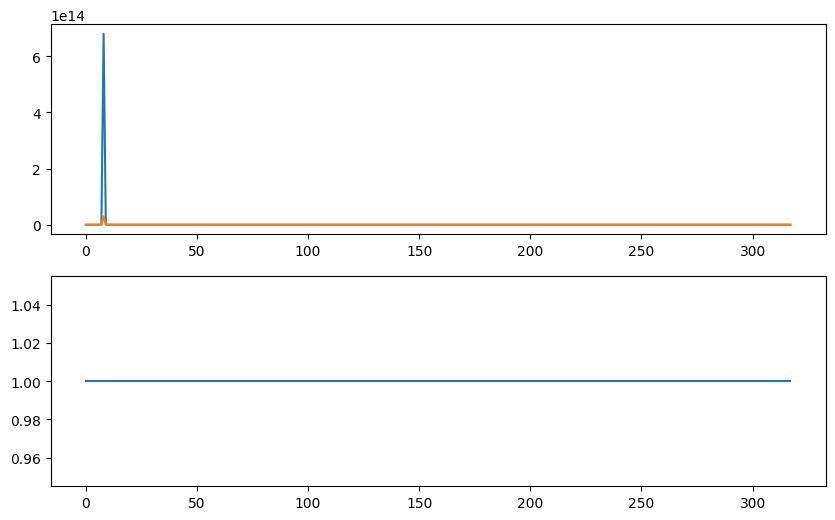

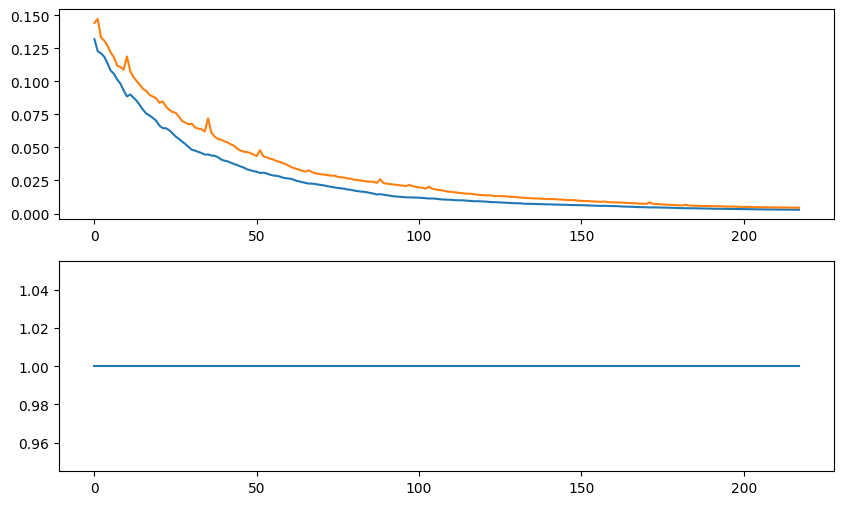

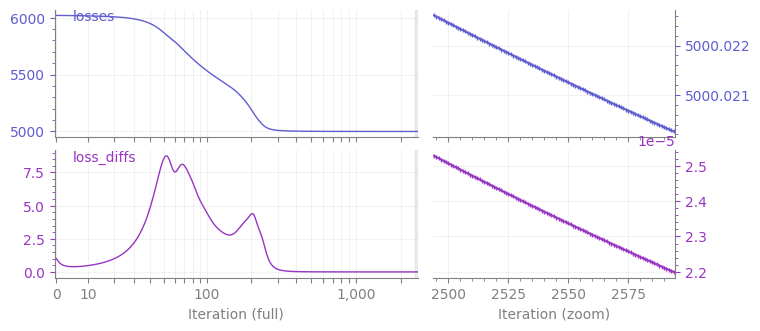

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [67]:
optmzr.plot()

In [68]:
X = np.array(loss_data)

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

In [69]:
X = np.array(loss_data)[2000:]

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(X[:,1])
ax1.plot(X[:,2])
ax2.plot(X[:,0])

In [70]:
X[:,0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

## 6

In [71]:
loss_data=list()

In [72]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    loss_kwargs={
        'rdm_tn': tnc,
        'total_physical_dimension': total_physical_dim,
        'unitary_cost_coefficient': 0,
        'overlap_cost_coefficient': 1,
        'losses': loss_data
    },
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='L-BFGS-B',               # supplied to scipy.minimize
)

In [73]:
mpo_opt = optmzr.optimize(1000)

  0%|                                                             | 0/1000 [00:00<?, ?it/s]

+1.000000000000 [best: +1.000000000000] :   0%|           | 1/1000 [00:00<03:21,  4.97it/s]


# Conclusion
It looks like the overlap gradient isn't working...!